In [9]:
# from torch import manual_seed
# model.fit(X_train, y_train, X_test, y_test, epochs=10)

import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pylab as plt

def plot_scores(param, paramName, tr_scores, va_scores, log_scale=False):
    plt.figure(figsize=(7, 5))
    plt.grid()
    plt.plot(param, tr_scores)
    plt.plot(param, va_scores)
    plt.legend(['train', 'validation'])
    plt.xlabel(paramName)
    plt.ylabel('Accuracy')
    if log_scale:
        plt.xscale('log')
        
        
from hotgrad.variable import Variable
from torch import FloatTensor
from hotgrad.sequential import Sequential
from hotgrad.functions.layers import Linear
from hotgrad.functions.activations import ReLU, Tanh
from hotgrad.functions.losses import MSE
from hotgrad.optimizers import SGD
from torch import cat

from dataset_generator import generate_dataset

# generate the dataset
X_train, X_test, y_train, y_test = generate_dataset(1000, one_hot_encoding=True)
y_train.data = y_train.data*2-1
y_test.data = y_test.data*2-1

X_train_baselines = X_train.data.numpy()
X_test_baselines = X_test.data.numpy()
y_train_baselines = (y_train.data == 1)[:, 1].numpy()
y_test_baselines = (y_test.data == 1)[:, 1].numpy()

X_train.data = (X_train.data - X_train.data.mean())/X_train.data.std() 
X_test.data = (X_test.data - X_test.data.mean())/X_test.data.std() 

X_all = Variable(cat((X_train.data, X_test.data), 0))
y_all = Variable(cat((y_train.data, y_test.data), 0))

## Baselines: Parameters Tuning

### Logistic regression

Best lambda: 0.4832930238571752
Test score: 0.515


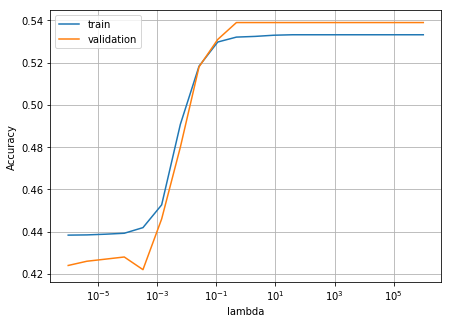

In [10]:
lambdas = np.logspace(-6, 6, 20) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

for lambda_ in lambdas:
    result = cross_validate(LogisticRegression(C=lambda_), X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "lambda", logreg["tr_scores"], logreg["va_scores"], log_scale=True)

best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      LogisticRegression(C=best_lambda)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### Random Forest

Best depth: 15
Test score: 0.974


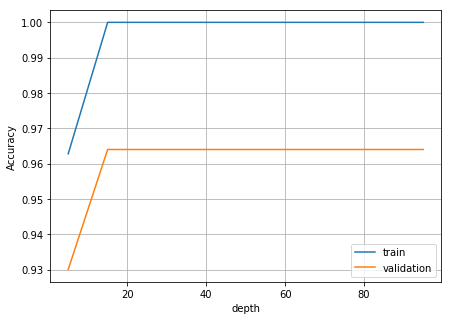

In [11]:
depths = np.arange(5, 100, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different depths
randForest = {
    "tr_scores": [],
    "va_scores": []
}

for depth in depths:
    result = cross_validate(
        RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1), 
        X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    randForest["tr_scores"].append(np.mean(result["train_score"]))
    randForest["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(depths, "depth", randForest["tr_scores"], randForest["va_scores"], log_scale=False)

best_depth = depths[np.argmax(randForest["va_scores"])]
print('Best depth:', best_depth)
print('Test score:',
      RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### K-Nearest Neighbors

In [12]:
scaler = StandardScaler()
scaler.fit(X_train_baselines)
X_tr_scaled = scaler.transform(X_train_baselines)
X_te_scaled = scaler.transform(X_test_baselines)
print("standard deviation average:", X_tr_scaled.std(axis=0).mean())
print("mean average:", X_tr_scaled.mean(axis=0).mean())

standard deviation average: 1.0000004
mean average: -3.9464234e-07


In [13]:
pca = PCA(n_components=0.95)
pca.fit(X_tr_scaled)
X_tr_scaled = pca.transform(X_tr_scaled)
X_te_scaled = pca.transform(X_te_scaled)
X_tr_scaled.shape, X_te_scaled.shape

((1000, 2), (1000, 2))

Best k: 9
Test score: 0.962


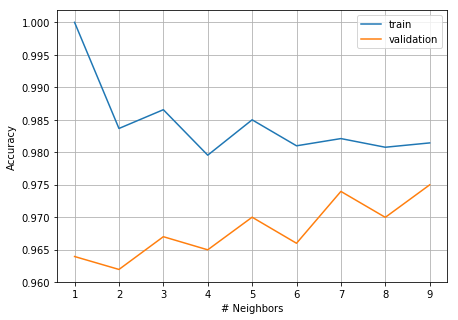

In [14]:
Ks = np.arange(1, 10, 1) # grid search on a parameter of the model

# here we store all the scores obtained with the different number of neighbors
nearestNeig = {
    "tr_scores": [],
    "va_scores": []
}

for k in Ks:
    result = cross_validate(
        KNeighborsClassifier(n_neighbors=k), 
        X_tr_scaled, y_train_baselines, cv=10, return_train_score=True)
    
    nearestNeig["tr_scores"].append(np.mean(result["train_score"]))
    nearestNeig["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(Ks, "# Neighbors", nearestNeig["tr_scores"], nearestNeig["va_scores"], log_scale=False)

best_k = Ks[np.argmax(nearestNeig["va_scores"])]
print('Best k:', best_k)
print('Test score:', 
      KNeighborsClassifier(n_neighbors=k)
      .fit(X_tr_scaled, y_train_baselines)
      .score(X_te_scaled, y_test_baselines))

## Models Comparison

In [15]:
logreg = LogisticRegression(C=best_lambda)
randforest = RandomForestClassifier(n_estimators=100, max_depth=best_depth, n_jobs=-1, random_state=1)
knn = KNeighborsClassifier(n_neighbors=best_k)

# model: two input units, two output units, three hidden layers of 25 units
model = Sequential([Linear(2,25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), Tanh()], MSE(), SGD(lr=0.01))

print("Running cross validation on Logistic Regression...")
logreg_scores = cross_validate(
   logreg,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on Random Forest...")
randforest_scores = cross_validate(
   randforest,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on KNearest Neighbors...")
knn_scores = cross_validate(
   knn,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on the Sequential Module...")
sequential_scores = model.cross_validate(X_all, y_all, epochs=5000, verbose=True, n_splits=10)

Running cross validation on Logistic Regression...
Running cross validation on Random Forest...
Running cross validation on KNearest Neighbors...
Running cross validation on the Sequential Module...
----------------- fold 1/10 -----------------
Epoch 0: Train loss: 1.4950307607650757. Train accuracy 0.48%. 
Epoch 1: Train loss: 1.4850119352340698. Train accuracy 0.48%. 
Epoch 2: Train loss: 1.4765628576278687. Train accuracy 0.48%. 
Epoch 3: Train loss: 1.469351053237915. Train accuracy 0.48%. 
Epoch 4: Train loss: 1.4630755186080933. Train accuracy 0.48%. 
Epoch 5: Train loss: 1.4574748277664185. Train accuracy 0.48%. 
Epoch 6: Train loss: 1.4523290395736694. Train accuracy 0.48%. 
Epoch 7: Train loss: 1.447458028793335. Train accuracy 0.48%. 
Epoch 8: Train loss: 1.4427152872085571. Train accuracy 0.48%. 
Epoch 9: Train loss: 1.4379799365997314. Train accuracy 0.48%. 
Epoch 10: Train loss: 1.4331508874893188. Train accuracy 0.48%. 
Epoch 11: Train loss: 1.42814040184021. Train accura

Epoch 165: Train loss: 0.9864296317100525. Train accuracy 0.48%. 
Epoch 166: Train loss: 0.9863412976264954. Train accuracy 0.48%. 
Epoch 167: Train loss: 0.9862528443336487. Train accuracy 0.49%. 
Epoch 168: Train loss: 0.9861641526222229. Train accuracy 0.49%. 
Epoch 169: Train loss: 0.9860753417015076. Train accuracy 0.49%. 
Epoch 170: Train loss: 0.9859864115715027. Train accuracy 0.49%. 
Epoch 171: Train loss: 0.985897421836853. Train accuracy 0.49%. 
Epoch 172: Train loss: 0.9858081936836243. Train accuracy 0.49%. 
Epoch 173: Train loss: 0.9857189059257507. Train accuracy 0.49%. 
Epoch 174: Train loss: 0.9856293797492981. Train accuracy 0.49%. 
Epoch 175: Train loss: 0.9855395555496216. Train accuracy 0.49%. 
Epoch 176: Train loss: 0.985449492931366. Train accuracy 0.49%. 
Epoch 177: Train loss: 0.985359251499176. Train accuracy 0.49%. 
Epoch 178: Train loss: 0.9852688312530518. Train accuracy 0.49%. 
Epoch 179: Train loss: 0.9851781725883484. Train accuracy 0.49%. 
Epoch 180: Tr

Epoch 301: Train loss: 0.97174072265625. Train accuracy 0.56%. 
Epoch 302: Train loss: 0.9716048240661621. Train accuracy 0.56%. 
Epoch 303: Train loss: 0.971468448638916. Train accuracy 0.56%. 
Epoch 304: Train loss: 0.9713315367698669. Train accuracy 0.56%. 
Epoch 305: Train loss: 0.9711940288543701. Train accuracy 0.56%. 
Epoch 306: Train loss: 0.9710559844970703. Train accuracy 0.56%. 
Epoch 307: Train loss: 0.9709174036979675. Train accuracy 0.56%. 
Epoch 308: Train loss: 0.970778226852417. Train accuracy 0.56%. 
Epoch 309: Train loss: 0.9706385135650635. Train accuracy 0.56%. 
Epoch 310: Train loss: 0.970498263835907. Train accuracy 0.57%. 
Epoch 311: Train loss: 0.9703574776649475. Train accuracy 0.57%. 
Epoch 312: Train loss: 0.9702160358428955. Train accuracy 0.57%. 
Epoch 313: Train loss: 0.9700739979743958. Train accuracy 0.57%. 
Epoch 314: Train loss: 0.969931423664093. Train accuracy 0.57%. 
Epoch 315: Train loss: 0.9697881937026978. Train accuracy 0.57%. 
Epoch 316: Train

Epoch 427: Train loss: 0.9491472244262695. Train accuracy 0.65%. 
Epoch 428: Train loss: 0.9489127993583679. Train accuracy 0.65%. 
Epoch 429: Train loss: 0.9486773610115051. Train accuracy 0.65%. 
Epoch 430: Train loss: 0.9484409093856812. Train accuracy 0.65%. 
Epoch 431: Train loss: 0.9482033848762512. Train accuracy 0.65%. 
Epoch 432: Train loss: 0.9479647874832153. Train accuracy 0.65%. 
Epoch 433: Train loss: 0.9477251172065735. Train accuracy 0.65%. 
Epoch 434: Train loss: 0.9474844932556152. Train accuracy 0.65%. 
Epoch 435: Train loss: 0.947242796421051. Train accuracy 0.65%. 
Epoch 436: Train loss: 0.9470000267028809. Train accuracy 0.65%. 
Epoch 437: Train loss: 0.9467561841011047. Train accuracy 0.65%. 
Epoch 438: Train loss: 0.9465112686157227. Train accuracy 0.65%. 
Epoch 439: Train loss: 0.9462651014328003. Train accuracy 0.66%. 
Epoch 440: Train loss: 0.946017861366272. Train accuracy 0.66%. 
Epoch 441: Train loss: 0.9457694888114929. Train accuracy 0.66%. 
Epoch 442: T

Epoch 557: Train loss: 0.907293438911438. Train accuracy 0.72%. 
Epoch 558: Train loss: 0.9068597555160522. Train accuracy 0.72%. 
Epoch 559: Train loss: 0.9064239263534546. Train accuracy 0.72%. 
Epoch 560: Train loss: 0.905985951423645. Train accuracy 0.72%. 
Epoch 561: Train loss: 0.9055458307266235. Train accuracy 0.72%. 
Epoch 562: Train loss: 0.9051034450531006. Train accuracy 0.72%. 
Epoch 563: Train loss: 0.904658854007721. Train accuracy 0.72%. 
Epoch 564: Train loss: 0.9042120575904846. Train accuracy 0.72%. 
Epoch 565: Train loss: 0.9037631154060364. Train accuracy 0.72%. 
Epoch 566: Train loss: 0.9033120274543762. Train accuracy 0.72%. 
Epoch 567: Train loss: 0.9028587341308594. Train accuracy 0.72%. 
Epoch 568: Train loss: 0.9024031758308411. Train accuracy 0.72%. 
Epoch 569: Train loss: 0.9019454121589661. Train accuracy 0.73%. 
Epoch 570: Train loss: 0.9014853835105896. Train accuracy 0.73%. 
Epoch 571: Train loss: 0.9010231494903564. Train accuracy 0.73%. 
Epoch 572: Tr

Epoch 698: Train loss: 0.819482684135437. Train accuracy 0.79%. 
Epoch 699: Train loss: 0.8186226487159729. Train accuracy 0.79%. 
Epoch 700: Train loss: 0.8177588582038879. Train accuracy 0.79%. 
Epoch 701: Train loss: 0.8168911337852478. Train accuracy 0.79%. 
Epoch 702: Train loss: 0.8160194754600525. Train accuracy 0.79%. 
Epoch 703: Train loss: 0.8151437640190125. Train accuracy 0.79%. 
Epoch 704: Train loss: 0.8142638206481934. Train accuracy 0.79%. 
Epoch 705: Train loss: 0.8133798241615295. Train accuracy 0.79%. 
Epoch 706: Train loss: 0.812491774559021. Train accuracy 0.79%. 
Epoch 707: Train loss: 0.811599612236023. Train accuracy 0.79%. 
Epoch 708: Train loss: 0.8107032775878906. Train accuracy 0.79%. 
Epoch 709: Train loss: 0.8098027110099792. Train accuracy 0.79%. 
Epoch 710: Train loss: 0.8088976144790649. Train accuracy 0.79%. 
Epoch 711: Train loss: 0.8079882264137268. Train accuracy 0.79%. 
Epoch 712: Train loss: 0.8070743680000305. Train accuracy 0.79%. 
Epoch 713: Tr

Epoch 844: Train loss: 0.641585648059845. Train accuracy 0.87%. 
Epoch 845: Train loss: 0.6399750113487244. Train accuracy 0.87%. 
Epoch 846: Train loss: 0.6383591890335083. Train accuracy 0.87%. 
Epoch 847: Train loss: 0.6367385387420654. Train accuracy 0.87%. 
Epoch 848: Train loss: 0.6351136565208435. Train accuracy 0.87%. 
Epoch 849: Train loss: 0.6334843039512634. Train accuracy 0.87%. 
Epoch 850: Train loss: 0.6318503022193909. Train accuracy 0.87%. 
Epoch 851: Train loss: 0.6302103400230408. Train accuracy 0.88%. 
Epoch 852: Train loss: 0.6285648941993713. Train accuracy 0.88%. 
Epoch 853: Train loss: 0.6269157528877258. Train accuracy 0.88%. 
Epoch 854: Train loss: 0.6252618432044983. Train accuracy 0.88%. 
Epoch 855: Train loss: 0.6236032247543335. Train accuracy 0.88%. 
Epoch 856: Train loss: 0.6219406723976135. Train accuracy 0.88%. 
Epoch 857: Train loss: 0.6202741861343384. Train accuracy 0.88%. 
Epoch 858: Train loss: 0.6186032891273499. Train accuracy 0.88%. 
Epoch 859: 

Epoch 978: Train loss: 0.41735103726387024. Train accuracy 0.94%. 
Epoch 979: Train loss: 0.41590791940689087. Train accuracy 0.94%. 
Epoch 980: Train loss: 0.41447192430496216. Train accuracy 0.94%. 
Epoch 981: Train loss: 0.4130427837371826. Train accuracy 0.94%. 
Epoch 982: Train loss: 0.41162076592445374. Train accuracy 0.94%. 
Epoch 983: Train loss: 0.4102058708667755. Train accuracy 0.94%. 
Epoch 984: Train loss: 0.40879788994789124. Train accuracy 0.94%. 
Epoch 985: Train loss: 0.40739697217941284. Train accuracy 0.94%. 
Epoch 986: Train loss: 0.40600454807281494. Train accuracy 0.94%. 
Epoch 987: Train loss: 0.4046195447444916. Train accuracy 0.94%. 
Epoch 988: Train loss: 0.40324121713638306. Train accuracy 0.94%. 
Epoch 989: Train loss: 0.4018700122833252. Train accuracy 0.94%. 
Epoch 990: Train loss: 0.40050607919692993. Train accuracy 0.94%. 
Epoch 991: Train loss: 0.3991490602493286. Train accuracy 0.94%. 
Epoch 992: Train loss: 0.39779990911483765. Train accuracy 0.94%. 


Epoch 1117: Train loss: 0.27865689992904663. Train accuracy 0.96%. 
Epoch 1118: Train loss: 0.2780192494392395. Train accuracy 0.96%. 
Epoch 1119: Train loss: 0.277384877204895. Train accuracy 0.96%. 
Epoch 1120: Train loss: 0.27675390243530273. Train accuracy 0.96%. 
Epoch 1121: Train loss: 0.2761264443397522. Train accuracy 0.96%. 
Epoch 1122: Train loss: 0.27550244331359863. Train accuracy 0.96%. 
Epoch 1123: Train loss: 0.27488160133361816. Train accuracy 0.96%. 
Epoch 1124: Train loss: 0.2742641866207123. Train accuracy 0.96%. 
Epoch 1125: Train loss: 0.27365028858184814. Train accuracy 0.96%. 
Epoch 1126: Train loss: 0.27303972840309143. Train accuracy 0.96%. 
Epoch 1127: Train loss: 0.2724323570728302. Train accuracy 0.96%. 
Epoch 1128: Train loss: 0.271828293800354. Train accuracy 0.96%. 
Epoch 1129: Train loss: 0.2712273597717285. Train accuracy 0.96%. 
Epoch 1130: Train loss: 0.27062907814979553. Train accuracy 0.96%. 
Epoch 1131: Train loss: 0.2700340449810028. Train accurac

Epoch 1248: Train loss: 0.21723785996437073. Train accuracy 0.97%. 
Epoch 1249: Train loss: 0.2168952375650406. Train accuracy 0.97%. 
Epoch 1250: Train loss: 0.21655404567718506. Train accuracy 0.97%. 
Epoch 1251: Train loss: 0.21621422469615936. Train accuracy 0.97%. 
Epoch 1252: Train loss: 0.2158757746219635. Train accuracy 0.97%. 
Epoch 1253: Train loss: 0.21553868055343628. Train accuracy 0.97%. 
Epoch 1254: Train loss: 0.2152029126882553. Train accuracy 0.97%. 
Epoch 1255: Train loss: 0.21486850082874298. Train accuracy 0.97%. 
Epoch 1256: Train loss: 0.2145354300737381. Train accuracy 0.97%. 
Epoch 1257: Train loss: 0.21420371532440186. Train accuracy 0.97%. 
Epoch 1258: Train loss: 0.21387328207492828. Train accuracy 0.97%. 
Epoch 1259: Train loss: 0.21354420483112335. Train accuracy 0.97%. 
Epoch 1260: Train loss: 0.21321643888950348. Train accuracy 0.97%. 
Epoch 1261: Train loss: 0.21288996934890747. Train accuracy 0.97%. 
Epoch 1262: Train loss: 0.21256482601165771. Train a

Epoch 1385: Train loss: 0.18047365546226501. Train accuracy 0.97%. 
Epoch 1386: Train loss: 0.18026363849639893. Train accuracy 0.97%. 
Epoch 1387: Train loss: 0.18005424737930298. Train accuracy 0.97%. 
Epoch 1388: Train loss: 0.17984552681446075. Train accuracy 0.97%. 
Epoch 1389: Train loss: 0.17963743209838867. Train accuracy 0.97%. 
Epoch 1390: Train loss: 0.17942994832992554. Train accuracy 0.97%. 
Epoch 1391: Train loss: 0.17922291159629822. Train accuracy 0.97%. 
Epoch 1392: Train loss: 0.1790163218975067. Train accuracy 0.97%. 
Epoch 1393: Train loss: 0.17881037294864655. Train accuracy 0.97%. 
Epoch 1394: Train loss: 0.17860503494739532. Train accuracy 0.97%. 
Epoch 1395: Train loss: 0.17840033769607544. Train accuracy 0.97%. 
Epoch 1396: Train loss: 0.1781962662935257. Train accuracy 0.97%. 
Epoch 1397: Train loss: 0.17799276113510132. Train accuracy 0.97%. 
Epoch 1398: Train loss: 0.1777898520231247. Train accuracy 0.97%. 
Epoch 1399: Train loss: 0.1775873750448227. Train a

Epoch 1528: Train loss: 0.15558728575706482. Train accuracy 0.97%. 
Epoch 1529: Train loss: 0.1554427444934845. Train accuracy 0.97%. 
Epoch 1530: Train loss: 0.15529856085777283. Train accuracy 0.97%. 
Epoch 1531: Train loss: 0.15515483915805817. Train accuracy 0.97%. 
Epoch 1532: Train loss: 0.15501157939434052. Train accuracy 0.97%. 
Epoch 1533: Train loss: 0.1548687070608139. Train accuracy 0.97%. 
Epoch 1534: Train loss: 0.15472619235515594. Train accuracy 0.97%. 
Epoch 1535: Train loss: 0.15458407998085022. Train accuracy 0.97%. 
Epoch 1536: Train loss: 0.1544424146413803. Train accuracy 0.97%. 
Epoch 1537: Train loss: 0.15430112183094025. Train accuracy 0.97%. 
Epoch 1538: Train loss: 0.15416018664836884. Train accuracy 0.97%. 
Epoch 1539: Train loss: 0.15401959419250488. Train accuracy 0.97%. 
Epoch 1540: Train loss: 0.1538793295621872. Train accuracy 0.97%. 
Epoch 1541: Train loss: 0.15373940765857697. Train accuracy 0.97%. 
Epoch 1542: Train loss: 0.1535998284816742. Train ac

Epoch 1692: Train loss: 0.13592571020126343. Train accuracy 0.97%. 
Epoch 1693: Train loss: 0.13582727313041687. Train accuracy 0.97%. 
Epoch 1694: Train loss: 0.13572905957698822. Train accuracy 0.97%. 
Epoch 1695: Train loss: 0.13563114404678345. Train accuracy 0.97%. 
Epoch 1696: Train loss: 0.13553348183631897. Train accuracy 0.97%. 
Epoch 1697: Train loss: 0.13543601334095. Train accuracy 0.97%. 
Epoch 1698: Train loss: 0.13533876836299896. Train accuracy 0.97%. 
Epoch 1699: Train loss: 0.13524141907691956. Train accuracy 0.97%. 
Epoch 1700: Train loss: 0.13514411449432373. Train accuracy 0.97%. 
Epoch 1701: Train loss: 0.13504669070243835. Train accuracy 0.97%. 
Epoch 1702: Train loss: 0.1349494606256485. Train accuracy 0.97%. 
Epoch 1703: Train loss: 0.13485245406627655. Train accuracy 0.97%. 
Epoch 1704: Train loss: 0.13475561141967773. Train accuracy 0.97%. 
Epoch 1705: Train loss: 0.13465899229049683. Train accuracy 0.97%. 
Epoch 1706: Train loss: 0.13456258177757263. Train a

Epoch 1829: Train loss: 0.12396442145109177. Train accuracy 0.97%. 
Epoch 1830: Train loss: 0.12388799339532852. Train accuracy 0.97%. 
Epoch 1831: Train loss: 0.12381171435117722. Train accuracy 0.97%. 
Epoch 1832: Train loss: 0.12373550981283188. Train accuracy 0.97%. 
Epoch 1833: Train loss: 0.12365923076868057. Train accuracy 0.97%. 
Epoch 1834: Train loss: 0.12358308583498001. Train accuracy 0.97%. 
Epoch 1835: Train loss: 0.1235070750117302. Train accuracy 0.97%. 
Epoch 1836: Train loss: 0.12343120574951172. Train accuracy 0.97%. 
Epoch 1837: Train loss: 0.1233554258942604. Train accuracy 0.97%. 
Epoch 1838: Train loss: 0.12327960878610611. Train accuracy 0.97%. 
Epoch 1839: Train loss: 0.12320394814014435. Train accuracy 0.97%. 
Epoch 1840: Train loss: 0.12312839180231094. Train accuracy 0.97%. 
Epoch 1841: Train loss: 0.12305286526679993. Train accuracy 0.97%. 
Epoch 1842: Train loss: 0.12297747284173965. Train accuracy 0.97%. 
Epoch 1843: Train loss: 0.12290221452713013. Train

Epoch 1965: Train loss: 0.11456939578056335. Train accuracy 0.98%. 
Epoch 1966: Train loss: 0.11450770497322083. Train accuracy 0.98%. 
Epoch 1967: Train loss: 0.11444614827632904. Train accuracy 0.98%. 
Epoch 1968: Train loss: 0.11438491940498352. Train accuracy 0.98%. 
Epoch 1969: Train loss: 0.11432380229234695. Train accuracy 0.98%. 
Epoch 1970: Train loss: 0.11426283419132233. Train accuracy 0.98%. 
Epoch 1971: Train loss: 0.11420192569494247. Train accuracy 0.98%. 
Epoch 1972: Train loss: 0.11414112150669098. Train accuracy 0.98%. 
Epoch 1973: Train loss: 0.11408042162656784. Train accuracy 0.98%. 
Epoch 1974: Train loss: 0.11401981115341187. Train accuracy 0.98%. 
Epoch 1975: Train loss: 0.11395931243896484. Train accuracy 0.98%. 
Epoch 1976: Train loss: 0.11389889568090439. Train accuracy 0.98%. 
Epoch 1977: Train loss: 0.11383859068155289. Train accuracy 0.98%. 
Epoch 1978: Train loss: 0.11377838999032974. Train accuracy 0.98%. 
Epoch 1979: Train loss: 0.11371827870607376. Tra

Epoch 2104: Train loss: 0.10688868165016174. Train accuracy 0.98%. 
Epoch 2105: Train loss: 0.10683892667293549. Train accuracy 0.98%. 
Epoch 2106: Train loss: 0.1067892462015152. Train accuracy 0.98%. 
Epoch 2107: Train loss: 0.10673963278532028. Train accuracy 0.98%. 
Epoch 2108: Train loss: 0.10669010132551193. Train accuracy 0.98%. 
Epoch 2109: Train loss: 0.10664062947034836. Train accuracy 0.98%. 
Epoch 2110: Train loss: 0.10659124702215195. Train accuracy 0.98%. 
Epoch 2111: Train loss: 0.10654191672801971. Train accuracy 0.98%. 
Epoch 2112: Train loss: 0.10649265348911285. Train accuracy 0.98%. 
Epoch 2113: Train loss: 0.10644348710775375. Train accuracy 0.98%. 
Epoch 2114: Train loss: 0.10639438033103943. Train accuracy 0.98%. 
Epoch 2115: Train loss: 0.10634532570838928. Train accuracy 0.98%. 
Epoch 2116: Train loss: 0.1062963679432869. Train accuracy 0.98%. 
Epoch 2117: Train loss: 0.10624746978282928. Train accuracy 0.98%. 
Epoch 2118: Train loss: 0.10619862377643585. Train

Epoch 2245: Train loss: 0.10061991214752197. Train accuracy 0.98%. 
Epoch 2246: Train loss: 0.10057974606752396. Train accuracy 0.98%. 
Epoch 2247: Train loss: 0.10053962469100952. Train accuracy 0.98%. 
Epoch 2248: Train loss: 0.10049958527088165. Train accuracy 0.98%. 
Epoch 2249: Train loss: 0.1004595160484314. Train accuracy 0.98%. 
Epoch 2250: Train loss: 0.10041934996843338. Train accuracy 0.98%. 
Epoch 2251: Train loss: 0.10037922859191895. Train accuracy 0.98%. 
Epoch 2252: Train loss: 0.10033915191888809. Train accuracy 0.98%. 
Epoch 2253: Train loss: 0.10029914230108261. Train accuracy 0.98%. 
Epoch 2254: Train loss: 0.10025917738676071. Train accuracy 0.98%. 
Epoch 2255: Train loss: 0.10021927952766418. Train accuracy 0.98%. 
Epoch 2256: Train loss: 0.10017942637205124. Train accuracy 0.98%. 
Epoch 2257: Train loss: 0.10013961046934128. Train accuracy 0.98%. 
Epoch 2258: Train loss: 0.10009985417127609. Train accuracy 0.98%. 
Epoch 2259: Train loss: 0.10006015002727509. Trai

Epoch 2385: Train loss: 0.09546487033367157. Train accuracy 0.98%. 
Epoch 2386: Train loss: 0.09543097764253616. Train accuracy 0.98%. 
Epoch 2387: Train loss: 0.09539712965488434. Train accuracy 0.98%. 
Epoch 2388: Train loss: 0.09536334127187729. Train accuracy 0.98%. 
Epoch 2389: Train loss: 0.0953296422958374. Train accuracy 0.98%. 
Epoch 2390: Train loss: 0.09529601037502289. Train accuracy 0.98%. 
Epoch 2391: Train loss: 0.09526242315769196. Train accuracy 0.98%. 
Epoch 2392: Train loss: 0.09522844851016998. Train accuracy 0.98%. 
Epoch 2393: Train loss: 0.09519451856613159. Train accuracy 0.98%. 
Epoch 2394: Train loss: 0.09516061842441559. Train accuracy 0.98%. 
Epoch 2395: Train loss: 0.0951266959309578. Train accuracy 0.98%. 
Epoch 2396: Train loss: 0.0950925201177597. Train accuracy 0.98%. 
Epoch 2397: Train loss: 0.0950583890080452. Train accuracy 0.98%. 
Epoch 2398: Train loss: 0.09502428025007248. Train accuracy 0.98%. 
Epoch 2399: Train loss: 0.09499023109674454. Train a

Epoch 2525: Train loss: 0.09097056835889816. Train accuracy 0.98%. 
Epoch 2526: Train loss: 0.09094076603651047. Train accuracy 0.98%. 
Epoch 2527: Train loss: 0.09091098606586456. Train accuracy 0.98%. 
Epoch 2528: Train loss: 0.09088124334812164. Train accuracy 0.98%. 
Epoch 2529: Train loss: 0.09085153788328171. Train accuracy 0.98%. 
Epoch 2530: Train loss: 0.09082186222076416. Train accuracy 0.98%. 
Epoch 2531: Train loss: 0.0907922089099884. Train accuracy 0.98%. 
Epoch 2532: Train loss: 0.09076257050037384. Train accuracy 0.98%. 
Epoch 2533: Train loss: 0.09073298424482346. Train accuracy 0.98%. 
Epoch 2534: Train loss: 0.09070342034101486. Train accuracy 0.98%. 
Epoch 2535: Train loss: 0.09067389369010925. Train accuracy 0.98%. 
Epoch 2536: Train loss: 0.09064440429210663. Train accuracy 0.98%. 
Epoch 2537: Train loss: 0.09061496704816818. Train accuracy 0.98%. 
Epoch 2538: Train loss: 0.09058582782745361. Train accuracy 0.98%. 
Epoch 2539: Train loss: 0.09055697917938232. Trai

Epoch 2665: Train loss: 0.08725178986787796. Train accuracy 0.98%. 
Epoch 2666: Train loss: 0.08722761273384094. Train accuracy 0.98%. 
Epoch 2667: Train loss: 0.08720343559980392. Train accuracy 0.98%. 
Epoch 2668: Train loss: 0.08717930316925049. Train accuracy 0.98%. 
Epoch 2669: Train loss: 0.08715518563985825. Train accuracy 0.98%. 
Epoch 2670: Train loss: 0.08713110536336899. Train accuracy 0.98%. 
Epoch 2671: Train loss: 0.08710704743862152. Train accuracy 0.98%. 
Epoch 2672: Train loss: 0.08708298951387405. Train accuracy 0.98%. 
Epoch 2673: Train loss: 0.08705905824899673. Train accuracy 0.98%. 
Epoch 2674: Train loss: 0.08703532069921494. Train accuracy 0.98%. 
Epoch 2675: Train loss: 0.08701162785291672. Train accuracy 0.98%. 
Epoch 2676: Train loss: 0.08698796480894089. Train accuracy 0.98%. 
Epoch 2677: Train loss: 0.08696431666612625. Train accuracy 0.98%. 
Epoch 2678: Train loss: 0.086940698325634. Train accuracy 0.98%. 
Epoch 2679: Train loss: 0.08691709488630295. Train

Epoch 2806: Train loss: 0.0841144546866417. Train accuracy 0.98%. 
Epoch 2807: Train loss: 0.08409399539232254. Train accuracy 0.98%. 
Epoch 2808: Train loss: 0.08407355844974518. Train accuracy 0.98%. 
Epoch 2809: Train loss: 0.08405313640832901. Train accuracy 0.98%. 
Epoch 2810: Train loss: 0.08403274416923523. Train accuracy 0.98%. 
Epoch 2811: Train loss: 0.08401236683130264. Train accuracy 0.98%. 
Epoch 2812: Train loss: 0.08399200439453125. Train accuracy 0.98%. 
Epoch 2813: Train loss: 0.08397167176008224. Train accuracy 0.98%. 
Epoch 2814: Train loss: 0.08395135402679443. Train accuracy 0.98%. 
Epoch 2815: Train loss: 0.08393106609582901. Train accuracy 0.98%. 
Epoch 2816: Train loss: 0.08391078561544418. Train accuracy 0.98%. 
Epoch 2817: Train loss: 0.08389052748680115. Train accuracy 0.98%. 
Epoch 2818: Train loss: 0.0838702842593193. Train accuracy 0.98%. 
Epoch 2819: Train loss: 0.08385007083415985. Train accuracy 0.98%. 
Epoch 2820: Train loss: 0.0838298574090004. Train 

Epoch 2942: Train loss: 0.08153519034385681. Train accuracy 0.98%. 
Epoch 2943: Train loss: 0.08151726424694061. Train accuracy 0.98%. 
Epoch 2944: Train loss: 0.08149933815002441. Train accuracy 0.98%. 
Epoch 2945: Train loss: 0.0814814493060112. Train accuracy 0.98%. 
Epoch 2946: Train loss: 0.08146357536315918. Train accuracy 0.98%. 
Epoch 2947: Train loss: 0.08144570142030716. Train accuracy 0.98%. 
Epoch 2948: Train loss: 0.08142784982919693. Train accuracy 0.98%. 
Epoch 2949: Train loss: 0.08141003549098969. Train accuracy 0.98%. 
Epoch 2950: Train loss: 0.08139221370220184. Train accuracy 0.98%. 
Epoch 2951: Train loss: 0.08137442171573639. Train accuracy 0.98%. 
Epoch 2952: Train loss: 0.08135662227869034. Train accuracy 0.98%. 
Epoch 2953: Train loss: 0.08133886009454727. Train accuracy 0.98%. 
Epoch 2954: Train loss: 0.0813211128115654. Train accuracy 0.98%. 
Epoch 2955: Train loss: 0.08130338788032532. Train accuracy 0.98%. 
Epoch 2956: Train loss: 0.08128567039966583. Train

Epoch 3104: Train loss: 0.07881854474544525. Train accuracy 0.98%. 
Epoch 3105: Train loss: 0.07880276441574097. Train accuracy 0.98%. 
Epoch 3106: Train loss: 0.07878705114126205. Train accuracy 0.98%. 
Epoch 3107: Train loss: 0.07877127826213837. Train accuracy 0.98%. 
Epoch 3108: Train loss: 0.07875560224056244. Train accuracy 0.98%. 
Epoch 3109: Train loss: 0.07873986661434174. Train accuracy 0.98%. 
Epoch 3110: Train loss: 0.0787242129445076. Train accuracy 0.98%. 
Epoch 3111: Train loss: 0.07870851457118988. Train accuracy 0.98%. 
Epoch 3112: Train loss: 0.07869286090135574. Train accuracy 0.98%. 
Epoch 3113: Train loss: 0.0786772072315216. Train accuracy 0.98%. 
Epoch 3114: Train loss: 0.07866157591342926. Train accuracy 0.98%. 
Epoch 3115: Train loss: 0.0786459669470787. Train accuracy 0.98%. 
Epoch 3116: Train loss: 0.07863034307956696. Train accuracy 0.98%. 
Epoch 3117: Train loss: 0.07861477136611938. Train accuracy 0.98%. 
Epoch 3118: Train loss: 0.07859914749860764. Train 

Epoch 3261: Train loss: 0.07647965103387833. Train accuracy 0.98%. 
Epoch 3262: Train loss: 0.0764654204249382. Train accuracy 0.98%. 
Epoch 3263: Train loss: 0.07645118236541748. Train accuracy 0.98%. 
Epoch 3264: Train loss: 0.07643701136112213. Train accuracy 0.98%. 
Epoch 3265: Train loss: 0.07642276585102081. Train accuracy 0.98%. 
Epoch 3266: Train loss: 0.07640863955020905. Train accuracy 0.98%. 
Epoch 3267: Train loss: 0.07639442384243011. Train accuracy 0.98%. 
Epoch 3268: Train loss: 0.07638028264045715. Train accuracy 0.98%. 
Epoch 3269: Train loss: 0.07636610418558121. Train accuracy 0.98%. 
Epoch 3270: Train loss: 0.07635197043418884. Train accuracy 0.98%. 
Epoch 3271: Train loss: 0.07633784413337708. Train accuracy 0.98%. 
Epoch 3272: Train loss: 0.07632371783256531. Train accuracy 0.98%. 
Epoch 3273: Train loss: 0.07630961388349533. Train accuracy 0.98%. 
Epoch 3274: Train loss: 0.07629551738500595. Train accuracy 0.98%. 
Epoch 3275: Train loss: 0.07628140598535538. Trai

Epoch 3393: Train loss: 0.07467610388994217. Train accuracy 0.98%. 
Epoch 3394: Train loss: 0.07466313987970352. Train accuracy 0.98%. 
Epoch 3395: Train loss: 0.0746501237154007. Train accuracy 0.98%. 
Epoch 3396: Train loss: 0.07463721930980682. Train accuracy 0.98%. 
Epoch 3397: Train loss: 0.07462425529956818. Train accuracy 0.98%. 
Epoch 3398: Train loss: 0.07461143285036087. Train accuracy 0.98%. 
Epoch 3399: Train loss: 0.07459849119186401. Train accuracy 0.98%. 
Epoch 3400: Train loss: 0.0745856910943985. Train accuracy 0.98%. 
Epoch 3401: Train loss: 0.07457275688648224. Train accuracy 0.98%. 
Epoch 3402: Train loss: 0.07455996423959732. Train accuracy 0.98%. 
Epoch 3403: Train loss: 0.07454708963632584. Train accuracy 0.98%. 
Epoch 3404: Train loss: 0.07453428953886032. Train accuracy 0.98%. 
Epoch 3405: Train loss: 0.07452146708965302. Train accuracy 0.98%. 
Epoch 3406: Train loss: 0.07450864464044571. Train accuracy 0.98%. 
Epoch 3407: Train loss: 0.07449587434530258. Train

Epoch 3548: Train loss: 0.0727817490696907. Train accuracy 0.98%. 
Epoch 3549: Train loss: 0.0727703794836998. Train accuracy 0.98%. 
Epoch 3550: Train loss: 0.07275896519422531. Train accuracy 0.98%. 
Epoch 3551: Train loss: 0.07274763286113739. Train accuracy 0.98%. 
Epoch 3552: Train loss: 0.0727362111210823. Train accuracy 0.98%. 
Epoch 3553: Train loss: 0.07272490859031677. Train accuracy 0.98%. 
Epoch 3554: Train loss: 0.07271350920200348. Train accuracy 0.98%. 
Epoch 3555: Train loss: 0.07270219922065735. Train accuracy 0.98%. 
Epoch 3556: Train loss: 0.07269086688756943. Train accuracy 0.98%. 
Epoch 3557: Train loss: 0.07267948240041733. Train accuracy 0.98%. 
Epoch 3558: Train loss: 0.0726681798696518. Train accuracy 0.98%. 
Epoch 3559: Train loss: 0.0726567730307579. Train accuracy 0.98%. 
Epoch 3560: Train loss: 0.07264550775289536. Train accuracy 0.98%. 
Epoch 3561: Train loss: 0.07263412326574326. Train accuracy 0.98%. 
Epoch 3562: Train loss: 0.07262284308671951. Train ac

Epoch 3674: Train loss: 0.07139120995998383. Train accuracy 0.98%. 
Epoch 3675: Train loss: 0.0713801234960556. Train accuracy 0.98%. 
Epoch 3676: Train loss: 0.07136909663677216. Train accuracy 0.98%. 
Epoch 3677: Train loss: 0.07135804742574692. Train accuracy 0.98%. 
Epoch 3678: Train loss: 0.0713469609618187. Train accuracy 0.98%. 
Epoch 3679: Train loss: 0.07133600115776062. Train accuracy 0.98%. 
Epoch 3680: Train loss: 0.0713249146938324. Train accuracy 0.98%. 
Epoch 3681: Train loss: 0.07131390273571014. Train accuracy 0.98%. 
Epoch 3682: Train loss: 0.0713028684258461. Train accuracy 0.98%. 
Epoch 3683: Train loss: 0.07129185646772385. Train accuracy 0.98%. 
Epoch 3684: Train loss: 0.07128047943115234. Train accuracy 0.98%. 
Epoch 3685: Train loss: 0.07126906514167786. Train accuracy 0.98%. 
Epoch 3686: Train loss: 0.07125765830278397. Train accuracy 0.98%. 
Epoch 3687: Train loss: 0.07124630361795425. Train accuracy 0.98%. 
Epoch 3688: Train loss: 0.07123487442731857. Train a

Epoch 3808: Train loss: 0.0698554739356041. Train accuracy 0.98%. 
Epoch 3809: Train loss: 0.06984483450651169. Train accuracy 0.98%. 
Epoch 3810: Train loss: 0.0698341503739357. Train accuracy 0.98%. 
Epoch 3811: Train loss: 0.06982355564832687. Train accuracy 0.98%. 
Epoch 3812: Train loss: 0.06981290131807327. Train accuracy 0.98%. 
Epoch 3813: Train loss: 0.06980225443840027. Train accuracy 0.98%. 
Epoch 3814: Train loss: 0.06979165971279144. Train accuracy 0.98%. 
Epoch 3815: Train loss: 0.06978100538253784. Train accuracy 0.98%. 
Epoch 3816: Train loss: 0.06977042555809021. Train accuracy 0.98%. 
Epoch 3817: Train loss: 0.06975982338190079. Train accuracy 0.98%. 
Epoch 3818: Train loss: 0.06974918395280838. Train accuracy 0.98%. 
Epoch 3819: Train loss: 0.06973864883184433. Train accuracy 0.98%. 
Epoch 3820: Train loss: 0.06972801685333252. Train accuracy 0.98%. 
Epoch 3821: Train loss: 0.06971745938062668. Train accuracy 0.98%. 
Epoch 3822: Train loss: 0.06970688700675964. Train

Epoch 3973: Train loss: 0.06817395240068436. Train accuracy 0.98%. 
Epoch 3974: Train loss: 0.06816422939300537. Train accuracy 0.98%. 
Epoch 3975: Train loss: 0.06815455108880997. Train accuracy 0.98%. 
Epoch 3976: Train loss: 0.06814481317996979. Train accuracy 0.98%. 
Epoch 3977: Train loss: 0.06813514977693558. Train accuracy 0.98%. 
Epoch 3978: Train loss: 0.06812543421983719. Train accuracy 0.98%. 
Epoch 3979: Train loss: 0.0681157335639. Train accuracy 0.98%. 
Epoch 3980: Train loss: 0.06810608506202698. Train accuracy 0.98%. 
Epoch 3981: Train loss: 0.06809637695550919. Train accuracy 0.98%. 
Epoch 3982: Train loss: 0.06808672845363617. Train accuracy 0.98%. 
Epoch 3983: Train loss: 0.06807705760002136. Train accuracy 0.98%. 
Epoch 3984: Train loss: 0.06806736439466476. Train accuracy 0.98%. 
Epoch 3985: Train loss: 0.06805774569511414. Train accuracy 0.98%. 
Epoch 3986: Train loss: 0.06804805994033813. Train accuracy 0.98%. 
Epoch 3987: Train loss: 0.06803842633962631. Train a

Epoch 4099: Train loss: 0.06699859350919724. Train accuracy 0.98%. 
Epoch 4100: Train loss: 0.06698965281248093. Train accuracy 0.98%. 
Epoch 4101: Train loss: 0.06698066741228104. Train accuracy 0.98%. 
Epoch 4102: Train loss: 0.06697174161672592. Train accuracy 0.98%. 
Epoch 4103: Train loss: 0.06696278601884842. Train accuracy 0.98%. 
Epoch 4104: Train loss: 0.06695382297039032. Train accuracy 0.98%. 
Epoch 4105: Train loss: 0.0669449120759964. Train accuracy 0.98%. 
Epoch 4106: Train loss: 0.0669359490275383. Train accuracy 0.98%. 
Epoch 4107: Train loss: 0.06692703813314438. Train accuracy 0.98%. 
Epoch 4108: Train loss: 0.06691811978816986. Train accuracy 0.98%. 
Epoch 4109: Train loss: 0.06690915673971176. Train accuracy 0.98%. 
Epoch 4110: Train loss: 0.06690029799938202. Train accuracy 0.98%. 
Epoch 4111: Train loss: 0.06689135730266571. Train accuracy 0.98%. 
Epoch 4112: Train loss: 0.06688243895769119. Train accuracy 0.98%. 
Epoch 4113: Train loss: 0.06687356531620026. Train

Epoch 4236: Train loss: 0.06581158190965652. Train accuracy 0.98%. 
Epoch 4237: Train loss: 0.0658031553030014. Train accuracy 0.98%. 
Epoch 4238: Train loss: 0.06579466909170151. Train accuracy 0.98%. 
Epoch 4239: Train loss: 0.06578617542982101. Train accuracy 0.98%. 
Epoch 4240: Train loss: 0.06577775627374649. Train accuracy 0.98%. 
Epoch 4241: Train loss: 0.0657692700624466. Train accuracy 0.98%. 
Epoch 4242: Train loss: 0.06576082110404968. Train accuracy 0.98%. 
Epoch 4243: Train loss: 0.06575237959623337. Train accuracy 0.98%. 
Epoch 4244: Train loss: 0.06574389338493347. Train accuracy 0.98%. 
Epoch 4245: Train loss: 0.06573551148176193. Train accuracy 0.98%. 
Epoch 4246: Train loss: 0.06572706252336502. Train accuracy 0.98%. 
Epoch 4247: Train loss: 0.06571859121322632. Train accuracy 0.98%. 
Epoch 4248: Train loss: 0.06571021676063538. Train accuracy 0.98%. 
Epoch 4249: Train loss: 0.06570175290107727. Train accuracy 0.98%. 
Epoch 4250: Train loss: 0.06569333374500275. Train

Epoch 4362: Train loss: 0.06477707624435425. Train accuracy 0.98%. 
Epoch 4363: Train loss: 0.06476911157369614. Train accuracy 0.98%. 
Epoch 4364: Train loss: 0.06476113200187683. Train accuracy 0.98%. 
Epoch 4365: Train loss: 0.0647532045841217. Train accuracy 0.98%. 
Epoch 4366: Train loss: 0.06474523991346359. Train accuracy 0.98%. 
Epoch 4367: Train loss: 0.06473730504512787. Train accuracy 0.98%. 
Epoch 4368: Train loss: 0.06472932547330856. Train accuracy 0.98%. 
Epoch 4369: Train loss: 0.06472142040729523. Train accuracy 0.98%. 
Epoch 4370: Train loss: 0.06471346318721771. Train accuracy 0.98%. 
Epoch 4371: Train loss: 0.0647055134177208. Train accuracy 0.98%. 
Epoch 4372: Train loss: 0.06469759345054626. Train accuracy 0.98%. 
Epoch 4373: Train loss: 0.06468971818685532. Train accuracy 0.98%. 
Epoch 4374: Train loss: 0.0646817609667778. Train accuracy 0.98%. 
Epoch 4375: Train loss: 0.06467383354902267. Train accuracy 0.98%. 
Epoch 4376: Train loss: 0.06466585397720337. Train 

Epoch 4496: Train loss: 0.06376931816339493. Train accuracy 0.98%. 
Epoch 4497: Train loss: 0.06376208364963531. Train accuracy 0.98%. 
Epoch 4498: Train loss: 0.0637548416852951. Train accuracy 0.98%. 
Epoch 4499: Train loss: 0.06374765187501907. Train accuracy 0.98%. 
Epoch 4500: Train loss: 0.06374044716358185. Train accuracy 0.98%. 
Epoch 4501: Train loss: 0.06373320519924164. Train accuracy 0.98%. 
Epoch 4502: Train loss: 0.0637260153889656. Train accuracy 0.98%. 
Epoch 4503: Train loss: 0.06371881067752838. Train accuracy 0.98%. 
Epoch 4504: Train loss: 0.06371163576841354. Train accuracy 0.98%. 
Epoch 4505: Train loss: 0.06370440870523453. Train accuracy 0.98%. 
Epoch 4506: Train loss: 0.0636972114443779. Train accuracy 0.98%. 
Epoch 4507: Train loss: 0.06369004398584366. Train accuracy 0.98%. 
Epoch 4508: Train loss: 0.06368289142847061. Train accuracy 0.98%. 
Epoch 4509: Train loss: 0.06367561966180801. Train accuracy 0.98%. 
Epoch 4510: Train loss: 0.06366852670907974. Train 

Epoch 4619: Train loss: 0.06291452050209045. Train accuracy 0.98%. 
Epoch 4620: Train loss: 0.06290784478187561. Train accuracy 0.98%. 
Epoch 4621: Train loss: 0.06290099769830704. Train accuracy 0.98%. 
Epoch 4622: Train loss: 0.06289426982402802. Train accuracy 0.98%. 
Epoch 4623: Train loss: 0.06288758665323257. Train accuracy 0.98%. 
Epoch 4624: Train loss: 0.06288084387779236. Train accuracy 0.98%. 
Epoch 4625: Train loss: 0.06287409365177155. Train accuracy 0.98%. 
Epoch 4626: Train loss: 0.06286755204200745. Train accuracy 0.98%. 
Epoch 4627: Train loss: 0.06286069750785828. Train accuracy 0.98%. 
Epoch 4628: Train loss: 0.06285398453474045. Train accuracy 0.98%. 
Epoch 4629: Train loss: 0.06284725666046143. Train accuracy 0.98%. 
Epoch 4630: Train loss: 0.06284061819314957. Train accuracy 0.98%. 
Epoch 4631: Train loss: 0.06283380836248398. Train accuracy 0.98%. 
Epoch 4632: Train loss: 0.06282717734575272. Train accuracy 0.98%. 
Epoch 4633: Train loss: 0.06282052397727966. Tra

Epoch 4755: Train loss: 0.06202446296811104. Train accuracy 0.98%. 
Epoch 4756: Train loss: 0.062018126249313354. Train accuracy 0.98%. 
Epoch 4757: Train loss: 0.062011729925870895. Train accuracy 0.98%. 
Epoch 4758: Train loss: 0.06200532242655754. Train accuracy 0.98%. 
Epoch 4759: Train loss: 0.06199903413653374. Train accuracy 0.98%. 
Epoch 4760: Train loss: 0.0619925931096077. Train accuracy 0.98%. 
Epoch 4761: Train loss: 0.06198630854487419. Train accuracy 0.98%. 
Epoch 4762: Train loss: 0.061980027705430984. Train accuracy 0.98%. 
Epoch 4763: Train loss: 0.06197360157966614. Train accuracy 0.98%. 
Epoch 4764: Train loss: 0.061967261135578156. Train accuracy 0.98%. 
Epoch 4765: Train loss: 0.06196097284555435. Train accuracy 0.98%. 
Epoch 4766: Train loss: 0.06195457652211189. Train accuracy 0.98%. 
Epoch 4767: Train loss: 0.0619482658803463. Train accuracy 0.98%. 
Epoch 4768: Train loss: 0.061941955238580704. Train accuracy 0.98%. 
Epoch 4769: Train loss: 0.061935536563396454.

Epoch 4888: Train loss: 0.0611967034637928. Train accuracy 0.98%. 
Epoch 4889: Train loss: 0.0611906461417675. Train accuracy 0.98%. 
Epoch 4890: Train loss: 0.06118468940258026. Train accuracy 0.98%. 
Epoch 4891: Train loss: 0.061178505420684814. Train accuracy 0.98%. 
Epoch 4892: Train loss: 0.06117246672511101. Train accuracy 0.98%. 
Epoch 4893: Train loss: 0.061166420578956604. Train accuracy 0.98%. 
Epoch 4894: Train loss: 0.06116031855344772. Train accuracy 0.98%. 
Epoch 4895: Train loss: 0.061154283583164215. Train accuracy 0.98%. 
Epoch 4896: Train loss: 0.061148226261138916. Train accuracy 0.98%. 
Epoch 4897: Train loss: 0.06114210933446884. Train accuracy 0.98%. 
Epoch 4898: Train loss: 0.0611361525952816. Train accuracy 0.98%. 
Epoch 4899: Train loss: 0.06113002821803093. Train accuracy 0.98%. 
Epoch 4900: Train loss: 0.06112399324774742. Train accuracy 0.98%. 
Epoch 4901: Train loss: 0.06111803650856018. Train accuracy 0.98%. 
Epoch 4902: Train loss: 0.06111191213130951. Tr

Epoch 15: Train loss: 1.3784147500991821. Train accuracy 0.48%. 
Epoch 16: Train loss: 1.3606880903244019. Train accuracy 0.48%. 
Epoch 17: Train loss: 1.341150164604187. Train accuracy 0.48%. 
Epoch 18: Train loss: 1.3191274404525757. Train accuracy 0.48%. 
Epoch 19: Train loss: 1.2940243482589722. Train accuracy 0.48%. 
Epoch 20: Train loss: 1.265380620956421. Train accuracy 0.48%. 
Epoch 21: Train loss: 1.2330060005187988. Train accuracy 0.48%. 
Epoch 22: Train loss: 1.197204828262329. Train accuracy 0.48%. 
Epoch 23: Train loss: 1.159057378768921. Train accuracy 0.48%. 
Epoch 24: Train loss: 1.1205943822860718. Train accuracy 0.48%. 
Epoch 25: Train loss: 1.0846201181411743. Train accuracy 0.48%. 
Epoch 26: Train loss: 1.0540435314178467. Train accuracy 0.48%. 
Epoch 27: Train loss: 1.0304780006408691. Train accuracy 0.49%. 
Epoch 28: Train loss: 1.013797402381897. Train accuracy 0.56%. 
Epoch 29: Train loss: 1.002803087234497. Train accuracy 0.64%. 
Epoch 30: Train loss: 0.9959092

Epoch 162: Train loss: 0.9638274312019348. Train accuracy 0.59%. 
Epoch 163: Train loss: 0.9636402726173401. Train accuracy 0.59%. 
Epoch 164: Train loss: 0.9634525775909424. Train accuracy 0.59%. 
Epoch 165: Train loss: 0.9632642865180969. Train accuracy 0.59%. 
Epoch 166: Train loss: 0.9630753993988037. Train accuracy 0.59%. 
Epoch 167: Train loss: 0.9628859162330627. Train accuracy 0.59%. 
Epoch 168: Train loss: 0.9626957178115845. Train accuracy 0.59%. 
Epoch 169: Train loss: 0.9625049233436584. Train accuracy 0.60%. 
Epoch 170: Train loss: 0.9623138904571533. Train accuracy 0.60%. 
Epoch 171: Train loss: 0.9621222615242004. Train accuracy 0.60%. 
Epoch 172: Train loss: 0.9619300365447998. Train accuracy 0.60%. 
Epoch 173: Train loss: 0.9617372155189514. Train accuracy 0.60%. 
Epoch 174: Train loss: 0.9615437984466553. Train accuracy 0.60%. 
Epoch 175: Train loss: 0.9613498449325562. Train accuracy 0.60%. 
Epoch 176: Train loss: 0.9611551761627197. Train accuracy 0.60%. 
Epoch 177:

Epoch 301: Train loss: 0.9296053051948547. Train accuracy 0.69%. 
Epoch 302: Train loss: 0.929270327091217. Train accuracy 0.69%. 
Epoch 303: Train loss: 0.9289335608482361. Train accuracy 0.69%. 
Epoch 304: Train loss: 0.9285950064659119. Train accuracy 0.69%. 
Epoch 305: Train loss: 0.9282546639442444. Train accuracy 0.69%. 
Epoch 306: Train loss: 0.9279125332832336. Train accuracy 0.69%. 
Epoch 307: Train loss: 0.9275686144828796. Train accuracy 0.69%. 
Epoch 308: Train loss: 0.9272228479385376. Train accuracy 0.69%. 
Epoch 309: Train loss: 0.9268752932548523. Train accuracy 0.69%. 
Epoch 310: Train loss: 0.9265259504318237. Train accuracy 0.69%. 
Epoch 311: Train loss: 0.9261747598648071. Train accuracy 0.70%. 
Epoch 312: Train loss: 0.9258216619491577. Train accuracy 0.70%. 
Epoch 313: Train loss: 0.9254666566848755. Train accuracy 0.70%. 
Epoch 314: Train loss: 0.9251097440719604. Train accuracy 0.70%. 
Epoch 315: Train loss: 0.9247508645057678. Train accuracy 0.70%. 
Epoch 316: 

Epoch 453: Train loss: 0.8485148549079895. Train accuracy 0.81%. 
Epoch 454: Train loss: 0.847696840763092. Train accuracy 0.81%. 
Epoch 455: Train loss: 0.8468738794326782. Train accuracy 0.81%. 
Epoch 456: Train loss: 0.8460457921028137. Train accuracy 0.81%. 
Epoch 457: Train loss: 0.845212459564209. Train accuracy 0.81%. 
Epoch 458: Train loss: 0.8443739414215088. Train accuracy 0.81%. 
Epoch 459: Train loss: 0.8435299396514893. Train accuracy 0.81%. 
Epoch 460: Train loss: 0.8426808714866638. Train accuracy 0.81%. 
Epoch 461: Train loss: 0.8418264389038086. Train accuracy 0.81%. 
Epoch 462: Train loss: 0.8409667611122131. Train accuracy 0.82%. 
Epoch 463: Train loss: 0.8401018977165222. Train accuracy 0.82%. 
Epoch 464: Train loss: 0.8392319083213806. Train accuracy 0.82%. 
Epoch 465: Train loss: 0.8383565545082092. Train accuracy 0.82%. 
Epoch 466: Train loss: 0.8374758958816528. Train accuracy 0.82%. 
Epoch 467: Train loss: 0.8365897536277771. Train accuracy 0.82%. 
Epoch 468: T

Epoch 588: Train loss: 0.686383068561554. Train accuracy 0.85%. 
Epoch 589: Train loss: 0.6848146319389343. Train accuracy 0.85%. 
Epoch 590: Train loss: 0.683242678642273. Train accuracy 0.85%. 
Epoch 591: Train loss: 0.6816672682762146. Train accuracy 0.85%. 
Epoch 592: Train loss: 0.680088460445404. Train accuracy 0.85%. 
Epoch 593: Train loss: 0.6785062551498413. Train accuracy 0.85%. 
Epoch 594: Train loss: 0.6769205331802368. Train accuracy 0.85%. 
Epoch 595: Train loss: 0.6753315925598145. Train accuracy 0.85%. 
Epoch 596: Train loss: 0.6737391948699951. Train accuracy 0.85%. 
Epoch 597: Train loss: 0.6721438765525818. Train accuracy 0.85%. 
Epoch 598: Train loss: 0.6705453991889954. Train accuracy 0.85%. 
Epoch 599: Train loss: 0.6689441204071045. Train accuracy 0.85%. 
Epoch 600: Train loss: 0.667340099811554. Train accuracy 0.85%. 
Epoch 601: Train loss: 0.6657333374023438. Train accuracy 0.85%. 
Epoch 602: Train loss: 0.6641238331794739. Train accuracy 0.85%. 
Epoch 603: Tra

Epoch 734: Train loss: 0.45334261655807495. Train accuracy 0.90%. 
Epoch 735: Train loss: 0.45196202397346497. Train accuracy 0.90%. 
Epoch 736: Train loss: 0.45058488845825195. Train accuracy 0.90%. 
Epoch 737: Train loss: 0.44921258091926575. Train accuracy 0.90%. 
Epoch 738: Train loss: 0.44784510135650635. Train accuracy 0.90%. 
Epoch 739: Train loss: 0.4464819133281708. Train accuracy 0.90%. 
Epoch 740: Train loss: 0.4451223313808441. Train accuracy 0.90%. 
Epoch 741: Train loss: 0.4437675178050995. Train accuracy 0.90%. 
Epoch 742: Train loss: 0.4424172043800354. Train accuracy 0.90%. 
Epoch 743: Train loss: 0.44107142090797424. Train accuracy 0.90%. 
Epoch 744: Train loss: 0.4397308826446533. Train accuracy 0.90%. 
Epoch 745: Train loss: 0.43839460611343384. Train accuracy 0.90%. 
Epoch 746: Train loss: 0.43706214427948. Train accuracy 0.90%. 
Epoch 747: Train loss: 0.4357340633869171. Train accuracy 0.90%. 
Epoch 748: Train loss: 0.43440869450569153. Train accuracy 0.90%. 
Epoc

Epoch 859: Train loss: 0.31172847747802734. Train accuracy 0.94%. 
Epoch 860: Train loss: 0.3108641803264618. Train accuracy 0.94%. 
Epoch 861: Train loss: 0.31000420451164246. Train accuracy 0.94%. 
Epoch 862: Train loss: 0.3091479539871216. Train accuracy 0.94%. 
Epoch 863: Train loss: 0.30829572677612305. Train accuracy 0.94%. 
Epoch 864: Train loss: 0.3074477016925812. Train accuracy 0.94%. 
Epoch 865: Train loss: 0.30660319328308105. Train accuracy 0.94%. 
Epoch 866: Train loss: 0.30576252937316895. Train accuracy 0.94%. 
Epoch 867: Train loss: 0.3049241304397583. Train accuracy 0.94%. 
Epoch 868: Train loss: 0.3040902316570282. Train accuracy 0.94%. 
Epoch 869: Train loss: 0.30326101183891296. Train accuracy 0.94%. 
Epoch 870: Train loss: 0.30243614315986633. Train accuracy 0.94%. 
Epoch 871: Train loss: 0.3016147315502167. Train accuracy 0.94%. 
Epoch 872: Train loss: 0.30079635977745056. Train accuracy 0.94%. 
Epoch 873: Train loss: 0.2999825179576874. Train accuracy 0.94%. 
Ep

Epoch 986: Train loss: 0.2306262105703354. Train accuracy 0.96%. 
Epoch 987: Train loss: 0.2301730066537857. Train accuracy 0.96%. 
Epoch 988: Train loss: 0.2297220528125763. Train accuracy 0.96%. 
Epoch 989: Train loss: 0.2292732149362564. Train accuracy 0.96%. 
Epoch 990: Train loss: 0.22882646322250366. Train accuracy 0.96%. 
Epoch 991: Train loss: 0.22838179767131805. Train accuracy 0.96%. 
Epoch 992: Train loss: 0.22793924808502197. Train accuracy 0.96%. 
Epoch 993: Train loss: 0.2274986207485199. Train accuracy 0.96%. 
Epoch 994: Train loss: 0.227060005068779. Train accuracy 0.96%. 
Epoch 995: Train loss: 0.22662347555160522. Train accuracy 0.96%. 
Epoch 996: Train loss: 0.22618897259235382. Train accuracy 0.96%. 
Epoch 997: Train loss: 0.22575655579566956. Train accuracy 0.96%. 
Epoch 998: Train loss: 0.22532612085342407. Train accuracy 0.96%. 
Epoch 999: Train loss: 0.22489774227142334. Train accuracy 0.96%. 
Epoch 1000: Train loss: 0.22447137534618378. Train accuracy 0.96%. 
E

Epoch 1125: Train loss: 0.18271343410015106. Train accuracy 0.96%. 
Epoch 1126: Train loss: 0.18245048820972443. Train accuracy 0.96%. 
Epoch 1127: Train loss: 0.18218865990638733. Train accuracy 0.96%. 
Epoch 1128: Train loss: 0.18192805349826813. Train accuracy 0.96%. 
Epoch 1129: Train loss: 0.18166835606098175. Train accuracy 0.96%. 
Epoch 1130: Train loss: 0.1814095824956894. Train accuracy 0.96%. 
Epoch 1131: Train loss: 0.18115180730819702. Train accuracy 0.96%. 
Epoch 1132: Train loss: 0.18089506030082703. Train accuracy 0.96%. 
Epoch 1133: Train loss: 0.18063923716545105. Train accuracy 0.96%. 
Epoch 1134: Train loss: 0.18038423359394073. Train accuracy 0.96%. 
Epoch 1135: Train loss: 0.1801300197839737. Train accuracy 0.96%. 
Epoch 1136: Train loss: 0.1798766404390335. Train accuracy 0.96%. 
Epoch 1137: Train loss: 0.17962412536144257. Train accuracy 0.96%. 
Epoch 1138: Train loss: 0.17937245965003967. Train accuracy 0.96%. 
Epoch 1139: Train loss: 0.1791216880083084. Train a

Epoch 1259: Train loss: 0.15404921770095825. Train accuracy 0.97%. 
Epoch 1260: Train loss: 0.15387696027755737. Train accuracy 0.97%. 
Epoch 1261: Train loss: 0.15370522439479828. Train accuracy 0.97%. 
Epoch 1262: Train loss: 0.1535339504480362. Train accuracy 0.97%. 
Epoch 1263: Train loss: 0.15336307883262634. Train accuracy 0.97%. 
Epoch 1264: Train loss: 0.15319272875785828. Train accuracy 0.97%. 
Epoch 1265: Train loss: 0.1530228555202484. Train accuracy 0.97%. 
Epoch 1266: Train loss: 0.15285341441631317. Train accuracy 0.97%. 
Epoch 1267: Train loss: 0.15268412232398987. Train accuracy 0.97%. 
Epoch 1268: Train loss: 0.15251517295837402. Train accuracy 0.97%. 
Epoch 1269: Train loss: 0.15234634280204773. Train accuracy 0.97%. 
Epoch 1270: Train loss: 0.15217804908752441. Train accuracy 0.97%. 
Epoch 1271: Train loss: 0.15201035141944885. Train accuracy 0.97%. 
Epoch 1272: Train loss: 0.1518431305885315. Train accuracy 0.97%. 
Epoch 1273: Train loss: 0.15167641639709473. Train 

Epoch 1390: Train loss: 0.13500218093395233. Train accuracy 0.98%. 
Epoch 1391: Train loss: 0.13488134741783142. Train accuracy 0.98%. 
Epoch 1392: Train loss: 0.13476085662841797. Train accuracy 0.98%. 
Epoch 1393: Train loss: 0.1346406787633896. Train accuracy 0.98%. 
Epoch 1394: Train loss: 0.13452081382274628. Train accuracy 0.98%. 
Epoch 1395: Train loss: 0.13440126180648804. Train accuracy 0.98%. 
Epoch 1396: Train loss: 0.1342819780111313. Train accuracy 0.98%. 
Epoch 1397: Train loss: 0.1341630071401596. Train accuracy 0.98%. 
Epoch 1398: Train loss: 0.1340443342924118. Train accuracy 0.98%. 
Epoch 1399: Train loss: 0.13392603397369385. Train accuracy 0.98%. 
Epoch 1400: Train loss: 0.13380800187587738. Train accuracy 0.98%. 
Epoch 1401: Train loss: 0.1336902529001236. Train accuracy 0.98%. 
Epoch 1402: Train loss: 0.13357281684875488. Train accuracy 0.98%. 
Epoch 1403: Train loss: 0.13345567882061005. Train accuracy 0.98%. 
Epoch 1404: Train loss: 0.1333388090133667. Train acc

Epoch 1528: Train loss: 0.12072167545557022. Train accuracy 0.98%. 
Epoch 1529: Train loss: 0.12063415348529816. Train accuracy 0.98%. 
Epoch 1530: Train loss: 0.12054681777954102. Train accuracy 0.98%. 
Epoch 1531: Train loss: 0.1204596683382988. Train accuracy 0.98%. 
Epoch 1532: Train loss: 0.1203727051615715. Train accuracy 0.98%. 
Epoch 1533: Train loss: 0.12028586864471436. Train accuracy 0.98%. 
Epoch 1534: Train loss: 0.12019924074411392. Train accuracy 0.98%. 
Epoch 1535: Train loss: 0.12011270970106125. Train accuracy 0.98%. 
Epoch 1536: Train loss: 0.12002503126859665. Train accuracy 0.98%. 
Epoch 1537: Train loss: 0.11993750929832458. Train accuracy 0.98%. 
Epoch 1538: Train loss: 0.11985018104314804. Train accuracy 0.98%. 
Epoch 1539: Train loss: 0.11976304650306702. Train accuracy 0.98%. 
Epoch 1540: Train loss: 0.11967609822750092. Train accuracy 0.98%. 
Epoch 1541: Train loss: 0.11958935856819153. Train accuracy 0.98%. 
Epoch 1542: Train loss: 0.11950338631868362. Train

Epoch 1657: Train loss: 0.11070507764816284. Train accuracy 0.98%. 
Epoch 1658: Train loss: 0.1106371283531189. Train accuracy 0.98%. 
Epoch 1659: Train loss: 0.1105693057179451. Train accuracy 0.98%. 
Epoch 1660: Train loss: 0.11050160229206085. Train accuracy 0.98%. 
Epoch 1661: Train loss: 0.11043407768011093. Train accuracy 0.98%. 
Epoch 1662: Train loss: 0.11036662757396698. Train accuracy 0.98%. 
Epoch 1663: Train loss: 0.11029933393001556. Train accuracy 0.98%. 
Epoch 1664: Train loss: 0.1102321594953537. Train accuracy 0.98%. 
Epoch 1665: Train loss: 0.11016511917114258. Train accuracy 0.98%. 
Epoch 1666: Train loss: 0.11009824275970459. Train accuracy 0.98%. 
Epoch 1667: Train loss: 0.11003144085407257. Train accuracy 0.98%. 
Epoch 1668: Train loss: 0.10996481776237488. Train accuracy 0.98%. 
Epoch 1669: Train loss: 0.10989832133054733. Train accuracy 0.98%. 
Epoch 1670: Train loss: 0.10983224213123322. Train accuracy 0.98%. 
Epoch 1671: Train loss: 0.10976715385913849. Train 

Epoch 1778: Train loss: 0.10337425768375397. Train accuracy 0.98%. 
Epoch 1779: Train loss: 0.1033199205994606. Train accuracy 0.98%. 
Epoch 1780: Train loss: 0.10326565057039261. Train accuracy 0.98%. 
Epoch 1781: Train loss: 0.10321149230003357. Train accuracy 0.98%. 
Epoch 1782: Train loss: 0.1031574010848999. Train accuracy 0.98%. 
Epoch 1783: Train loss: 0.10310345143079758. Train accuracy 0.98%. 
Epoch 1784: Train loss: 0.10304956138134003. Train accuracy 0.98%. 
Epoch 1785: Train loss: 0.10299576073884964. Train accuracy 0.98%. 
Epoch 1786: Train loss: 0.10294205695390701. Train accuracy 0.98%. 
Epoch 1787: Train loss: 0.10288846492767334. Train accuracy 0.98%. 
Epoch 1788: Train loss: 0.10283493250608444. Train accuracy 0.98%. 
Epoch 1789: Train loss: 0.1027815043926239. Train accuracy 0.98%. 
Epoch 1790: Train loss: 0.10272818058729172. Train accuracy 0.98%. 
Epoch 1791: Train loss: 0.1026749536395073. Train accuracy 0.98%. 
Epoch 1792: Train loss: 0.10262180119752884. Train a

Epoch 1916: Train loss: 0.09667441248893738. Train accuracy 0.98%. 
Epoch 1917: Train loss: 0.09663110971450806. Train accuracy 0.98%. 
Epoch 1918: Train loss: 0.09658783674240112. Train accuracy 0.98%. 
Epoch 1919: Train loss: 0.09654463082551956. Train accuracy 0.98%. 
Epoch 1920: Train loss: 0.09650149941444397. Train accuracy 0.98%. 
Epoch 1921: Train loss: 0.09645843505859375. Train accuracy 0.98%. 
Epoch 1922: Train loss: 0.0964154377579689. Train accuracy 0.98%. 
Epoch 1923: Train loss: 0.09637252241373062. Train accuracy 0.98%. 
Epoch 1924: Train loss: 0.09632964432239532. Train accuracy 0.98%. 
Epoch 1925: Train loss: 0.0962868258357048. Train accuracy 0.98%. 
Epoch 1926: Train loss: 0.09624408930540085. Train accuracy 0.98%. 
Epoch 1927: Train loss: 0.09620141983032227. Train accuracy 0.98%. 
Epoch 1928: Train loss: 0.09615880250930786. Train accuracy 0.98%. 
Epoch 1929: Train loss: 0.09611625969409943. Train accuracy 0.98%. 
Epoch 1930: Train loss: 0.09607376903295517. Train

Epoch 2050: Train loss: 0.09132196754217148. Train accuracy 0.98%. 
Epoch 2051: Train loss: 0.09128540009260178. Train accuracy 0.98%. 
Epoch 2052: Train loss: 0.09124889969825745. Train accuracy 0.98%. 
Epoch 2053: Train loss: 0.0912124365568161. Train accuracy 0.98%. 
Epoch 2054: Train loss: 0.09117601811885834. Train accuracy 0.98%. 
Epoch 2055: Train loss: 0.09113968908786774. Train accuracy 0.98%. 
Epoch 2056: Train loss: 0.09110338240861893. Train accuracy 0.98%. 
Epoch 2057: Train loss: 0.0910671129822731. Train accuracy 0.98%. 
Epoch 2058: Train loss: 0.09103091806173325. Train accuracy 0.98%. 
Epoch 2059: Train loss: 0.09099438786506653. Train accuracy 0.98%. 
Epoch 2060: Train loss: 0.09095734357833862. Train accuracy 0.98%. 
Epoch 2061: Train loss: 0.09092036634683609. Train accuracy 0.98%. 
Epoch 2062: Train loss: 0.09088344126939774. Train accuracy 0.98%. 
Epoch 2063: Train loss: 0.09084653109312057. Train accuracy 0.98%. 
Epoch 2064: Train loss: 0.09080970287322998. Train

Epoch 2202: Train loss: 0.08610199391841888. Train accuracy 0.98%. 
Epoch 2203: Train loss: 0.08607082813978195. Train accuracy 0.98%. 
Epoch 2204: Train loss: 0.08603964000940323. Train accuracy 0.98%. 
Epoch 2205: Train loss: 0.08600854873657227. Train accuracy 0.98%. 
Epoch 2206: Train loss: 0.0859774798154831. Train accuracy 0.98%. 
Epoch 2207: Train loss: 0.0859464481472969. Train accuracy 0.98%. 
Epoch 2208: Train loss: 0.08591548353433609. Train accuracy 0.98%. 
Epoch 2209: Train loss: 0.08588449656963348. Train accuracy 0.98%. 
Epoch 2210: Train loss: 0.08585362881422043. Train accuracy 0.98%. 
Epoch 2211: Train loss: 0.085822694003582. Train accuracy 0.98%. 
Epoch 2212: Train loss: 0.0857919380068779. Train accuracy 0.98%. 
Epoch 2213: Train loss: 0.08576107770204544. Train accuracy 0.98%. 
Epoch 2214: Train loss: 0.0857304111123085. Train accuracy 0.98%. 
Epoch 2215: Train loss: 0.08569961041212082. Train accuracy 0.98%. 
Epoch 2216: Train loss: 0.08566901087760925. Train acc

Epoch 2354: Train loss: 0.08173144608736038. Train accuracy 0.98%. 
Epoch 2355: Train loss: 0.08170485496520996. Train accuracy 0.98%. 
Epoch 2356: Train loss: 0.08167815953493118. Train accuracy 0.98%. 
Epoch 2357: Train loss: 0.08165161311626434. Train accuracy 0.98%. 
Epoch 2358: Train loss: 0.08162495493888855. Train accuracy 0.98%. 
Epoch 2359: Train loss: 0.08159847557544708. Train accuracy 0.98%. 
Epoch 2360: Train loss: 0.08157189190387726. Train accuracy 0.98%. 
Epoch 2361: Train loss: 0.08154541999101639. Train accuracy 0.98%. 
Epoch 2362: Train loss: 0.08151892572641373. Train accuracy 0.98%. 
Epoch 2363: Train loss: 0.08149249851703644. Train accuracy 0.98%. 
Epoch 2364: Train loss: 0.08146609365940094. Train accuracy 0.98%. 
Epoch 2365: Train loss: 0.08143971860408783. Train accuracy 0.98%. 
Epoch 2366: Train loss: 0.08141335844993591. Train accuracy 0.98%. 
Epoch 2367: Train loss: 0.08138701319694519. Train accuracy 0.98%. 
Epoch 2368: Train loss: 0.08136072754859924. Tra

Epoch 2516: Train loss: 0.07775714993476868. Train accuracy 0.98%. 
Epoch 2517: Train loss: 0.07773461937904358. Train accuracy 0.98%. 
Epoch 2518: Train loss: 0.0777120515704155. Train accuracy 0.98%. 
Epoch 2519: Train loss: 0.07768949121236801. Train accuracy 0.98%. 
Epoch 2520: Train loss: 0.07766707241535187. Train accuracy 0.98%. 
Epoch 2521: Train loss: 0.07764449715614319. Train accuracy 0.98%. 
Epoch 2522: Train loss: 0.07762213051319122. Train accuracy 0.98%. 
Epoch 2523: Train loss: 0.07759962230920792. Train accuracy 0.98%. 
Epoch 2524: Train loss: 0.07757735252380371. Train accuracy 0.98%. 
Epoch 2525: Train loss: 0.0775548592209816. Train accuracy 0.98%. 
Epoch 2526: Train loss: 0.07753251492977142. Train accuracy 0.98%. 
Epoch 2527: Train loss: 0.07751018553972244. Train accuracy 0.98%. 
Epoch 2528: Train loss: 0.07748784124851227. Train accuracy 0.98%. 
Epoch 2529: Train loss: 0.07746555656194687. Train accuracy 0.98%. 
Epoch 2530: Train loss: 0.0774432122707367. Train 

Epoch 2646: Train loss: 0.07503979653120041. Train accuracy 0.98%. 
Epoch 2647: Train loss: 0.0750204473733902. Train accuracy 0.98%. 
Epoch 2648: Train loss: 0.07500117272138596. Train accuracy 0.98%. 
Epoch 2649: Train loss: 0.07498186081647873. Train accuracy 0.98%. 
Epoch 2650: Train loss: 0.07496260106563568. Train accuracy 0.98%. 
Epoch 2651: Train loss: 0.0749434307217598. Train accuracy 0.98%. 
Epoch 2652: Train loss: 0.07492408156394958. Train accuracy 0.98%. 
Epoch 2653: Train loss: 0.07490499317646027. Train accuracy 0.98%. 
Epoch 2654: Train loss: 0.0748857781291008. Train accuracy 0.98%. 
Epoch 2655: Train loss: 0.07486652582883835. Train accuracy 0.98%. 
Epoch 2656: Train loss: 0.0748474970459938. Train accuracy 0.98%. 
Epoch 2657: Train loss: 0.07482829689979553. Train accuracy 0.98%. 
Epoch 2658: Train loss: 0.07480916380882263. Train accuracy 0.98%. 
Epoch 2659: Train loss: 0.07479013502597809. Train accuracy 0.98%. 
Epoch 2660: Train loss: 0.07477103173732758. Train a

Epoch 2777: Train loss: 0.07264158129692078. Train accuracy 0.98%. 
Epoch 2778: Train loss: 0.07262440770864487. Train accuracy 0.98%. 
Epoch 2779: Train loss: 0.0726071372628212. Train accuracy 0.98%. 
Epoch 2780: Train loss: 0.07259005308151245. Train accuracy 0.98%. 
Epoch 2781: Train loss: 0.07257287204265594. Train accuracy 0.98%. 
Epoch 2782: Train loss: 0.07255565375089645. Train accuracy 0.98%. 
Epoch 2783: Train loss: 0.07253866642713547. Train accuracy 0.98%. 
Epoch 2784: Train loss: 0.07252145558595657. Train accuracy 0.98%. 
Epoch 2785: Train loss: 0.07250438630580902. Train accuracy 0.98%. 
Epoch 2786: Train loss: 0.07248742878437042. Train accuracy 0.98%. 
Epoch 2787: Train loss: 0.07247030735015869. Train accuracy 0.98%. 
Epoch 2788: Train loss: 0.07245339453220367. Train accuracy 0.98%. 
Epoch 2789: Train loss: 0.0724363923072815. Train accuracy 0.98%. 
Epoch 2790: Train loss: 0.07241936028003693. Train accuracy 0.98%. 
Epoch 2791: Train loss: 0.07240250706672668. Train

Epoch 2910: Train loss: 0.07048289477825165. Train accuracy 0.98%. 
Epoch 2911: Train loss: 0.070467509329319. Train accuracy 0.98%. 
Epoch 2912: Train loss: 0.07045210897922516. Train accuracy 0.98%. 
Epoch 2913: Train loss: 0.07043690979480743. Train accuracy 0.98%. 
Epoch 2914: Train loss: 0.07042147219181061. Train accuracy 0.98%. 
Epoch 2915: Train loss: 0.0704062208533287. Train accuracy 0.98%. 
Epoch 2916: Train loss: 0.07039093971252441. Train accuracy 0.98%. 
Epoch 2917: Train loss: 0.07037561386823654. Train accuracy 0.98%. 
Epoch 2918: Train loss: 0.07036039978265762. Train accuracy 0.98%. 
Epoch 2919: Train loss: 0.07034514844417572. Train accuracy 0.98%. 
Epoch 2920: Train loss: 0.07032984495162964. Train accuracy 0.98%. 
Epoch 2921: Train loss: 0.07031472027301788. Train accuracy 0.98%. 
Epoch 2922: Train loss: 0.07029945403337479. Train accuracy 0.98%. 
Epoch 2923: Train loss: 0.07028420269489288. Train accuracy 0.98%. 
Epoch 2924: Train loss: 0.0702691301703453. Train a

Epoch 3039: Train loss: 0.06861338764429092. Train accuracy 0.98%. 
Epoch 3040: Train loss: 0.06859953701496124. Train accuracy 0.98%. 
Epoch 3041: Train loss: 0.06858576834201813. Train accuracy 0.98%. 
Epoch 3042: Train loss: 0.06857196241617203. Train accuracy 0.98%. 
Epoch 3043: Train loss: 0.06855808943510056. Train accuracy 0.98%. 
Epoch 3044: Train loss: 0.06854439526796341. Train accuracy 0.98%. 
Epoch 3045: Train loss: 0.06853064149618149. Train accuracy 0.98%. 
Epoch 3046: Train loss: 0.06851676851511002. Train accuracy 0.98%. 
Epoch 3047: Train loss: 0.06850314140319824. Train accuracy 0.98%. 
Epoch 3048: Train loss: 0.06848934292793274. Train accuracy 0.98%. 
Epoch 3049: Train loss: 0.06847555935382843. Train accuracy 0.98%. 
Epoch 3050: Train loss: 0.06846196949481964. Train accuracy 0.98%. 
Epoch 3051: Train loss: 0.06844814866781235. Train accuracy 0.98%. 
Epoch 3052: Train loss: 0.0684344470500946. Train accuracy 0.98%. 
Epoch 3053: Train loss: 0.06842083483934402. Trai

Epoch 3170: Train loss: 0.06688936799764633. Train accuracy 0.98%. 
Epoch 3171: Train loss: 0.0668768435716629. Train accuracy 0.98%. 
Epoch 3172: Train loss: 0.06686433404684067. Train accuracy 0.98%. 
Epoch 3173: Train loss: 0.06685199588537216. Train accuracy 0.98%. 
Epoch 3174: Train loss: 0.06683946400880814. Train accuracy 0.98%. 
Epoch 3175: Train loss: 0.06682701408863068. Train accuracy 0.98%. 
Epoch 3176: Train loss: 0.06681467592716217. Train accuracy 0.98%. 
Epoch 3177: Train loss: 0.06680217385292053. Train accuracy 0.98%. 
Epoch 3178: Train loss: 0.06678979098796844. Train accuracy 0.98%. 
Epoch 3179: Train loss: 0.06677743047475815. Train accuracy 0.98%. 
Epoch 3180: Train loss: 0.06676498055458069. Train accuracy 0.98%. 
Epoch 3181: Train loss: 0.06675263494253159. Train accuracy 0.98%. 
Epoch 3182: Train loss: 0.06674028187990189. Train accuracy 0.98%. 
Epoch 3183: Train loss: 0.06672784686088562. Train accuracy 0.98%. 
Epoch 3184: Train loss: 0.06671556085348129. Trai

Epoch 3302: Train loss: 0.065312959253788. Train accuracy 0.98%. 
Epoch 3303: Train loss: 0.06530158221721649. Train accuracy 0.98%. 
Epoch 3304: Train loss: 0.06529022753238678. Train accuracy 0.98%. 
Epoch 3305: Train loss: 0.0652790516614914. Train accuracy 0.98%. 
Epoch 3306: Train loss: 0.06526768207550049. Train accuracy 0.98%. 
Epoch 3307: Train loss: 0.06525631994009018. Train accuracy 0.98%. 
Epoch 3308: Train loss: 0.06524518877267838. Train accuracy 0.98%. 
Epoch 3309: Train loss: 0.06523386389017105. Train accuracy 0.98%. 
Epoch 3310: Train loss: 0.06522256135940552. Train accuracy 0.98%. 
Epoch 3311: Train loss: 0.06521140038967133. Train accuracy 0.98%. 
Epoch 3312: Train loss: 0.06520005315542221. Train accuracy 0.98%. 
Epoch 3313: Train loss: 0.06518884003162384. Train accuracy 0.98%. 
Epoch 3314: Train loss: 0.06517770141363144. Train accuracy 0.98%. 
Epoch 3315: Train loss: 0.06516636908054352. Train accuracy 0.98%. 
Epoch 3316: Train loss: 0.06515518575906754. Train 

Epoch 3431: Train loss: 0.0639152005314827. Train accuracy 0.98%. 
Epoch 3432: Train loss: 0.06390480697154999. Train accuracy 0.98%. 
Epoch 3433: Train loss: 0.06389454007148743. Train accuracy 0.98%. 
Epoch 3434: Train loss: 0.06388411670923233. Train accuracy 0.98%. 
Epoch 3435: Train loss: 0.06387379765510559. Train accuracy 0.98%. 
Epoch 3436: Train loss: 0.06386351585388184. Train accuracy 0.98%. 
Epoch 3437: Train loss: 0.06385308504104614. Train accuracy 0.98%. 
Epoch 3438: Train loss: 0.06384280323982239. Train accuracy 0.98%. 
Epoch 3439: Train loss: 0.06383249908685684. Train accuracy 0.98%. 
Epoch 3440: Train loss: 0.06382212787866592. Train accuracy 0.98%. 
Epoch 3441: Train loss: 0.06381192803382874. Train accuracy 0.98%. 
Epoch 3442: Train loss: 0.0638015866279602. Train accuracy 0.98%. 
Epoch 3443: Train loss: 0.0637911930680275. Train accuracy 0.98%. 
Epoch 3444: Train loss: 0.06378104537725449. Train accuracy 0.98%. 
Epoch 3445: Train loss: 0.06377074867486954. Train 

Epoch 3564: Train loss: 0.06259483844041824. Train accuracy 0.99%. 
Epoch 3565: Train loss: 0.06258527934551239. Train accuracy 0.99%. 
Epoch 3566: Train loss: 0.06257569044828415. Train accuracy 0.99%. 
Epoch 3567: Train loss: 0.0625663548707962. Train accuracy 0.99%. 
Epoch 3568: Train loss: 0.06255673617124557. Train accuracy 0.99%. 
Epoch 3569: Train loss: 0.06254719942808151. Train accuracy 0.99%. 
Epoch 3570: Train loss: 0.06253796815872192. Train accuracy 0.99%. 
Epoch 3571: Train loss: 0.06252837181091309. Train accuracy 0.99%. 
Epoch 3572: Train loss: 0.06251883506774902. Train accuracy 0.99%. 
Epoch 3573: Train loss: 0.06250949949026108. Train accuracy 0.99%. 
Epoch 3574: Train loss: 0.06249997019767761. Train accuracy 0.99%. 
Epoch 3575: Train loss: 0.06249048933386803. Train accuracy 0.99%. 
Epoch 3576: Train loss: 0.06248116493225098. Train accuracy 0.99%. 
Epoch 3577: Train loss: 0.06247163936495781. Train accuracy 0.99%. 
Epoch 3578: Train loss: 0.062462154775857925. Tra

Epoch 3694: Train loss: 0.061407409608364105. Train accuracy 0.99%. 
Epoch 3695: Train loss: 0.06139872968196869. Train accuracy 0.99%. 
Epoch 3696: Train loss: 0.06138991191983223. Train accuracy 0.99%. 
Epoch 3697: Train loss: 0.06138108670711517. Train accuracy 0.99%. 
Epoch 3698: Train loss: 0.061372458934783936. Train accuracy 0.99%. 
Epoch 3699: Train loss: 0.061363644897937775. Train accuracy 0.99%. 
Epoch 3700: Train loss: 0.0613548569381237. Train accuracy 0.99%. 
Epoch 3701: Train loss: 0.06134626269340515. Train accuracy 0.99%. 
Epoch 3702: Train loss: 0.06133746728301048. Train accuracy 0.99%. 
Epoch 3703: Train loss: 0.06132868304848671. Train accuracy 0.99%. 
Epoch 3704: Train loss: 0.06132006645202637. Train accuracy 0.99%. 
Epoch 3705: Train loss: 0.061311282217502594. Train accuracy 0.99%. 
Epoch 3706: Train loss: 0.061302509158849716. Train accuracy 0.99%. 
Epoch 3707: Train loss: 0.061293866485357285. Train accuracy 0.99%. 
Epoch 3708: Train loss: 0.06128522381186485

Epoch 3841: Train loss: 0.060143616050481796. Train accuracy 0.99%. 
Epoch 3842: Train loss: 0.060135263949632645. Train accuracy 0.99%. 
Epoch 3843: Train loss: 0.06012691929936409. Train accuracy 0.99%. 
Epoch 3844: Train loss: 0.06011878326535225. Train accuracy 0.99%. 
Epoch 3845: Train loss: 0.06011053919792175. Train accuracy 0.99%. 
Epoch 3846: Train loss: 0.0601021908223629. Train accuracy 0.99%. 
Epoch 3847: Train loss: 0.060093916952610016. Train accuracy 0.99%. 
Epoch 3848: Train loss: 0.06008574366569519. Train accuracy 0.99%. 
Epoch 3849: Train loss: 0.0600774921476841. Train accuracy 0.99%. 
Epoch 3850: Train loss: 0.06006923317909241. Train accuracy 0.99%. 
Epoch 3851: Train loss: 0.06006110832095146. Train accuracy 0.99%. 
Epoch 3852: Train loss: 0.06005276367068291. Train accuracy 0.99%. 
Epoch 3853: Train loss: 0.06004450470209122. Train accuracy 0.99%. 
Epoch 3854: Train loss: 0.06003646180033684. Train accuracy 0.99%. 
Epoch 3855: Train loss: 0.06002821400761604. Tr

Epoch 3967: Train loss: 0.05905269458889961. Train accuracy 0.99%. 
Epoch 3968: Train loss: 0.05904432386159897. Train accuracy 0.99%. 
Epoch 3969: Train loss: 0.05903591588139534. Train accuracy 0.99%. 
Epoch 3970: Train loss: 0.05902758985757828. Train accuracy 0.99%. 
Epoch 3971: Train loss: 0.05901909992098808. Train accuracy 0.99%. 
Epoch 3972: Train loss: 0.05901077389717102. Train accuracy 0.99%. 
Epoch 3973: Train loss: 0.059002574533224106. Train accuracy 0.99%. 
Epoch 3974: Train loss: 0.05899413675069809. Train accuracy 0.99%. 
Epoch 3975: Train loss: 0.05898566544055939. Train accuracy 0.99%. 
Epoch 3976: Train loss: 0.058977484703063965. Train accuracy 0.99%. 
Epoch 3977: Train loss: 0.058969173580408096. Train accuracy 0.99%. 
Epoch 3978: Train loss: 0.05896074324846268. Train accuracy 0.99%. 
Epoch 3979: Train loss: 0.058952365070581436. Train accuracy 0.99%. 
Epoch 3980: Train loss: 0.05894431099295616. Train accuracy 0.99%. 
Epoch 3981: Train loss: 0.058935895562171936

Epoch 4107: Train loss: 0.05797950550913811. Train accuracy 0.98%. 
Epoch 4108: Train loss: 0.05797228589653969. Train accuracy 0.98%. 
Epoch 4109: Train loss: 0.0579649843275547. Train accuracy 0.98%. 
Epoch 4110: Train loss: 0.05795793980360031. Train accuracy 0.98%. 
Epoch 4111: Train loss: 0.05795074999332428. Train accuracy 0.98%. 
Epoch 4112: Train loss: 0.05794355273246765. Train accuracy 0.98%. 
Epoch 4113: Train loss: 0.057936545461416245. Train accuracy 0.99%. 
Epoch 4114: Train loss: 0.057929400354623795. Train accuracy 0.98%. 
Epoch 4115: Train loss: 0.0579221136868. Train accuracy 0.99%. 
Epoch 4116: Train loss: 0.057915013283491135. Train accuracy 0.99%. 
Epoch 4117: Train loss: 0.05790790542960167. Train accuracy 0.99%. 
Epoch 4118: Train loss: 0.05790078267455101. Train accuracy 0.99%. 
Epoch 4119: Train loss: 0.05789368599653244. Train accuracy 0.99%. 
Epoch 4120: Train loss: 0.057886600494384766. Train accuracy 0.99%. 
Epoch 4121: Train loss: 0.057879358530044556. Tra

Epoch 4263: Train loss: 0.056908655911684036. Train accuracy 0.99%. 
Epoch 4264: Train loss: 0.05690229684114456. Train accuracy 0.99%. 
Epoch 4265: Train loss: 0.0568956658244133. Train accuracy 0.99%. 
Epoch 4266: Train loss: 0.0568891242146492. Train accuracy 0.99%. 
Epoch 4267: Train loss: 0.05688266083598137. Train accuracy 0.99%. 
Epoch 4268: Train loss: 0.056875959038734436. Train accuracy 0.99%. 
Epoch 4269: Train loss: 0.05686945840716362. Train accuracy 0.99%. 
Epoch 4270: Train loss: 0.05686302110552788. Train accuracy 0.99%. 
Epoch 4271: Train loss: 0.05685635656118393. Train accuracy 0.99%. 
Epoch 4272: Train loss: 0.056849975138902664. Train accuracy 0.99%. 
Epoch 4273: Train loss: 0.056843385100364685. Train accuracy 0.99%. 
Epoch 4274: Train loss: 0.056836698204278946. Train accuracy 0.99%. 
Epoch 4275: Train loss: 0.05683053284883499. Train accuracy 0.99%. 
Epoch 4276: Train loss: 0.05682386830449104. Train accuracy 0.99%. 
Epoch 4277: Train loss: 0.05681731551885605. 

Epoch 4392: Train loss: 0.056094489991664886. Train accuracy 0.99%. 
Epoch 4393: Train loss: 0.056088633835315704. Train accuracy 0.99%. 
Epoch 4394: Train loss: 0.056082453578710556. Train accuracy 0.99%. 
Epoch 4395: Train loss: 0.056076351553201675. Train accuracy 0.99%. 
Epoch 4396: Train loss: 0.05607035756111145. Train accuracy 0.99%. 
Epoch 4397: Train loss: 0.056064195930957794. Train accuracy 0.99%. 
Epoch 4398: Train loss: 0.05605824291706085. Train accuracy 0.99%. 
Epoch 4399: Train loss: 0.05605229735374451. Train accuracy 0.99%. 
Epoch 4400: Train loss: 0.056046076118946075. Train accuracy 0.99%. 
Epoch 4401: Train loss: 0.05604005977511406. Train accuracy 0.99%. 
Epoch 4402: Train loss: 0.05603417754173279. Train accuracy 0.99%. 
Epoch 4403: Train loss: 0.05602797120809555. Train accuracy 0.99%. 
Epoch 4404: Train loss: 0.05602195858955383. Train accuracy 0.99%. 
Epoch 4405: Train loss: 0.05601594224572182. Train accuracy 0.99%. 
Epoch 4406: Train loss: 0.0560099482536315

Epoch 4514: Train loss: 0.05537746846675873. Train accuracy 0.99%. 
Epoch 4515: Train loss: 0.055371738970279694. Train accuracy 0.99%. 
Epoch 4516: Train loss: 0.05536598339676857. Train accuracy 0.99%. 
Epoch 4517: Train loss: 0.055360376834869385. Train accuracy 0.99%. 
Epoch 4518: Train loss: 0.055354658514261246. Train accuracy 0.99%. 
Epoch 4519: Train loss: 0.055348921567201614. Train accuracy 0.99%. 
Epoch 4520: Train loss: 0.0553433895111084. Train accuracy 0.99%. 
Epoch 4521: Train loss: 0.05533766746520996. Train accuracy 0.99%. 
Epoch 4522: Train loss: 0.05533182993531227. Train accuracy 0.99%. 
Epoch 4523: Train loss: 0.05532624199986458. Train accuracy 0.99%. 
Epoch 4524: Train loss: 0.05532068759202957. Train accuracy 0.99%. 
Epoch 4525: Train loss: 0.05531493201851845. Train accuracy 0.99%. 
Epoch 4526: Train loss: 0.0553092435002327. Train accuracy 0.99%. 
Epoch 4527: Train loss: 0.0553036592900753. Train accuracy 0.99%. 
Epoch 4528: Train loss: 0.055297985672950745. T

Epoch 4665: Train loss: 0.05454855039715767. Train accuracy 0.99%. 
Epoch 4666: Train loss: 0.05454351007938385. Train accuracy 0.99%. 
Epoch 4667: Train loss: 0.05453816056251526. Train accuracy 0.99%. 
Epoch 4668: Train loss: 0.054532669484615326. Train accuracy 0.99%. 
Epoch 4669: Train loss: 0.05452727526426315. Train accuracy 0.99%. 
Epoch 4670: Train loss: 0.0545223131775856. Train accuracy 0.99%. 
Epoch 4671: Train loss: 0.05451687052845955. Train accuracy 0.99%. 
Epoch 4672: Train loss: 0.05451139435172081. Train accuracy 0.99%. 
Epoch 4673: Train loss: 0.054506201297044754. Train accuracy 0.99%. 
Epoch 4674: Train loss: 0.054500967264175415. Train accuracy 0.99%. 
Epoch 4675: Train loss: 0.054495617747306824. Train accuracy 0.99%. 
Epoch 4676: Train loss: 0.05449030175805092. Train accuracy 0.99%. 
Epoch 4677: Train loss: 0.05448506772518158. Train accuracy 0.99%. 
Epoch 4678: Train loss: 0.05447977036237717. Train accuracy 0.99%. 
Epoch 4679: Train loss: 0.05447433888912201. 

Epoch 4825: Train loss: 0.05373036488890648. Train accuracy 0.99%. 
Epoch 4826: Train loss: 0.05372539907693863. Train accuracy 0.99%. 
Epoch 4827: Train loss: 0.05372045934200287. Train accuracy 0.99%. 
Epoch 4828: Train loss: 0.05371575430035591. Train accuracy 0.99%. 
Epoch 4829: Train loss: 0.05371067672967911. Train accuracy 0.99%. 
Epoch 4830: Train loss: 0.053705811500549316. Train accuracy 0.99%. 
Epoch 4831: Train loss: 0.053700897842645645. Train accuracy 0.99%. 
Epoch 4832: Train loss: 0.053696077316999435. Train accuracy 0.99%. 
Epoch 4833: Train loss: 0.05369104817509651. Train accuracy 0.99%. 
Epoch 4834: Train loss: 0.053686242550611496. Train accuracy 0.99%. 
Epoch 4835: Train loss: 0.0536813922226429. Train accuracy 0.99%. 
Epoch 4836: Train loss: 0.053676456212997437. Train accuracy 0.99%. 
Epoch 4837: Train loss: 0.05367150902748108. Train accuracy 0.99%. 
Epoch 4838: Train loss: 0.053666673600673676. Train accuracy 0.99%. 
Epoch 4839: Train loss: 0.05366185307502746

Epoch 4952: Train loss: 0.05312465503811836. Train accuracy 0.99%. 
Epoch 4953: Train loss: 0.05311983451247215. Train accuracy 0.99%. 
Epoch 4954: Train loss: 0.053115230053663254. Train accuracy 0.99%. 
Epoch 4955: Train loss: 0.05311077460646629. Train accuracy 0.99%. 
Epoch 4956: Train loss: 0.053106099367141724. Train accuracy 0.99%. 
Epoch 4957: Train loss: 0.05310126766562462. Train accuracy 0.99%. 
Epoch 4958: Train loss: 0.05309680849313736. Train accuracy 0.99%. 
Epoch 4959: Train loss: 0.0530923455953598. Train accuracy 0.99%. 
Epoch 4960: Train loss: 0.05308753624558449. Train accuracy 0.99%. 
Epoch 4961: Train loss: 0.05308275669813156. Train accuracy 0.99%. 
Epoch 4962: Train loss: 0.0530785508453846. Train accuracy 0.99%. 
Epoch 4963: Train loss: 0.053073808550834656. Train accuracy 0.99%. 
Epoch 4964: Train loss: 0.05306899547576904. Train accuracy 0.99%. 
Epoch 4965: Train loss: 0.053064413368701935. Train accuracy 0.99%. 
Epoch 4966: Train loss: 0.05306015536189079. T

Epoch 76: Train loss: 0.9929185509681702. Train accuracy 0.49%. 
Epoch 77: Train loss: 0.9927863478660583. Train accuracy 0.49%. 
Epoch 78: Train loss: 0.9926544427871704. Train accuracy 0.49%. 
Epoch 79: Train loss: 0.9925238490104675. Train accuracy 0.49%. 
Epoch 80: Train loss: 0.9923940300941467. Train accuracy 0.49%. 
Epoch 81: Train loss: 0.9922646284103394. Train accuracy 0.49%. 
Epoch 82: Train loss: 0.9921360015869141. Train accuracy 0.50%. 
Epoch 83: Train loss: 0.9920086860656738. Train accuracy 0.50%. 
Epoch 84: Train loss: 0.9918821454048157. Train accuracy 0.50%. 
Epoch 85: Train loss: 0.9917562007904053. Train accuracy 0.51%. 
Epoch 86: Train loss: 0.9916310906410217. Train accuracy 0.51%. 
Epoch 87: Train loss: 0.9915059208869934. Train accuracy 0.51%. 
Epoch 88: Train loss: 0.991381049156189. Train accuracy 0.51%. 
Epoch 89: Train loss: 0.9912571907043457. Train accuracy 0.51%. 
Epoch 90: Train loss: 0.9911336898803711. Train accuracy 0.51%. 
Epoch 91: Train loss: 0.99

Epoch 216: Train loss: 0.9727436304092407. Train accuracy 0.69%. 
Epoch 217: Train loss: 0.9725551605224609. Train accuracy 0.69%. 
Epoch 218: Train loss: 0.97236567735672. Train accuracy 0.69%. 
Epoch 219: Train loss: 0.9721751809120178. Train accuracy 0.69%. 
Epoch 220: Train loss: 0.971983790397644. Train accuracy 0.69%. 
Epoch 221: Train loss: 0.9717913269996643. Train accuracy 0.69%. 
Epoch 222: Train loss: 0.9715977907180786. Train accuracy 0.69%. 
Epoch 223: Train loss: 0.971403181552887. Train accuracy 0.69%. 
Epoch 224: Train loss: 0.9712074995040894. Train accuracy 0.69%. 
Epoch 225: Train loss: 0.9710108637809753. Train accuracy 0.69%. 
Epoch 226: Train loss: 0.9708132147789001. Train accuracy 0.69%. 
Epoch 227: Train loss: 0.9706145524978638. Train accuracy 0.69%. 
Epoch 228: Train loss: 0.9704148769378662. Train accuracy 0.69%. 
Epoch 229: Train loss: 0.9702140092849731. Train accuracy 0.69%. 
Epoch 230: Train loss: 0.9700120687484741. Train accuracy 0.69%. 
Epoch 231: Tra

Epoch 354: Train loss: 0.932834267616272. Train accuracy 0.76%. 
Epoch 355: Train loss: 0.9323972463607788. Train accuracy 0.76%. 
Epoch 356: Train loss: 0.9319571256637573. Train accuracy 0.76%. 
Epoch 357: Train loss: 0.9315139651298523. Train accuracy 0.76%. 
Epoch 358: Train loss: 0.9310678243637085. Train accuracy 0.76%. 
Epoch 359: Train loss: 0.9306185245513916. Train accuracy 0.76%. 
Epoch 360: Train loss: 0.9301660656929016. Train accuracy 0.76%. 
Epoch 361: Train loss: 0.9297103881835938. Train accuracy 0.76%. 
Epoch 362: Train loss: 0.9292516112327576. Train accuracy 0.76%. 
Epoch 363: Train loss: 0.9287895560264587. Train accuracy 0.76%. 
Epoch 364: Train loss: 0.9283239841461182. Train accuracy 0.77%. 
Epoch 365: Train loss: 0.9278550148010254. Train accuracy 0.77%. 
Epoch 366: Train loss: 0.9273827075958252. Train accuracy 0.77%. 
Epoch 367: Train loss: 0.9269071221351624. Train accuracy 0.77%. 
Epoch 368: Train loss: 0.926427960395813. Train accuracy 0.77%. 
Epoch 369: T

Epoch 506: Train loss: 0.8122084736824036. Train accuracy 0.83%. 
Epoch 507: Train loss: 0.8108916878700256. Train accuracy 0.83%. 
Epoch 508: Train loss: 0.809565544128418. Train accuracy 0.84%. 
Epoch 509: Train loss: 0.8082289099693298. Train accuracy 0.84%. 
Epoch 510: Train loss: 0.8068822026252747. Train accuracy 0.84%. 
Epoch 511: Train loss: 0.8055259585380554. Train accuracy 0.83%. 
Epoch 512: Train loss: 0.804160475730896. Train accuracy 0.83%. 
Epoch 513: Train loss: 0.8027845621109009. Train accuracy 0.84%. 
Epoch 514: Train loss: 0.8013983368873596. Train accuracy 0.84%. 
Epoch 515: Train loss: 0.8000017404556274. Train accuracy 0.84%. 
Epoch 516: Train loss: 0.7985954880714417. Train accuracy 0.84%. 
Epoch 517: Train loss: 0.7971795797348022. Train accuracy 0.84%. 
Epoch 518: Train loss: 0.795753538608551. Train accuracy 0.84%. 
Epoch 519: Train loss: 0.7943156361579895. Train accuracy 0.84%. 
Epoch 520: Train loss: 0.7928671836853027. Train accuracy 0.84%. 
Epoch 521: Tr

Epoch 653: Train loss: 0.5446537733078003. Train accuracy 0.87%. 
Epoch 654: Train loss: 0.5428600311279297. Train accuracy 0.87%. 
Epoch 655: Train loss: 0.5410732626914978. Train accuracy 0.87%. 
Epoch 656: Train loss: 0.5392930507659912. Train accuracy 0.87%. 
Epoch 657: Train loss: 0.5375192165374756. Train accuracy 0.87%. 
Epoch 658: Train loss: 0.5357526540756226. Train accuracy 0.87%. 
Epoch 659: Train loss: 0.5339924097061157. Train accuracy 0.87%. 
Epoch 660: Train loss: 0.5322378873825073. Train accuracy 0.87%. 
Epoch 661: Train loss: 0.5304889678955078. Train accuracy 0.87%. 
Epoch 662: Train loss: 0.5287468433380127. Train accuracy 0.87%. 
Epoch 663: Train loss: 0.5270113348960876. Train accuracy 0.87%. 
Epoch 664: Train loss: 0.5252835750579834. Train accuracy 0.87%. 
Epoch 665: Train loss: 0.5235626697540283. Train accuracy 0.87%. 
Epoch 666: Train loss: 0.5218484997749329. Train accuracy 0.87%. 
Epoch 667: Train loss: 0.5201414227485657. Train accuracy 0.87%. 
Epoch 668:

Epoch 779: Train loss: 0.366226464509964. Train accuracy 0.91%. 
Epoch 780: Train loss: 0.3651144504547119. Train accuracy 0.91%. 
Epoch 781: Train loss: 0.36400556564331055. Train accuracy 0.91%. 
Epoch 782: Train loss: 0.36290064454078674. Train accuracy 0.91%. 
Epoch 783: Train loss: 0.36179977655410767. Train accuracy 0.91%. 
Epoch 784: Train loss: 0.3607036769390106. Train accuracy 0.91%. 
Epoch 785: Train loss: 0.35961228609085083. Train accuracy 0.91%. 
Epoch 786: Train loss: 0.35852518677711487. Train accuracy 0.91%. 
Epoch 787: Train loss: 0.35744237899780273. Train accuracy 0.91%. 
Epoch 788: Train loss: 0.35636383295059204. Train accuracy 0.91%. 
Epoch 789: Train loss: 0.3552892804145813. Train accuracy 0.91%. 
Epoch 790: Train loss: 0.3542182743549347. Train accuracy 0.91%. 
Epoch 791: Train loss: 0.3531515300273895. Train accuracy 0.91%. 
Epoch 792: Train loss: 0.3520892858505249. Train accuracy 0.91%. 
Epoch 793: Train loss: 0.3510303497314453. Train accuracy 0.91%. 
Epoc

Epoch 912: Train loss: 0.2522854506969452. Train accuracy 0.94%. 
Epoch 913: Train loss: 0.2516743242740631. Train accuracy 0.94%. 
Epoch 914: Train loss: 0.2510659694671631. Train accuracy 0.94%. 
Epoch 915: Train loss: 0.2504604756832123. Train accuracy 0.94%. 
Epoch 916: Train loss: 0.24985726177692413. Train accuracy 0.94%. 
Epoch 917: Train loss: 0.24925824999809265. Train accuracy 0.94%. 
Epoch 918: Train loss: 0.24866275489330292. Train accuracy 0.94%. 
Epoch 919: Train loss: 0.24806998670101166. Train accuracy 0.94%. 
Epoch 920: Train loss: 0.2474803626537323. Train accuracy 0.94%. 
Epoch 921: Train loss: 0.24689294397830963. Train accuracy 0.94%. 
Epoch 922: Train loss: 0.24630935490131378. Train accuracy 0.94%. 
Epoch 923: Train loss: 0.24572961032390594. Train accuracy 0.94%. 
Epoch 924: Train loss: 0.24515317380428314. Train accuracy 0.95%. 
Epoch 925: Train loss: 0.24458009004592896. Train accuracy 0.95%. 
Epoch 926: Train loss: 0.2440103441476822. Train accuracy 0.95%. 
E

Epoch 1048: Train loss: 0.19290654361248016. Train accuracy 0.96%. 
Epoch 1049: Train loss: 0.1925998479127884. Train accuracy 0.96%. 
Epoch 1050: Train loss: 0.1922943890094757. Train accuracy 0.96%. 
Epoch 1051: Train loss: 0.19199030101299286. Train accuracy 0.96%. 
Epoch 1052: Train loss: 0.1916874498128891. Train accuracy 0.96%. 
Epoch 1053: Train loss: 0.19138598442077637. Train accuracy 0.96%. 
Epoch 1054: Train loss: 0.19108597934246063. Train accuracy 0.96%. 
Epoch 1055: Train loss: 0.19078733026981354. Train accuracy 0.96%. 
Epoch 1056: Train loss: 0.19049006700515747. Train accuracy 0.96%. 
Epoch 1057: Train loss: 0.19019412994384766. Train accuracy 0.96%. 
Epoch 1058: Train loss: 0.18989945948123932. Train accuracy 0.96%. 
Epoch 1059: Train loss: 0.18960608541965485. Train accuracy 0.96%. 
Epoch 1060: Train loss: 0.18931333720684052. Train accuracy 0.96%. 
Epoch 1061: Train loss: 0.18902143836021423. Train accuracy 0.96%. 
Epoch 1062: Train loss: 0.18873077630996704. Train 

Epoch 1181: Train loss: 0.16090597212314606. Train accuracy 0.97%. 
Epoch 1182: Train loss: 0.16071687638759613. Train accuracy 0.97%. 
Epoch 1183: Train loss: 0.16052775084972382. Train accuracy 0.97%. 
Epoch 1184: Train loss: 0.16033928096294403. Train accuracy 0.97%. 
Epoch 1185: Train loss: 0.16015134751796722. Train accuracy 0.97%. 
Epoch 1186: Train loss: 0.15996402502059937. Train accuracy 0.97%. 
Epoch 1187: Train loss: 0.15977732837200165. Train accuracy 0.97%. 
Epoch 1188: Train loss: 0.15959124267101288. Train accuracy 0.97%. 
Epoch 1189: Train loss: 0.1594056934118271. Train accuracy 0.97%. 
Epoch 1190: Train loss: 0.15922074019908905. Train accuracy 0.97%. 
Epoch 1191: Train loss: 0.15903633832931519. Train accuracy 0.97%. 
Epoch 1192: Train loss: 0.1588525027036667. Train accuracy 0.97%. 
Epoch 1193: Train loss: 0.15866929292678833. Train accuracy 0.97%. 
Epoch 1194: Train loss: 0.1584865301847458. Train accuracy 0.97%. 
Epoch 1195: Train loss: 0.15830431878566742. Train 

Epoch 1332: Train loss: 0.13769085705280304. Train accuracy 0.97%. 
Epoch 1333: Train loss: 0.13756561279296875. Train accuracy 0.97%. 
Epoch 1334: Train loss: 0.13744071125984192. Train accuracy 0.97%. 
Epoch 1335: Train loss: 0.13731615245342255. Train accuracy 0.97%. 
Epoch 1336: Train loss: 0.13719187676906586. Train accuracy 0.97%. 
Epoch 1337: Train loss: 0.13706789910793304. Train accuracy 0.97%. 
Epoch 1338: Train loss: 0.13694417476654053. Train accuracy 0.97%. 
Epoch 1339: Train loss: 0.13682077825069427. Train accuracy 0.97%. 
Epoch 1340: Train loss: 0.1366976946592331. Train accuracy 0.97%. 
Epoch 1341: Train loss: 0.13657493889331818. Train accuracy 0.97%. 
Epoch 1342: Train loss: 0.13645248115062714. Train accuracy 0.97%. 
Epoch 1343: Train loss: 0.13633035123348236. Train accuracy 0.97%. 
Epoch 1344: Train loss: 0.13620857894420624. Train accuracy 0.97%. 
Epoch 1345: Train loss: 0.13608700037002563. Train accuracy 0.97%. 
Epoch 1346: Train loss: 0.13596542179584503. Trai

Epoch 1486: Train loss: 0.12136155366897583. Train accuracy 0.98%. 
Epoch 1487: Train loss: 0.12127038091421127. Train accuracy 0.98%. 
Epoch 1488: Train loss: 0.12117943167686462. Train accuracy 0.98%. 
Epoch 1489: Train loss: 0.12108868360519409. Train accuracy 0.98%. 
Epoch 1490: Train loss: 0.12099815905094147. Train accuracy 0.98%. 
Epoch 1491: Train loss: 0.12090782076120377. Train accuracy 0.98%. 
Epoch 1492: Train loss: 0.12081772834062576. Train accuracy 0.98%. 
Epoch 1493: Train loss: 0.12072785943746567. Train accuracy 0.98%. 
Epoch 1494: Train loss: 0.12063819915056229. Train accuracy 0.98%. 
Epoch 1495: Train loss: 0.12054874002933502. Train accuracy 0.98%. 
Epoch 1496: Train loss: 0.12045946717262268. Train accuracy 0.98%. 
Epoch 1497: Train loss: 0.12037040293216705. Train accuracy 0.98%. 
Epoch 1498: Train loss: 0.12028154730796814. Train accuracy 0.98%. 
Epoch 1499: Train loss: 0.12019269168376923. Train accuracy 0.98%. 
Epoch 1500: Train loss: 0.12010405212640762. Tra

Epoch 1618: Train loss: 0.11079580336809158. Train accuracy 0.98%. 
Epoch 1619: Train loss: 0.11072579026222229. Train accuracy 0.98%. 
Epoch 1620: Train loss: 0.11065595597028732. Train accuracy 0.98%. 
Epoch 1621: Train loss: 0.11058623343706131. Train accuracy 0.98%. 
Epoch 1622: Train loss: 0.11051667481660843. Train accuracy 0.98%. 
Epoch 1623: Train loss: 0.11044725775718689. Train accuracy 0.98%. 
Epoch 1624: Train loss: 0.1103779748082161. Train accuracy 0.98%. 
Epoch 1625: Train loss: 0.11030887067317963. Train accuracy 0.98%. 
Epoch 1626: Train loss: 0.11023993790149689. Train accuracy 0.98%. 
Epoch 1627: Train loss: 0.11017114669084549. Train accuracy 0.98%. 
Epoch 1628: Train loss: 0.11010249704122543. Train accuracy 0.98%. 
Epoch 1629: Train loss: 0.11003396660089493. Train accuracy 0.98%. 
Epoch 1630: Train loss: 0.10996537655591965. Train accuracy 0.98%. 
Epoch 1631: Train loss: 0.10989691317081451. Train accuracy 0.98%. 
Epoch 1632: Train loss: 0.10982858389616013. Trai

Epoch 1748: Train loss: 0.1025589257478714. Train accuracy 0.98%. 
Epoch 1749: Train loss: 0.10250061005353928. Train accuracy 0.98%. 
Epoch 1750: Train loss: 0.10244240611791611. Train accuracy 0.98%. 
Epoch 1751: Train loss: 0.1023842990398407. Train accuracy 0.98%. 
Epoch 1752: Train loss: 0.10232631862163544. Train accuracy 0.98%. 
Epoch 1753: Train loss: 0.10226872563362122. Train accuracy 0.98%. 
Epoch 1754: Train loss: 0.10221180319786072. Train accuracy 0.98%. 
Epoch 1755: Train loss: 0.10215499997138977. Train accuracy 0.98%. 
Epoch 1756: Train loss: 0.10209830105304718. Train accuracy 0.98%. 
Epoch 1757: Train loss: 0.10204171389341354. Train accuracy 0.98%. 
Epoch 1758: Train loss: 0.10198525339365005. Train accuracy 0.98%. 
Epoch 1759: Train loss: 0.10192916542291641. Train accuracy 0.98%. 
Epoch 1760: Train loss: 0.10187334567308426. Train accuracy 0.98%. 
Epoch 1761: Train loss: 0.10181762278079987. Train accuracy 0.98%. 
Epoch 1762: Train loss: 0.10176201909780502. Train

Epoch 1885: Train loss: 0.09570062905550003. Train accuracy 0.98%. 
Epoch 1886: Train loss: 0.09565658867359161. Train accuracy 0.98%. 
Epoch 1887: Train loss: 0.09561259299516678. Train accuracy 0.98%. 
Epoch 1888: Train loss: 0.09556864202022552. Train accuracy 0.98%. 
Epoch 1889: Train loss: 0.09552475064992905. Train accuracy 0.98%. 
Epoch 1890: Train loss: 0.09548094123601913. Train accuracy 0.98%. 
Epoch 1891: Train loss: 0.0954371988773346. Train accuracy 0.98%. 
Epoch 1892: Train loss: 0.09539351612329483. Train accuracy 0.98%. 
Epoch 1893: Train loss: 0.09534993022680283. Train accuracy 0.98%. 
Epoch 1894: Train loss: 0.0953063815832138. Train accuracy 0.98%. 
Epoch 1895: Train loss: 0.09526292234659195. Train accuracy 0.98%. 
Epoch 1896: Train loss: 0.09521951526403427. Train accuracy 0.98%. 
Epoch 1897: Train loss: 0.09517619013786316. Train accuracy 0.98%. 
Epoch 1898: Train loss: 0.09513292461633682. Train accuracy 0.98%. 
Epoch 1899: Train loss: 0.09508974105119705. Train

Epoch 2017: Train loss: 0.09051511436700821. Train accuracy 0.98%. 
Epoch 2018: Train loss: 0.09047969430685043. Train accuracy 0.98%. 
Epoch 2019: Train loss: 0.09044436365365982. Train accuracy 0.98%. 
Epoch 2020: Train loss: 0.0904090479016304. Train accuracy 0.98%. 
Epoch 2021: Train loss: 0.09037379920482635. Train accuracy 0.98%. 
Epoch 2022: Train loss: 0.09033865481615067. Train accuracy 0.98%. 
Epoch 2023: Train loss: 0.09030365198850632. Train accuracy 0.98%. 
Epoch 2024: Train loss: 0.09026867896318436. Train accuracy 0.98%. 
Epoch 2025: Train loss: 0.09023386240005493. Train accuracy 0.98%. 
Epoch 2026: Train loss: 0.09019911289215088. Train accuracy 0.98%. 
Epoch 2027: Train loss: 0.09016439318656921. Train accuracy 0.98%. 
Epoch 2028: Train loss: 0.09012971073389053. Train accuracy 0.98%. 
Epoch 2029: Train loss: 0.09009511768817902. Train accuracy 0.98%. 
Epoch 2030: Train loss: 0.0900605320930481. Train accuracy 0.98%. 
Epoch 2031: Train loss: 0.09002602845430374. Train

Epoch 2147: Train loss: 0.08630192279815674. Train accuracy 0.98%. 
Epoch 2148: Train loss: 0.08627210557460785. Train accuracy 0.98%. 
Epoch 2149: Train loss: 0.08624233305454254. Train accuracy 0.98%. 
Epoch 2150: Train loss: 0.08621259778738022. Train accuracy 0.98%. 
Epoch 2151: Train loss: 0.08618289977312088. Train accuracy 0.98%. 
Epoch 2152: Train loss: 0.08615326136350632. Train accuracy 0.98%. 
Epoch 2153: Train loss: 0.08612361550331116. Train accuracy 0.98%. 
Epoch 2154: Train loss: 0.08609403669834137. Train accuracy 0.98%. 
Epoch 2155: Train loss: 0.08606448769569397. Train accuracy 0.98%. 
Epoch 2156: Train loss: 0.08603498339653015. Train accuracy 0.98%. 
Epoch 2157: Train loss: 0.08600550889968872. Train accuracy 0.98%. 
Epoch 2158: Train loss: 0.08597604930400848. Train accuracy 0.98%. 
Epoch 2159: Train loss: 0.08594665676355362. Train accuracy 0.98%. 
Epoch 2160: Train loss: 0.08591732382774353. Train accuracy 0.98%. 
Epoch 2161: Train loss: 0.08588800579309464. Tra

Epoch 2269: Train loss: 0.08289702236652374. Train accuracy 0.98%. 
Epoch 2270: Train loss: 0.08287084102630615. Train accuracy 0.98%. 
Epoch 2271: Train loss: 0.08284468203783035. Train accuracy 0.98%. 
Epoch 2272: Train loss: 0.08281855285167694. Train accuracy 0.98%. 
Epoch 2273: Train loss: 0.08279243856668472. Train accuracy 0.98%. 
Epoch 2274: Train loss: 0.08276637643575668. Train accuracy 0.98%. 
Epoch 2275: Train loss: 0.08274032920598984. Train accuracy 0.98%. 
Epoch 2276: Train loss: 0.08271433413028717. Train accuracy 0.98%. 
Epoch 2277: Train loss: 0.0826883614063263. Train accuracy 0.98%. 
Epoch 2278: Train loss: 0.08266241103410721. Train accuracy 0.98%. 
Epoch 2279: Train loss: 0.08263647556304932. Train accuracy 0.98%. 
Epoch 2280: Train loss: 0.0826105922460556. Train accuracy 0.98%. 
Epoch 2281: Train loss: 0.08258473873138428. Train accuracy 0.98%. 
Epoch 2282: Train loss: 0.08255892246961594. Train accuracy 0.98%. 
Epoch 2283: Train loss: 0.08253313601016998. Train

Epoch 2391: Train loss: 0.07991375029087067. Train accuracy 0.98%. 
Epoch 2392: Train loss: 0.0798909142613411. Train accuracy 0.98%. 
Epoch 2393: Train loss: 0.07986810803413391. Train accuracy 0.98%. 
Epoch 2394: Train loss: 0.07984530925750732. Train accuracy 0.98%. 
Epoch 2395: Train loss: 0.07982253283262253. Train accuracy 0.98%. 
Epoch 2396: Train loss: 0.07979977875947952. Train accuracy 0.98%. 
Epoch 2397: Train loss: 0.0797770544886589. Train accuracy 0.98%. 
Epoch 2398: Train loss: 0.07975436002016068. Train accuracy 0.98%. 
Epoch 2399: Train loss: 0.07973170280456543. Train accuracy 0.98%. 
Epoch 2400: Train loss: 0.07970903813838959. Train accuracy 0.98%. 
Epoch 2401: Train loss: 0.07968641072511673. Train accuracy 0.98%. 
Epoch 2402: Train loss: 0.07966379076242447. Train accuracy 0.98%. 
Epoch 2403: Train loss: 0.07964121550321579. Train accuracy 0.98%. 
Epoch 2404: Train loss: 0.0796186551451683. Train accuracy 0.98%. 
Epoch 2405: Train loss: 0.07959610968828201. Train 

Epoch 2527: Train loss: 0.07699698209762573. Train accuracy 0.98%. 
Epoch 2528: Train loss: 0.07697685807943344. Train accuracy 0.98%. 
Epoch 2529: Train loss: 0.07695678621530533. Train accuracy 0.98%. 
Epoch 2530: Train loss: 0.07693671435117722. Train accuracy 0.98%. 
Epoch 2531: Train loss: 0.0769166573882103. Train accuracy 0.98%. 
Epoch 2532: Train loss: 0.07689661532640457. Train accuracy 0.98%. 
Epoch 2533: Train loss: 0.07687660306692123. Train accuracy 0.98%. 
Epoch 2534: Train loss: 0.07685660570859909. Train accuracy 0.98%. 
Epoch 2535: Train loss: 0.07683662325143814. Train accuracy 0.98%. 
Epoch 2536: Train loss: 0.07681668549776077. Train accuracy 0.98%. 
Epoch 2537: Train loss: 0.07679673284292221. Train accuracy 0.98%. 
Epoch 2538: Train loss: 0.07677680253982544. Train accuracy 0.98%. 
Epoch 2539: Train loss: 0.07675690203905106. Train accuracy 0.98%. 
Epoch 2540: Train loss: 0.07673699408769608. Train accuracy 0.98%. 
Epoch 2541: Train loss: 0.07671715319156647. Trai

Epoch 2651: Train loss: 0.07462995499372482. Train accuracy 0.98%. 
Epoch 2652: Train loss: 0.07461178302764893. Train accuracy 0.98%. 
Epoch 2653: Train loss: 0.07459364831447601. Train accuracy 0.98%. 
Epoch 2654: Train loss: 0.0745755210518837. Train accuracy 0.98%. 
Epoch 2655: Train loss: 0.0745573490858078. Train accuracy 0.98%. 
Epoch 2656: Train loss: 0.07453909516334534. Train accuracy 0.98%. 
Epoch 2657: Train loss: 0.07452086359262466. Train accuracy 0.98%. 
Epoch 2658: Train loss: 0.07450266182422638. Train accuracy 0.98%. 
Epoch 2659: Train loss: 0.0744844302535057. Train accuracy 0.98%. 
Epoch 2660: Train loss: 0.07446624338626862. Train accuracy 0.98%. 
Epoch 2661: Train loss: 0.07444808632135391. Train accuracy 0.98%. 
Epoch 2662: Train loss: 0.0744299367070198. Train accuracy 0.98%. 
Epoch 2663: Train loss: 0.0744117945432663. Train accuracy 0.98%. 
Epoch 2664: Train loss: 0.07439368218183517. Train accuracy 0.98%. 
Epoch 2665: Train loss: 0.07437559217214584. Train ac

Epoch 2773: Train loss: 0.07250486314296722. Train accuracy 0.98%. 
Epoch 2774: Train loss: 0.07248826324939728. Train accuracy 0.98%. 
Epoch 2775: Train loss: 0.07247164845466614. Train accuracy 0.98%. 
Epoch 2776: Train loss: 0.07245506346225739. Train accuracy 0.98%. 
Epoch 2777: Train loss: 0.07243850827217102. Train accuracy 0.98%. 
Epoch 2778: Train loss: 0.07242193818092346. Train accuracy 0.98%. 
Epoch 2779: Train loss: 0.0724053680896759. Train accuracy 0.98%. 
Epoch 2780: Train loss: 0.07238882035017014. Train accuracy 0.98%. 
Epoch 2781: Train loss: 0.07237231731414795. Train accuracy 0.98%. 
Epoch 2782: Train loss: 0.07235585153102875. Train accuracy 0.98%. 
Epoch 2783: Train loss: 0.07233932614326477. Train accuracy 0.98%. 
Epoch 2784: Train loss: 0.07232283800840378. Train accuracy 0.98%. 
Epoch 2785: Train loss: 0.07230638712644577. Train accuracy 0.98%. 
Epoch 2786: Train loss: 0.07228990644216537. Train accuracy 0.98%. 
Epoch 2787: Train loss: 0.07227353751659393. Trai

Epoch 2899: Train loss: 0.07052098959684372. Train accuracy 0.98%. 
Epoch 2900: Train loss: 0.07050620019435883. Train accuracy 0.98%. 
Epoch 2901: Train loss: 0.07049138844013214. Train accuracy 0.98%. 
Epoch 2902: Train loss: 0.07047654688358307. Train accuracy 0.98%. 
Epoch 2903: Train loss: 0.07046172022819519. Train accuracy 0.98%. 
Epoch 2904: Train loss: 0.07044697552919388. Train accuracy 0.98%. 
Epoch 2905: Train loss: 0.07043221592903137. Train accuracy 0.98%. 
Epoch 2906: Train loss: 0.07041744142770767. Train accuracy 0.98%. 
Epoch 2907: Train loss: 0.07040266692638397. Train accuracy 0.98%. 
Epoch 2908: Train loss: 0.07038794457912445. Train accuracy 0.98%. 
Epoch 2909: Train loss: 0.07037322968244553. Train accuracy 0.98%. 
Epoch 2910: Train loss: 0.0703585296869278. Train accuracy 0.98%. 
Epoch 2911: Train loss: 0.07034377753734589. Train accuracy 0.98%. 
Epoch 2912: Train loss: 0.07032907754182816. Train accuracy 0.98%. 
Epoch 2913: Train loss: 0.07031445950269699. Trai

Epoch 3027: Train loss: 0.0687197893857956. Train accuracy 0.98%. 
Epoch 3028: Train loss: 0.06870652735233307. Train accuracy 0.98%. 
Epoch 3029: Train loss: 0.0686933696269989. Train accuracy 0.98%. 
Epoch 3030: Train loss: 0.06868019700050354. Train accuracy 0.98%. 
Epoch 3031: Train loss: 0.06866702437400818. Train accuracy 0.98%. 
Epoch 3032: Train loss: 0.06865382194519043. Train accuracy 0.98%. 
Epoch 3033: Train loss: 0.06864066421985626. Train accuracy 0.98%. 
Epoch 3034: Train loss: 0.06862755864858627. Train accuracy 0.98%. 
Epoch 3035: Train loss: 0.0686144083738327. Train accuracy 0.98%. 
Epoch 3036: Train loss: 0.06860125064849854. Train accuracy 0.98%. 
Epoch 3037: Train loss: 0.06858813762664795. Train accuracy 0.98%. 
Epoch 3038: Train loss: 0.06857506930828094. Train accuracy 0.98%. 
Epoch 3039: Train loss: 0.06856195628643036. Train accuracy 0.98%. 
Epoch 3040: Train loss: 0.06854886561632156. Train accuracy 0.98%. 
Epoch 3041: Train loss: 0.06853576004505157. Train 

Epoch 3151: Train loss: 0.06716013699769974. Train accuracy 0.98%. 
Epoch 3152: Train loss: 0.06714817136526108. Train accuracy 0.98%. 
Epoch 3153: Train loss: 0.06713621318340302. Train accuracy 0.98%. 
Epoch 3154: Train loss: 0.06712429225444794. Train accuracy 0.98%. 
Epoch 3155: Train loss: 0.06711231172084808. Train accuracy 0.98%. 
Epoch 3156: Train loss: 0.06710036844015121. Train accuracy 0.98%. 
Epoch 3157: Train loss: 0.06708844751119614. Train accuracy 0.98%. 
Epoch 3158: Train loss: 0.06707655638456345. Train accuracy 0.98%. 
Epoch 3159: Train loss: 0.06706459075212479. Train accuracy 0.98%. 
Epoch 3160: Train loss: 0.0670526921749115. Train accuracy 0.98%. 
Epoch 3161: Train loss: 0.06704080104827881. Train accuracy 0.98%. 
Epoch 3162: Train loss: 0.0670289620757103. Train accuracy 0.98%. 
Epoch 3163: Train loss: 0.06701701879501343. Train accuracy 0.98%. 
Epoch 3164: Train loss: 0.06700516492128372. Train accuracy 0.98%. 
Epoch 3165: Train loss: 0.06699329614639282. Train

Epoch 3274: Train loss: 0.06575099378824234. Train accuracy 0.98%. 
Epoch 3275: Train loss: 0.06574007123708725. Train accuracy 0.98%. 
Epoch 3276: Train loss: 0.06572910398244858. Train accuracy 0.98%. 
Epoch 3277: Train loss: 0.0657181367278099. Train accuracy 0.98%. 
Epoch 3278: Train loss: 0.06570722162723541. Train accuracy 0.98%. 
Epoch 3279: Train loss: 0.06569632887840271. Train accuracy 0.98%. 
Epoch 3280: Train loss: 0.06568537652492523. Train accuracy 0.98%. 
Epoch 3281: Train loss: 0.06567444652318954. Train accuracy 0.98%. 
Epoch 3282: Train loss: 0.06566357612609863. Train accuracy 0.98%. 
Epoch 3283: Train loss: 0.06565271317958832. Train accuracy 0.98%. 
Epoch 3284: Train loss: 0.06564175337553024. Train accuracy 0.98%. 
Epoch 3285: Train loss: 0.06563089787960052. Train accuracy 0.98%. 
Epoch 3286: Train loss: 0.065620057284832. Train accuracy 0.98%. 
Epoch 3287: Train loss: 0.06560923904180527. Train accuracy 0.98%. 
Epoch 3288: Train loss: 0.06559839099645615. Train 

Epoch 3412: Train loss: 0.06431308388710022. Train accuracy 0.98%. 
Epoch 3413: Train loss: 0.06430317461490631. Train accuracy 0.98%. 
Epoch 3414: Train loss: 0.06429321318864822. Train accuracy 0.98%. 
Epoch 3415: Train loss: 0.06428320705890656. Train accuracy 0.98%. 
Epoch 3416: Train loss: 0.06427334249019623. Train accuracy 0.98%. 
Epoch 3417: Train loss: 0.06426340341567993. Train accuracy 0.98%. 
Epoch 3418: Train loss: 0.06425345689058304. Train accuracy 0.98%. 
Epoch 3419: Train loss: 0.06424353271722794. Train accuracy 0.98%. 
Epoch 3420: Train loss: 0.06423381716012955. Train accuracy 0.98%. 
Epoch 3421: Train loss: 0.06422394514083862. Train accuracy 0.98%. 
Epoch 3422: Train loss: 0.06421397626399994. Train accuracy 0.98%. 
Epoch 3423: Train loss: 0.06420421600341797. Train accuracy 0.98%. 
Epoch 3424: Train loss: 0.06419443339109421. Train accuracy 0.98%. 
Epoch 3425: Train loss: 0.0641845241189003. Train accuracy 0.98%. 
Epoch 3426: Train loss: 0.06417465209960938. Trai

Epoch 3540: Train loss: 0.06309753656387329. Train accuracy 0.98%. 
Epoch 3541: Train loss: 0.06308852881193161. Train accuracy 0.98%. 
Epoch 3542: Train loss: 0.063079334795475. Train accuracy 0.98%. 
Epoch 3543: Train loss: 0.06307043135166168. Train accuracy 0.98%. 
Epoch 3544: Train loss: 0.06306131929159164. Train accuracy 0.98%. 
Epoch 3545: Train loss: 0.06305217742919922. Train accuracy 0.98%. 
Epoch 3546: Train loss: 0.06304330378770828. Train accuracy 0.98%. 
Epoch 3547: Train loss: 0.06303415447473526. Train accuracy 0.98%. 
Epoch 3548: Train loss: 0.06302513927221298. Train accuracy 0.98%. 
Epoch 3549: Train loss: 0.06301617622375488. Train accuracy 0.98%. 
Epoch 3550: Train loss: 0.06300706416368484. Train accuracy 0.98%. 
Epoch 3551: Train loss: 0.06299813836812973. Train accuracy 0.98%. 
Epoch 3552: Train loss: 0.06298908591270447. Train accuracy 0.98%. 
Epoch 3553: Train loss: 0.06298008561134338. Train accuracy 0.98%. 
Epoch 3554: Train loss: 0.0629710778594017. Train 

Epoch 3684: Train loss: 0.0618465282022953. Train accuracy 0.98%. 
Epoch 3685: Train loss: 0.06183828413486481. Train accuracy 0.98%. 
Epoch 3686: Train loss: 0.06182996556162834. Train accuracy 0.98%. 
Epoch 3687: Train loss: 0.06182165443897247. Train accuracy 0.98%. 
Epoch 3688: Train loss: 0.06181333214044571. Train accuracy 0.98%. 
Epoch 3689: Train loss: 0.061805080622434616. Train accuracy 0.98%. 
Epoch 3690: Train loss: 0.06179671362042427. Train accuracy 0.98%. 
Epoch 3691: Train loss: 0.06178852170705795. Train accuracy 0.98%. 
Epoch 3692: Train loss: 0.06178021430969238. Train accuracy 0.98%. 
Epoch 3693: Train loss: 0.06177187338471413. Train accuracy 0.98%. 
Epoch 3694: Train loss: 0.06176374480128288. Train accuracy 0.98%. 
Epoch 3695: Train loss: 0.06175526604056358. Train accuracy 0.98%. 
Epoch 3696: Train loss: 0.061747241765260696. Train accuracy 0.98%. 
Epoch 3697: Train loss: 0.061738792806863785. Train accuracy 0.98%. 
Epoch 3698: Train loss: 0.06173068657517433. T

Epoch 3814: Train loss: 0.0607607364654541. Train accuracy 0.98%. 
Epoch 3815: Train loss: 0.06075264513492584. Train accuracy 0.98%. 
Epoch 3816: Train loss: 0.06074434146285057. Train accuracy 0.98%. 
Epoch 3817: Train loss: 0.060736168175935745. Train accuracy 0.98%. 
Epoch 3818: Train loss: 0.060728032141923904. Train accuracy 0.98%. 
Epoch 3819: Train loss: 0.06071962043642998. Train accuracy 0.98%. 
Epoch 3820: Train loss: 0.06071172282099724. Train accuracy 0.98%. 
Epoch 3821: Train loss: 0.06070338189601898. Train accuracy 0.98%. 
Epoch 3822: Train loss: 0.06069517135620117. Train accuracy 0.98%. 
Epoch 3823: Train loss: 0.0606871172785759. Train accuracy 0.98%. 
Epoch 3824: Train loss: 0.06067880243062973. Train accuracy 0.98%. 
Epoch 3825: Train loss: 0.06067075580358505. Train accuracy 0.98%. 
Epoch 3826: Train loss: 0.06066250801086426. Train accuracy 0.98%. 
Epoch 3827: Train loss: 0.0606544129550457. Train accuracy 0.98%. 
Epoch 3828: Train loss: 0.06064625084400177. Trai

Epoch 3953: Train loss: 0.059672411531209946. Train accuracy 0.98%. 
Epoch 3954: Train loss: 0.059665266424417496. Train accuracy 0.98%. 
Epoch 3955: Train loss: 0.05965789407491684. Train accuracy 0.98%. 
Epoch 3956: Train loss: 0.059650637209415436. Train accuracy 0.98%. 
Epoch 3957: Train loss: 0.059643376618623734. Train accuracy 0.98%. 
Epoch 3958: Train loss: 0.05963604897260666. Train accuracy 0.98%. 
Epoch 3959: Train loss: 0.05962890014052391. Train accuracy 0.98%. 
Epoch 3960: Train loss: 0.05962143465876579. Train accuracy 0.98%. 
Epoch 3961: Train loss: 0.05961441993713379. Train accuracy 0.98%. 
Epoch 3962: Train loss: 0.05960693955421448. Train accuracy 0.98%. 
Epoch 3963: Train loss: 0.05959990248084068. Train accuracy 0.98%. 
Epoch 3964: Train loss: 0.05959247797727585. Train accuracy 0.98%. 
Epoch 3965: Train loss: 0.059585388749837875. Train accuracy 0.98%. 
Epoch 3966: Train loss: 0.059578098356723785. Train accuracy 0.98%. 
Epoch 3967: Train loss: 0.0595708489418029

Epoch 4076: Train loss: 0.058807533234357834. Train accuracy 0.98%. 
Epoch 4077: Train loss: 0.05880057066679001. Train accuracy 0.98%. 
Epoch 4078: Train loss: 0.058793939650058746. Train accuracy 0.98%. 
Epoch 4079: Train loss: 0.05878700688481331. Train accuracy 0.98%. 
Epoch 4080: Train loss: 0.058780353516340256. Train accuracy 0.98%. 
Epoch 4081: Train loss: 0.05877343937754631. Train accuracy 0.98%. 
Epoch 4082: Train loss: 0.05876681208610535. Train accuracy 0.98%. 
Epoch 4083: Train loss: 0.05875992029905319. Train accuracy 0.98%. 
Epoch 4084: Train loss: 0.058753225952386856. Train accuracy 0.98%. 
Epoch 4085: Train loss: 0.05874642729759216. Train accuracy 0.98%. 
Epoch 4086: Train loss: 0.05873965844511986. Train accuracy 0.98%. 
Epoch 4087: Train loss: 0.05873294919729233. Train accuracy 0.98%. 
Epoch 4088: Train loss: 0.058726150542497635. Train accuracy 0.98%. 
Epoch 4089: Train loss: 0.058719452470541. Train accuracy 0.98%. 
Epoch 4090: Train loss: 0.058712638914585114.

Epoch 4205: Train loss: 0.05796161666512489. Train accuracy 0.98%. 
Epoch 4206: Train loss: 0.057955190539360046. Train accuracy 0.98%. 
Epoch 4207: Train loss: 0.057948969304561615. Train accuracy 0.98%. 
Epoch 4208: Train loss: 0.057942524552345276. Train accuracy 0.98%. 
Epoch 4209: Train loss: 0.05793630704283714. Train accuracy 0.98%. 
Epoch 4210: Train loss: 0.057929959148168564. Train accuracy 0.98%. 
Epoch 4211: Train loss: 0.05792359262704849. Train accuracy 0.98%. 
Epoch 4212: Train loss: 0.05791739374399185. Train accuracy 0.98%. 
Epoch 4213: Train loss: 0.05791091173887253. Train accuracy 0.98%. 
Epoch 4214: Train loss: 0.05790479853749275. Train accuracy 0.98%. 
Epoch 4215: Train loss: 0.057898327708244324. Train accuracy 0.98%. 
Epoch 4216: Train loss: 0.05789213255047798. Train accuracy 0.98%. 
Epoch 4217: Train loss: 0.05788584053516388. Train accuracy 0.98%. 
Epoch 4218: Train loss: 0.05787941440939903. Train accuracy 0.98%. 
Epoch 4219: Train loss: 0.05787332355976105

Epoch 4335: Train loss: 0.0571628212928772. Train accuracy 0.98%. 
Epoch 4336: Train loss: 0.057157017290592194. Train accuracy 0.98%. 
Epoch 4337: Train loss: 0.05715104565024376. Train accuracy 0.98%. 
Epoch 4338: Train loss: 0.057144924998283386. Train accuracy 0.98%. 
Epoch 4339: Train loss: 0.05713922157883644. Train accuracy 0.98%. 
Epoch 4340: Train loss: 0.057133086025714874. Train accuracy 0.98%. 
Epoch 4341: Train loss: 0.0571272075176239. Train accuracy 0.98%. 
Epoch 4342: Train loss: 0.057121340185403824. Train accuracy 0.98%. 
Epoch 4343: Train loss: 0.05711525306105614. Train accuracy 0.98%. 
Epoch 4344: Train loss: 0.05710943415760994. Train accuracy 0.98%. 
Epoch 4345: Train loss: 0.057103414088487625. Train accuracy 0.98%. 
Epoch 4346: Train loss: 0.05709746107459068. Train accuracy 0.98%. 
Epoch 4347: Train loss: 0.05709166079759598. Train accuracy 0.98%. 
Epoch 4348: Train loss: 0.05708564445376396. Train accuracy 0.98%. 
Epoch 4349: Train loss: 0.057079706341028214.

Epoch 4466: Train loss: 0.056404005736112595. Train accuracy 0.98%. 
Epoch 4467: Train loss: 0.056398335844278336. Train accuracy 0.98%. 
Epoch 4468: Train loss: 0.05639265850186348. Train accuracy 0.98%. 
Epoch 4469: Train loss: 0.05638701841235161. Train accuracy 0.98%. 
Epoch 4470: Train loss: 0.0563814751803875. Train accuracy 0.98%. 
Epoch 4471: Train loss: 0.056375663727521896. Train accuracy 0.98%. 
Epoch 4472: Train loss: 0.056370146572589874. Train accuracy 0.98%. 
Epoch 4473: Train loss: 0.056364551186561584. Train accuracy 0.98%. 
Epoch 4474: Train loss: 0.0563586950302124. Train accuracy 0.98%. 
Epoch 4475: Train loss: 0.05635335296392441. Train accuracy 0.98%. 
Epoch 4476: Train loss: 0.05634760484099388. Train accuracy 0.98%. 
Epoch 4477: Train loss: 0.05634181573987007. Train accuracy 0.98%. 
Epoch 4478: Train loss: 0.05633652210235596. Train accuracy 0.98%. 
Epoch 4479: Train loss: 0.056330662220716476. Train accuracy 0.98%. 
Epoch 4480: Train loss: 0.05632506310939789.

Epoch 4602: Train loss: 0.055660735815763474. Train accuracy 0.98%. 
Epoch 4603: Train loss: 0.055655453354120255. Train accuracy 0.98%. 
Epoch 4604: Train loss: 0.05565034970641136. Train accuracy 0.98%. 
Epoch 4605: Train loss: 0.05564480274915695. Train accuracy 0.98%. 
Epoch 4606: Train loss: 0.05563974007964134. Train accuracy 0.98%. 
Epoch 4607: Train loss: 0.05563445761799812. Train accuracy 0.98%. 
Epoch 4608: Train loss: 0.055628977715969086. Train accuracy 0.98%. 
Epoch 4609: Train loss: 0.05562395974993706. Train accuracy 0.98%. 
Epoch 4610: Train loss: 0.0556185208261013. Train accuracy 0.98%. 
Epoch 4611: Train loss: 0.05561324581503868. Train accuracy 0.98%. 
Epoch 4612: Train loss: 0.055608127266168594. Train accuracy 0.98%. 
Epoch 4613: Train loss: 0.05560273304581642. Train accuracy 0.98%. 
Epoch 4614: Train loss: 0.05559748411178589. Train accuracy 0.98%. 
Epoch 4615: Train loss: 0.05559235066175461. Train accuracy 0.98%. 
Epoch 4616: Train loss: 0.05558693781495094. 

Epoch 4752: Train loss: 0.05489618703722954. Train accuracy 0.99%. 
Epoch 4753: Train loss: 0.054891254752874374. Train accuracy 0.99%. 
Epoch 4754: Train loss: 0.05488643795251846. Train accuracy 0.99%. 
Epoch 4755: Train loss: 0.0548814982175827. Train accuracy 0.99%. 
Epoch 4756: Train loss: 0.05487652122974396. Train accuracy 0.99%. 
Epoch 4757: Train loss: 0.05487174913287163. Train accuracy 0.99%. 
Epoch 4758: Train loss: 0.05486679449677467. Train accuracy 0.99%. 
Epoch 4759: Train loss: 0.05486183241009712. Train accuracy 0.99%. 
Epoch 4760: Train loss: 0.054857078939676285. Train accuracy 0.99%. 
Epoch 4761: Train loss: 0.05485210567712784. Train accuracy 0.99%. 
Epoch 4762: Train loss: 0.054847147315740585. Train accuracy 0.99%. 
Epoch 4763: Train loss: 0.054842423647642136. Train accuracy 0.99%. 
Epoch 4764: Train loss: 0.05483747646212578. Train accuracy 0.99%. 
Epoch 4765: Train loss: 0.05483246222138405. Train accuracy 0.99%. 
Epoch 4766: Train loss: 0.05482783541083336. 

Epoch 4884: Train loss: 0.0542696975171566. Train accuracy 0.99%. 
Epoch 4885: Train loss: 0.054265156388282776. Train accuracy 0.99%. 
Epoch 4886: Train loss: 0.05426034703850746. Train accuracy 0.99%. 
Epoch 4887: Train loss: 0.054255954921245575. Train accuracy 0.99%. 
Epoch 4888: Train loss: 0.05425135791301727. Train accuracy 0.99%. 
Epoch 4889: Train loss: 0.05424667149782181. Train accuracy 0.99%. 
Epoch 4890: Train loss: 0.05424204841256142. Train accuracy 0.99%. 
Epoch 4891: Train loss: 0.054237689822912216. Train accuracy 0.99%. 
Epoch 4892: Train loss: 0.05423290282487869. Train accuracy 0.99%. 
Epoch 4893: Train loss: 0.054228249937295914. Train accuracy 0.99%. 
Epoch 4894: Train loss: 0.054223932325839996. Train accuracy 0.99%. 
Epoch 4895: Train loss: 0.05421925336122513. Train accuracy 0.99%. 
Epoch 4896: Train loss: 0.054214444011449814. Train accuracy 0.99%. 
Epoch 4897: Train loss: 0.054210174828767776. Train accuracy 0.99%. 
Epoch 4898: Train loss: 0.0542055293917655

Epoch 16: Train loss: 1.243029236793518. Train accuracy 0.48%. 
Epoch 17: Train loss: 1.223686695098877. Train accuracy 0.48%. 
Epoch 18: Train loss: 1.2035441398620605. Train accuracy 0.48%. 
Epoch 19: Train loss: 1.1828445196151733. Train accuracy 0.48%. 
Epoch 20: Train loss: 1.1619148254394531. Train accuracy 0.48%. 
Epoch 21: Train loss: 1.1411715745925903. Train accuracy 0.48%. 
Epoch 22: Train loss: 1.1210856437683105. Train accuracy 0.48%. 
Epoch 23: Train loss: 1.1021301746368408. Train accuracy 0.48%. 
Epoch 24: Train loss: 1.0847277641296387. Train accuracy 0.48%. 
Epoch 25: Train loss: 1.0691924095153809. Train accuracy 0.48%. 
Epoch 26: Train loss: 1.0557039976119995. Train accuracy 0.48%. 
Epoch 27: Train loss: 1.044296145439148. Train accuracy 0.48%. 
Epoch 28: Train loss: 1.0348740816116333. Train accuracy 0.48%. 
Epoch 29: Train loss: 1.0272512435913086. Train accuracy 0.48%. 
Epoch 30: Train loss: 1.0211844444274902. Train accuracy 0.48%. 
Epoch 31: Train loss: 1.0164

Epoch 156: Train loss: 0.9703453183174133. Train accuracy 0.57%. 
Epoch 157: Train loss: 0.9700695276260376. Train accuracy 0.57%. 
Epoch 158: Train loss: 0.9697931408882141. Train accuracy 0.57%. 
Epoch 159: Train loss: 0.969515860080719. Train accuracy 0.57%. 
Epoch 160: Train loss: 0.9692379832267761. Train accuracy 0.57%. 
Epoch 161: Train loss: 0.9689596891403198. Train accuracy 0.58%. 
Epoch 162: Train loss: 0.9686809182167053. Train accuracy 0.58%. 
Epoch 163: Train loss: 0.9684023261070251. Train accuracy 0.58%. 
Epoch 164: Train loss: 0.9681228399276733. Train accuracy 0.58%. 
Epoch 165: Train loss: 0.9678439497947693. Train accuracy 0.59%. 
Epoch 166: Train loss: 0.9675648808479309. Train accuracy 0.59%. 
Epoch 167: Train loss: 0.9672852158546448. Train accuracy 0.59%. 
Epoch 168: Train loss: 0.9670041799545288. Train accuracy 0.59%. 
Epoch 169: Train loss: 0.9667227864265442. Train accuracy 0.59%. 
Epoch 170: Train loss: 0.966440737247467. Train accuracy 0.60%. 
Epoch 171: T

Epoch 299: Train loss: 0.9187038540840149. Train accuracy 0.79%. 
Epoch 300: Train loss: 0.9182076454162598. Train accuracy 0.79%. 
Epoch 301: Train loss: 0.9177085757255554. Train accuracy 0.79%. 
Epoch 302: Train loss: 0.9172070026397705. Train accuracy 0.79%. 
Epoch 303: Train loss: 0.9167030453681946. Train accuracy 0.79%. 
Epoch 304: Train loss: 0.9161966443061829. Train accuracy 0.80%. 
Epoch 305: Train loss: 0.9156876802444458. Train accuracy 0.80%. 
Epoch 306: Train loss: 0.9151760339736938. Train accuracy 0.80%. 
Epoch 307: Train loss: 0.9146614670753479. Train accuracy 0.80%. 
Epoch 308: Train loss: 0.9141441583633423. Train accuracy 0.80%. 
Epoch 309: Train loss: 0.913624107837677. Train accuracy 0.80%. 
Epoch 310: Train loss: 0.9131011962890625. Train accuracy 0.80%. 
Epoch 311: Train loss: 0.9125756025314331. Train accuracy 0.80%. 
Epoch 312: Train loss: 0.9120472073554993. Train accuracy 0.80%. 
Epoch 313: Train loss: 0.9115161299705505. Train accuracy 0.80%. 
Epoch 314: 

Epoch 434: Train loss: 0.8195788264274597. Train accuracy 0.86%. 
Epoch 435: Train loss: 0.8185244798660278. Train accuracy 0.86%. 
Epoch 436: Train loss: 0.8174638748168945. Train accuracy 0.86%. 
Epoch 437: Train loss: 0.8163971900939941. Train accuracy 0.86%. 
Epoch 438: Train loss: 0.8153241872787476. Train accuracy 0.86%. 
Epoch 439: Train loss: 0.8142450451850891. Train accuracy 0.86%. 
Epoch 440: Train loss: 0.8131595849990845. Train accuracy 0.86%. 
Epoch 441: Train loss: 0.8120678663253784. Train accuracy 0.86%. 
Epoch 442: Train loss: 0.8109698295593262. Train accuracy 0.86%. 
Epoch 443: Train loss: 0.8098655343055725. Train accuracy 0.86%. 
Epoch 444: Train loss: 0.8087548017501831. Train accuracy 0.86%. 
Epoch 445: Train loss: 0.8076378703117371. Train accuracy 0.86%. 
Epoch 446: Train loss: 0.8065145015716553. Train accuracy 0.86%. 
Epoch 447: Train loss: 0.805384635925293. Train accuracy 0.86%. 
Epoch 448: Train loss: 0.8042482137680054. Train accuracy 0.86%. 
Epoch 449: 

Epoch 570: Train loss: 0.6185628175735474. Train accuracy 0.88%. 
Epoch 571: Train loss: 0.6167528629302979. Train accuracy 0.88%. 
Epoch 572: Train loss: 0.6149418354034424. Train accuracy 0.88%. 
Epoch 573: Train loss: 0.6131297945976257. Train accuracy 0.88%. 
Epoch 574: Train loss: 0.611316442489624. Train accuracy 0.89%. 
Epoch 575: Train loss: 0.6095017790794373. Train accuracy 0.89%. 
Epoch 576: Train loss: 0.6076858043670654. Train accuracy 0.89%. 
Epoch 577: Train loss: 0.6058689951896667. Train accuracy 0.89%. 
Epoch 578: Train loss: 0.6040515899658203. Train accuracy 0.89%. 
Epoch 579: Train loss: 0.6022340059280396. Train accuracy 0.89%. 
Epoch 580: Train loss: 0.6004165410995483. Train accuracy 0.89%. 
Epoch 581: Train loss: 0.5985988974571228. Train accuracy 0.89%. 
Epoch 582: Train loss: 0.5967809557914734. Train accuracy 0.89%. 
Epoch 583: Train loss: 0.5949630737304688. Train accuracy 0.89%. 
Epoch 584: Train loss: 0.593144953250885. Train accuracy 0.89%. 
Epoch 585: T

Epoch 710: Train loss: 0.3914197087287903. Train accuracy 0.93%. 
Epoch 711: Train loss: 0.390150785446167. Train accuracy 0.93%. 
Epoch 712: Train loss: 0.3888876438140869. Train accuracy 0.93%. 
Epoch 713: Train loss: 0.3876303732395172. Train accuracy 0.93%. 
Epoch 714: Train loss: 0.38637837767601013. Train accuracy 0.93%. 
Epoch 715: Train loss: 0.3851315677165985. Train accuracy 0.93%. 
Epoch 716: Train loss: 0.3838908076286316. Train accuracy 0.93%. 
Epoch 717: Train loss: 0.3826559782028198. Train accuracy 0.93%. 
Epoch 718: Train loss: 0.38142696022987366. Train accuracy 0.93%. 
Epoch 719: Train loss: 0.3802030086517334. Train accuracy 0.93%. 
Epoch 720: Train loss: 0.3789845407009125. Train accuracy 0.93%. 
Epoch 721: Train loss: 0.37777161598205566. Train accuracy 0.93%. 
Epoch 722: Train loss: 0.3765638470649719. Train accuracy 0.93%. 
Epoch 723: Train loss: 0.3753613233566284. Train accuracy 0.93%. 
Epoch 724: Train loss: 0.37416383624076843. Train accuracy 0.93%. 
Epoch 7

Epoch 847: Train loss: 0.26451027393341064. Train accuracy 0.96%. 
Epoch 848: Train loss: 0.26387128233909607. Train accuracy 0.96%. 
Epoch 849: Train loss: 0.26323649287223816. Train accuracy 0.96%. 
Epoch 850: Train loss: 0.26260480284690857. Train accuracy 0.96%. 
Epoch 851: Train loss: 0.2619766294956207. Train accuracy 0.96%. 
Epoch 852: Train loss: 0.2613517940044403. Train accuracy 0.96%. 
Epoch 853: Train loss: 0.26073095202445984. Train accuracy 0.96%. 
Epoch 854: Train loss: 0.26011407375335693. Train accuracy 0.96%. 
Epoch 855: Train loss: 0.2595006227493286. Train accuracy 0.96%. 
Epoch 856: Train loss: 0.25889039039611816. Train accuracy 0.96%. 
Epoch 857: Train loss: 0.2582828104496002. Train accuracy 0.96%. 
Epoch 858: Train loss: 0.2576785087585449. Train accuracy 0.96%. 
Epoch 859: Train loss: 0.25707781314849854. Train accuracy 0.96%. 
Epoch 860: Train loss: 0.2564806044101715. Train accuracy 0.96%. 
Epoch 861: Train loss: 0.25588613748550415. Train accuracy 0.96%. 
E

Epoch 985: Train loss: 0.20008639991283417. Train accuracy 0.97%. 
Epoch 986: Train loss: 0.19974982738494873. Train accuracy 0.97%. 
Epoch 987: Train loss: 0.19941504299640656. Train accuracy 0.97%. 
Epoch 988: Train loss: 0.19908180832862854. Train accuracy 0.97%. 
Epoch 989: Train loss: 0.19874975085258484. Train accuracy 0.97%. 
Epoch 990: Train loss: 0.19841794669628143. Train accuracy 0.97%. 
Epoch 991: Train loss: 0.19808760285377502. Train accuracy 0.97%. 
Epoch 992: Train loss: 0.19775888323783875. Train accuracy 0.97%. 
Epoch 993: Train loss: 0.19743189215660095. Train accuracy 0.97%. 
Epoch 994: Train loss: 0.19710618257522583. Train accuracy 0.97%. 
Epoch 995: Train loss: 0.1967812031507492. Train accuracy 0.97%. 
Epoch 996: Train loss: 0.19645825028419495. Train accuracy 0.97%. 
Epoch 997: Train loss: 0.19613750278949738. Train accuracy 0.97%. 
Epoch 998: Train loss: 0.1958177387714386. Train accuracy 0.97%. 
Epoch 999: Train loss: 0.19549937546253204. Train accuracy 0.97%

Epoch 1108: Train loss: 0.16711197793483734. Train accuracy 0.97%. 
Epoch 1109: Train loss: 0.16689921915531158. Train accuracy 0.97%. 
Epoch 1110: Train loss: 0.16668732464313507. Train accuracy 0.97%. 
Epoch 1111: Train loss: 0.1664765477180481. Train accuracy 0.97%. 
Epoch 1112: Train loss: 0.1662665754556656. Train accuracy 0.97%. 
Epoch 1113: Train loss: 0.16605722904205322. Train accuracy 0.97%. 
Epoch 1114: Train loss: 0.16584861278533936. Train accuracy 0.97%. 
Epoch 1115: Train loss: 0.1656406968832016. Train accuracy 0.97%. 
Epoch 1116: Train loss: 0.16543349623680115. Train accuracy 0.97%. 
Epoch 1117: Train loss: 0.16522695124149323. Train accuracy 0.97%. 
Epoch 1118: Train loss: 0.1650211215019226. Train accuracy 0.97%. 
Epoch 1119: Train loss: 0.16481594741344452. Train accuracy 0.97%. 
Epoch 1120: Train loss: 0.1646113395690918. Train accuracy 0.97%. 
Epoch 1121: Train loss: 0.16440749168395996. Train accuracy 0.97%. 
Epoch 1122: Train loss: 0.16420438885688782. Train ac

Epoch 1245: Train loss: 0.14363597333431244. Train accuracy 0.97%. 
Epoch 1246: Train loss: 0.14349640905857086. Train accuracy 0.97%. 
Epoch 1247: Train loss: 0.14335724711418152. Train accuracy 0.97%. 
Epoch 1248: Train loss: 0.14321845769882202. Train accuracy 0.97%. 
Epoch 1249: Train loss: 0.14308007061481476. Train accuracy 0.97%. 
Epoch 1250: Train loss: 0.1429421752691269. Train accuracy 0.97%. 
Epoch 1251: Train loss: 0.14280466735363007. Train accuracy 0.97%. 
Epoch 1252: Train loss: 0.14266756176948547. Train accuracy 0.97%. 
Epoch 1253: Train loss: 0.14253084361553192. Train accuracy 0.97%. 
Epoch 1254: Train loss: 0.14239443838596344. Train accuracy 0.97%. 
Epoch 1255: Train loss: 0.1422584056854248. Train accuracy 0.97%. 
Epoch 1256: Train loss: 0.14212273061275482. Train accuracy 0.97%. 
Epoch 1257: Train loss: 0.14198745787143707. Train accuracy 0.97%. 
Epoch 1258: Train loss: 0.14185257256031036. Train accuracy 0.97%. 
Epoch 1259: Train loss: 0.14171800017356873. Train

Epoch 1400: Train loss: 0.12600819766521454. Train accuracy 0.97%. 
Epoch 1401: Train loss: 0.12591569125652313. Train accuracy 0.97%. 
Epoch 1402: Train loss: 0.12582340836524963. Train accuracy 0.97%. 
Epoch 1403: Train loss: 0.12573130428791046. Train accuracy 0.97%. 
Epoch 1404: Train loss: 0.1256394386291504. Train accuracy 0.97%. 
Epoch 1405: Train loss: 0.12554778158664703. Train accuracy 0.97%. 
Epoch 1406: Train loss: 0.125456303358078. Train accuracy 0.97%. 
Epoch 1407: Train loss: 0.12536506354808807. Train accuracy 0.97%. 
Epoch 1408: Train loss: 0.12527397274971008. Train accuracy 0.97%. 
Epoch 1409: Train loss: 0.12518315017223358. Train accuracy 0.97%. 
Epoch 1410: Train loss: 0.12509247660636902. Train accuracy 0.97%. 
Epoch 1411: Train loss: 0.12500204145908356. Train accuracy 0.97%. 
Epoch 1412: Train loss: 0.12491177767515182. Train accuracy 0.97%. 
Epoch 1413: Train loss: 0.12482175976037979. Train accuracy 0.97%. 
Epoch 1414: Train loss: 0.12473191320896149. Train 

Epoch 1534: Train loss: 0.11520728468894958. Train accuracy 0.97%. 
Epoch 1535: Train loss: 0.11513692885637283. Train accuracy 0.97%. 
Epoch 1536: Train loss: 0.11506669968366623. Train accuracy 0.97%. 
Epoch 1537: Train loss: 0.11499662697315216. Train accuracy 0.97%. 
Epoch 1538: Train loss: 0.11492667347192764. Train accuracy 0.97%. 
Epoch 1539: Train loss: 0.11485688388347626. Train accuracy 0.97%. 
Epoch 1540: Train loss: 0.11478722095489502. Train accuracy 0.97%. 
Epoch 1541: Train loss: 0.11471766233444214. Train accuracy 0.97%. 
Epoch 1542: Train loss: 0.11464820057153702. Train accuracy 0.97%. 
Epoch 1543: Train loss: 0.11457889527082443. Train accuracy 0.97%. 
Epoch 1544: Train loss: 0.11450972408056259. Train accuracy 0.97%. 
Epoch 1545: Train loss: 0.1144406720995903. Train accuracy 0.97%. 
Epoch 1546: Train loss: 0.11437181383371353. Train accuracy 0.97%. 
Epoch 1547: Train loss: 0.1143030896782875. Train accuracy 0.97%. 
Epoch 1548: Train loss: 0.11423449963331223. Train

Epoch 1668: Train loss: 0.10682535171508789. Train accuracy 0.98%. 
Epoch 1669: Train loss: 0.10676935315132141. Train accuracy 0.98%. 
Epoch 1670: Train loss: 0.10671340674161911. Train accuracy 0.98%. 
Epoch 1671: Train loss: 0.10665757954120636. Train accuracy 0.98%. 
Epoch 1672: Train loss: 0.10660187900066376. Train accuracy 0.98%. 
Epoch 1673: Train loss: 0.10654646903276443. Train accuracy 0.98%. 
Epoch 1674: Train loss: 0.10649152845144272. Train accuracy 0.98%. 
Epoch 1675: Train loss: 0.10643665492534637. Train accuracy 0.98%. 
Epoch 1676: Train loss: 0.1063818633556366. Train accuracy 0.98%. 
Epoch 1677: Train loss: 0.10632716119289398. Train accuracy 0.98%. 
Epoch 1678: Train loss: 0.10627257823944092. Train accuracy 0.98%. 
Epoch 1679: Train loss: 0.10621806979179382. Train accuracy 0.98%. 
Epoch 1680: Train loss: 0.10616368055343628. Train accuracy 0.98%. 
Epoch 1681: Train loss: 0.1061093658208847. Train accuracy 0.98%. 
Epoch 1682: Train loss: 0.1060551330447197. Train 

Epoch 1822: Train loss: 0.09927529096603394. Train accuracy 0.98%. 
Epoch 1823: Train loss: 0.09923223406076431. Train accuracy 0.98%. 
Epoch 1824: Train loss: 0.09918924421072006. Train accuracy 0.98%. 
Epoch 1825: Train loss: 0.0991462990641594. Train accuracy 0.98%. 
Epoch 1826: Train loss: 0.0991034284234047. Train accuracy 0.98%. 
Epoch 1827: Train loss: 0.09906062483787537. Train accuracy 0.98%. 
Epoch 1828: Train loss: 0.09901788085699081. Train accuracy 0.98%. 
Epoch 1829: Train loss: 0.09897518903017044. Train accuracy 0.98%. 
Epoch 1830: Train loss: 0.09893257915973663. Train accuracy 0.98%. 
Epoch 1831: Train loss: 0.098890021443367. Train accuracy 0.98%. 
Epoch 1832: Train loss: 0.09884752333164215. Train accuracy 0.98%. 
Epoch 1833: Train loss: 0.09880507737398148. Train accuracy 0.98%. 
Epoch 1834: Train loss: 0.09876271337270737. Train accuracy 0.98%. 
Epoch 1835: Train loss: 0.09872040897607803. Train accuracy 0.98%. 
Epoch 1836: Train loss: 0.09867817163467407. Train a

Epoch 1954: Train loss: 0.09404674917459488. Train accuracy 0.98%. 
Epoch 1955: Train loss: 0.09401025623083115. Train accuracy 0.98%. 
Epoch 1956: Train loss: 0.09397383034229279. Train accuracy 0.98%. 
Epoch 1957: Train loss: 0.09393744170665741. Train accuracy 0.98%. 
Epoch 1958: Train loss: 0.09390111267566681. Train accuracy 0.98%. 
Epoch 1959: Train loss: 0.0938648208975792. Train accuracy 0.98%. 
Epoch 1960: Train loss: 0.09382859617471695. Train accuracy 0.98%. 
Epoch 1961: Train loss: 0.09379244595766068. Train accuracy 0.98%. 
Epoch 1962: Train loss: 0.09375634044408798. Train accuracy 0.98%. 
Epoch 1963: Train loss: 0.09372027963399887. Train accuracy 0.98%. 
Epoch 1964: Train loss: 0.09368427842855453. Train accuracy 0.98%. 
Epoch 1965: Train loss: 0.09364831447601318. Train accuracy 0.98%. 
Epoch 1966: Train loss: 0.0936124250292778. Train accuracy 0.98%. 
Epoch 1967: Train loss: 0.0935765951871872. Train accuracy 0.98%. 
Epoch 1968: Train loss: 0.09354082494974136. Train 

Epoch 2078: Train loss: 0.0898263156414032. Train accuracy 0.98%. 
Epoch 2079: Train loss: 0.08979478478431702. Train accuracy 0.98%. 
Epoch 2080: Train loss: 0.08976329118013382. Train accuracy 0.98%. 
Epoch 2081: Train loss: 0.0897318571805954. Train accuracy 0.98%. 
Epoch 2082: Train loss: 0.08970044553279877. Train accuracy 0.98%. 
Epoch 2083: Train loss: 0.08966907113790512. Train accuracy 0.98%. 
Epoch 2084: Train loss: 0.08963774144649506. Train accuracy 0.98%. 
Epoch 2085: Train loss: 0.08960644900798798. Train accuracy 0.98%. 
Epoch 2086: Train loss: 0.08957520127296448. Train accuracy 0.98%. 
Epoch 2087: Train loss: 0.08954398334026337. Train accuracy 0.98%. 
Epoch 2088: Train loss: 0.08951282501220703. Train accuracy 0.98%. 
Epoch 2089: Train loss: 0.08948167413473129. Train accuracy 0.98%. 
Epoch 2090: Train loss: 0.08945056796073914. Train accuracy 0.98%. 
Epoch 2091: Train loss: 0.08941952884197235. Train accuracy 0.98%. 
Epoch 2092: Train loss: 0.08938851207494736. Train

Epoch 2211: Train loss: 0.0858689472079277. Train accuracy 0.98%. 
Epoch 2212: Train loss: 0.08584097027778625. Train accuracy 0.98%. 
Epoch 2213: Train loss: 0.08581184595823288. Train accuracy 0.98%. 
Epoch 2214: Train loss: 0.08578278124332428. Train accuracy 0.98%. 
Epoch 2215: Train loss: 0.08575379103422165. Train accuracy 0.98%. 
Epoch 2216: Train loss: 0.08572500199079514. Train accuracy 0.98%. 
Epoch 2217: Train loss: 0.08569657057523727. Train accuracy 0.98%. 
Epoch 2218: Train loss: 0.08566824346780777. Train accuracy 0.98%. 
Epoch 2219: Train loss: 0.08563992381095886. Train accuracy 0.98%. 
Epoch 2220: Train loss: 0.08561161905527115. Train accuracy 0.98%. 
Epoch 2221: Train loss: 0.08558341860771179. Train accuracy 0.98%. 
Epoch 2222: Train loss: 0.08555521070957184. Train accuracy 0.98%. 
Epoch 2223: Train loss: 0.08552705496549606. Train accuracy 0.98%. 
Epoch 2224: Train loss: 0.08549897372722626. Train accuracy 0.98%. 
Epoch 2225: Train loss: 0.08547086268663406. Trai

Epoch 2343: Train loss: 0.08227371424436569. Train accuracy 0.98%. 
Epoch 2344: Train loss: 0.08224848657846451. Train accuracy 0.98%. 
Epoch 2345: Train loss: 0.08222322911024094. Train accuracy 0.98%. 
Epoch 2346: Train loss: 0.08219803124666214. Train accuracy 0.98%. 
Epoch 2347: Train loss: 0.08217286318540573. Train accuracy 0.98%. 
Epoch 2348: Train loss: 0.08214768767356873. Train accuracy 0.98%. 
Epoch 2349: Train loss: 0.08212260156869888. Train accuracy 0.98%. 
Epoch 2350: Train loss: 0.08209748566150665. Train accuracy 0.98%. 
Epoch 2351: Train loss: 0.0820724368095398. Train accuracy 0.98%. 
Epoch 2352: Train loss: 0.08204741775989532. Train accuracy 0.98%. 
Epoch 2353: Train loss: 0.08202238380908966. Train accuracy 0.98%. 
Epoch 2354: Train loss: 0.08199744671583176. Train accuracy 0.98%. 
Epoch 2355: Train loss: 0.08197247236967087. Train accuracy 0.98%. 
Epoch 2356: Train loss: 0.08194757252931595. Train accuracy 0.98%. 
Epoch 2357: Train loss: 0.08192267268896103. Trai

Epoch 2470: Train loss: 0.07921645790338516. Train accuracy 0.98%. 
Epoch 2471: Train loss: 0.07919380813837051. Train accuracy 0.98%. 
Epoch 2472: Train loss: 0.07917121052742004. Train accuracy 0.98%. 
Epoch 2473: Train loss: 0.07914856821298599. Train accuracy 0.98%. 
Epoch 2474: Train loss: 0.07912600040435791. Train accuracy 0.98%. 
Epoch 2475: Train loss: 0.0791034922003746. Train accuracy 0.98%. 
Epoch 2476: Train loss: 0.07908093929290771. Train accuracy 0.98%. 
Epoch 2477: Train loss: 0.07905847579240799. Train accuracy 0.98%. 
Epoch 2478: Train loss: 0.07903594523668289. Train accuracy 0.98%. 
Epoch 2479: Train loss: 0.07901356369256973. Train accuracy 0.98%. 
Epoch 2480: Train loss: 0.0789911150932312. Train accuracy 0.98%. 
Epoch 2481: Train loss: 0.07896869629621506. Train accuracy 0.98%. 
Epoch 2482: Train loss: 0.07894635945558548. Train accuracy 0.98%. 
Epoch 2483: Train loss: 0.07892399281263351. Train accuracy 0.98%. 
Epoch 2484: Train loss: 0.07890170812606812. Train

Epoch 2600: Train loss: 0.07648307085037231. Train accuracy 0.98%. 
Epoch 2601: Train loss: 0.0764637142419815. Train accuracy 0.98%. 
Epoch 2602: Train loss: 0.07644429802894592. Train accuracy 0.98%. 
Epoch 2603: Train loss: 0.07642488181591034. Train accuracy 0.98%. 
Epoch 2604: Train loss: 0.07640562206506729. Train accuracy 0.98%. 
Epoch 2605: Train loss: 0.07638624310493469. Train accuracy 0.98%. 
Epoch 2606: Train loss: 0.07636688649654388. Train accuracy 0.98%. 
Epoch 2607: Train loss: 0.07634769380092621. Train accuracy 0.98%. 
Epoch 2608: Train loss: 0.07632840424776077. Train accuracy 0.98%. 
Epoch 2609: Train loss: 0.07630912214517593. Train accuracy 0.98%. 
Epoch 2610: Train loss: 0.07628989219665527. Train accuracy 0.98%. 
Epoch 2611: Train loss: 0.07627025991678238. Train accuracy 0.98%. 
Epoch 2612: Train loss: 0.07625068724155426. Train accuracy 0.98%. 
Epoch 2613: Train loss: 0.07623138278722763. Train accuracy 0.98%. 
Epoch 2614: Train loss: 0.07621222734451294. Trai

Epoch 2731: Train loss: 0.07406832277774811. Train accuracy 0.98%. 
Epoch 2732: Train loss: 0.0740509033203125. Train accuracy 0.98%. 
Epoch 2733: Train loss: 0.07403349131345749. Train accuracy 0.98%. 
Epoch 2734: Train loss: 0.07401606440544128. Train accuracy 0.98%. 
Epoch 2735: Train loss: 0.07399864494800568. Train accuracy 0.98%. 
Epoch 2736: Train loss: 0.07398129999637604. Train accuracy 0.98%. 
Epoch 2737: Train loss: 0.07396398484706879. Train accuracy 0.98%. 
Epoch 2738: Train loss: 0.07394658029079437. Train accuracy 0.98%. 
Epoch 2739: Train loss: 0.07392925024032593. Train accuracy 0.98%. 
Epoch 2740: Train loss: 0.07391196489334106. Train accuracy 0.98%. 
Epoch 2741: Train loss: 0.07389462739229202. Train accuracy 0.98%. 
Epoch 2742: Train loss: 0.07387734949588776. Train accuracy 0.98%. 
Epoch 2743: Train loss: 0.07386009395122528. Train accuracy 0.98%. 
Epoch 2744: Train loss: 0.07384283095598221. Train accuracy 0.98%. 
Epoch 2745: Train loss: 0.0738256424665451. Train

Epoch 2855: Train loss: 0.07200329750776291. Train accuracy 0.98%. 
Epoch 2856: Train loss: 0.07198742032051086. Train accuracy 0.98%. 
Epoch 2857: Train loss: 0.0719715803861618. Train accuracy 0.98%. 
Epoch 2858: Train loss: 0.07195572555065155. Train accuracy 0.98%. 
Epoch 2859: Train loss: 0.07193993031978607. Train accuracy 0.98%. 
Epoch 2860: Train loss: 0.0719241350889206. Train accuracy 0.98%. 
Epoch 2861: Train loss: 0.07190833240747452. Train accuracy 0.98%. 
Epoch 2862: Train loss: 0.07189255207777023. Train accuracy 0.98%. 
Epoch 2863: Train loss: 0.07187683880329132. Train accuracy 0.98%. 
Epoch 2864: Train loss: 0.07186110317707062. Train accuracy 0.98%. 
Epoch 2865: Train loss: 0.07184532284736633. Train accuracy 0.98%. 
Epoch 2866: Train loss: 0.07182963937520981. Train accuracy 0.98%. 
Epoch 2867: Train loss: 0.07181402295827866. Train accuracy 0.98%. 
Epoch 2868: Train loss: 0.07179832458496094. Train accuracy 0.98%. 
Epoch 2869: Train loss: 0.0717826783657074. Train 

Epoch 2995: Train loss: 0.06995032727718353. Train accuracy 0.98%. 
Epoch 2996: Train loss: 0.06993679702281952. Train accuracy 0.98%. 
Epoch 2997: Train loss: 0.06992318481206894. Train accuracy 0.98%. 
Epoch 2998: Train loss: 0.0699094757437706. Train accuracy 0.98%. 
Epoch 2999: Train loss: 0.069895900785923. Train accuracy 0.98%. 
Epoch 3000: Train loss: 0.06988231837749481. Train accuracy 0.98%. 
Epoch 3001: Train loss: 0.06986875832080841. Train accuracy 0.98%. 
Epoch 3002: Train loss: 0.069855235517025. Train accuracy 0.98%. 
Epoch 3003: Train loss: 0.069841668009758. Train accuracy 0.98%. 
Epoch 3004: Train loss: 0.06982813030481339. Train accuracy 0.98%. 
Epoch 3005: Train loss: 0.06981456279754639. Train accuracy 0.98%. 
Epoch 3006: Train loss: 0.06980108469724655. Train accuracy 0.98%. 
Epoch 3007: Train loss: 0.06978750973939896. Train accuracy 0.98%. 
Epoch 3008: Train loss: 0.06977414339780807. Train accuracy 0.98%. 
Epoch 3009: Train loss: 0.06976067274808884. Train accu

Epoch 3122: Train loss: 0.06827567517757416. Train accuracy 0.98%. 
Epoch 3123: Train loss: 0.0682632252573967. Train accuracy 0.98%. 
Epoch 3124: Train loss: 0.06825084984302521. Train accuracy 0.98%. 
Epoch 3125: Train loss: 0.06823848932981491. Train accuracy 0.98%. 
Epoch 3126: Train loss: 0.06822612136602402. Train accuracy 0.98%. 
Epoch 3127: Train loss: 0.0682138130068779. Train accuracy 0.98%. 
Epoch 3128: Train loss: 0.06820131838321686. Train accuracy 0.98%. 
Epoch 3129: Train loss: 0.06818907707929611. Train accuracy 0.98%. 
Epoch 3130: Train loss: 0.06817679852247238. Train accuracy 0.98%. 
Epoch 3131: Train loss: 0.0681643933057785. Train accuracy 0.98%. 
Epoch 3132: Train loss: 0.06815212219953537. Train accuracy 0.98%. 
Epoch 3133: Train loss: 0.06813978403806686. Train accuracy 0.98%. 
Epoch 3134: Train loss: 0.06812752783298492. Train accuracy 0.98%. 
Epoch 3135: Train loss: 0.0681152418255806. Train accuracy 0.98%. 
Epoch 3136: Train loss: 0.06810285151004791. Train a

Epoch 3260: Train loss: 0.0666549876332283. Train accuracy 0.98%. 
Epoch 3261: Train loss: 0.06664391607046127. Train accuracy 0.98%. 
Epoch 3262: Train loss: 0.0666326954960823. Train accuracy 0.98%. 
Epoch 3263: Train loss: 0.0666215568780899. Train accuracy 0.98%. 
Epoch 3264: Train loss: 0.06661057472229004. Train accuracy 0.98%. 
Epoch 3265: Train loss: 0.06659943610429764. Train accuracy 0.98%. 
Epoch 3266: Train loss: 0.06658833473920822. Train accuracy 0.98%. 
Epoch 3267: Train loss: 0.0665772408246994. Train accuracy 0.98%. 
Epoch 3268: Train loss: 0.06656625121831894. Train accuracy 0.98%. 
Epoch 3269: Train loss: 0.0665552020072937. Train accuracy 0.98%. 
Epoch 3270: Train loss: 0.06654413789510727. Train accuracy 0.98%. 
Epoch 3271: Train loss: 0.06653313338756561. Train accuracy 0.98%. 
Epoch 3272: Train loss: 0.0665220320224762. Train accuracy 0.98%. 
Epoch 3273: Train loss: 0.0665111392736435. Train accuracy 0.98%. 
Epoch 3274: Train loss: 0.06650002300739288. Train accu

Epoch 3398: Train loss: 0.06513925641775131. Train accuracy 0.98%. 
Epoch 3399: Train loss: 0.06512875109910965. Train accuracy 0.98%. 
Epoch 3400: Train loss: 0.06511840224266052. Train accuracy 0.98%. 
Epoch 3401: Train loss: 0.0651080384850502. Train accuracy 0.98%. 
Epoch 3402: Train loss: 0.06509751826524734. Train accuracy 0.98%. 
Epoch 3403: Train loss: 0.06508717685937881. Train accuracy 0.98%. 
Epoch 3404: Train loss: 0.06507684290409088. Train accuracy 0.98%. 
Epoch 3405: Train loss: 0.06506635993719101. Train accuracy 0.98%. 
Epoch 3406: Train loss: 0.06505611538887024. Train accuracy 0.98%. 
Epoch 3407: Train loss: 0.06504566967487335. Train accuracy 0.98%. 
Epoch 3408: Train loss: 0.06503531336784363. Train accuracy 0.98%. 
Epoch 3409: Train loss: 0.06502503156661987. Train accuracy 0.98%. 
Epoch 3410: Train loss: 0.06501458585262299. Train accuracy 0.98%. 
Epoch 3411: Train loss: 0.06500435620546341. Train accuracy 0.98%. 
Epoch 3412: Train loss: 0.06499400734901428. Trai

Epoch 3537: Train loss: 0.06377286463975906. Train accuracy 0.98%. 
Epoch 3538: Train loss: 0.06376379728317261. Train accuracy 0.98%. 
Epoch 3539: Train loss: 0.06375446170568466. Train accuracy 0.98%. 
Epoch 3540: Train loss: 0.06374510377645493. Train accuracy 0.98%. 
Epoch 3541: Train loss: 0.06373579800128937. Train accuracy 0.98%. 
Epoch 3542: Train loss: 0.06372659653425217. Train accuracy 0.98%. 
Epoch 3543: Train loss: 0.06371735036373138. Train accuracy 0.98%. 
Epoch 3544: Train loss: 0.06370805948972702. Train accuracy 0.98%. 
Epoch 3545: Train loss: 0.06369885802268982. Train accuracy 0.98%. 
Epoch 3546: Train loss: 0.0636894553899765. Train accuracy 0.98%. 
Epoch 3547: Train loss: 0.06368038058280945. Train accuracy 0.98%. 
Epoch 3548: Train loss: 0.0636710599064827. Train accuracy 0.98%. 
Epoch 3549: Train loss: 0.06366173923015594. Train accuracy 0.98%. 
Epoch 3550: Train loss: 0.06365275382995605. Train accuracy 0.98%. 
Epoch 3551: Train loss: 0.0636434331536293. Train 

Epoch 3676: Train loss: 0.06251925975084305. Train accuracy 0.98%. 
Epoch 3677: Train loss: 0.06251069903373718. Train accuracy 0.98%. 
Epoch 3678: Train loss: 0.06250191479921341. Train accuracy 0.98%. 
Epoch 3679: Train loss: 0.06249320134520531. Train accuracy 0.98%. 
Epoch 3680: Train loss: 0.06248476356267929. Train accuracy 0.98%. 
Epoch 3681: Train loss: 0.06247592344880104. Train accuracy 0.98%. 
Epoch 3682: Train loss: 0.06246727705001831. Train accuracy 0.98%. 
Epoch 3683: Train loss: 0.062458716332912445. Train accuracy 0.98%. 
Epoch 3684: Train loss: 0.062450114637613297. Train accuracy 0.98%. 
Epoch 3685: Train loss: 0.06244134530425072. Train accuracy 0.98%. 
Epoch 3686: Train loss: 0.06243273243308067. Train accuracy 0.98%. 
Epoch 3687: Train loss: 0.06242402642965317. Train accuracy 0.98%. 
Epoch 3688: Train loss: 0.06241556629538536. Train accuracy 0.98%. 
Epoch 3689: Train loss: 0.06240702420473099. Train accuracy 0.98%. 
Epoch 3690: Train loss: 0.06239822134375572. T

Epoch 3808: Train loss: 0.06131036952137947. Train accuracy 0.98%. 
Epoch 3809: Train loss: 0.061299875378608704. Train accuracy 0.98%. 
Epoch 3810: Train loss: 0.061289481818675995. Train accuracy 0.98%. 
Epoch 3811: Train loss: 0.06127898395061493. Train accuracy 0.98%. 
Epoch 3812: Train loss: 0.061268460005521774. Train accuracy 0.98%. 
Epoch 3813: Train loss: 0.06125817075371742. Train accuracy 0.98%. 
Epoch 3814: Train loss: 0.06124759837985039. Train accuracy 0.98%. 
Epoch 3815: Train loss: 0.06123710796236992. Train accuracy 0.98%. 
Epoch 3816: Train loss: 0.061226796358823776. Train accuracy 0.98%. 
Epoch 3817: Train loss: 0.06121630221605301. Train accuracy 0.98%. 
Epoch 3818: Train loss: 0.06120602786540985. Train accuracy 0.98%. 
Epoch 3819: Train loss: 0.061195552349090576. Train accuracy 0.98%. 
Epoch 3820: Train loss: 0.06118515506386757. Train accuracy 0.98%. 
Epoch 3821: Train loss: 0.061174873262643814. Train accuracy 0.98%. 
Epoch 3822: Train loss: 0.0611643642187118

Epoch 3941: Train loss: 0.06001564860343933. Train accuracy 0.98%. 
Epoch 3942: Train loss: 0.06000747159123421. Train accuracy 0.98%. 
Epoch 3943: Train loss: 0.05999947339296341. Train accuracy 0.98%. 
Epoch 3944: Train loss: 0.05999138951301575. Train accuracy 0.98%. 
Epoch 3945: Train loss: 0.05998344346880913. Train accuracy 0.98%. 
Epoch 3946: Train loss: 0.05997537449002266. Train accuracy 0.98%. 
Epoch 3947: Train loss: 0.05996738001704216. Train accuracy 0.98%. 
Epoch 3948: Train loss: 0.05995931848883629. Train accuracy 0.98%. 
Epoch 3949: Train loss: 0.059951215982437134. Train accuracy 0.98%. 
Epoch 3950: Train loss: 0.059943441301584244. Train accuracy 0.98%. 
Epoch 3951: Train loss: 0.05993525683879852. Train accuracy 0.98%. 
Epoch 3952: Train loss: 0.0599273145198822. Train accuracy 0.98%. 
Epoch 3953: Train loss: 0.059919342398643494. Train accuracy 0.98%. 
Epoch 3954: Train loss: 0.05991126224398613. Train accuracy 0.98%. 
Epoch 3955: Train loss: 0.05990339443087578. T

Epoch 4079: Train loss: 0.05895029008388519. Train accuracy 0.98%. 
Epoch 4080: Train loss: 0.058942995965480804. Train accuracy 0.98%. 
Epoch 4081: Train loss: 0.05893535912036896. Train accuracy 0.98%. 
Epoch 4082: Train loss: 0.058927975594997406. Train accuracy 0.98%. 
Epoch 4083: Train loss: 0.05892058461904526. Train accuracy 0.98%. 
Epoch 4084: Train loss: 0.05891302227973938. Train accuracy 0.98%. 
Epoch 4085: Train loss: 0.05890535190701485. Train accuracy 0.98%. 
Epoch 4086: Train loss: 0.058897607028484344. Train accuracy 0.98%. 
Epoch 4087: Train loss: 0.05889001488685608. Train accuracy 0.98%. 
Epoch 4088: Train loss: 0.05888228490948677. Train accuracy 0.98%. 
Epoch 4089: Train loss: 0.05887471139431. Train accuracy 0.98%. 
Epoch 4090: Train loss: 0.05886709690093994. Train accuracy 0.98%. 
Epoch 4091: Train loss: 0.05885948985815048. Train accuracy 0.98%. 
Epoch 4092: Train loss: 0.05885186046361923. Train accuracy 0.98%. 
Epoch 4093: Train loss: 0.058844197541475296. Tr

Epoch 4202: Train loss: 0.05803694576025009. Train accuracy 0.98%. 
Epoch 4203: Train loss: 0.05802970379590988. Train accuracy 0.98%. 
Epoch 4204: Train loss: 0.05802252143621445. Train accuracy 0.98%. 
Epoch 4205: Train loss: 0.05801524966955185. Train accuracy 0.98%. 
Epoch 4206: Train loss: 0.05800820514559746. Train accuracy 0.98%. 
Epoch 4207: Train loss: 0.058000896126031876. Train accuracy 0.98%. 
Epoch 4208: Train loss: 0.05799376964569092. Train accuracy 0.98%. 
Epoch 4209: Train loss: 0.05798647925257683. Train accuracy 0.98%. 
Epoch 4210: Train loss: 0.05797945335507393. Train accuracy 0.98%. 
Epoch 4211: Train loss: 0.05797215551137924. Train accuracy 0.98%. 
Epoch 4212: Train loss: 0.05796513706445694. Train accuracy 0.98%. 
Epoch 4213: Train loss: 0.05795782059431076. Train accuracy 0.98%. 
Epoch 4214: Train loss: 0.057950761169195175. Train accuracy 0.98%. 
Epoch 4215: Train loss: 0.05794360116124153. Train accuracy 0.98%. 
Epoch 4216: Train loss: 0.057936426252126694. 

Epoch 4325: Train loss: 0.05719289556145668. Train accuracy 0.98%. 
Epoch 4326: Train loss: 0.0571863166987896. Train accuracy 0.98%. 
Epoch 4327: Train loss: 0.05717995762825012. Train accuracy 0.98%. 
Epoch 4328: Train loss: 0.057173483073711395. Train accuracy 0.98%. 
Epoch 4329: Train loss: 0.05716707557439804. Train accuracy 0.98%. 
Epoch 4330: Train loss: 0.05716044828295708. Train accuracy 0.98%. 
Epoch 4331: Train loss: 0.05715407803654671. Train accuracy 0.98%. 
Epoch 4332: Train loss: 0.057147588580846786. Train accuracy 0.98%. 
Epoch 4333: Train loss: 0.057141274213790894. Train accuracy 0.98%. 
Epoch 4334: Train loss: 0.0571347251534462. Train accuracy 0.98%. 
Epoch 4335: Train loss: 0.05712830647826195. Train accuracy 0.98%. 
Epoch 4336: Train loss: 0.05712191015481949. Train accuracy 0.98%. 
Epoch 4337: Train loss: 0.05711538344621658. Train accuracy 0.98%. 
Epoch 4338: Train loss: 0.05710906162858009. Train accuracy 0.98%. 
Epoch 4339: Train loss: 0.05710257217288017. Tr

Epoch 4448: Train loss: 0.056413911283016205. Train accuracy 0.98%. 
Epoch 4449: Train loss: 0.056407567113637924. Train accuracy 0.98%. 
Epoch 4450: Train loss: 0.056401416659355164. Train accuracy 0.98%. 
Epoch 4451: Train loss: 0.05639495328068733. Train accuracy 0.98%. 
Epoch 4452: Train loss: 0.056388720870018005. Train accuracy 0.98%. 
Epoch 4453: Train loss: 0.056382473558187485. Train accuracy 0.98%. 
Epoch 4454: Train loss: 0.056376129388809204. Train accuracy 0.98%. 
Epoch 4455: Train loss: 0.0563698448240757. Train accuracy 0.98%. 
Epoch 4456: Train loss: 0.056363485753536224. Train accuracy 0.98%. 
Epoch 4457: Train loss: 0.056357335299253464. Train accuracy 0.98%. 
Epoch 4458: Train loss: 0.05635099485516548. Train accuracy 0.98%. 
Epoch 4459: Train loss: 0.05634477362036705. Train accuracy 0.98%. 
Epoch 4460: Train loss: 0.05633847787976265. Train accuracy 0.98%. 
Epoch 4461: Train loss: 0.05633224919438362. Train accuracy 0.98%. 
Epoch 4462: Train loss: 0.056325998157262

Epoch 4578: Train loss: 0.055625732988119125. Train accuracy 0.98%. 
Epoch 4579: Train loss: 0.055619627237319946. Train accuracy 0.98%. 
Epoch 4580: Train loss: 0.055614031851291656. Train accuracy 0.98%. 
Epoch 4581: Train loss: 0.05560804530978203. Train accuracy 0.98%. 
Epoch 4582: Train loss: 0.05560227110981941. Train accuracy 0.98%. 
Epoch 4583: Train loss: 0.05559643357992172. Train accuracy 0.98%. 
Epoch 4584: Train loss: 0.055590443313121796. Train accuracy 0.98%. 
Epoch 4585: Train loss: 0.05558481812477112. Train accuracy 0.98%. 
Epoch 4586: Train loss: 0.055578771978616714. Train accuracy 0.98%. 
Epoch 4587: Train loss: 0.05557308346033096. Train accuracy 0.98%. 
Epoch 4588: Train loss: 0.055567387491464615. Train accuracy 0.98%. 
Epoch 4589: Train loss: 0.05556141212582588. Train accuracy 0.98%. 
Epoch 4590: Train loss: 0.05555567517876625. Train accuracy 0.98%. 
Epoch 4591: Train loss: 0.055549800395965576. Train accuracy 0.98%. 
Epoch 4592: Train loss: 0.055544007569551

Epoch 4705: Train loss: 0.05490116775035858. Train accuracy 0.98%. 
Epoch 4706: Train loss: 0.0548955574631691. Train accuracy 0.98%. 
Epoch 4707: Train loss: 0.05489004775881767. Train accuracy 0.98%. 
Epoch 4708: Train loss: 0.05488448962569237. Train accuracy 0.98%. 
Epoch 4709: Train loss: 0.054879020899534225. Train accuracy 0.98%. 
Epoch 4710: Train loss: 0.05487355217337608. Train accuracy 0.98%. 
Epoch 4711: Train loss: 0.05486791580915451. Train accuracy 0.98%. 
Epoch 4712: Train loss: 0.054862331598997116. Train accuracy 0.98%. 
Epoch 4713: Train loss: 0.05485699698328972. Train accuracy 0.98%. 
Epoch 4714: Train loss: 0.05485134944319725. Train accuracy 0.98%. 
Epoch 4715: Train loss: 0.05484584718942642. Train accuracy 0.98%. 
Epoch 4716: Train loss: 0.05484028160572052. Train accuracy 0.98%. 
Epoch 4717: Train loss: 0.054834917187690735. Train accuracy 0.98%. 
Epoch 4718: Train loss: 0.05482931807637215. Train accuracy 0.98%. 
Epoch 4719: Train loss: 0.05482397601008415. T

Epoch 4841: Train loss: 0.054189249873161316. Train accuracy 0.98%. 
Epoch 4842: Train loss: 0.054184529930353165. Train accuracy 0.98%. 
Epoch 4843: Train loss: 0.054179318249225616. Train accuracy 0.98%. 
Epoch 4844: Train loss: 0.05417446792125702. Train accuracy 0.98%. 
Epoch 4845: Train loss: 0.05416952818632126. Train accuracy 0.98%. 
Epoch 4846: Train loss: 0.05416429787874222. Train accuracy 0.98%. 
Epoch 4847: Train loss: 0.054159458726644516. Train accuracy 0.98%. 
Epoch 4848: Train loss: 0.054154589772224426. Train accuracy 0.98%. 
Epoch 4849: Train loss: 0.05414935201406479. Train accuracy 0.98%. 
Epoch 4850: Train loss: 0.05414457246661186. Train accuracy 0.98%. 
Epoch 4851: Train loss: 0.054139409214258194. Train accuracy 0.98%. 
Epoch 4852: Train loss: 0.054134368896484375. Train accuracy 0.98%. 
Epoch 4853: Train loss: 0.05412959307432175. Train accuracy 0.98%. 
Epoch 4854: Train loss: 0.054124731570482254. Train accuracy 0.98%. 
Epoch 4855: Train loss: 0.05411952361464

Epoch 4974: Train loss: 0.053543202579021454. Train accuracy 0.98%. 
Epoch 4975: Train loss: 0.053538642823696136. Train accuracy 0.98%. 
Epoch 4976: Train loss: 0.0535338893532753. Train accuracy 0.98%. 
Epoch 4977: Train loss: 0.053528960794210434. Train accuracy 0.98%. 
Epoch 4978: Train loss: 0.053524356335401535. Train accuracy 0.98%. 
Epoch 4979: Train loss: 0.05351976677775383. Train accuracy 0.98%. 
Epoch 4980: Train loss: 0.05351481959223747. Train accuracy 0.98%. 
Epoch 4981: Train loss: 0.05351034179329872. Train accuracy 0.98%. 
Epoch 4982: Train loss: 0.05350549519062042. Train accuracy 0.98%. 
Epoch 4983: Train loss: 0.05350063368678093. Train accuracy 0.98%. 
Epoch 4984: Train loss: 0.053496140986680984. Train accuracy 0.98%. 
Epoch 4985: Train loss: 0.05349155142903328. Train accuracy 0.98%. 
Epoch 4986: Train loss: 0.05348656699061394. Train accuracy 0.98%. 
Epoch 4987: Train loss: 0.05348198488354683. Train accuracy 0.98%. 
Epoch 4988: Train loss: 0.053477272391319275

Epoch 104: Train loss: 0.9895912408828735. Train accuracy 0.52%. 
Epoch 105: Train loss: 0.989413321018219. Train accuracy 0.52%. 
Epoch 106: Train loss: 0.9892343878746033. Train accuracy 0.52%. 
Epoch 107: Train loss: 0.9890586137771606. Train accuracy 0.52%. 
Epoch 108: Train loss: 0.9888814091682434. Train accuracy 0.52%. 
Epoch 109: Train loss: 0.9887052178382874. Train accuracy 0.52%. 
Epoch 110: Train loss: 0.9885280728340149. Train accuracy 0.52%. 
Epoch 111: Train loss: 0.9883511662483215. Train accuracy 0.52%. 
Epoch 112: Train loss: 0.9881749749183655. Train accuracy 0.53%. 
Epoch 113: Train loss: 0.9879995584487915. Train accuracy 0.53%. 
Epoch 114: Train loss: 0.9878332018852234. Train accuracy 0.53%. 
Epoch 115: Train loss: 0.9876734614372253. Train accuracy 0.53%. 
Epoch 116: Train loss: 0.987518846988678. Train accuracy 0.53%. 
Epoch 117: Train loss: 0.9873688220977783. Train accuracy 0.53%. 
Epoch 118: Train loss: 0.9872225522994995. Train accuracy 0.53%. 
Epoch 119: T

Epoch 248: Train loss: 0.9703426361083984. Train accuracy 0.59%. 
Epoch 249: Train loss: 0.9701907634735107. Train accuracy 0.59%. 
Epoch 250: Train loss: 0.9700382947921753. Train accuracy 0.59%. 
Epoch 251: Train loss: 0.9698852300643921. Train accuracy 0.59%. 
Epoch 252: Train loss: 0.9697316288948059. Train accuracy 0.59%. 
Epoch 253: Train loss: 0.9695774912834167. Train accuracy 0.59%. 
Epoch 254: Train loss: 0.9694226980209351. Train accuracy 0.59%. 
Epoch 255: Train loss: 0.9692673087120056. Train accuracy 0.59%. 
Epoch 256: Train loss: 0.9691113829612732. Train accuracy 0.59%. 
Epoch 257: Train loss: 0.9689548015594482. Train accuracy 0.59%. 
Epoch 258: Train loss: 0.9687977433204651. Train accuracy 0.59%. 
Epoch 259: Train loss: 0.9686400294303894. Train accuracy 0.60%. 
Epoch 260: Train loss: 0.968481719493866. Train accuracy 0.60%. 
Epoch 261: Train loss: 0.96832275390625. Train accuracy 0.60%. 
Epoch 262: Train loss: 0.9681631922721863. Train accuracy 0.60%. 
Epoch 263: Tr

Epoch 387: Train loss: 0.9413530230522156. Train accuracy 0.65%. 
Epoch 388: Train loss: 0.9410617351531982. Train accuracy 0.65%. 
Epoch 389: Train loss: 0.9407685995101929. Train accuracy 0.66%. 
Epoch 390: Train loss: 0.9404737949371338. Train accuracy 0.66%. 
Epoch 391: Train loss: 0.9401771426200867. Train accuracy 0.66%. 
Epoch 392: Train loss: 0.9398786425590515. Train accuracy 0.66%. 
Epoch 393: Train loss: 0.9395783543586731. Train accuracy 0.66%. 
Epoch 394: Train loss: 0.9392761588096619. Train accuracy 0.66%. 
Epoch 395: Train loss: 0.9389718770980835. Train accuracy 0.66%. 
Epoch 396: Train loss: 0.9386654496192932. Train accuracy 0.66%. 
Epoch 397: Train loss: 0.9383572340011597. Train accuracy 0.66%. 
Epoch 398: Train loss: 0.9380469918251038. Train accuracy 0.66%. 
Epoch 399: Train loss: 0.9377344250679016. Train accuracy 0.67%. 
Epoch 400: Train loss: 0.937420129776001. Train accuracy 0.67%. 
Epoch 401: Train loss: 0.9371040463447571. Train accuracy 0.67%. 
Epoch 402: 

Epoch 527: Train loss: 0.8742805123329163. Train accuracy 0.83%. 
Epoch 528: Train loss: 0.8735275268554688. Train accuracy 0.83%. 
Epoch 529: Train loss: 0.8727691769599915. Train accuracy 0.83%. 
Epoch 530: Train loss: 0.8720052242279053. Train accuracy 0.83%. 
Epoch 531: Train loss: 0.8712353706359863. Train accuracy 0.83%. 
Epoch 532: Train loss: 0.8704595565795898. Train accuracy 0.83%. 
Epoch 533: Train loss: 0.8696778416633606. Train accuracy 0.83%. 
Epoch 534: Train loss: 0.8688905835151672. Train accuracy 0.84%. 
Epoch 535: Train loss: 0.8680978417396545. Train accuracy 0.84%. 
Epoch 536: Train loss: 0.8672992587089539. Train accuracy 0.84%. 
Epoch 537: Train loss: 0.86649489402771. Train accuracy 0.84%. 
Epoch 538: Train loss: 0.8656851053237915. Train accuracy 0.85%. 
Epoch 539: Train loss: 0.8648699522018433. Train accuracy 0.85%. 
Epoch 540: Train loss: 0.8640490174293518. Train accuracy 0.85%. 
Epoch 541: Train loss: 0.8632223010063171. Train accuracy 0.85%. 
Epoch 542: T

Epoch 668: Train loss: 0.6966074109077454. Train accuracy 0.94%. 
Epoch 669: Train loss: 0.6947816014289856. Train accuracy 0.94%. 
Epoch 670: Train loss: 0.692949652671814. Train accuracy 0.94%. 
Epoch 671: Train loss: 0.6911108493804932. Train accuracy 0.94%. 
Epoch 672: Train loss: 0.6892647743225098. Train accuracy 0.94%. 
Epoch 673: Train loss: 0.6874122619628906. Train accuracy 0.94%. 
Epoch 674: Train loss: 0.6855533719062805. Train accuracy 0.94%. 
Epoch 675: Train loss: 0.683687686920166. Train accuracy 0.94%. 
Epoch 676: Train loss: 0.6818153858184814. Train accuracy 0.94%. 
Epoch 677: Train loss: 0.6799367070198059. Train accuracy 0.94%. 
Epoch 678: Train loss: 0.6780514121055603. Train accuracy 0.94%. 
Epoch 679: Train loss: 0.6761602759361267. Train accuracy 0.94%. 
Epoch 680: Train loss: 0.6742631196975708. Train accuracy 0.94%. 
Epoch 681: Train loss: 0.6723600625991821. Train accuracy 0.94%. 
Epoch 682: Train loss: 0.6704508662223816. Train accuracy 0.94%. 
Epoch 683: T

Epoch 800: Train loss: 0.4396580457687378. Train accuracy 0.96%. 
Epoch 801: Train loss: 0.4379420876502991. Train accuracy 0.96%. 
Epoch 802: Train loss: 0.4362335503101349. Train accuracy 0.96%. 
Epoch 803: Train loss: 0.4345313608646393. Train accuracy 0.96%. 
Epoch 804: Train loss: 0.43283510208129883. Train accuracy 0.96%. 
Epoch 805: Train loss: 0.4311453402042389. Train accuracy 0.96%. 
Epoch 806: Train loss: 0.4294610917568207. Train accuracy 0.96%. 
Epoch 807: Train loss: 0.4277806878089905. Train accuracy 0.96%. 
Epoch 808: Train loss: 0.42610836029052734. Train accuracy 0.96%. 
Epoch 809: Train loss: 0.42444631457328796. Train accuracy 0.96%. 
Epoch 810: Train loss: 0.4227936565876007. Train accuracy 0.96%. 
Epoch 811: Train loss: 0.4211486577987671. Train accuracy 0.96%. 
Epoch 812: Train loss: 0.4195106327533722. Train accuracy 0.96%. 
Epoch 813: Train loss: 0.41788002848625183. Train accuracy 0.96%. 
Epoch 814: Train loss: 0.41625577211380005. Train accuracy 0.96%. 
Epoch

Epoch 930: Train loss: 0.27665889263153076. Train accuracy 0.97%. 
Epoch 931: Train loss: 0.2758464813232422. Train accuracy 0.97%. 
Epoch 932: Train loss: 0.2750391960144043. Train accuracy 0.97%. 
Epoch 933: Train loss: 0.2742369771003723. Train accuracy 0.97%. 
Epoch 934: Train loss: 0.27344000339508057. Train accuracy 0.97%. 
Epoch 935: Train loss: 0.27264833450317383. Train accuracy 0.97%. 
Epoch 936: Train loss: 0.2718610167503357. Train accuracy 0.97%. 
Epoch 937: Train loss: 0.27107858657836914. Train accuracy 0.97%. 
Epoch 938: Train loss: 0.27030107378959656. Train accuracy 0.97%. 
Epoch 939: Train loss: 0.26952818036079407. Train accuracy 0.97%. 
Epoch 940: Train loss: 0.26876023411750793. Train accuracy 0.97%. 
Epoch 941: Train loss: 0.2679973840713501. Train accuracy 0.97%. 
Epoch 942: Train loss: 0.26723939180374146. Train accuracy 0.97%. 
Epoch 943: Train loss: 0.26648643612861633. Train accuracy 0.97%. 
Epoch 944: Train loss: 0.2657380998134613. Train accuracy 0.97%. 
E

Epoch 1069: Train loss: 0.19928304851055145. Train accuracy 0.98%. 
Epoch 1070: Train loss: 0.19891023635864258. Train accuracy 0.98%. 
Epoch 1071: Train loss: 0.19853895902633667. Train accuracy 0.98%. 
Epoch 1072: Train loss: 0.1981695294380188. Train accuracy 0.98%. 
Epoch 1073: Train loss: 0.19780205190181732. Train accuracy 0.98%. 
Epoch 1074: Train loss: 0.19743631780147552. Train accuracy 0.98%. 
Epoch 1075: Train loss: 0.1970723271369934. Train accuracy 0.98%. 
Epoch 1076: Train loss: 0.19671007990837097. Train accuracy 0.98%. 
Epoch 1077: Train loss: 0.19634951651096344. Train accuracy 0.98%. 
Epoch 1078: Train loss: 0.1959906667470932. Train accuracy 0.98%. 
Epoch 1079: Train loss: 0.19563351571559906. Train accuracy 0.98%. 
Epoch 1080: Train loss: 0.19527804851531982. Train accuracy 0.98%. 
Epoch 1081: Train loss: 0.19492442905902863. Train accuracy 0.98%. 
Epoch 1082: Train loss: 0.19457291066646576. Train accuracy 0.98%. 
Epoch 1083: Train loss: 0.19422303140163422. Train 

Epoch 1208: Train loss: 0.16049543023109436. Train accuracy 0.98%. 
Epoch 1209: Train loss: 0.16028793156147003. Train accuracy 0.98%. 
Epoch 1210: Train loss: 0.16008113324642181. Train accuracy 0.98%. 
Epoch 1211: Train loss: 0.15987475216388702. Train accuracy 0.98%. 
Epoch 1212: Train loss: 0.15966913104057312. Train accuracy 0.98%. 
Epoch 1213: Train loss: 0.1594642549753189. Train accuracy 0.98%. 
Epoch 1214: Train loss: 0.1592601239681244. Train accuracy 0.98%. 
Epoch 1215: Train loss: 0.15905672311782837. Train accuracy 0.98%. 
Epoch 1216: Train loss: 0.15885406732559204. Train accuracy 0.98%. 
Epoch 1217: Train loss: 0.1586521416902542. Train accuracy 0.98%. 
Epoch 1218: Train loss: 0.1584509313106537. Train accuracy 0.98%. 
Epoch 1219: Train loss: 0.15825039148330688. Train accuracy 0.98%. 
Epoch 1220: Train loss: 0.15805058181285858. Train accuracy 0.98%. 
Epoch 1221: Train loss: 0.1578514575958252. Train accuracy 0.98%. 
Epoch 1222: Train loss: 0.15765292942523956. Train ac

Epoch 1364: Train loss: 0.1351892650127411. Train accuracy 0.98%. 
Epoch 1365: Train loss: 0.13506311178207397. Train accuracy 0.98%. 
Epoch 1366: Train loss: 0.1349373161792755. Train accuracy 0.98%. 
Epoch 1367: Train loss: 0.1348119080066681. Train accuracy 0.98%. 
Epoch 1368: Train loss: 0.13468679785728455. Train accuracy 0.98%. 
Epoch 1369: Train loss: 0.13456204533576965. Train accuracy 0.98%. 
Epoch 1370: Train loss: 0.1344376653432846. Train accuracy 0.98%. 
Epoch 1371: Train loss: 0.13431359827518463. Train accuracy 0.98%. 
Epoch 1372: Train loss: 0.13418987393379211. Train accuracy 0.98%. 
Epoch 1373: Train loss: 0.13406650722026825. Train accuracy 0.98%. 
Epoch 1374: Train loss: 0.13394348323345184. Train accuracy 0.98%. 
Epoch 1375: Train loss: 0.1338207870721817. Train accuracy 0.98%. 
Epoch 1376: Train loss: 0.13369843363761902. Train accuracy 0.98%. 
Epoch 1377: Train loss: 0.1335763931274414. Train accuracy 0.98%. 
Epoch 1378: Train loss: 0.13345469534397125. Train acc

Epoch 1499: Train loss: 0.12081301212310791. Train accuracy 0.98%. 
Epoch 1500: Train loss: 0.12072337418794632. Train accuracy 0.98%. 
Epoch 1501: Train loss: 0.12063402682542801. Train accuracy 0.98%. 
Epoch 1502: Train loss: 0.12054482102394104. Train accuracy 0.98%. 
Epoch 1503: Train loss: 0.12045583873987198. Train accuracy 0.98%. 
Epoch 1504: Train loss: 0.12036716938018799. Train accuracy 0.98%. 
Epoch 1505: Train loss: 0.12027864158153534. Train accuracy 0.98%. 
Epoch 1506: Train loss: 0.12019035220146179. Train accuracy 0.98%. 
Epoch 1507: Train loss: 0.12010224908590317. Train accuracy 0.98%. 
Epoch 1508: Train loss: 0.12001431733369827. Train accuracy 0.98%. 
Epoch 1509: Train loss: 0.11992666870355606. Train accuracy 0.98%. 
Epoch 1510: Train loss: 0.11983929574489594. Train accuracy 0.98%. 
Epoch 1511: Train loss: 0.11975234001874924. Train accuracy 0.98%. 
Epoch 1512: Train loss: 0.11966552585363388. Train accuracy 0.98%. 
Epoch 1513: Train loss: 0.11957889050245285. Tra

Epoch 1635: Train loss: 0.11027607321739197. Train accuracy 0.98%. 
Epoch 1636: Train loss: 0.11020893603563309. Train accuracy 0.98%. 
Epoch 1637: Train loss: 0.11014184355735779. Train accuracy 0.98%. 
Epoch 1638: Train loss: 0.11007493734359741. Train accuracy 0.98%. 
Epoch 1639: Train loss: 0.110008105635643. Train accuracy 0.98%. 
Epoch 1640: Train loss: 0.10994143038988113. Train accuracy 0.98%. 
Epoch 1641: Train loss: 0.10987494140863419. Train accuracy 0.98%. 
Epoch 1642: Train loss: 0.10980848968029022. Train accuracy 0.98%. 
Epoch 1643: Train loss: 0.10974226891994476. Train accuracy 0.98%. 
Epoch 1644: Train loss: 0.1096760705113411. Train accuracy 0.98%. 
Epoch 1645: Train loss: 0.10961010307073593. Train accuracy 0.98%. 
Epoch 1646: Train loss: 0.10954420268535614. Train accuracy 0.98%. 
Epoch 1647: Train loss: 0.10947844386100769. Train accuracy 0.98%. 
Epoch 1648: Train loss: 0.10941283404827118. Train accuracy 0.98%. 
Epoch 1649: Train loss: 0.10934742540121078. Train 

Epoch 1765: Train loss: 0.10252823680639267. Train accuracy 0.98%. 
Epoch 1766: Train loss: 0.10247533768415451. Train accuracy 0.98%. 
Epoch 1767: Train loss: 0.10242241621017456. Train accuracy 0.98%. 
Epoch 1768: Train loss: 0.10236968845129013. Train accuracy 0.98%. 
Epoch 1769: Train loss: 0.1023169606924057. Train accuracy 0.98%. 
Epoch 1770: Train loss: 0.10226438194513321. Train accuracy 0.98%. 
Epoch 1771: Train loss: 0.1022118479013443. Train accuracy 0.98%. 
Epoch 1772: Train loss: 0.10215947031974792. Train accuracy 0.98%. 
Epoch 1773: Train loss: 0.10210706293582916. Train accuracy 0.98%. 
Epoch 1774: Train loss: 0.1020548865199089. Train accuracy 0.98%. 
Epoch 1775: Train loss: 0.10200262814760208. Train accuracy 0.98%. 
Epoch 1776: Train loss: 0.10195061564445496. Train accuracy 0.98%. 
Epoch 1777: Train loss: 0.10189857333898544. Train accuracy 0.98%. 
Epoch 1778: Train loss: 0.10184668749570847. Train accuracy 0.98%. 
Epoch 1779: Train loss: 0.10179486125707626. Train 

Epoch 1906: Train loss: 0.09579841792583466. Train accuracy 0.98%. 
Epoch 1907: Train loss: 0.09575556218624115. Train accuracy 0.98%. 
Epoch 1908: Train loss: 0.09571268409490585. Train accuracy 0.98%. 
Epoch 1909: Train loss: 0.0956699326634407. Train accuracy 0.98%. 
Epoch 1910: Train loss: 0.09562719613313675. Train accuracy 0.98%. 
Epoch 1911: Train loss: 0.09558457881212234. Train accuracy 0.98%. 
Epoch 1912: Train loss: 0.09554194658994675. Train accuracy 0.98%. 
Epoch 1913: Train loss: 0.09549947828054428. Train accuracy 0.98%. 
Epoch 1914: Train loss: 0.09545695781707764. Train accuracy 0.98%. 
Epoch 1915: Train loss: 0.09541455656290054. Train accuracy 0.98%. 
Epoch 1916: Train loss: 0.09537225216627121. Train accuracy 0.98%. 
Epoch 1917: Train loss: 0.09532996267080307. Train accuracy 0.98%. 
Epoch 1918: Train loss: 0.0952877551317215. Train accuracy 0.98%. 
Epoch 1919: Train loss: 0.09524558484554291. Train accuracy 0.98%. 
Epoch 1920: Train loss: 0.09520354121923447. Train

Epoch 2044: Train loss: 0.09043357521295547. Train accuracy 0.98%. 
Epoch 2045: Train loss: 0.09039834141731262. Train accuracy 0.98%. 
Epoch 2046: Train loss: 0.09036309272050858. Train accuracy 0.98%. 
Epoch 2047: Train loss: 0.09032786637544632. Train accuracy 0.98%. 
Epoch 2048: Train loss: 0.0902928039431572. Train accuracy 0.98%. 
Epoch 2049: Train loss: 0.09025761485099792. Train accuracy 0.98%. 
Epoch 2050: Train loss: 0.09022261202335358. Train accuracy 0.98%. 
Epoch 2051: Train loss: 0.09018750488758087. Train accuracy 0.98%. 
Epoch 2052: Train loss: 0.0901525542140007. Train accuracy 0.98%. 
Epoch 2053: Train loss: 0.09011756628751755. Train accuracy 0.98%. 
Epoch 2054: Train loss: 0.09008267521858215. Train accuracy 0.98%. 
Epoch 2055: Train loss: 0.09004783630371094. Train accuracy 0.98%. 
Epoch 2056: Train loss: 0.09001296758651733. Train accuracy 0.98%. 
Epoch 2057: Train loss: 0.08997828513383865. Train accuracy 0.98%. 
Epoch 2058: Train loss: 0.08994348347187042. Train

Epoch 2176: Train loss: 0.08609112352132797. Train accuracy 0.98%. 
Epoch 2177: Train loss: 0.08606072515249252. Train accuracy 0.98%. 
Epoch 2178: Train loss: 0.08603037893772125. Train accuracy 0.98%. 
Epoch 2179: Train loss: 0.08600008487701416. Train accuracy 0.98%. 
Epoch 2180: Train loss: 0.08596985042095184. Train accuracy 0.98%. 
Epoch 2181: Train loss: 0.08593955636024475. Train accuracy 0.98%. 
Epoch 2182: Train loss: 0.08590944111347198. Train accuracy 0.98%. 
Epoch 2183: Train loss: 0.08587927371263504. Train accuracy 0.98%. 
Epoch 2184: Train loss: 0.08584912121295929. Train accuracy 0.98%. 
Epoch 2185: Train loss: 0.08581901341676712. Train accuracy 0.98%. 
Epoch 2186: Train loss: 0.08578884601593018. Train accuracy 0.98%. 
Epoch 2187: Train loss: 0.0857587605714798. Train accuracy 0.98%. 
Epoch 2188: Train loss: 0.08572874218225479. Train accuracy 0.98%. 
Epoch 2189: Train loss: 0.08569875359535217. Train accuracy 0.98%. 
Epoch 2190: Train loss: 0.08566872775554657. Trai

Epoch 2317: Train loss: 0.08207054436206818. Train accuracy 0.98%. 
Epoch 2318: Train loss: 0.08204413205385208. Train accuracy 0.98%. 
Epoch 2319: Train loss: 0.08201771974563599. Train accuracy 0.98%. 
Epoch 2320: Train loss: 0.08199139684438705. Train accuracy 0.98%. 
Epoch 2321: Train loss: 0.08196506649255753. Train accuracy 0.98%. 
Epoch 2322: Train loss: 0.08193881809711456. Train accuracy 0.98%. 
Epoch 2323: Train loss: 0.08191253989934921. Train accuracy 0.98%. 
Epoch 2324: Train loss: 0.08188623934984207. Train accuracy 0.98%. 
Epoch 2325: Train loss: 0.08186007291078568. Train accuracy 0.98%. 
Epoch 2326: Train loss: 0.08183389157056808. Train accuracy 0.98%. 
Epoch 2327: Train loss: 0.0818077102303505. Train accuracy 0.98%. 
Epoch 2328: Train loss: 0.08178159594535828. Train accuracy 0.98%. 
Epoch 2329: Train loss: 0.08175542205572128. Train accuracy 0.98%. 
Epoch 2330: Train loss: 0.08172938227653503. Train accuracy 0.98%. 
Epoch 2331: Train loss: 0.08170334249734879. Trai

Epoch 2459: Train loss: 0.07854748517274857. Train accuracy 0.98%. 
Epoch 2460: Train loss: 0.0785244032740593. Train accuracy 0.98%. 
Epoch 2461: Train loss: 0.07850144058465958. Train accuracy 0.98%. 
Epoch 2462: Train loss: 0.07847848534584045. Train accuracy 0.98%. 
Epoch 2463: Train loss: 0.07845553010702133. Train accuracy 0.98%. 
Epoch 2464: Train loss: 0.07843264937400818. Train accuracy 0.98%. 
Epoch 2465: Train loss: 0.07840973883867264. Train accuracy 0.98%. 
Epoch 2466: Train loss: 0.07838694751262665. Train accuracy 0.98%. 
Epoch 2467: Train loss: 0.07836413383483887. Train accuracy 0.98%. 
Epoch 2468: Train loss: 0.07834133505821228. Train accuracy 0.98%. 
Epoch 2469: Train loss: 0.0783185288310051. Train accuracy 0.98%. 
Epoch 2470: Train loss: 0.07829572260379791. Train accuracy 0.98%. 
Epoch 2471: Train loss: 0.07827302813529968. Train accuracy 0.98%. 
Epoch 2472: Train loss: 0.07825027406215668. Train accuracy 0.98%. 
Epoch 2473: Train loss: 0.07822762429714203. Train

Epoch 2601: Train loss: 0.07550697028636932. Train accuracy 0.98%. 
Epoch 2602: Train loss: 0.07548699527978897. Train accuracy 0.98%. 
Epoch 2603: Train loss: 0.075467050075531. Train accuracy 0.98%. 
Epoch 2604: Train loss: 0.07544729113578796. Train accuracy 0.98%. 
Epoch 2605: Train loss: 0.07542745769023895. Train accuracy 0.98%. 
Epoch 2606: Train loss: 0.07540775090456009. Train accuracy 0.98%. 
Epoch 2607: Train loss: 0.07538796961307526. Train accuracy 0.98%. 
Epoch 2608: Train loss: 0.0753682479262352. Train accuracy 0.98%. 
Epoch 2609: Train loss: 0.07534853368997574. Train accuracy 0.98%. 
Epoch 2610: Train loss: 0.07532881200313568. Train accuracy 0.98%. 
Epoch 2611: Train loss: 0.07530917972326279. Train accuracy 0.98%. 
Epoch 2612: Train loss: 0.0752895325422287. Train accuracy 0.98%. 
Epoch 2613: Train loss: 0.0752699002623558. Train accuracy 0.98%. 
Epoch 2614: Train loss: 0.07525018602609634. Train accuracy 0.98%. 
Epoch 2615: Train loss: 0.07523070275783539. Train ac

Epoch 2744: Train loss: 0.07285331934690475. Train accuracy 0.98%. 
Epoch 2745: Train loss: 0.07283566147089005. Train accuracy 0.98%. 
Epoch 2746: Train loss: 0.0728180855512619. Train accuracy 0.98%. 
Epoch 2747: Train loss: 0.07280038297176361. Train accuracy 0.98%. 
Epoch 2748: Train loss: 0.07278291881084442. Train accuracy 0.98%. 
Epoch 2749: Train loss: 0.07276523113250732. Train accuracy 0.98%. 
Epoch 2750: Train loss: 0.07274774461984634. Train accuracy 0.98%. 
Epoch 2751: Train loss: 0.07273008674383163. Train accuracy 0.98%. 
Epoch 2752: Train loss: 0.07271259278059006. Train accuracy 0.98%. 
Epoch 2753: Train loss: 0.07269518077373505. Train accuracy 0.98%. 
Epoch 2754: Train loss: 0.07267756015062332. Train accuracy 0.98%. 
Epoch 2755: Train loss: 0.07266005873680115. Train accuracy 0.98%. 
Epoch 2756: Train loss: 0.07264266163110733. Train accuracy 0.98%. 
Epoch 2757: Train loss: 0.07262525707483292. Train accuracy 0.98%. 
Epoch 2758: Train loss: 0.07260774821043015. Trai

Epoch 2880: Train loss: 0.07058104127645493. Train accuracy 0.98%. 
Epoch 2881: Train loss: 0.07056526094675064. Train accuracy 0.98%. 
Epoch 2882: Train loss: 0.07054943591356277. Train accuracy 0.98%. 
Epoch 2883: Train loss: 0.07053367793560028. Train accuracy 0.98%. 
Epoch 2884: Train loss: 0.07051797956228256. Train accuracy 0.98%. 
Epoch 2885: Train loss: 0.07050223648548126. Train accuracy 0.98%. 
Epoch 2886: Train loss: 0.07048650830984116. Train accuracy 0.98%. 
Epoch 2887: Train loss: 0.07047083973884583. Train accuracy 0.98%. 
Epoch 2888: Train loss: 0.0704551413655281. Train accuracy 0.98%. 
Epoch 2889: Train loss: 0.0704394280910492. Train accuracy 0.98%. 
Epoch 2890: Train loss: 0.07042387127876282. Train accuracy 0.98%. 
Epoch 2891: Train loss: 0.07040818780660629. Train accuracy 0.98%. 
Epoch 2892: Train loss: 0.07039255648851395. Train accuracy 0.98%. 
Epoch 2893: Train loss: 0.070376917719841. Train accuracy 0.98%. 
Epoch 2894: Train loss: 0.07036132365465164. Train a

Epoch 3012: Train loss: 0.0685969665646553. Train accuracy 0.98%. 
Epoch 3013: Train loss: 0.06858248263597488. Train accuracy 0.98%. 
Epoch 3014: Train loss: 0.0685679242014885. Train accuracy 0.98%. 
Epoch 3015: Train loss: 0.06855332106351852. Train accuracy 0.98%. 
Epoch 3016: Train loss: 0.06853903084993362. Train accuracy 0.98%. 
Epoch 3017: Train loss: 0.06852445006370544. Train accuracy 0.98%. 
Epoch 3018: Train loss: 0.06850995123386383. Train accuracy 0.98%. 
Epoch 3019: Train loss: 0.06849556416273117. Train accuracy 0.98%. 
Epoch 3020: Train loss: 0.06848105788230896. Train accuracy 0.98%. 
Epoch 3021: Train loss: 0.0684666782617569. Train accuracy 0.98%. 
Epoch 3022: Train loss: 0.06845225393772125. Train accuracy 0.98%. 
Epoch 3023: Train loss: 0.06843781471252441. Train accuracy 0.98%. 
Epoch 3024: Train loss: 0.06842350214719772. Train accuracy 0.98%. 
Epoch 3025: Train loss: 0.06840910017490387. Train accuracy 0.98%. 
Epoch 3026: Train loss: 0.0683947280049324. Train a

Epoch 3144: Train loss: 0.06676384806632996. Train accuracy 0.98%. 
Epoch 3145: Train loss: 0.06675056368112564. Train accuracy 0.98%. 
Epoch 3146: Train loss: 0.06673727929592133. Train accuracy 0.98%. 
Epoch 3147: Train loss: 0.06672411412000656. Train accuracy 0.98%. 
Epoch 3148: Train loss: 0.06671092659235. Train accuracy 0.98%. 
Epoch 3149: Train loss: 0.06669780611991882. Train accuracy 0.98%. 
Epoch 3150: Train loss: 0.06668449193239212. Train accuracy 0.98%. 
Epoch 3151: Train loss: 0.06667136400938034. Train accuracy 0.98%. 
Epoch 3152: Train loss: 0.06665830314159393. Train accuracy 0.98%. 
Epoch 3153: Train loss: 0.066645048558712. Train accuracy 0.98%. 
Epoch 3154: Train loss: 0.066631980240345. Train accuracy 0.98%. 
Epoch 3155: Train loss: 0.06661874055862427. Train accuracy 0.98%. 
Epoch 3156: Train loss: 0.06660576909780502. Train accuracy 0.98%. 
Epoch 3157: Train loss: 0.06659263372421265. Train accuracy 0.98%. 
Epoch 3158: Train loss: 0.06657949090003967. Train accu

Epoch 3285: Train loss: 0.06499169021844864. Train accuracy 0.98%. 
Epoch 3286: Train loss: 0.06497976928949356. Train accuracy 0.98%. 
Epoch 3287: Train loss: 0.0649678185582161. Train accuracy 0.98%. 
Epoch 3288: Train loss: 0.06495584547519684. Train accuracy 0.98%. 
Epoch 3289: Train loss: 0.06494387984275818. Train accuracy 0.98%. 
Epoch 3290: Train loss: 0.06493201851844788. Train accuracy 0.98%. 
Epoch 3291: Train loss: 0.0649201050400734. Train accuracy 0.98%. 
Epoch 3292: Train loss: 0.06490819901227951. Train accuracy 0.98%. 
Epoch 3293: Train loss: 0.06489627063274384. Train accuracy 0.98%. 
Epoch 3294: Train loss: 0.06488445401191711. Train accuracy 0.98%. 
Epoch 3295: Train loss: 0.06487255543470383. Train accuracy 0.98%. 
Epoch 3296: Train loss: 0.06486070156097412. Train accuracy 0.98%. 
Epoch 3297: Train loss: 0.06484878808259964. Train accuracy 0.98%. 
Epoch 3298: Train loss: 0.06483706831932068. Train accuracy 0.98%. 
Epoch 3299: Train loss: 0.06482522189617157. Train

Epoch 3423: Train loss: 0.06342392414808273. Train accuracy 0.98%. 
Epoch 3424: Train loss: 0.06341290473937988. Train accuracy 0.98%. 
Epoch 3425: Train loss: 0.06340232491493225. Train accuracy 0.98%. 
Epoch 3426: Train loss: 0.06339146196842194. Train accuracy 0.98%. 
Epoch 3427: Train loss: 0.06338084489107132. Train accuracy 0.98%. 
Epoch 3428: Train loss: 0.06336970627307892. Train accuracy 0.98%. 
Epoch 3429: Train loss: 0.06335914880037308. Train accuracy 0.98%. 
Epoch 3430: Train loss: 0.063348188996315. Train accuracy 0.98%. 
Epoch 3431: Train loss: 0.06333763897418976. Train accuracy 0.98%. 
Epoch 3432: Train loss: 0.0633266344666481. Train accuracy 0.98%. 
Epoch 3433: Train loss: 0.06331612914800644. Train accuracy 0.98%. 
Epoch 3434: Train loss: 0.0633053109049797. Train accuracy 0.98%. 
Epoch 3435: Train loss: 0.0632946714758873. Train accuracy 0.98%. 
Epoch 3436: Train loss: 0.06328381597995758. Train accuracy 0.98%. 
Epoch 3437: Train loss: 0.0632728785276413. Train acc

Epoch 3564: Train loss: 0.061982497572898865. Train accuracy 0.98%. 
Epoch 3565: Train loss: 0.06197313964366913. Train accuracy 0.98%. 
Epoch 3566: Train loss: 0.061963390558958054. Train accuracy 0.98%. 
Epoch 3567: Train loss: 0.06195361912250519. Train accuracy 0.98%. 
Epoch 3568: Train loss: 0.0619441457092762. Train accuracy 0.98%. 
Epoch 3569: Train loss: 0.06193466857075691. Train accuracy 0.98%. 
Epoch 3570: Train loss: 0.06192488968372345. Train accuracy 0.98%. 
Epoch 3571: Train loss: 0.06191544979810715. Train accuracy 0.98%. 
Epoch 3572: Train loss: 0.06190570816397667. Train accuracy 0.98%. 
Epoch 3573: Train loss: 0.061896227300167084. Train accuracy 0.98%. 
Epoch 3574: Train loss: 0.061886370182037354. Train accuracy 0.98%. 
Epoch 3575: Train loss: 0.06187717616558075. Train accuracy 0.98%. 
Epoch 3576: Train loss: 0.061867427080869675. Train accuracy 0.98%. 
Epoch 3577: Train loss: 0.06185797601938248. Train accuracy 0.98%. 
Epoch 3578: Train loss: 0.06184842810034752.

Epoch 3689: Train loss: 0.06082496419548988. Train accuracy 0.98%. 
Epoch 3690: Train loss: 0.06081618741154671. Train accuracy 0.98%. 
Epoch 3691: Train loss: 0.06080726161599159. Train accuracy 0.98%. 
Epoch 3692: Train loss: 0.060798242688179016. Train accuracy 0.98%. 
Epoch 3693: Train loss: 0.060789547860622406. Train accuracy 0.98%. 
Epoch 3694: Train loss: 0.060780808329582214. Train accuracy 0.98%. 
Epoch 3695: Train loss: 0.06077192723751068. Train accuracy 0.98%. 
Epoch 3696: Train loss: 0.0607634074985981. Train accuracy 0.98%. 
Epoch 3697: Train loss: 0.0607546791434288. Train accuracy 0.98%. 
Epoch 3698: Train loss: 0.06074538454413414. Train accuracy 0.98%. 
Epoch 3699: Train loss: 0.06073674559593201. Train accuracy 0.98%. 
Epoch 3700: Train loss: 0.06072795018553734. Train accuracy 0.98%. 
Epoch 3701: Train loss: 0.060719188302755356. Train accuracy 0.98%. 
Epoch 3702: Train loss: 0.06070999428629875. Train accuracy 0.98%. 
Epoch 3703: Train loss: 0.06070079281926155. T

Epoch 3822: Train loss: 0.05969473347067833. Train accuracy 0.98%. 
Epoch 3823: Train loss: 0.05968652293086052. Train accuracy 0.98%. 
Epoch 3824: Train loss: 0.05967823788523674. Train accuracy 0.98%. 
Epoch 3825: Train loss: 0.05967024713754654. Train accuracy 0.98%. 
Epoch 3826: Train loss: 0.05966215580701828. Train accuracy 0.98%. 
Epoch 3827: Train loss: 0.05965423583984375. Train accuracy 0.98%. 
Epoch 3828: Train loss: 0.059645991772413254. Train accuracy 0.98%. 
Epoch 3829: Train loss: 0.059638556092977524. Train accuracy 0.98%. 
Epoch 3830: Train loss: 0.059630393981933594. Train accuracy 0.98%. 
Epoch 3831: Train loss: 0.05962251499295235. Train accuracy 0.98%. 
Epoch 3832: Train loss: 0.059614397585392. Train accuracy 0.98%. 
Epoch 3833: Train loss: 0.059605445712804794. Train accuracy 0.98%. 
Epoch 3834: Train loss: 0.05959736928343773. Train accuracy 0.98%. 
Epoch 3835: Train loss: 0.05958953872323036. Train accuracy 0.98%. 
Epoch 3836: Train loss: 0.05958179011940956. T

Epoch 3955: Train loss: 0.05865200236439705. Train accuracy 0.98%. 
Epoch 3956: Train loss: 0.058643925935029984. Train accuracy 0.98%. 
Epoch 3957: Train loss: 0.058634959161281586. Train accuracy 0.98%. 
Epoch 3958: Train loss: 0.0586271695792675. Train accuracy 0.98%. 
Epoch 3959: Train loss: 0.05861920863389969. Train accuracy 0.98%. 
Epoch 3960: Train loss: 0.058611612766981125. Train accuracy 0.98%. 
Epoch 3961: Train loss: 0.05860348045825958. Train accuracy 0.98%. 
Epoch 3962: Train loss: 0.05859514698386192. Train accuracy 0.98%. 
Epoch 3963: Train loss: 0.05858651176095009. Train accuracy 0.98%. 
Epoch 3964: Train loss: 0.05857905372977257. Train accuracy 0.98%. 
Epoch 3965: Train loss: 0.0585709847509861. Train accuracy 0.98%. 
Epoch 3966: Train loss: 0.05856320261955261. Train accuracy 0.98%. 
Epoch 3967: Train loss: 0.05855546519160271. Train accuracy 0.98%. 
Epoch 3968: Train loss: 0.05854758992791176. Train accuracy 0.98%. 
Epoch 3969: Train loss: 0.058538734912872314. T

Epoch 4119: Train loss: 0.0574488639831543. Train accuracy 0.98%. 
Epoch 4120: Train loss: 0.05744412913918495. Train accuracy 0.99%. 
Epoch 4121: Train loss: 0.057437412440776825. Train accuracy 0.98%. 
Epoch 4122: Train loss: 0.057433247566223145. Train accuracy 0.99%. 
Epoch 4123: Train loss: 0.05742449313402176. Train accuracy 0.98%. 
Epoch 4124: Train loss: 0.05741973966360092. Train accuracy 0.99%. 
Epoch 4125: Train loss: 0.05741312727332115. Train accuracy 0.98%. 
Epoch 4126: Train loss: 0.05740966647863388. Train accuracy 0.99%. 
Epoch 4127: Train loss: 0.05740075558423996. Train accuracy 0.98%. 
Epoch 4128: Train loss: 0.05739615112543106. Train accuracy 0.99%. 
Epoch 4129: Train loss: 0.05738955736160278. Train accuracy 0.98%. 
Epoch 4130: Train loss: 0.05738627910614014. Train accuracy 0.99%. 
Epoch 4131: Train loss: 0.057377416640520096. Train accuracy 0.98%. 
Epoch 4132: Train loss: 0.0573732890188694. Train accuracy 0.99%. 
Epoch 4133: Train loss: 0.05736631155014038. Tr

Epoch 4242: Train loss: 0.05716472864151001. Train accuracy 0.99%. 
Epoch 4243: Train loss: 0.05714518949389458. Train accuracy 0.98%. 
Epoch 4244: Train loss: 0.05717099457979202. Train accuracy 0.99%. 
Epoch 4245: Train loss: 0.057150330394506454. Train accuracy 0.98%. 
Epoch 4246: Train loss: 0.05717583745718002. Train accuracy 0.99%. 
Epoch 4247: Train loss: 0.05715036019682884. Train accuracy 0.98%. 
Epoch 4248: Train loss: 0.05717822536826134. Train accuracy 0.99%. 
Epoch 4249: Train loss: 0.05715571343898773. Train accuracy 0.98%. 
Epoch 4250: Train loss: 0.05718367546796799. Train accuracy 0.99%. 
Epoch 4251: Train loss: 0.057160452008247375. Train accuracy 0.98%. 
Epoch 4252: Train loss: 0.05718846991658211. Train accuracy 0.99%. 
Epoch 4253: Train loss: 0.057164642959833145. Train accuracy 0.98%. 
Epoch 4254: Train loss: 0.057197246700525284. Train accuracy 0.99%. 
Epoch 4255: Train loss: 0.05717214196920395. Train accuracy 0.98%. 
Epoch 4256: Train loss: 0.057202115654945374

Epoch 4380: Train loss: 0.057425979524850845. Train accuracy 0.99%. 
Epoch 4381: Train loss: 0.05731557682156563. Train accuracy 0.98%. 
Epoch 4382: Train loss: 0.0574171356856823. Train accuracy 0.99%. 
Epoch 4383: Train loss: 0.05731358751654625. Train accuracy 0.98%. 
Epoch 4384: Train loss: 0.05741511285305023. Train accuracy 0.99%. 
Epoch 4385: Train loss: 0.057311028242111206. Train accuracy 0.98%. 
Epoch 4386: Train loss: 0.057413872331380844. Train accuracy 0.99%. 
Epoch 4387: Train loss: 0.057308487594127655. Train accuracy 0.98%. 
Epoch 4388: Train loss: 0.057413872331380844. Train accuracy 0.99%. 
Epoch 4389: Train loss: 0.05730744078755379. Train accuracy 0.98%. 
Epoch 4390: Train loss: 0.057412587106227875. Train accuracy 0.99%. 
Epoch 4391: Train loss: 0.057304929941892624. Train accuracy 0.98%. 
Epoch 4392: Train loss: 0.05741060897707939. Train accuracy 0.99%. 
Epoch 4393: Train loss: 0.05730259791016579. Train accuracy 0.98%. 
Epoch 4394: Train loss: 0.0574095882475376

Epoch 4507: Train loss: 0.05716397613286972. Train accuracy 0.98%. 
Epoch 4508: Train loss: 0.05733673647046089. Train accuracy 0.99%. 
Epoch 4509: Train loss: 0.057161666452884674. Train accuracy 0.98%. 
Epoch 4510: Train loss: 0.05733325704932213. Train accuracy 0.99%. 
Epoch 4511: Train loss: 0.05715719982981682. Train accuracy 0.98%. 
Epoch 4512: Train loss: 0.05733126029372215. Train accuracy 0.99%. 
Epoch 4513: Train loss: 0.05715394392609596. Train accuracy 0.98%. 
Epoch 4514: Train loss: 0.05732453614473343. Train accuracy 0.99%. 
Epoch 4515: Train loss: 0.05714738368988037. Train accuracy 0.98%. 
Epoch 4516: Train loss: 0.057322580367326736. Train accuracy 0.99%. 
Epoch 4517: Train loss: 0.0571441575884819. Train accuracy 0.98%. 
Epoch 4518: Train loss: 0.057319995015859604. Train accuracy 0.99%. 
Epoch 4519: Train loss: 0.05714001506567001. Train accuracy 0.98%. 
Epoch 4520: Train loss: 0.057316482067108154. Train accuracy 0.99%. 
Epoch 4521: Train loss: 0.057135485112667084.

Epoch 4643: Train loss: 0.05665314942598343. Train accuracy 0.98%. 
Epoch 4644: Train loss: 0.05685707926750183. Train accuracy 0.99%. 
Epoch 4645: Train loss: 0.05664041265845299. Train accuracy 0.98%. 
Epoch 4646: Train loss: 0.056847210973501205. Train accuracy 0.99%. 
Epoch 4647: Train loss: 0.056629206985235214. Train accuracy 0.98%. 
Epoch 4648: Train loss: 0.056827861815690994. Train accuracy 0.99%. 
Epoch 4649: Train loss: 0.05661230534315109. Train accuracy 0.98%. 
Epoch 4650: Train loss: 0.05681820213794708. Train accuracy 0.99%. 
Epoch 4651: Train loss: 0.05660146474838257. Train accuracy 0.98%. 
Epoch 4652: Train loss: 0.056805144995450974. Train accuracy 0.99%. 
Epoch 4653: Train loss: 0.05658860132098198. Train accuracy 0.98%. 
Epoch 4654: Train loss: 0.05679156258702278. Train accuracy 0.99%. 
Epoch 4655: Train loss: 0.05657490715384483. Train accuracy 0.98%. 
Epoch 4656: Train loss: 0.056778211146593094. Train accuracy 0.99%. 
Epoch 4657: Train loss: 0.05656151473522186

Epoch 4782: Train loss: 0.05589570105075836. Train accuracy 0.99%. 
Epoch 4783: Train loss: 0.05569908022880554. Train accuracy 0.98%. 
Epoch 4784: Train loss: 0.05588235333561897. Train accuracy 0.99%. 
Epoch 4785: Train loss: 0.055684324353933334. Train accuracy 0.98%. 
Epoch 4786: Train loss: 0.05586950108408928. Train accuracy 0.99%. 
Epoch 4787: Train loss: 0.05566316470503807. Train accuracy 0.98%. 
Epoch 4788: Train loss: 0.05584651976823807. Train accuracy 0.99%. 
Epoch 4789: Train loss: 0.055649127811193466. Train accuracy 0.98%. 
Epoch 4790: Train loss: 0.05583159625530243. Train accuracy 0.99%. 
Epoch 4791: Train loss: 0.055636364966630936. Train accuracy 0.98%. 
Epoch 4792: Train loss: 0.05581662058830261. Train accuracy 0.99%. 
Epoch 4793: Train loss: 0.055621188133955. Train accuracy 0.98%. 
Epoch 4794: Train loss: 0.055801644921302795. Train accuracy 0.99%. 
Epoch 4795: Train loss: 0.05560769885778427. Train accuracy 0.98%. 
Epoch 4796: Train loss: 0.05579156056046486. T

Epoch 4908: Train loss: 0.05498227849602699. Train accuracy 0.99%. 
Epoch 4909: Train loss: 0.054810378700494766. Train accuracy 0.98%. 
Epoch 4910: Train loss: 0.054970331490039825. Train accuracy 0.99%. 
Epoch 4911: Train loss: 0.05479946359992027. Train accuracy 0.98%. 
Epoch 4912: Train loss: 0.05495874211192131. Train accuracy 0.99%. 
Epoch 4913: Train loss: 0.05478779599070549. Train accuracy 0.98%. 
Epoch 4914: Train loss: 0.054946355521678925. Train accuracy 0.99%. 
Epoch 4915: Train loss: 0.054774507880210876. Train accuracy 0.98%. 
Epoch 4916: Train loss: 0.05493157356977463. Train accuracy 0.99%. 
Epoch 4917: Train loss: 0.05476187542080879. Train accuracy 0.98%. 
Epoch 4918: Train loss: 0.05492016300559044. Train accuracy 0.99%. 
Epoch 4919: Train loss: 0.05474129691720009. Train accuracy 0.98%. 
Epoch 4920: Train loss: 0.054899219423532486. Train accuracy 0.99%. 
Epoch 4921: Train loss: 0.05472863093018532. Train accuracy 0.98%. 
Epoch 4922: Train loss: 0.05488566681742668

Epoch 44: Train loss: 0.9940994381904602. Train accuracy 0.52%. 
Epoch 45: Train loss: 0.9939764142036438. Train accuracy 0.52%. 
Epoch 46: Train loss: 0.9938524961471558. Train accuracy 0.52%. 
Epoch 47: Train loss: 0.9937283992767334. Train accuracy 0.52%. 
Epoch 48: Train loss: 0.9936040639877319. Train accuracy 0.52%. 
Epoch 49: Train loss: 0.9934810996055603. Train accuracy 0.52%. 
Epoch 50: Train loss: 0.9933582544326782. Train accuracy 0.52%. 
Epoch 51: Train loss: 0.99323570728302. Train accuracy 0.52%. 
Epoch 52: Train loss: 0.9931128025054932. Train accuracy 0.52%. 
Epoch 53: Train loss: 0.9929904341697693. Train accuracy 0.52%. 
Epoch 54: Train loss: 0.9928682446479797. Train accuracy 0.52%. 
Epoch 55: Train loss: 0.9927458763122559. Train accuracy 0.52%. 
Epoch 56: Train loss: 0.9926241040229797. Train accuracy 0.52%. 
Epoch 57: Train loss: 0.992504358291626. Train accuracy 0.52%. 
Epoch 58: Train loss: 0.9923848509788513. Train accuracy 0.52%. 
Epoch 59: Train loss: 0.9922

Epoch 201: Train loss: 0.9742820858955383. Train accuracy 0.56%. 
Epoch 202: Train loss: 0.9740973114967346. Train accuracy 0.57%. 
Epoch 203: Train loss: 0.9739124774932861. Train accuracy 0.57%. 
Epoch 204: Train loss: 0.9737259745597839. Train accuracy 0.57%. 
Epoch 205: Train loss: 0.973538875579834. Train accuracy 0.57%. 
Epoch 206: Train loss: 0.9733522534370422. Train accuracy 0.58%. 
Epoch 207: Train loss: 0.9731634855270386. Train accuracy 0.58%. 
Epoch 208: Train loss: 0.9729747772216797. Train accuracy 0.58%. 
Epoch 209: Train loss: 0.9727851748466492. Train accuracy 0.58%. 
Epoch 210: Train loss: 0.9725943207740784. Train accuracy 0.59%. 
Epoch 211: Train loss: 0.9724026918411255. Train accuracy 0.59%. 
Epoch 212: Train loss: 0.9722094535827637. Train accuracy 0.60%. 
Epoch 213: Train loss: 0.9720143675804138. Train accuracy 0.60%. 
Epoch 214: Train loss: 0.9718183279037476. Train accuracy 0.60%. 
Epoch 215: Train loss: 0.9716222882270813. Train accuracy 0.61%. 
Epoch 216: 

Epoch 331: Train loss: 0.9419158697128296. Train accuracy 0.77%. 
Epoch 332: Train loss: 0.9415875673294067. Train accuracy 0.77%. 
Epoch 333: Train loss: 0.9412573575973511. Train accuracy 0.77%. 
Epoch 334: Train loss: 0.9409251809120178. Train accuracy 0.77%. 
Epoch 335: Train loss: 0.9405909776687622. Train accuracy 0.77%. 
Epoch 336: Train loss: 0.9402548670768738. Train accuracy 0.77%. 
Epoch 337: Train loss: 0.939916729927063. Train accuracy 0.77%. 
Epoch 338: Train loss: 0.9395764470100403. Train accuracy 0.77%. 
Epoch 339: Train loss: 0.9392340779304504. Train accuracy 0.77%. 
Epoch 340: Train loss: 0.9388895034790039. Train accuracy 0.77%. 
Epoch 341: Train loss: 0.9385428428649902. Train accuracy 0.77%. 
Epoch 342: Train loss: 0.9381940364837646. Train accuracy 0.77%. 
Epoch 343: Train loss: 0.9378430843353271. Train accuracy 0.77%. 
Epoch 344: Train loss: 0.9374900460243225. Train accuracy 0.77%. 
Epoch 345: Train loss: 0.9371347427368164. Train accuracy 0.77%. 
Epoch 346: 

Epoch 473: Train loss: 0.8656213283538818. Train accuracy 0.85%. 
Epoch 474: Train loss: 0.8647741079330444. Train accuracy 0.85%. 
Epoch 475: Train loss: 0.8639208674430847. Train accuracy 0.85%. 
Epoch 476: Train loss: 0.8630613684654236. Train accuracy 0.85%. 
Epoch 477: Train loss: 0.8621958494186401. Train accuracy 0.85%. 
Epoch 478: Train loss: 0.8613241910934448. Train accuracy 0.85%. 
Epoch 479: Train loss: 0.8604463934898376. Train accuracy 0.85%. 
Epoch 480: Train loss: 0.8595622777938843. Train accuracy 0.85%. 
Epoch 481: Train loss: 0.8586718440055847. Train accuracy 0.85%. 
Epoch 482: Train loss: 0.8577750325202942. Train accuracy 0.85%. 
Epoch 483: Train loss: 0.8568716645240784. Train accuracy 0.85%. 
Epoch 484: Train loss: 0.855961799621582. Train accuracy 0.85%. 
Epoch 485: Train loss: 0.8550454378128052. Train accuracy 0.85%. 
Epoch 486: Train loss: 0.8541226387023926. Train accuracy 0.85%. 
Epoch 487: Train loss: 0.8531931638717651. Train accuracy 0.85%. 
Epoch 488: 

Epoch 618: Train loss: 0.6615118980407715. Train accuracy 0.92%. 
Epoch 619: Train loss: 0.6595236659049988. Train accuracy 0.92%. 
Epoch 620: Train loss: 0.6575302481651306. Train accuracy 0.92%. 
Epoch 621: Train loss: 0.6555323004722595. Train accuracy 0.92%. 
Epoch 622: Train loss: 0.6535295248031616. Train accuracy 0.92%. 
Epoch 623: Train loss: 0.651522159576416. Train accuracy 0.92%. 
Epoch 624: Train loss: 0.6495112180709839. Train accuracy 0.92%. 
Epoch 625: Train loss: 0.6474961638450623. Train accuracy 0.92%. 
Epoch 626: Train loss: 0.645476758480072. Train accuracy 0.92%. 
Epoch 627: Train loss: 0.6434525847434998. Train accuracy 0.92%. 
Epoch 628: Train loss: 0.6414238810539246. Train accuracy 0.92%. 
Epoch 629: Train loss: 0.639390766620636. Train accuracy 0.92%. 
Epoch 630: Train loss: 0.6373540759086609. Train accuracy 0.93%. 
Epoch 631: Train loss: 0.6353141665458679. Train accuracy 0.93%. 
Epoch 632: Train loss: 0.633270800113678. Train accuracy 0.93%. 
Epoch 633: Tra

Epoch 748: Train loss: 0.4128240644931793. Train accuracy 0.95%. 
Epoch 749: Train loss: 0.4113112688064575. Train accuracy 0.95%. 
Epoch 750: Train loss: 0.40980735421180725. Train accuracy 0.95%. 
Epoch 751: Train loss: 0.40831196308135986. Train accuracy 0.95%. 
Epoch 752: Train loss: 0.4068247377872467. Train accuracy 0.95%. 
Epoch 753: Train loss: 0.40534570813179016. Train accuracy 0.95%. 
Epoch 754: Train loss: 0.4038745164871216. Train accuracy 0.95%. 
Epoch 755: Train loss: 0.4024113118648529. Train accuracy 0.95%. 
Epoch 756: Train loss: 0.40095654129981995. Train accuracy 0.95%. 
Epoch 757: Train loss: 0.39950981736183167. Train accuracy 0.95%. 
Epoch 758: Train loss: 0.39807114005088806. Train accuracy 0.95%. 
Epoch 759: Train loss: 0.3966407775878906. Train accuracy 0.95%. 
Epoch 760: Train loss: 0.3952185809612274. Train accuracy 0.95%. 
Epoch 761: Train loss: 0.3938044011592865. Train accuracy 0.95%. 
Epoch 762: Train loss: 0.39239880442619324. Train accuracy 0.95%. 
Epo

Epoch 909: Train loss: 0.25617697834968567. Train accuracy 0.96%. 
Epoch 910: Train loss: 0.255594938993454. Train accuracy 0.96%. 
Epoch 911: Train loss: 0.2550159990787506. Train accuracy 0.96%. 
Epoch 912: Train loss: 0.25444021821022034. Train accuracy 0.96%. 
Epoch 913: Train loss: 0.25386756658554077. Train accuracy 0.96%. 
Epoch 914: Train loss: 0.25329819321632385. Train accuracy 0.96%. 
Epoch 915: Train loss: 0.25273188948631287. Train accuracy 0.97%. 
Epoch 916: Train loss: 0.25216859579086304. Train accuracy 0.97%. 
Epoch 917: Train loss: 0.2516084313392639. Train accuracy 0.97%. 
Epoch 918: Train loss: 0.2510511875152588. Train accuracy 0.97%. 
Epoch 919: Train loss: 0.2504969835281372. Train accuracy 0.97%. 
Epoch 920: Train loss: 0.24994590878486633. Train accuracy 0.97%. 
Epoch 921: Train loss: 0.2493976354598999. Train accuracy 0.97%. 
Epoch 922: Train loss: 0.24885161221027374. Train accuracy 0.97%. 
Epoch 923: Train loss: 0.24830840528011322. Train accuracy 0.97%. 
Ep

Epoch 1060: Train loss: 0.19419601559638977. Train accuracy 0.97%. 
Epoch 1061: Train loss: 0.1939074844121933. Train accuracy 0.97%. 
Epoch 1062: Train loss: 0.19362004101276398. Train accuracy 0.97%. 
Epoch 1063: Train loss: 0.19333374500274658. Train accuracy 0.97%. 
Epoch 1064: Train loss: 0.1930486112833023. Train accuracy 0.97%. 
Epoch 1065: Train loss: 0.19276461005210876. Train accuracy 0.97%. 
Epoch 1066: Train loss: 0.1924819052219391. Train accuracy 0.97%. 
Epoch 1067: Train loss: 0.19220048189163208. Train accuracy 0.97%. 
Epoch 1068: Train loss: 0.191920205950737. Train accuracy 0.97%. 
Epoch 1069: Train loss: 0.19164103269577026. Train accuracy 0.97%. 
Epoch 1070: Train loss: 0.19136297702789307. Train accuracy 0.97%. 
Epoch 1071: Train loss: 0.1910860389471054. Train accuracy 0.97%. 
Epoch 1072: Train loss: 0.1908102035522461. Train accuracy 0.97%. 
Epoch 1073: Train loss: 0.19053538143634796. Train accuracy 0.97%. 
Epoch 1074: Train loss: 0.19026170670986176. Train accu

Epoch 1202: Train loss: 0.16233906149864197. Train accuracy 0.98%. 
Epoch 1203: Train loss: 0.16216512024402618. Train accuracy 0.98%. 
Epoch 1204: Train loss: 0.161991685628891. Train accuracy 0.98%. 
Epoch 1205: Train loss: 0.16181831061840057. Train accuracy 0.98%. 
Epoch 1206: Train loss: 0.1616453379392624. Train accuracy 0.98%. 
Epoch 1207: Train loss: 0.16147290170192719. Train accuracy 0.98%. 
Epoch 1208: Train loss: 0.16130097210407257. Train accuracy 0.98%. 
Epoch 1209: Train loss: 0.16112938523292542. Train accuracy 0.98%. 
Epoch 1210: Train loss: 0.16095812618732452. Train accuracy 0.98%. 
Epoch 1211: Train loss: 0.16078749299049377. Train accuracy 0.98%. 
Epoch 1212: Train loss: 0.16061758995056152. Train accuracy 0.98%. 
Epoch 1213: Train loss: 0.16044819355010986. Train accuracy 0.98%. 
Epoch 1214: Train loss: 0.1602792888879776. Train accuracy 0.98%. 
Epoch 1215: Train loss: 0.16011089086532593. Train accuracy 0.98%. 
Epoch 1216: Train loss: 0.15994295477867126. Train a

Epoch 1329: Train loss: 0.14369121193885803. Train accuracy 0.98%. 
Epoch 1330: Train loss: 0.14356771111488342. Train accuracy 0.98%. 
Epoch 1331: Train loss: 0.14344455301761627. Train accuracy 0.98%. 
Epoch 1332: Train loss: 0.143321692943573. Train accuracy 0.98%. 
Epoch 1333: Train loss: 0.1431991457939148. Train accuracy 0.98%. 
Epoch 1334: Train loss: 0.14307688176631927. Train accuracy 0.98%. 
Epoch 1335: Train loss: 0.14295493066310883. Train accuracy 0.98%. 
Epoch 1336: Train loss: 0.1428334265947342. Train accuracy 0.98%. 
Epoch 1337: Train loss: 0.14271222054958344. Train accuracy 0.98%. 
Epoch 1338: Train loss: 0.14259134232997894. Train accuracy 0.98%. 
Epoch 1339: Train loss: 0.14247076213359833. Train accuracy 0.98%. 
Epoch 1340: Train loss: 0.14235049486160278. Train accuracy 0.98%. 
Epoch 1341: Train loss: 0.14223046600818634. Train accuracy 0.98%. 
Epoch 1342: Train loss: 0.14211058616638184. Train accuracy 0.98%. 
Epoch 1343: Train loss: 0.14199092984199524. Train a

Epoch 1464: Train loss: 0.12951122224330902. Train accuracy 0.98%. 
Epoch 1465: Train loss: 0.12942121922969818. Train accuracy 0.98%. 
Epoch 1466: Train loss: 0.12933120131492615. Train accuracy 0.98%. 
Epoch 1467: Train loss: 0.12924130260944366. Train accuracy 0.98%. 
Epoch 1468: Train loss: 0.12915121018886566. Train accuracy 0.98%. 
Epoch 1469: Train loss: 0.12906129658222198. Train accuracy 0.98%. 
Epoch 1470: Train loss: 0.12897156178951263. Train accuracy 0.98%. 
Epoch 1471: Train loss: 0.12888199090957642. Train accuracy 0.98%. 
Epoch 1472: Train loss: 0.12879250943660736. Train accuracy 0.98%. 
Epoch 1473: Train loss: 0.1287032663822174. Train accuracy 0.98%. 
Epoch 1474: Train loss: 0.1286141723394394. Train accuracy 0.98%. 
Epoch 1475: Train loss: 0.1285252720117569. Train accuracy 0.98%. 
Epoch 1476: Train loss: 0.12843655049800873. Train accuracy 0.98%. 
Epoch 1477: Train loss: 0.12834803760051727. Train accuracy 0.98%. 
Epoch 1478: Train loss: 0.12825970351696014. Train 

Epoch 1598: Train loss: 0.11886294931173325. Train accuracy 0.98%. 
Epoch 1599: Train loss: 0.1187935620546341. Train accuracy 0.98%. 
Epoch 1600: Train loss: 0.11872432380914688. Train accuracy 0.98%. 
Epoch 1601: Train loss: 0.11865520477294922. Train accuracy 0.98%. 
Epoch 1602: Train loss: 0.1185862198472023. Train accuracy 0.98%. 
Epoch 1603: Train loss: 0.11851795762777328. Train accuracy 0.98%. 
Epoch 1604: Train loss: 0.11844980716705322. Train accuracy 0.98%. 
Epoch 1605: Train loss: 0.11838182061910629. Train accuracy 0.98%. 
Epoch 1606: Train loss: 0.1183139756321907. Train accuracy 0.98%. 
Epoch 1607: Train loss: 0.11824622005224228. Train accuracy 0.98%. 
Epoch 1608: Train loss: 0.11817862093448639. Train accuracy 0.98%. 
Epoch 1609: Train loss: 0.11811111867427826. Train accuracy 0.98%. 
Epoch 1610: Train loss: 0.11804374307394028. Train accuracy 0.98%. 
Epoch 1611: Train loss: 0.11797656118869781. Train accuracy 0.98%. 
Epoch 1612: Train loss: 0.11790984869003296. Train 

Epoch 1719: Train loss: 0.11136205494403839. Train accuracy 0.98%. 
Epoch 1720: Train loss: 0.11130554229021072. Train accuracy 0.98%. 
Epoch 1721: Train loss: 0.1112489104270935. Train accuracy 0.98%. 
Epoch 1722: Train loss: 0.11119235306978226. Train accuracy 0.98%. 
Epoch 1723: Train loss: 0.11113590747117996. Train accuracy 0.98%. 
Epoch 1724: Train loss: 0.11107952147722244. Train accuracy 0.98%. 
Epoch 1725: Train loss: 0.11102316528558731. Train accuracy 0.98%. 
Epoch 1726: Train loss: 0.11096658557653427. Train accuracy 0.98%. 
Epoch 1727: Train loss: 0.11091010272502899. Train accuracy 0.98%. 
Epoch 1728: Train loss: 0.11085371673107147. Train accuracy 0.98%. 
Epoch 1729: Train loss: 0.11079741269350052. Train accuracy 0.98%. 
Epoch 1730: Train loss: 0.11074122041463852. Train accuracy 0.98%. 
Epoch 1731: Train loss: 0.11068512499332428. Train accuracy 0.98%. 
Epoch 1732: Train loss: 0.11062909662723541. Train accuracy 0.98%. 
Epoch 1733: Train loss: 0.1105731800198555. Train

Epoch 1853: Train loss: 0.1044078841805458. Train accuracy 0.98%. 
Epoch 1854: Train loss: 0.10436082631349564. Train accuracy 0.98%. 
Epoch 1855: Train loss: 0.10431386530399323. Train accuracy 0.98%. 
Epoch 1856: Train loss: 0.10426697134971619. Train accuracy 0.98%. 
Epoch 1857: Train loss: 0.10422011464834213. Train accuracy 0.98%. 
Epoch 1858: Train loss: 0.10417333990335464. Train accuracy 0.98%. 
Epoch 1859: Train loss: 0.10412664711475372. Train accuracy 0.98%. 
Epoch 1860: Train loss: 0.10408002138137817. Train accuracy 0.98%. 
Epoch 1861: Train loss: 0.1040334478020668. Train accuracy 0.98%. 
Epoch 1862: Train loss: 0.10398703068494797. Train accuracy 0.98%. 
Epoch 1863: Train loss: 0.10394065082073212. Train accuracy 0.98%. 
Epoch 1864: Train loss: 0.10389433056116104. Train accuracy 0.98%. 
Epoch 1865: Train loss: 0.10384809225797653. Train accuracy 0.98%. 
Epoch 1866: Train loss: 0.1038019210100174. Train accuracy 0.98%. 
Epoch 1867: Train loss: 0.10375583171844482. Train 

Epoch 1986: Train loss: 0.09863977134227753. Train accuracy 0.98%. 
Epoch 1987: Train loss: 0.09859957545995712. Train accuracy 0.98%. 
Epoch 1988: Train loss: 0.0985594391822815. Train accuracy 0.98%. 
Epoch 1989: Train loss: 0.09851933270692825. Train accuracy 0.98%. 
Epoch 1990: Train loss: 0.09847930073738098. Train accuracy 0.98%. 
Epoch 1991: Train loss: 0.09843932837247849. Train accuracy 0.98%. 
Epoch 1992: Train loss: 0.09839939326047897. Train accuracy 0.98%. 
Epoch 1993: Train loss: 0.09835951775312424. Train accuracy 0.98%. 
Epoch 1994: Train loss: 0.09831968694925308. Train accuracy 0.98%. 
Epoch 1995: Train loss: 0.0982799381017685. Train accuracy 0.98%. 
Epoch 1996: Train loss: 0.0982402116060257. Train accuracy 0.98%. 
Epoch 1997: Train loss: 0.09820052236318588. Train accuracy 0.98%. 
Epoch 1998: Train loss: 0.09816093742847443. Train accuracy 0.98%. 
Epoch 1999: Train loss: 0.09812135249376297. Train accuracy 0.98%. 
Epoch 2000: Train loss: 0.09808186441659927. Train 

Epoch 2115: Train loss: 0.09374383836984634. Train accuracy 0.98%. 
Epoch 2116: Train loss: 0.09370838105678558. Train accuracy 0.98%. 
Epoch 2117: Train loss: 0.09367295354604721. Train accuracy 0.98%. 
Epoch 2118: Train loss: 0.09363765269517899. Train accuracy 0.98%. 
Epoch 2119: Train loss: 0.09360245615243912. Train accuracy 0.98%. 
Epoch 2120: Train loss: 0.09356729686260223. Train accuracy 0.98%. 
Epoch 2121: Train loss: 0.09353221207857132. Train accuracy 0.98%. 
Epoch 2122: Train loss: 0.093497134745121. Train accuracy 0.98%. 
Epoch 2123: Train loss: 0.09346207976341248. Train accuracy 0.98%. 
Epoch 2124: Train loss: 0.09342706948518753. Train accuracy 0.98%. 
Epoch 2125: Train loss: 0.09339209645986557. Train accuracy 0.98%. 
Epoch 2126: Train loss: 0.093357153236866. Train accuracy 0.98%. 
Epoch 2127: Train loss: 0.0933222696185112. Train accuracy 0.98%. 
Epoch 2128: Train loss: 0.09328741580247879. Train accuracy 0.98%. 
Epoch 2129: Train loss: 0.09325262159109116. Train ac

Epoch 2244: Train loss: 0.08964645117521286. Train accuracy 0.98%. 
Epoch 2245: Train loss: 0.08961714804172516. Train accuracy 0.98%. 
Epoch 2246: Train loss: 0.08958788961172104. Train accuracy 0.98%. 
Epoch 2247: Train loss: 0.08955865353345871. Train accuracy 0.98%. 
Epoch 2248: Train loss: 0.08952946215867996. Train accuracy 0.98%. 
Epoch 2249: Train loss: 0.08950028568506241. Train accuracy 0.98%. 
Epoch 2250: Train loss: 0.08947094529867172. Train accuracy 0.98%. 
Epoch 2251: Train loss: 0.08944165706634521. Train accuracy 0.98%. 
Epoch 2252: Train loss: 0.0894123986363411. Train accuracy 0.98%. 
Epoch 2253: Train loss: 0.08938315510749817. Train accuracy 0.98%. 
Epoch 2254: Train loss: 0.08935395628213882. Train accuracy 0.98%. 
Epoch 2255: Train loss: 0.08932478725910187. Train accuracy 0.98%. 
Epoch 2256: Train loss: 0.08929561078548431. Train accuracy 0.98%. 
Epoch 2257: Train loss: 0.08926649391651154. Train accuracy 0.98%. 
Epoch 2258: Train loss: 0.08923742175102234. Trai

Epoch 2385: Train loss: 0.08572962880134583. Train accuracy 0.98%. 
Epoch 2386: Train loss: 0.08570343255996704. Train accuracy 0.98%. 
Epoch 2387: Train loss: 0.08567726612091064. Train accuracy 0.98%. 
Epoch 2388: Train loss: 0.08565111458301544. Train accuracy 0.98%. 
Epoch 2389: Train loss: 0.08562502264976501. Train accuracy 0.98%. 
Epoch 2390: Train loss: 0.08559893816709518. Train accuracy 0.98%. 
Epoch 2391: Train loss: 0.08557288348674774. Train accuracy 0.98%. 
Epoch 2392: Train loss: 0.08554684370756149. Train accuracy 0.98%. 
Epoch 2393: Train loss: 0.08552085608243942. Train accuracy 0.98%. 
Epoch 2394: Train loss: 0.08549487590789795. Train accuracy 0.98%. 
Epoch 2395: Train loss: 0.08546894788742065. Train accuracy 0.98%. 
Epoch 2396: Train loss: 0.08544302731752396. Train accuracy 0.98%. 
Epoch 2397: Train loss: 0.08541713654994965. Train accuracy 0.98%. 
Epoch 2398: Train loss: 0.08539126813411713. Train accuracy 0.98%. 
Epoch 2399: Train loss: 0.08536544442176819. Tra

Epoch 2520: Train loss: 0.08235520124435425. Train accuracy 0.98%. 
Epoch 2521: Train loss: 0.08233178406953812. Train accuracy 0.98%. 
Epoch 2522: Train loss: 0.08230842649936676. Train accuracy 0.98%. 
Epoch 2523: Train loss: 0.08228509873151779. Train accuracy 0.98%. 
Epoch 2524: Train loss: 0.08226191252470016. Train accuracy 0.98%. 
Epoch 2525: Train loss: 0.08223874866962433. Train accuracy 0.98%. 
Epoch 2526: Train loss: 0.08221561461687088. Train accuracy 0.98%. 
Epoch 2527: Train loss: 0.08219248801469803. Train accuracy 0.98%. 
Epoch 2528: Train loss: 0.08216939866542816. Train accuracy 0.98%. 
Epoch 2529: Train loss: 0.08214640617370605. Train accuracy 0.98%. 
Epoch 2530: Train loss: 0.08212359994649887. Train accuracy 0.98%. 
Epoch 2531: Train loss: 0.08210080116987228. Train accuracy 0.98%. 
Epoch 2532: Train loss: 0.08207804709672928. Train accuracy 0.98%. 
Epoch 2533: Train loss: 0.08205530792474747. Train accuracy 0.98%. 
Epoch 2534: Train loss: 0.08203258365392685. Tra

Epoch 2685: Train loss: 0.07885439693927765. Train accuracy 0.98%. 
Epoch 2686: Train loss: 0.07883516699075699. Train accuracy 0.98%. 
Epoch 2687: Train loss: 0.07881610840559006. Train accuracy 0.98%. 
Epoch 2688: Train loss: 0.07879695296287537. Train accuracy 0.98%. 
Epoch 2689: Train loss: 0.07877778261899948. Train accuracy 0.98%. 
Epoch 2690: Train loss: 0.07875873148441315. Train accuracy 0.98%. 
Epoch 2691: Train loss: 0.07873967289924622. Train accuracy 0.98%. 
Epoch 2692: Train loss: 0.07872053980827332. Train accuracy 0.98%. 
Epoch 2693: Train loss: 0.07870148122310638. Train accuracy 0.98%. 
Epoch 2694: Train loss: 0.07868250459432602. Train accuracy 0.98%. 
Epoch 2695: Train loss: 0.07866338640451431. Train accuracy 0.98%. 
Epoch 2696: Train loss: 0.0786442905664444. Train accuracy 0.98%. 
Epoch 2697: Train loss: 0.07862541824579239. Train accuracy 0.98%. 
Epoch 2698: Train loss: 0.07860640436410904. Train accuracy 0.98%. 
Epoch 2699: Train loss: 0.07858739048242569. Trai

Epoch 2821: Train loss: 0.07633879035711288. Train accuracy 0.98%. 
Epoch 2822: Train loss: 0.07632137835025787. Train accuracy 0.98%. 
Epoch 2823: Train loss: 0.0763038843870163. Train accuracy 0.98%. 
Epoch 2824: Train loss: 0.07628647983074188. Train accuracy 0.98%. 
Epoch 2825: Train loss: 0.07626918703317642. Train accuracy 0.98%. 
Epoch 2826: Train loss: 0.07625176012516022. Train accuracy 0.98%. 
Epoch 2827: Train loss: 0.0762343555688858. Train accuracy 0.98%. 
Epoch 2828: Train loss: 0.07621724903583527. Train accuracy 0.98%. 
Epoch 2829: Train loss: 0.07620009034872055. Train accuracy 0.98%. 
Epoch 2830: Train loss: 0.07618293911218643. Train accuracy 0.98%. 
Epoch 2831: Train loss: 0.07616602629423141. Train accuracy 0.98%. 
Epoch 2832: Train loss: 0.07614891976118088. Train accuracy 0.98%. 
Epoch 2833: Train loss: 0.07613182067871094. Train accuracy 0.98%. 
Epoch 2834: Train loss: 0.07611487060785294. Train accuracy 0.98%. 
Epoch 2835: Train loss: 0.07609786838293076. Train

Epoch 2953: Train loss: 0.07415961474180222. Train accuracy 0.98%. 
Epoch 2954: Train loss: 0.07414431869983673. Train accuracy 0.98%. 
Epoch 2955: Train loss: 0.07412908971309662. Train accuracy 0.98%. 
Epoch 2956: Train loss: 0.07411408424377441. Train accuracy 0.98%. 
Epoch 2957: Train loss: 0.07409883290529251. Train accuracy 0.98%. 
Epoch 2958: Train loss: 0.07408362627029419. Train accuracy 0.98%. 
Epoch 2959: Train loss: 0.07406867295503616. Train accuracy 0.98%. 
Epoch 2960: Train loss: 0.07405348122119904. Train accuracy 0.98%. 
Epoch 2961: Train loss: 0.0740383192896843. Train accuracy 0.98%. 
Epoch 2962: Train loss: 0.07402341067790985. Train accuracy 0.98%. 
Epoch 2963: Train loss: 0.07400825619697571. Train accuracy 0.98%. 
Epoch 2964: Train loss: 0.07399314641952515. Train accuracy 0.98%. 
Epoch 2965: Train loss: 0.07397826015949249. Train accuracy 0.98%. 
Epoch 2966: Train loss: 0.0739632174372673. Train accuracy 0.98%. 
Epoch 2967: Train loss: 0.07394813001155853. Train

Epoch 3087: Train loss: 0.07225219905376434. Train accuracy 0.98%. 
Epoch 3088: Train loss: 0.0722387358546257. Train accuracy 0.98%. 
Epoch 3089: Train loss: 0.07222525030374527. Train accuracy 0.98%. 
Epoch 3090: Train loss: 0.07221206277608871. Train accuracy 0.98%. 
Epoch 3091: Train loss: 0.07219856232404709. Train accuracy 0.98%. 
Epoch 3092: Train loss: 0.07218514382839203. Train accuracy 0.98%. 
Epoch 3093: Train loss: 0.07217193394899368. Train accuracy 0.98%. 
Epoch 3094: Train loss: 0.07215849310159683. Train accuracy 0.98%. 
Epoch 3095: Train loss: 0.07214517891407013. Train accuracy 0.98%. 
Epoch 3096: Train loss: 0.07213197648525238. Train accuracy 0.98%. 
Epoch 3097: Train loss: 0.07211853563785553. Train accuracy 0.98%. 
Epoch 3098: Train loss: 0.07210525870323181. Train accuracy 0.98%. 
Epoch 3099: Train loss: 0.07209204882383347. Train accuracy 0.98%. 
Epoch 3100: Train loss: 0.072078637778759. Train accuracy 0.98%. 
Epoch 3101: Train loss: 0.07206542789936066. Train 

Epoch 3220: Train loss: 0.07052046805620193. Train accuracy 0.98%. 
Epoch 3221: Train loss: 0.07050824910402298. Train accuracy 0.98%. 
Epoch 3222: Train loss: 0.07049580663442612. Train accuracy 0.98%. 
Epoch 3223: Train loss: 0.07048337906599045. Train accuracy 0.98%. 
Epoch 3224: Train loss: 0.07047124952077866. Train accuracy 0.98%. 
Epoch 3225: Train loss: 0.07045878469944. Train accuracy 0.98%. 
Epoch 3226: Train loss: 0.0704464465379715. Train accuracy 0.98%. 
Epoch 3227: Train loss: 0.07043422013521194. Train accuracy 0.98%. 
Epoch 3228: Train loss: 0.07042179256677628. Train accuracy 0.98%. 
Epoch 3229: Train loss: 0.07040954381227493. Train accuracy 0.98%. 
Epoch 3230: Train loss: 0.0703972727060318. Train accuracy 0.98%. 
Epoch 3231: Train loss: 0.07038488984107971. Train accuracy 0.98%. 
Epoch 3232: Train loss: 0.07037273049354553. Train accuracy 0.98%. 
Epoch 3233: Train loss: 0.0703604593873024. Train accuracy 0.98%. 
Epoch 3234: Train loss: 0.0703480914235115. Train accu

Epoch 3358: Train loss: 0.06885743141174316. Train accuracy 0.98%. 
Epoch 3359: Train loss: 0.06884604692459106. Train accuracy 0.98%. 
Epoch 3360: Train loss: 0.06883449852466583. Train accuracy 0.98%. 
Epoch 3361: Train loss: 0.06882312148809433. Train accuracy 0.98%. 
Epoch 3362: Train loss: 0.06881185621023178. Train accuracy 0.98%. 
Epoch 3363: Train loss: 0.06880034506320953. Train accuracy 0.98%. 
Epoch 3364: Train loss: 0.06878896057605743. Train accuracy 0.98%. 
Epoch 3365: Train loss: 0.0687776580452919. Train accuracy 0.98%. 
Epoch 3366: Train loss: 0.06876617670059204. Train accuracy 0.98%. 
Epoch 3367: Train loss: 0.06875483691692352. Train accuracy 0.98%. 
Epoch 3368: Train loss: 0.06874365359544754. Train accuracy 0.98%. 
Epoch 3369: Train loss: 0.06873221695423126. Train accuracy 0.98%. 
Epoch 3370: Train loss: 0.06872084736824036. Train accuracy 0.98%. 
Epoch 3371: Train loss: 0.06870965659618378. Train accuracy 0.98%. 
Epoch 3372: Train loss: 0.06869826465845108. Trai

Epoch 3499: Train loss: 0.06732792407274246. Train accuracy 0.98%. 
Epoch 3500: Train loss: 0.06731745600700378. Train accuracy 0.98%. 
Epoch 3501: Train loss: 0.06730702519416809. Train accuracy 0.98%. 
Epoch 3502: Train loss: 0.0672968402504921. Train accuracy 0.98%. 
Epoch 3503: Train loss: 0.06728643923997879. Train accuracy 0.98%. 
Epoch 3504: Train loss: 0.06727606803178787. Train accuracy 0.98%. 
Epoch 3505: Train loss: 0.06726579368114471. Train accuracy 0.98%. 
Epoch 3506: Train loss: 0.06725544482469559. Train accuracy 0.98%. 
Epoch 3507: Train loss: 0.06724504381418228. Train accuracy 0.98%. 
Epoch 3508: Train loss: 0.06723468005657196. Train accuracy 0.98%. 
Epoch 3509: Train loss: 0.06722459197044373. Train accuracy 0.98%. 
Epoch 3510: Train loss: 0.06721416115760803. Train accuracy 0.98%. 
Epoch 3511: Train loss: 0.06720376759767532. Train accuracy 0.98%. 
Epoch 3512: Train loss: 0.06719354540109634. Train accuracy 0.98%. 
Epoch 3513: Train loss: 0.06718321144580841. Trai

Epoch 3636: Train loss: 0.06598518788814545. Train accuracy 0.98%. 
Epoch 3637: Train loss: 0.06597589701414108. Train accuracy 0.98%. 
Epoch 3638: Train loss: 0.06596661359071732. Train accuracy 0.98%. 
Epoch 3639: Train loss: 0.06595747917890549. Train accuracy 0.98%. 
Epoch 3640: Train loss: 0.06594830006361008. Train accuracy 0.98%. 
Epoch 3641: Train loss: 0.06593897938728333. Train accuracy 0.98%. 
Epoch 3642: Train loss: 0.06592969596385956. Train accuracy 0.98%. 
Epoch 3643: Train loss: 0.06592071801424026. Train accuracy 0.98%. 
Epoch 3644: Train loss: 0.06591145694255829. Train accuracy 0.98%. 
Epoch 3645: Train loss: 0.06590217351913452. Train accuracy 0.98%. 
Epoch 3646: Train loss: 0.06589296460151672. Train accuracy 0.98%. 
Epoch 3647: Train loss: 0.06588397920131683. Train accuracy 0.98%. 
Epoch 3648: Train loss: 0.06587478518486023. Train accuracy 0.98%. 
Epoch 3649: Train loss: 0.06586553156375885. Train accuracy 0.98%. 
Epoch 3650: Train loss: 0.06585641950368881. Tra

Epoch 3773: Train loss: 0.06477901339530945. Train accuracy 0.98%. 
Epoch 3774: Train loss: 0.06477055698633194. Train accuracy 0.98%. 
Epoch 3775: Train loss: 0.06476213783025742. Train accuracy 0.98%. 
Epoch 3776: Train loss: 0.06475399434566498. Train accuracy 0.98%. 
Epoch 3777: Train loss: 0.06474561989307404. Train accuracy 0.98%. 
Epoch 3778: Train loss: 0.06473725289106369. Train accuracy 0.98%. 
Epoch 3779: Train loss: 0.06472884863615036. Train accuracy 0.98%. 
Epoch 3780: Train loss: 0.06472059339284897. Train accuracy 0.98%. 
Epoch 3781: Train loss: 0.06471166014671326. Train accuracy 0.98%. 
Epoch 3782: Train loss: 0.06470280140638351. Train accuracy 0.98%. 
Epoch 3783: Train loss: 0.06469395011663437. Train accuracy 0.98%. 
Epoch 3784: Train loss: 0.06468524783849716. Train accuracy 0.98%. 
Epoch 3785: Train loss: 0.0646764487028122. Train accuracy 0.98%. 
Epoch 3786: Train loss: 0.06466756761074066. Train accuracy 0.98%. 
Epoch 3787: Train loss: 0.0646587461233139. Train

Epoch 3907: Train loss: 0.06365867704153061. Train accuracy 0.98%. 
Epoch 3908: Train loss: 0.0636506974697113. Train accuracy 0.98%. 
Epoch 3909: Train loss: 0.06364278495311737. Train accuracy 0.98%. 
Epoch 3910: Train loss: 0.06363476067781448. Train accuracy 0.98%. 
Epoch 3911: Train loss: 0.06362675130367279. Train accuracy 0.98%. 
Epoch 3912: Train loss: 0.06361887603998184. Train accuracy 0.98%. 
Epoch 3913: Train loss: 0.06361111253499985. Train accuracy 0.98%. 
Epoch 3914: Train loss: 0.06360309571027756. Train accuracy 0.98%. 
Epoch 3915: Train loss: 0.06359510123729706. Train accuracy 0.98%. 
Epoch 3916: Train loss: 0.06358716636896133. Train accuracy 0.98%. 
Epoch 3917: Train loss: 0.0635792538523674. Train accuracy 0.98%. 
Epoch 3918: Train loss: 0.0635715126991272. Train accuracy 0.98%. 
Epoch 3919: Train loss: 0.0635635107755661. Train accuracy 0.98%. 
Epoch 3920: Train loss: 0.06355564296245575. Train accuracy 0.98%. 
Epoch 3921: Train loss: 0.06354771554470062. Train a

Epoch 4044: Train loss: 0.06262227147817612. Train accuracy 0.98%. 
Epoch 4045: Train loss: 0.06261514127254486. Train accuracy 0.98%. 
Epoch 4046: Train loss: 0.06260804831981659. Train accuracy 0.98%. 
Epoch 4047: Train loss: 0.06260127574205399. Train accuracy 0.98%. 
Epoch 4048: Train loss: 0.06259425729513168. Train accuracy 0.98%. 
Epoch 4049: Train loss: 0.06258713454008102. Train accuracy 0.98%. 
Epoch 4050: Train loss: 0.06258010119199753. Train accuracy 0.98%. 
Epoch 4051: Train loss: 0.06257310509681702. Train accuracy 0.98%. 
Epoch 4052: Train loss: 0.06256619095802307. Train accuracy 0.98%. 
Epoch 4053: Train loss: 0.06255920976400375. Train accuracy 0.98%. 
Epoch 4054: Train loss: 0.06255222111940384. Train accuracy 0.98%. 
Epoch 4055: Train loss: 0.06254520267248154. Train accuracy 0.98%. 
Epoch 4056: Train loss: 0.06253813952207565. Train accuracy 0.98%. 
Epoch 4057: Train loss: 0.0625312328338623. Train accuracy 0.98%. 
Epoch 4058: Train loss: 0.06252442300319672. Trai

Epoch 4178: Train loss: 0.06171760335564613. Train accuracy 0.98%. 
Epoch 4179: Train loss: 0.06171118840575218. Train accuracy 0.98%. 
Epoch 4180: Train loss: 0.06170470267534256. Train accuracy 0.98%. 
Epoch 4181: Train loss: 0.06169813871383667. Train accuracy 0.98%. 
Epoch 4182: Train loss: 0.061691682785749435. Train accuracy 0.98%. 
Epoch 4183: Train loss: 0.06168549880385399. Train accuracy 0.98%. 
Epoch 4184: Train loss: 0.06167900189757347. Train accuracy 0.98%. 
Epoch 4185: Train loss: 0.061672478914260864. Train accuracy 0.98%. 
Epoch 4186: Train loss: 0.0616660937666893. Train accuracy 0.98%. 
Epoch 4187: Train loss: 0.06165966019034386. Train accuracy 0.98%. 
Epoch 4188: Train loss: 0.06165331229567528. Train accuracy 0.98%. 
Epoch 4189: Train loss: 0.06164688244462013. Train accuracy 0.98%. 
Epoch 4190: Train loss: 0.06164056435227394. Train accuracy 0.98%. 
Epoch 4191: Train loss: 0.06163407862186432. Train accuracy 0.98%. 
Epoch 4192: Train loss: 0.0616275928914547. Tra

Epoch 4312: Train loss: 0.06089816242456436. Train accuracy 0.98%. 
Epoch 4313: Train loss: 0.06089238449931145. Train accuracy 0.98%. 
Epoch 4314: Train loss: 0.060886505991220474. Train accuracy 0.98%. 
Epoch 4315: Train loss: 0.06088091433048248. Train accuracy 0.98%. 
Epoch 4316: Train loss: 0.060875169932842255. Train accuracy 0.98%. 
Epoch 4317: Train loss: 0.060869354754686356. Train accuracy 0.98%. 
Epoch 4318: Train loss: 0.060863517224788666. Train accuracy 0.98%. 
Epoch 4319: Train loss: 0.06085772439837456. Train accuracy 0.98%. 
Epoch 4320: Train loss: 0.06085219979286194. Train accuracy 0.98%. 
Epoch 4321: Train loss: 0.06084640696644783. Train accuracy 0.98%. 
Epoch 4322: Train loss: 0.06084051728248596. Train accuracy 0.98%. 
Epoch 4323: Train loss: 0.060834843665361404. Train accuracy 0.98%. 
Epoch 4324: Train loss: 0.06082902103662491. Train accuracy 0.98%. 
Epoch 4325: Train loss: 0.06082342937588692. Train accuracy 0.98%. 
Epoch 4326: Train loss: 0.06081770360469818

Epoch 4440: Train loss: 0.06017333269119263. Train accuracy 0.98%. 
Epoch 4441: Train loss: 0.06016787141561508. Train accuracy 0.98%. 
Epoch 4442: Train loss: 0.060162510722875595. Train accuracy 0.98%. 
Epoch 4443: Train loss: 0.06015688553452492. Train accuracy 0.98%. 
Epoch 4444: Train loss: 0.06015137955546379. Train accuracy 0.98%. 
Epoch 4445: Train loss: 0.06014582887291908. Train accuracy 0.98%. 
Epoch 4446: Train loss: 0.060140274465084076. Train accuracy 0.98%. 
Epoch 4447: Train loss: 0.060134898871183395. Train accuracy 0.98%. 
Epoch 4448: Train loss: 0.06012938171625137. Train accuracy 0.98%. 
Epoch 4449: Train loss: 0.0601237528026104. Train accuracy 0.98%. 
Epoch 4450: Train loss: 0.06011822074651718. Train accuracy 0.98%. 
Epoch 4451: Train loss: 0.060112789273262024. Train accuracy 0.98%. 
Epoch 4452: Train loss: 0.060107409954071045. Train accuracy 0.98%. 
Epoch 4453: Train loss: 0.06010182574391365. Train accuracy 0.98%. 
Epoch 4454: Train loss: 0.06009639427065849.

Epoch 4569: Train loss: 0.059484340250492096. Train accuracy 0.98%. 
Epoch 4570: Train loss: 0.05947934091091156. Train accuracy 0.98%. 
Epoch 4571: Train loss: 0.05947414040565491. Train accuracy 0.98%. 
Epoch 4572: Train loss: 0.059468936175107956. Train accuracy 0.98%. 
Epoch 4573: Train loss: 0.05946386605501175. Train accuracy 0.98%. 
Epoch 4574: Train loss: 0.05945878103375435. Train accuracy 0.98%. 
Epoch 4575: Train loss: 0.059453777968883514. Train accuracy 0.98%. 
Epoch 4576: Train loss: 0.05944874510169029. Train accuracy 0.98%. 
Epoch 4577: Train loss: 0.05944351851940155. Train accuracy 0.98%. 
Epoch 4578: Train loss: 0.059438373893499374. Train accuracy 0.98%. 
Epoch 4579: Train loss: 0.05943340063095093. Train accuracy 0.98%. 
Epoch 4580: Train loss: 0.05942841246724129. Train accuracy 0.98%. 
Epoch 4581: Train loss: 0.05942322313785553. Train accuracy 0.98%. 
Epoch 4582: Train loss: 0.059418223798274994. Train accuracy 0.98%. 
Epoch 4583: Train loss: 0.05941301956772804

Epoch 4699: Train loss: 0.0588415265083313. Train accuracy 0.98%. 
Epoch 4700: Train loss: 0.05883658304810524. Train accuracy 0.98%. 
Epoch 4701: Train loss: 0.05883193016052246. Train accuracy 0.98%. 
Epoch 4702: Train loss: 0.0588272400200367. Train accuracy 0.98%. 
Epoch 4703: Train loss: 0.058822326362133026. Train accuracy 0.98%. 
Epoch 4704: Train loss: 0.05881746485829353. Train accuracy 0.98%. 
Epoch 4705: Train loss: 0.05881275609135628. Train accuracy 0.98%. 
Epoch 4706: Train loss: 0.05880803242325783. Train accuracy 0.98%. 
Epoch 4707: Train loss: 0.05880330502986908. Train accuracy 0.98%. 
Epoch 4708: Train loss: 0.05879852548241615. Train accuracy 0.98%. 
Epoch 4709: Train loss: 0.05879364535212517. Train accuracy 0.98%. 
Epoch 4710: Train loss: 0.05878887698054314. Train accuracy 0.98%. 
Epoch 4711: Train loss: 0.05878413841128349. Train accuracy 0.98%. 
Epoch 4712: Train loss: 0.05877948924899101. Train accuracy 0.98%. 
Epoch 4713: Train loss: 0.05877474695444107. Trai

Epoch 4838: Train loss: 0.058197446167469025. Train accuracy 0.98%. 
Epoch 4839: Train loss: 0.05819283425807953. Train accuracy 0.98%. 
Epoch 4840: Train loss: 0.05818849429488182. Train accuracy 0.98%. 
Epoch 4841: Train loss: 0.058184217661619186. Train accuracy 0.98%. 
Epoch 4842: Train loss: 0.05817953497171402. Train accuracy 0.98%. 
Epoch 4843: Train loss: 0.05817512795329094. Train accuracy 0.98%. 
Epoch 4844: Train loss: 0.05817054212093353. Train accuracy 0.98%. 
Epoch 4845: Train loss: 0.05816613882780075. Train accuracy 0.98%. 
Epoch 4846: Train loss: 0.05816183239221573. Train accuracy 0.98%. 
Epoch 4847: Train loss: 0.05815720185637474. Train accuracy 0.98%. 
Epoch 4848: Train loss: 0.05815277248620987. Train accuracy 0.98%. 
Epoch 4849: Train loss: 0.058148276060819626. Train accuracy 0.98%. 
Epoch 4850: Train loss: 0.05814383551478386. Train accuracy 0.98%. 
Epoch 4851: Train loss: 0.05813956260681152. Train accuracy 0.98%. 
Epoch 4852: Train loss: 0.05813496187329292. 

Epoch 4967: Train loss: 0.057636089622974396. Train accuracy 0.98%. 
Epoch 4968: Train loss: 0.0576319582760334. Train accuracy 0.98%. 
Epoch 4969: Train loss: 0.057627689093351364. Train accuracy 0.98%. 
Epoch 4970: Train loss: 0.05762369930744171. Train accuracy 0.98%. 
Epoch 4971: Train loss: 0.05761943757534027. Train accuracy 0.98%. 
Epoch 4972: Train loss: 0.057615045458078384. Train accuracy 0.98%. 
Epoch 4973: Train loss: 0.05761081725358963. Train accuracy 0.98%. 
Epoch 4974: Train loss: 0.05760664865374565. Train accuracy 0.98%. 
Epoch 4975: Train loss: 0.05760251358151436. Train accuracy 0.98%. 
Epoch 4976: Train loss: 0.05759836360812187. Train accuracy 0.98%. 
Epoch 4977: Train loss: 0.057594045996665955. Train accuracy 0.98%. 
Epoch 4978: Train loss: 0.05758969858288765. Train accuracy 0.98%. 
Epoch 4979: Train loss: 0.057585690170526505. Train accuracy 0.98%. 
Epoch 4980: Train loss: 0.05758152902126312. Train accuracy 0.98%. 
Epoch 4981: Train loss: 0.0575772225856781. 

Epoch 107: Train loss: 1.3926411867141724. Train accuracy 0.51%. 
Epoch 108: Train loss: 1.3894461393356323. Train accuracy 0.51%. 
Epoch 109: Train loss: 1.3860162496566772. Train accuracy 0.51%. 
Epoch 110: Train loss: 1.3823262453079224. Train accuracy 0.51%. 
Epoch 111: Train loss: 1.3783478736877441. Train accuracy 0.51%. 
Epoch 112: Train loss: 1.3740483522415161. Train accuracy 0.51%. 
Epoch 113: Train loss: 1.369390606880188. Train accuracy 0.51%. 
Epoch 114: Train loss: 1.364331603050232. Train accuracy 0.51%. 
Epoch 115: Train loss: 1.3588218688964844. Train accuracy 0.51%. 
Epoch 116: Train loss: 1.3528050184249878. Train accuracy 0.51%. 
Epoch 117: Train loss: 1.3462162017822266. Train accuracy 0.51%. 
Epoch 118: Train loss: 1.3389780521392822. Train accuracy 0.51%. 
Epoch 119: Train loss: 1.3310058116912842. Train accuracy 0.51%. 
Epoch 120: Train loss: 1.322198510169983. Train accuracy 0.51%. 
Epoch 121: Train loss: 1.3124513626098633. Train accuracy 0.51%. 
Epoch 122: Tr

Epoch 239: Train loss: 1.0013816356658936. Train accuracy 0.51%. 
Epoch 240: Train loss: 1.0012733936309814. Train accuracy 0.51%. 
Epoch 241: Train loss: 1.0011653900146484. Train accuracy 0.51%. 
Epoch 242: Train loss: 1.0010581016540527. Train accuracy 0.51%. 
Epoch 243: Train loss: 1.0009520053863525. Train accuracy 0.51%. 
Epoch 244: Train loss: 1.0008468627929688. Train accuracy 0.51%. 
Epoch 245: Train loss: 1.0007412433624268. Train accuracy 0.51%. 
Epoch 246: Train loss: 1.0006333589553833. Train accuracy 0.51%. 
Epoch 247: Train loss: 1.000523328781128. Train accuracy 0.51%. 
Epoch 248: Train loss: 1.0004117488861084. Train accuracy 0.51%. 
Epoch 249: Train loss: 1.0002995729446411. Train accuracy 0.51%. 
Epoch 250: Train loss: 1.0001872777938843. Train accuracy 0.51%. 
Epoch 251: Train loss: 1.0000749826431274. Train accuracy 0.51%. 
Epoch 252: Train loss: 0.9999607801437378. Train accuracy 0.51%. 
Epoch 253: Train loss: 0.9998472332954407. Train accuracy 0.51%. 
Epoch 254: 

Epoch 377: Train loss: 0.9876541495323181. Train accuracy 0.51%. 
Epoch 378: Train loss: 0.98757004737854. Train accuracy 0.51%. 
Epoch 379: Train loss: 0.9874858856201172. Train accuracy 0.51%. 
Epoch 380: Train loss: 0.9874017834663391. Train accuracy 0.51%. 
Epoch 381: Train loss: 0.9873176217079163. Train accuracy 0.51%. 
Epoch 382: Train loss: 0.987233579158783. Train accuracy 0.51%. 
Epoch 383: Train loss: 0.9871496558189392. Train accuracy 0.51%. 
Epoch 384: Train loss: 0.9870657920837402. Train accuracy 0.51%. 
Epoch 385: Train loss: 0.9869816899299622. Train accuracy 0.51%. 
Epoch 386: Train loss: 0.9868976473808289. Train accuracy 0.51%. 
Epoch 387: Train loss: 0.9868134260177612. Train accuracy 0.51%. 
Epoch 388: Train loss: 0.986729085445404. Train accuracy 0.51%. 
Epoch 389: Train loss: 0.9866446852684021. Train accuracy 0.51%. 
Epoch 390: Train loss: 0.9865602850914001. Train accuracy 0.51%. 
Epoch 391: Train loss: 0.9864758849143982. Train accuracy 0.51%. 
Epoch 392: Tra

Epoch 502: Train loss: 0.9760889410972595. Train accuracy 0.64%. 
Epoch 503: Train loss: 0.9759803414344788. Train accuracy 0.65%. 
Epoch 504: Train loss: 0.9758713245391846. Train accuracy 0.65%. 
Epoch 505: Train loss: 0.9757619500160217. Train accuracy 0.65%. 
Epoch 506: Train loss: 0.975652277469635. Train accuracy 0.65%. 
Epoch 507: Train loss: 0.9755422472953796. Train accuracy 0.65%. 
Epoch 508: Train loss: 0.9754319190979004. Train accuracy 0.65%. 
Epoch 509: Train loss: 0.9753211736679077. Train accuracy 0.65%. 
Epoch 510: Train loss: 0.9752100706100464. Train accuracy 0.65%. 
Epoch 511: Train loss: 0.9750986099243164. Train accuracy 0.66%. 
Epoch 512: Train loss: 0.974986732006073. Train accuracy 0.66%. 
Epoch 513: Train loss: 0.9748744964599609. Train accuracy 0.66%. 
Epoch 514: Train loss: 0.9747618436813354. Train accuracy 0.66%. 
Epoch 515: Train loss: 0.9746487736701965. Train accuracy 0.66%. 
Epoch 516: Train loss: 0.974535346031189. Train accuracy 0.66%. 
Epoch 517: Tr

Epoch 641: Train loss: 0.9565561413764954. Train accuracy 0.76%. 
Epoch 642: Train loss: 0.9563741087913513. Train accuracy 0.76%. 
Epoch 643: Train loss: 0.95619136095047. Train accuracy 0.76%. 
Epoch 644: Train loss: 0.9560078978538513. Train accuracy 0.76%. 
Epoch 645: Train loss: 0.955823540687561. Train accuracy 0.76%. 
Epoch 646: Train loss: 0.9556384682655334. Train accuracy 0.76%. 
Epoch 647: Train loss: 0.9554525017738342. Train accuracy 0.76%. 
Epoch 648: Train loss: 0.9552657604217529. Train accuracy 0.76%. 
Epoch 649: Train loss: 0.9550782442092896. Train accuracy 0.76%. 
Epoch 650: Train loss: 0.9548899531364441. Train accuracy 0.76%. 
Epoch 651: Train loss: 0.9547008275985718. Train accuracy 0.76%. 
Epoch 652: Train loss: 0.9545109868049622. Train accuracy 0.76%. 
Epoch 653: Train loss: 0.9543204307556152. Train accuracy 0.76%. 
Epoch 654: Train loss: 0.954129159450531. Train accuracy 0.76%. 
Epoch 655: Train loss: 0.9539369940757751. Train accuracy 0.76%. 
Epoch 656: Tra

Epoch 808: Train loss: 0.9114922881126404. Train accuracy 0.77%. 
Epoch 809: Train loss: 0.9111009240150452. Train accuracy 0.77%. 
Epoch 810: Train loss: 0.9107077121734619. Train accuracy 0.77%. 
Epoch 811: Train loss: 0.9103127121925354. Train accuracy 0.77%. 
Epoch 812: Train loss: 0.9099159836769104. Train accuracy 0.77%. 
Epoch 813: Train loss: 0.9095173478126526. Train accuracy 0.77%. 
Epoch 814: Train loss: 0.9091167449951172. Train accuracy 0.77%. 
Epoch 815: Train loss: 0.9087142944335938. Train accuracy 0.77%. 
Epoch 816: Train loss: 0.9083099365234375. Train accuracy 0.77%. 
Epoch 817: Train loss: 0.9079036116600037. Train accuracy 0.77%. 
Epoch 818: Train loss: 0.9074954390525818. Train accuracy 0.77%. 
Epoch 819: Train loss: 0.9070855379104614. Train accuracy 0.77%. 
Epoch 820: Train loss: 0.9066737294197083. Train accuracy 0.77%. 
Epoch 821: Train loss: 0.9062599539756775. Train accuracy 0.77%. 
Epoch 822: Train loss: 0.9058442115783691. Train accuracy 0.77%. 
Epoch 823:

Epoch 948: Train loss: 0.8325464725494385. Train accuracy 0.79%. 
Epoch 949: Train loss: 0.8317602276802063. Train accuracy 0.79%. 
Epoch 950: Train loss: 0.8309701681137085. Train accuracy 0.80%. 
Epoch 951: Train loss: 0.8301761150360107. Train accuracy 0.80%. 
Epoch 952: Train loss: 0.829378068447113. Train accuracy 0.80%. 
Epoch 953: Train loss: 0.8285757899284363. Train accuracy 0.80%. 
Epoch 954: Train loss: 0.8277698755264282. Train accuracy 0.80%. 
Epoch 955: Train loss: 0.8269601464271545. Train accuracy 0.80%. 
Epoch 956: Train loss: 0.8261463642120361. Train accuracy 0.80%. 
Epoch 957: Train loss: 0.8253283500671387. Train accuracy 0.80%. 
Epoch 958: Train loss: 0.8245067596435547. Train accuracy 0.79%. 
Epoch 959: Train loss: 0.8236809372901917. Train accuracy 0.80%. 
Epoch 960: Train loss: 0.8228512406349182. Train accuracy 0.80%. 
Epoch 961: Train loss: 0.8220182061195374. Train accuracy 0.80%. 
Epoch 962: Train loss: 0.8211811184883118. Train accuracy 0.80%. 
Epoch 963: 

Epoch 1085: Train loss: 0.6866719126701355. Train accuracy 0.84%. 
Epoch 1086: Train loss: 0.6853111982345581. Train accuracy 0.84%. 
Epoch 1087: Train loss: 0.6839471459388733. Train accuracy 0.84%. 
Epoch 1088: Train loss: 0.6825791001319885. Train accuracy 0.84%. 
Epoch 1089: Train loss: 0.6812067627906799. Train accuracy 0.84%. 
Epoch 1090: Train loss: 0.6798304915428162. Train accuracy 0.84%. 
Epoch 1091: Train loss: 0.6784506440162659. Train accuracy 0.84%. 
Epoch 1092: Train loss: 0.6770663261413574. Train accuracy 0.84%. 
Epoch 1093: Train loss: 0.6756791472434998. Train accuracy 0.84%. 
Epoch 1094: Train loss: 0.6742883920669556. Train accuracy 0.84%. 
Epoch 1095: Train loss: 0.6728951334953308. Train accuracy 0.84%. 
Epoch 1096: Train loss: 0.6714980602264404. Train accuracy 0.84%. 
Epoch 1097: Train loss: 0.6700981855392456. Train accuracy 0.84%. 
Epoch 1098: Train loss: 0.6686952114105225. Train accuracy 0.84%. 
Epoch 1099: Train loss: 0.6672886610031128. Train accuracy 0.8

Epoch 1214: Train loss: 0.49108293652534485. Train accuracy 0.92%. 
Epoch 1215: Train loss: 0.4895249009132385. Train accuracy 0.92%. 
Epoch 1216: Train loss: 0.48797035217285156. Train accuracy 0.92%. 
Epoch 1217: Train loss: 0.48641830682754517. Train accuracy 0.92%. 
Epoch 1218: Train loss: 0.48486846685409546. Train accuracy 0.92%. 
Epoch 1219: Train loss: 0.48332127928733826. Train accuracy 0.92%. 
Epoch 1220: Train loss: 0.4817788302898407. Train accuracy 0.92%. 
Epoch 1221: Train loss: 0.48023855686187744. Train accuracy 0.92%. 
Epoch 1222: Train loss: 0.4787006378173828. Train accuracy 0.92%. 
Epoch 1223: Train loss: 0.4771658778190613. Train accuracy 0.93%. 
Epoch 1224: Train loss: 0.4756324291229248. Train accuracy 0.93%. 
Epoch 1225: Train loss: 0.47410088777542114. Train accuracy 0.93%. 
Epoch 1226: Train loss: 0.47257187962532043. Train accuracy 0.93%. 
Epoch 1227: Train loss: 0.4710461497306824. Train accuracy 0.93%. 
Epoch 1228: Train loss: 0.46952348947525024. Train acc

Epoch 1379: Train loss: 0.29637542366981506. Train accuracy 0.97%. 
Epoch 1380: Train loss: 0.2956234812736511. Train accuracy 0.97%. 
Epoch 1381: Train loss: 0.29487523436546326. Train accuracy 0.97%. 
Epoch 1382: Train loss: 0.29413092136383057. Train accuracy 0.97%. 
Epoch 1383: Train loss: 0.29339101910591125. Train accuracy 0.97%. 
Epoch 1384: Train loss: 0.29265549778938293. Train accuracy 0.97%. 
Epoch 1385: Train loss: 0.2919243276119232. Train accuracy 0.97%. 
Epoch 1386: Train loss: 0.2911979556083679. Train accuracy 0.97%. 
Epoch 1387: Train loss: 0.29047563672065735. Train accuracy 0.97%. 
Epoch 1388: Train loss: 0.28975728154182434. Train accuracy 0.97%. 
Epoch 1389: Train loss: 0.2890426516532898. Train accuracy 0.97%. 
Epoch 1390: Train loss: 0.28833192586898804. Train accuracy 0.97%. 
Epoch 1391: Train loss: 0.28762465715408325. Train accuracy 0.97%. 
Epoch 1392: Train loss: 0.28692129254341125. Train accuracy 0.97%. 
Epoch 1393: Train loss: 0.28622180223464966. Train a

Epoch 1507: Train loss: 0.2254498302936554. Train accuracy 0.97%. 
Epoch 1508: Train loss: 0.22504208981990814. Train accuracy 0.97%. 
Epoch 1509: Train loss: 0.22463572025299072. Train accuracy 0.97%. 
Epoch 1510: Train loss: 0.22423093020915985. Train accuracy 0.97%. 
Epoch 1511: Train loss: 0.2238280177116394. Train accuracy 0.97%. 
Epoch 1512: Train loss: 0.223426952958107. Train accuracy 0.97%. 
Epoch 1513: Train loss: 0.2230275422334671. Train accuracy 0.97%. 
Epoch 1514: Train loss: 0.22262990474700928. Train accuracy 0.97%. 
Epoch 1515: Train loss: 0.22223398089408875. Train accuracy 0.97%. 
Epoch 1516: Train loss: 0.2218397855758667. Train accuracy 0.97%. 
Epoch 1517: Train loss: 0.22144706547260284. Train accuracy 0.97%. 
Epoch 1518: Train loss: 0.2210555523633957. Train accuracy 0.97%. 
Epoch 1519: Train loss: 0.2206653654575348. Train accuracy 0.97%. 
Epoch 1520: Train loss: 0.22027675807476044. Train accuracy 0.97%. 
Epoch 1521: Train loss: 0.21988986432552338. Train accur

Epoch 1640: Train loss: 0.18344727158546448. Train accuracy 0.97%. 
Epoch 1641: Train loss: 0.18320304155349731. Train accuracy 0.97%. 
Epoch 1642: Train loss: 0.1829594373703003. Train accuracy 0.97%. 
Epoch 1643: Train loss: 0.1827167272567749. Train accuracy 0.97%. 
Epoch 1644: Train loss: 0.18247495591640472. Train accuracy 0.97%. 
Epoch 1645: Train loss: 0.18223437666893005. Train accuracy 0.97%. 
Epoch 1646: Train loss: 0.18199460208415985. Train accuracy 0.97%. 
Epoch 1647: Train loss: 0.1817554533481598. Train accuracy 0.97%. 
Epoch 1648: Train loss: 0.18151725828647614. Train accuracy 0.97%. 
Epoch 1649: Train loss: 0.18127983808517456. Train accuracy 0.97%. 
Epoch 1650: Train loss: 0.181043341755867. Train accuracy 0.97%. 
Epoch 1651: Train loss: 0.1808074563741684. Train accuracy 0.97%. 
Epoch 1652: Train loss: 0.18057212233543396. Train accuracy 0.97%. 
Epoch 1653: Train loss: 0.18033760786056519. Train accuracy 0.97%. 
Epoch 1654: Train loss: 0.18010388314723969. Train acc

Epoch 1771: Train loss: 0.15731842815876007. Train accuracy 0.98%. 
Epoch 1772: Train loss: 0.15715667605400085. Train accuracy 0.98%. 
Epoch 1773: Train loss: 0.15699538588523865. Train accuracy 0.98%. 
Epoch 1774: Train loss: 0.15683460235595703. Train accuracy 0.98%. 
Epoch 1775: Train loss: 0.15667428076267242. Train accuracy 0.98%. 
Epoch 1776: Train loss: 0.15651437640190125. Train accuracy 0.98%. 
Epoch 1777: Train loss: 0.15635471045970917. Train accuracy 0.98%. 
Epoch 1778: Train loss: 0.1561955064535141. Train accuracy 0.98%. 
Epoch 1779: Train loss: 0.15603682398796082. Train accuracy 0.98%. 
Epoch 1780: Train loss: 0.15587858855724335. Train accuracy 0.98%. 
Epoch 1781: Train loss: 0.1557208001613617. Train accuracy 0.98%. 
Epoch 1782: Train loss: 0.15556345880031586. Train accuracy 0.98%. 
Epoch 1783: Train loss: 0.15540653467178345. Train accuracy 0.98%. 
Epoch 1784: Train loss: 0.15525004267692566. Train accuracy 0.98%. 
Epoch 1785: Train loss: 0.1550939828157425. Train 

Epoch 1907: Train loss: 0.13884755969047546. Train accuracy 0.98%. 
Epoch 1908: Train loss: 0.13873396813869476. Train accuracy 0.98%. 
Epoch 1909: Train loss: 0.13862062990665436. Train accuracy 0.98%. 
Epoch 1910: Train loss: 0.13850753009319305. Train accuracy 0.98%. 
Epoch 1911: Train loss: 0.13839471340179443. Train accuracy 0.98%. 
Epoch 1912: Train loss: 0.1382821798324585. Train accuracy 0.98%. 
Epoch 1913: Train loss: 0.13816988468170166. Train accuracy 0.98%. 
Epoch 1914: Train loss: 0.1380578875541687. Train accuracy 0.98%. 
Epoch 1915: Train loss: 0.13794635236263275. Train accuracy 0.98%. 
Epoch 1916: Train loss: 0.1378350853919983. Train accuracy 0.98%. 
Epoch 1917: Train loss: 0.13772408664226532. Train accuracy 0.98%. 
Epoch 1918: Train loss: 0.13761334121227264. Train accuracy 0.98%. 
Epoch 1919: Train loss: 0.13750284910202026. Train accuracy 0.98%. 
Epoch 1920: Train loss: 0.13739261031150818. Train accuracy 0.98%. 
Epoch 1921: Train loss: 0.13728263974189758. Train 

Epoch 2039: Train loss: 0.12589602172374725. Train accuracy 0.98%. 
Epoch 2040: Train loss: 0.12581105530261993. Train accuracy 0.98%. 
Epoch 2041: Train loss: 0.12572625279426575. Train accuracy 0.98%. 
Epoch 2042: Train loss: 0.12564164400100708. Train accuracy 0.98%. 
Epoch 2043: Train loss: 0.12555721402168274. Train accuracy 0.98%. 
Epoch 2044: Train loss: 0.12547293305397034. Train accuracy 0.98%. 
Epoch 2045: Train loss: 0.12538883090019226. Train accuracy 0.98%. 
Epoch 2046: Train loss: 0.12530489265918732. Train accuracy 0.98%. 
Epoch 2047: Train loss: 0.1252211034297943. Train accuracy 0.98%. 
Epoch 2048: Train loss: 0.125137597322464. Train accuracy 0.98%. 
Epoch 2049: Train loss: 0.12505435943603516. Train accuracy 0.98%. 
Epoch 2050: Train loss: 0.12497129291296005. Train accuracy 0.98%. 
Epoch 2051: Train loss: 0.1248883381485939. Train accuracy 0.98%. 
Epoch 2052: Train loss: 0.12480553239583969. Train accuracy 0.98%. 
Epoch 2053: Train loss: 0.12472289800643921. Train a

Epoch 2202: Train loss: 0.11401662230491638. Train accuracy 0.98%. 
Epoch 2203: Train loss: 0.11395402252674103. Train accuracy 0.98%. 
Epoch 2204: Train loss: 0.11389152705669403. Train accuracy 0.98%. 
Epoch 2205: Train loss: 0.11382915079593658. Train accuracy 0.98%. 
Epoch 2206: Train loss: 0.11376684904098511. Train accuracy 0.98%. 
Epoch 2207: Train loss: 0.11370464414358139. Train accuracy 0.98%. 
Epoch 2208: Train loss: 0.11364258825778961. Train accuracy 0.98%. 
Epoch 2209: Train loss: 0.11358051002025604. Train accuracy 0.98%. 
Epoch 2210: Train loss: 0.11351855099201202. Train accuracy 0.98%. 
Epoch 2211: Train loss: 0.11345667392015457. Train accuracy 0.98%. 
Epoch 2212: Train loss: 0.11339489370584488. Train accuracy 0.98%. 
Epoch 2213: Train loss: 0.11333314329385757. Train accuracy 0.98%. 
Epoch 2214: Train loss: 0.11327145248651505. Train accuracy 0.98%. 
Epoch 2215: Train loss: 0.11320991069078445. Train accuracy 0.98%. 
Epoch 2216: Train loss: 0.11314846575260162. Tra

Epoch 2335: Train loss: 0.10651157796382904. Train accuracy 0.98%. 
Epoch 2336: Train loss: 0.1064608246088028. Train accuracy 0.98%. 
Epoch 2337: Train loss: 0.10641015321016312. Train accuracy 0.98%. 
Epoch 2338: Train loss: 0.1063595712184906. Train accuracy 0.98%. 
Epoch 2339: Train loss: 0.10630910843610764. Train accuracy 0.98%. 
Epoch 2340: Train loss: 0.10625879466533661. Train accuracy 0.98%. 
Epoch 2341: Train loss: 0.10620854794979095. Train accuracy 0.98%. 
Epoch 2342: Train loss: 0.10615838319063187. Train accuracy 0.98%. 
Epoch 2343: Train loss: 0.10610834509134293. Train accuracy 0.98%. 
Epoch 2344: Train loss: 0.10605834424495697. Train accuracy 0.98%. 
Epoch 2345: Train loss: 0.10600841045379639. Train accuracy 0.98%. 
Epoch 2346: Train loss: 0.10595858842134476. Train accuracy 0.98%. 
Epoch 2347: Train loss: 0.10590880364179611. Train accuracy 0.98%. 
Epoch 2348: Train loss: 0.10585912317037582. Train accuracy 0.98%. 
Epoch 2349: Train loss: 0.1058095395565033. Train 

Epoch 2470: Train loss: 0.10035045444965363. Train accuracy 0.98%. 
Epoch 2471: Train loss: 0.10030924528837204. Train accuracy 0.98%. 
Epoch 2472: Train loss: 0.10026814043521881. Train accuracy 0.98%. 
Epoch 2473: Train loss: 0.10022705793380737. Train accuracy 0.98%. 
Epoch 2474: Train loss: 0.10018602758646011. Train accuracy 0.98%. 
Epoch 2475: Train loss: 0.10014507919549942. Train accuracy 0.98%. 
Epoch 2476: Train loss: 0.1001041904091835. Train accuracy 0.98%. 
Epoch 2477: Train loss: 0.10006333142518997. Train accuracy 0.98%. 
Epoch 2478: Train loss: 0.10002252459526062. Train accuracy 0.98%. 
Epoch 2479: Train loss: 0.09998179227113724. Train accuracy 0.98%. 
Epoch 2480: Train loss: 0.09994113445281982. Train accuracy 0.98%. 
Epoch 2481: Train loss: 0.0999005064368248. Train accuracy 0.98%. 
Epoch 2482: Train loss: 0.09985997527837753. Train accuracy 0.98%. 
Epoch 2483: Train loss: 0.09981954842805862. Train accuracy 0.98%. 
Epoch 2484: Train loss: 0.09977909922599792. Train

Epoch 2627: Train loss: 0.09448056668043137. Train accuracy 0.98%. 
Epoch 2628: Train loss: 0.09444659948348999. Train accuracy 0.98%. 
Epoch 2629: Train loss: 0.09441269934177399. Train accuracy 0.98%. 
Epoch 2630: Train loss: 0.09437888115644455. Train accuracy 0.98%. 
Epoch 2631: Train loss: 0.09434497356414795. Train accuracy 0.98%. 
Epoch 2632: Train loss: 0.0943106934428215. Train accuracy 0.98%. 
Epoch 2633: Train loss: 0.09427647292613983. Train accuracy 0.98%. 
Epoch 2634: Train loss: 0.09424220770597458. Train accuracy 0.98%. 
Epoch 2635: Train loss: 0.09420802444219589. Train accuracy 0.98%. 
Epoch 2636: Train loss: 0.09417397528886795. Train accuracy 0.98%. 
Epoch 2637: Train loss: 0.09413982927799225. Train accuracy 0.98%. 
Epoch 2638: Train loss: 0.09410577267408371. Train accuracy 0.98%. 
Epoch 2639: Train loss: 0.09407179057598114. Train accuracy 0.98%. 
Epoch 2640: Train loss: 0.09403783828020096. Train accuracy 0.98%. 
Epoch 2641: Train loss: 0.09400390833616257. Trai

Epoch 2754: Train loss: 0.09029786288738251. Train accuracy 0.98%. 
Epoch 2755: Train loss: 0.09026674926280975. Train accuracy 0.98%. 
Epoch 2756: Train loss: 0.09023571759462357. Train accuracy 0.98%. 
Epoch 2757: Train loss: 0.09020475298166275. Train accuracy 0.98%. 
Epoch 2758: Train loss: 0.09017382562160492. Train accuracy 0.98%. 
Epoch 2759: Train loss: 0.09014289081096649. Train accuracy 0.98%. 
Epoch 2760: Train loss: 0.09011197090148926. Train accuracy 0.98%. 
Epoch 2761: Train loss: 0.09008116275072098. Train accuracy 0.98%. 
Epoch 2762: Train loss: 0.0900503620505333. Train accuracy 0.98%. 
Epoch 2763: Train loss: 0.09001952409744263. Train accuracy 0.98%. 
Epoch 2764: Train loss: 0.08998876810073853. Train accuracy 0.98%. 
Epoch 2765: Train loss: 0.0899580717086792. Train accuracy 0.98%. 
Epoch 2766: Train loss: 0.08992733806371689. Train accuracy 0.98%. 
Epoch 2767: Train loss: 0.08989662677049637. Train accuracy 0.98%. 
Epoch 2768: Train loss: 0.08986599743366241. Train

Epoch 2888: Train loss: 0.08645744621753693. Train accuracy 0.98%. 
Epoch 2889: Train loss: 0.08643070608377457. Train accuracy 0.98%. 
Epoch 2890: Train loss: 0.08640404045581818. Train accuracy 0.98%. 
Epoch 2891: Train loss: 0.08637740463018417. Train accuracy 0.98%. 
Epoch 2892: Train loss: 0.0863506942987442. Train accuracy 0.98%. 
Epoch 2893: Train loss: 0.08632411062717438. Train accuracy 0.98%. 
Epoch 2894: Train loss: 0.08629753440618515. Train accuracy 0.98%. 
Epoch 2895: Train loss: 0.08627095818519592. Train accuracy 0.98%. 
Epoch 2896: Train loss: 0.08624443411827087. Train accuracy 0.98%. 
Epoch 2897: Train loss: 0.08621790260076523. Train accuracy 0.98%. 
Epoch 2898: Train loss: 0.08619141578674316. Train accuracy 0.98%. 
Epoch 2899: Train loss: 0.08616496622562408. Train accuracy 0.98%. 
Epoch 2900: Train loss: 0.0861385390162468. Train accuracy 0.98%. 
Epoch 2901: Train loss: 0.08611216396093369. Train accuracy 0.98%. 
Epoch 2902: Train loss: 0.0860857293009758. Train 

Epoch 3026: Train loss: 0.08303354680538177. Train accuracy 0.98%. 
Epoch 3027: Train loss: 0.08301037549972534. Train accuracy 0.98%. 
Epoch 3028: Train loss: 0.08298726379871368. Train accuracy 0.98%. 
Epoch 3029: Train loss: 0.08296409994363785. Train accuracy 0.98%. 
Epoch 3030: Train loss: 0.08294107019901276. Train accuracy 0.98%. 
Epoch 3031: Train loss: 0.08291798084974289. Train accuracy 0.98%. 
Epoch 3032: Train loss: 0.0828949585556984. Train accuracy 0.98%. 
Epoch 3033: Train loss: 0.08287189155817032. Train accuracy 0.98%. 
Epoch 3034: Train loss: 0.0828489363193512. Train accuracy 0.98%. 
Epoch 3035: Train loss: 0.0828259289264679. Train accuracy 0.98%. 
Epoch 3036: Train loss: 0.08280297368764877. Train accuracy 0.98%. 
Epoch 3037: Train loss: 0.08278001844882965. Train accuracy 0.98%. 
Epoch 3038: Train loss: 0.08275715261697769. Train accuracy 0.98%. 
Epoch 3039: Train loss: 0.08273423463106155. Train accuracy 0.98%. 
Epoch 3040: Train loss: 0.0827113687992096. Train a

Epoch 3176: Train loss: 0.07977485656738281. Train accuracy 0.98%. 
Epoch 3177: Train loss: 0.07975411415100098. Train accuracy 0.98%. 
Epoch 3178: Train loss: 0.0797334611415863. Train accuracy 0.98%. 
Epoch 3179: Train loss: 0.07971274852752686. Train accuracy 0.98%. 
Epoch 3180: Train loss: 0.07969212532043457. Train accuracy 0.98%. 
Epoch 3181: Train loss: 0.0796714574098587. Train accuracy 0.98%. 
Epoch 3182: Train loss: 0.0796508714556694. Train accuracy 0.98%. 
Epoch 3183: Train loss: 0.07963042706251144. Train accuracy 0.98%. 
Epoch 3184: Train loss: 0.07961002737283707. Train accuracy 0.98%. 
Epoch 3185: Train loss: 0.07958957552909851. Train accuracy 0.98%. 
Epoch 3186: Train loss: 0.07956914603710175. Train accuracy 0.98%. 
Epoch 3187: Train loss: 0.07954888045787811. Train accuracy 0.98%. 
Epoch 3188: Train loss: 0.07952847331762314. Train accuracy 0.98%. 
Epoch 3189: Train loss: 0.07950813323259354. Train accuracy 0.98%. 
Epoch 3190: Train loss: 0.07948781549930573. Train 

Epoch 3304: Train loss: 0.07732090353965759. Train accuracy 0.98%. 
Epoch 3305: Train loss: 0.07730288803577423. Train accuracy 0.98%. 
Epoch 3306: Train loss: 0.07728492468595505. Train accuracy 0.98%. 
Epoch 3307: Train loss: 0.07726693153381348. Train accuracy 0.98%. 
Epoch 3308: Train loss: 0.0772489532828331. Train accuracy 0.98%. 
Epoch 3309: Train loss: 0.07723105698823929. Train accuracy 0.98%. 
Epoch 3310: Train loss: 0.0772131159901619. Train accuracy 0.98%. 
Epoch 3311: Train loss: 0.0771951898932457. Train accuracy 0.98%. 
Epoch 3312: Train loss: 0.07717733830213547. Train accuracy 0.98%. 
Epoch 3313: Train loss: 0.07715936750173569. Train accuracy 0.98%. 
Epoch 3314: Train loss: 0.07714157551527023. Train accuracy 0.98%. 
Epoch 3315: Train loss: 0.07712365686893463. Train accuracy 0.98%. 
Epoch 3316: Train loss: 0.0771058201789856. Train accuracy 0.98%. 
Epoch 3317: Train loss: 0.07708801329135895. Train accuracy 0.98%. 
Epoch 3318: Train loss: 0.0770701989531517. Train ac

Epoch 3437: Train loss: 0.0750688835978508. Train accuracy 0.98%. 
Epoch 3438: Train loss: 0.07505282014608383. Train accuracy 0.98%. 
Epoch 3439: Train loss: 0.0750369057059288. Train accuracy 0.98%. 
Epoch 3440: Train loss: 0.07502088695764542. Train accuracy 0.98%. 
Epoch 3441: Train loss: 0.075004942715168. Train accuracy 0.98%. 
Epoch 3442: Train loss: 0.07498903572559357. Train accuracy 0.98%. 
Epoch 3443: Train loss: 0.07497308403253555. Train accuracy 0.98%. 
Epoch 3444: Train loss: 0.07495715469121933. Train accuracy 0.98%. 
Epoch 3445: Train loss: 0.0749412253499031. Train accuracy 0.98%. 
Epoch 3446: Train loss: 0.07492534816265106. Train accuracy 0.98%. 
Epoch 3447: Train loss: 0.07490944117307663. Train accuracy 0.98%. 
Epoch 3448: Train loss: 0.07489355653524399. Train accuracy 0.98%. 
Epoch 3449: Train loss: 0.07487775385379791. Train accuracy 0.98%. 
Epoch 3450: Train loss: 0.07486182451248169. Train accuracy 0.98%. 
Epoch 3451: Train loss: 0.074846051633358. Train accu

Epoch 3574: Train loss: 0.07299423217773438. Train accuracy 0.98%. 
Epoch 3575: Train loss: 0.0729798749089241. Train accuracy 0.98%. 
Epoch 3576: Train loss: 0.07296556979417801. Train accuracy 0.98%. 
Epoch 3577: Train loss: 0.07295125722885132. Train accuracy 0.98%. 
Epoch 3578: Train loss: 0.07293697446584702. Train accuracy 0.98%. 
Epoch 3579: Train loss: 0.07292266190052032. Train accuracy 0.98%. 
Epoch 3580: Train loss: 0.07290838658809662. Train accuracy 0.98%. 
Epoch 3581: Train loss: 0.0728941336274147. Train accuracy 0.98%. 
Epoch 3582: Train loss: 0.0728798508644104. Train accuracy 0.98%. 
Epoch 3583: Train loss: 0.07286561280488968. Train accuracy 0.98%. 
Epoch 3584: Train loss: 0.07285141944885254. Train accuracy 0.98%. 
Epoch 3585: Train loss: 0.07283715158700943. Train accuracy 0.98%. 
Epoch 3586: Train loss: 0.0728229507803917. Train accuracy 0.98%. 
Epoch 3587: Train loss: 0.07280875742435455. Train accuracy 0.98%. 
Epoch 3588: Train loss: 0.07279453426599503. Train a

Epoch 3704: Train loss: 0.07121404260396957. Train accuracy 0.98%. 
Epoch 3705: Train loss: 0.07120093703269958. Train accuracy 0.98%. 
Epoch 3706: Train loss: 0.07118788361549377. Train accuracy 0.98%. 
Epoch 3707: Train loss: 0.07117477059364319. Train accuracy 0.98%. 
Epoch 3708: Train loss: 0.07116178423166275. Train accuracy 0.98%. 
Epoch 3709: Train loss: 0.07114867866039276. Train accuracy 0.98%. 
Epoch 3710: Train loss: 0.07113567739725113. Train accuracy 0.98%. 
Epoch 3711: Train loss: 0.07112263143062592. Train accuracy 0.98%. 
Epoch 3712: Train loss: 0.07110955566167831. Train accuracy 0.98%. 
Epoch 3713: Train loss: 0.07109661400318146. Train accuracy 0.98%. 
Epoch 3714: Train loss: 0.07108353823423386. Train accuracy 0.98%. 
Epoch 3715: Train loss: 0.07107057422399521. Train accuracy 0.98%. 
Epoch 3716: Train loss: 0.07105758041143417. Train accuracy 0.98%. 
Epoch 3717: Train loss: 0.07104459404945374. Train accuracy 0.98%. 
Epoch 3718: Train loss: 0.07103163003921509. Tra

Epoch 3836: Train loss: 0.06955977529287338. Train accuracy 0.98%. 
Epoch 3837: Train loss: 0.06954775005578995. Train accuracy 0.98%. 
Epoch 3838: Train loss: 0.06953582167625427. Train accuracy 0.98%. 
Epoch 3839: Train loss: 0.06952378153800964. Train accuracy 0.98%. 
Epoch 3840: Train loss: 0.06951189041137695. Train accuracy 0.98%. 
Epoch 3841: Train loss: 0.0694998949766159. Train accuracy 0.98%. 
Epoch 3842: Train loss: 0.06948795914649963. Train accuracy 0.98%. 
Epoch 3843: Train loss: 0.06947603821754456. Train accuracy 0.98%. 
Epoch 3844: Train loss: 0.0694640502333641. Train accuracy 0.98%. 
Epoch 3845: Train loss: 0.0694521889090538. Train accuracy 0.98%. 
Epoch 3846: Train loss: 0.06944023817777634. Train accuracy 0.98%. 
Epoch 3847: Train loss: 0.06942834705114365. Train accuracy 0.98%. 
Epoch 3848: Train loss: 0.06941643357276917. Train accuracy 0.98%. 
Epoch 3849: Train loss: 0.06940456479787827. Train accuracy 0.98%. 
Epoch 3850: Train loss: 0.06939265877008438. Train 

Epoch 3961: Train loss: 0.06812135875225067. Train accuracy 0.98%. 
Epoch 3962: Train loss: 0.06811033934354782. Train accuracy 0.98%. 
Epoch 3963: Train loss: 0.06809926778078079. Train accuracy 0.98%. 
Epoch 3964: Train loss: 0.06808830052614212. Train accuracy 0.98%. 
Epoch 3965: Train loss: 0.0680772215127945. Train accuracy 0.98%. 
Epoch 3966: Train loss: 0.06806619465351105. Train accuracy 0.98%. 
Epoch 3967: Train loss: 0.06805524230003357. Train accuracy 0.98%. 
Epoch 3968: Train loss: 0.06804418563842773. Train accuracy 0.98%. 
Epoch 3969: Train loss: 0.06803325563669205. Train accuracy 0.98%. 
Epoch 3970: Train loss: 0.06802211701869965. Train accuracy 0.98%. 
Epoch 3971: Train loss: 0.06801117211580276. Train accuracy 0.98%. 
Epoch 3972: Train loss: 0.06800008565187454. Train accuracy 0.98%. 
Epoch 3973: Train loss: 0.0679890513420105. Train accuracy 0.98%. 
Epoch 3974: Train loss: 0.06797807663679123. Train accuracy 0.98%. 
Epoch 3975: Train loss: 0.06796704977750778. Train

Epoch 4084: Train loss: 0.06680931150913239. Train accuracy 0.98%. 
Epoch 4085: Train loss: 0.06679912656545639. Train accuracy 0.98%. 
Epoch 4086: Train loss: 0.06678877025842667. Train accuracy 0.98%. 
Epoch 4087: Train loss: 0.06677859276533127. Train accuracy 0.98%. 
Epoch 4088: Train loss: 0.0667683407664299. Train accuracy 0.98%. 
Epoch 4089: Train loss: 0.06675806641578674. Train accuracy 0.98%. 
Epoch 4090: Train loss: 0.06674783676862717. Train accuracy 0.98%. 
Epoch 4091: Train loss: 0.0667375698685646. Train accuracy 0.98%. 
Epoch 4092: Train loss: 0.06672743707895279. Train accuracy 0.98%. 
Epoch 4093: Train loss: 0.06671712547540665. Train accuracy 0.98%. 
Epoch 4094: Train loss: 0.06670696288347244. Train accuracy 0.98%. 
Epoch 4095: Train loss: 0.06669674068689346. Train accuracy 0.98%. 
Epoch 4096: Train loss: 0.06668654084205627. Train accuracy 0.98%. 
Epoch 4097: Train loss: 0.06667636334896088. Train accuracy 0.98%. 
Epoch 4098: Train loss: 0.06666616350412369. Train

Epoch 4217: Train loss: 0.06549578160047531. Train accuracy 0.98%. 
Epoch 4218: Train loss: 0.0654863640666008. Train accuracy 0.98%. 
Epoch 4219: Train loss: 0.06547680497169495. Train accuracy 0.98%. 
Epoch 4220: Train loss: 0.06546727567911148. Train accuracy 0.98%. 
Epoch 4221: Train loss: 0.06545782834291458. Train accuracy 0.98%. 
Epoch 4222: Train loss: 0.06544829159975052. Train accuracy 0.98%. 
Epoch 4223: Train loss: 0.06543882936239243. Train accuracy 0.98%. 
Epoch 4224: Train loss: 0.06542935222387314. Train accuracy 0.98%. 
Epoch 4225: Train loss: 0.06541985273361206. Train accuracy 0.98%. 
Epoch 4226: Train loss: 0.06541042029857635. Train accuracy 0.98%. 
Epoch 4227: Train loss: 0.06540095061063766. Train accuracy 0.98%. 
Epoch 4228: Train loss: 0.06539148837327957. Train accuracy 0.98%. 
Epoch 4229: Train loss: 0.06538201123476028. Train accuracy 0.98%. 
Epoch 4230: Train loss: 0.06537260115146637. Train accuracy 0.98%. 
Epoch 4231: Train loss: 0.06536311656236649. Trai

Epoch 4353: Train loss: 0.06425362080335617. Train accuracy 0.98%. 
Epoch 4354: Train loss: 0.0642448142170906. Train accuracy 0.98%. 
Epoch 4355: Train loss: 0.0642361044883728. Train accuracy 0.98%. 
Epoch 4356: Train loss: 0.06422732770442963. Train accuracy 0.98%. 
Epoch 4357: Train loss: 0.06421852856874466. Train accuracy 0.98%. 
Epoch 4358: Train loss: 0.06420981138944626. Train accuracy 0.98%. 
Epoch 4359: Train loss: 0.06420106440782547. Train accuracy 0.98%. 
Epoch 4360: Train loss: 0.06419230997562408. Train accuracy 0.98%. 
Epoch 4361: Train loss: 0.0641835629940033. Train accuracy 0.98%. 
Epoch 4362: Train loss: 0.0641748383641243. Train accuracy 0.98%. 
Epoch 4363: Train loss: 0.0641661211848259. Train accuracy 0.98%. 
Epoch 4364: Train loss: 0.06415736675262451. Train accuracy 0.98%. 
Epoch 4365: Train loss: 0.0641486719250679. Train accuracy 0.98%. 
Epoch 4366: Train loss: 0.0641399621963501. Train accuracy 0.98%. 
Epoch 4367: Train loss: 0.06413121521472931. Train accu

Epoch 4490: Train loss: 0.06309518218040466. Train accuracy 0.98%. 
Epoch 4491: Train loss: 0.06308697909116745. Train accuracy 0.98%. 
Epoch 4492: Train loss: 0.06307879835367203. Train accuracy 0.98%. 
Epoch 4493: Train loss: 0.06307074427604675. Train accuracy 0.98%. 
Epoch 4494: Train loss: 0.06306258589029312. Train accuracy 0.98%. 
Epoch 4495: Train loss: 0.0630544126033783. Train accuracy 0.98%. 
Epoch 4496: Train loss: 0.06304634362459183. Train accuracy 0.98%. 
Epoch 4497: Train loss: 0.06303819268941879. Train accuracy 0.98%. 
Epoch 4498: Train loss: 0.06303005665540695. Train accuracy 0.98%. 
Epoch 4499: Train loss: 0.06302198767662048. Train accuracy 0.98%. 
Epoch 4500: Train loss: 0.06301387399435043. Train accuracy 0.98%. 
Epoch 4501: Train loss: 0.06300574541091919. Train accuracy 0.98%. 
Epoch 4502: Train loss: 0.06299765408039093. Train accuracy 0.98%. 
Epoch 4503: Train loss: 0.06298959255218506. Train accuracy 0.98%. 
Epoch 4504: Train loss: 0.06298145651817322. Trai

Epoch 4627: Train loss: 0.06201086565852165. Train accuracy 0.98%. 
Epoch 4628: Train loss: 0.06200286000967026. Train accuracy 0.98%. 
Epoch 4629: Train loss: 0.06199486926198006. Train accuracy 0.98%. 
Epoch 4630: Train loss: 0.06198679655790329. Train accuracy 0.98%. 
Epoch 4631: Train loss: 0.0619787834584713. Train accuracy 0.98%. 
Epoch 4632: Train loss: 0.06197082996368408. Train accuracy 0.98%. 
Epoch 4633: Train loss: 0.061962779611349106. Train accuracy 0.98%. 
Epoch 4634: Train loss: 0.06195478141307831. Train accuracy 0.98%. 
Epoch 4635: Train loss: 0.06194682419300079. Train accuracy 0.98%. 
Epoch 4636: Train loss: 0.0619388110935688. Train accuracy 0.98%. 
Epoch 4637: Train loss: 0.06193084642291069. Train accuracy 0.98%. 
Epoch 4638: Train loss: 0.061922866851091385. Train accuracy 0.98%. 
Epoch 4639: Train loss: 0.06191488355398178. Train accuracy 0.98%. 
Epoch 4640: Train loss: 0.061906930059194565. Train accuracy 0.98%. 
Epoch 4641: Train loss: 0.06189891695976257. Tr

Epoch 4758: Train loss: 0.06099408492445946. Train accuracy 0.98%. 
Epoch 4759: Train loss: 0.06098657101392746. Train accuracy 0.98%. 
Epoch 4760: Train loss: 0.06097906455397606. Train accuracy 0.98%. 
Epoch 4761: Train loss: 0.06097147613763809. Train accuracy 0.98%. 
Epoch 4762: Train loss: 0.060963913798332214. Train accuracy 0.98%. 
Epoch 4763: Train loss: 0.0609564371407032. Train accuracy 0.98%. 
Epoch 4764: Train loss: 0.060948893427848816. Train accuracy 0.98%. 
Epoch 4765: Train loss: 0.060941390693187714. Train accuracy 0.98%. 
Epoch 4766: Train loss: 0.060933906584978104. Train accuracy 0.98%. 
Epoch 4767: Train loss: 0.060926344245672226. Train accuracy 0.98%. 
Epoch 4768: Train loss: 0.06091883406043053. Train accuracy 0.98%. 
Epoch 4769: Train loss: 0.0609113946557045. Train accuracy 0.98%. 
Epoch 4770: Train loss: 0.06090383604168892. Train accuracy 0.98%. 
Epoch 4771: Train loss: 0.060896337032318115. Train accuracy 0.98%. 
Epoch 4772: Train loss: 0.06088884919881821.

Epoch 4898: Train loss: 0.05997660383582115. Train accuracy 0.99%. 
Epoch 4899: Train loss: 0.059969641268253326. Train accuracy 0.99%. 
Epoch 4900: Train loss: 0.059962693601846695. Train accuracy 0.99%. 
Epoch 4901: Train loss: 0.059955645352602005. Train accuracy 0.99%. 
Epoch 4902: Train loss: 0.05994875729084015. Train accuracy 0.99%. 
Epoch 4903: Train loss: 0.05994173139333725. Train accuracy 0.99%. 
Epoch 4904: Train loss: 0.059934694319963455. Train accuracy 0.99%. 
Epoch 4905: Train loss: 0.059927798807621. Train accuracy 0.99%. 
Epoch 4906: Train loss: 0.05992075055837631. Train accuracy 0.99%. 
Epoch 4907: Train loss: 0.059913866221904755. Train accuracy 0.99%. 
Epoch 4908: Train loss: 0.059906940907239914. Train accuracy 0.99%. 
Epoch 4909: Train loss: 0.059899937361478806. Train accuracy 0.99%. 
Epoch 4910: Train loss: 0.05989294499158859. Train accuracy 0.99%. 
Epoch 4911: Train loss: 0.05988601967692375. Train accuracy 0.99%. 
Epoch 4912: Train loss: 0.05987906828522682

Epoch 29: Train loss: 1.0039842128753662. Train accuracy 0.48%. 
Epoch 30: Train loss: 0.9999586343765259. Train accuracy 0.39%. 
Epoch 31: Train loss: 0.9986615180969238. Train accuracy 0.50%. 
Epoch 32: Train loss: 0.9982025623321533. Train accuracy 0.51%. 
Epoch 33: Train loss: 0.9979966282844543. Train accuracy 0.52%. 
Epoch 34: Train loss: 0.997866690158844. Train accuracy 0.52%. 
Epoch 35: Train loss: 0.9977607131004333. Train accuracy 0.52%. 
Epoch 36: Train loss: 0.9976630806922913. Train accuracy 0.52%. 
Epoch 37: Train loss: 0.9975689649581909. Train accuracy 0.52%. 
Epoch 38: Train loss: 0.9974765777587891. Train accuracy 0.52%. 
Epoch 39: Train loss: 0.9973852038383484. Train accuracy 0.52%. 
Epoch 40: Train loss: 0.9972938895225525. Train accuracy 0.52%. 
Epoch 41: Train loss: 0.9972025156021118. Train accuracy 0.52%. 
Epoch 42: Train loss: 0.9971114993095398. Train accuracy 0.52%. 
Epoch 43: Train loss: 0.9970203042030334. Train accuracy 0.52%. 
Epoch 44: Train loss: 0.99

Epoch 191: Train loss: 0.9820629358291626. Train accuracy 0.52%. 
Epoch 192: Train loss: 0.9819617867469788. Train accuracy 0.52%. 
Epoch 193: Train loss: 0.9818603992462158. Train accuracy 0.52%. 
Epoch 194: Train loss: 0.981758713722229. Train accuracy 0.52%. 
Epoch 195: Train loss: 0.9816566705703735. Train accuracy 0.52%. 
Epoch 196: Train loss: 0.9815543293952942. Train accuracy 0.52%. 
Epoch 197: Train loss: 0.981451690196991. Train accuracy 0.52%. 
Epoch 198: Train loss: 0.9813487529754639. Train accuracy 0.52%. 
Epoch 199: Train loss: 0.9812456369400024. Train accuracy 0.52%. 
Epoch 200: Train loss: 0.9811422824859619. Train accuracy 0.52%. 
Epoch 201: Train loss: 0.9810386300086975. Train accuracy 0.52%. 
Epoch 202: Train loss: 0.980934739112854. Train accuracy 0.52%. 
Epoch 203: Train loss: 0.9808305501937866. Train accuracy 0.52%. 
Epoch 204: Train loss: 0.9807260632514954. Train accuracy 0.52%. 
Epoch 205: Train loss: 0.9806212782859802. Train accuracy 0.52%. 
Epoch 206: Tr

Epoch 326: Train loss: 0.9647680521011353. Train accuracy 0.62%. 
Epoch 327: Train loss: 0.9646012783050537. Train accuracy 0.62%. 
Epoch 328: Train loss: 0.9644336104393005. Train accuracy 0.62%. 
Epoch 329: Train loss: 0.9642651677131653. Train accuracy 0.63%. 
Epoch 330: Train loss: 0.964095950126648. Train accuracy 0.63%. 
Epoch 331: Train loss: 0.9639259576797485. Train accuracy 0.63%. 
Epoch 332: Train loss: 0.9637553095817566. Train accuracy 0.63%. 
Epoch 333: Train loss: 0.9635839462280273. Train accuracy 0.64%. 
Epoch 334: Train loss: 0.963411808013916. Train accuracy 0.64%. 
Epoch 335: Train loss: 0.9632388353347778. Train accuracy 0.64%. 
Epoch 336: Train loss: 0.9630651473999023. Train accuracy 0.64%. 
Epoch 337: Train loss: 0.9628907442092896. Train accuracy 0.64%. 
Epoch 338: Train loss: 0.9627155661582947. Train accuracy 0.64%. 
Epoch 339: Train loss: 0.9625394940376282. Train accuracy 0.64%. 
Epoch 340: Train loss: 0.9623624086380005. Train accuracy 0.64%. 
Epoch 341: T

Epoch 470: Train loss: 0.9290781021118164. Train accuracy 0.79%. 
Epoch 471: Train loss: 0.9287155270576477. Train accuracy 0.79%. 
Epoch 472: Train loss: 0.9283508658409119. Train accuracy 0.79%. 
Epoch 473: Train loss: 0.9279840588569641. Train accuracy 0.79%. 
Epoch 474: Train loss: 0.9276151061058044. Train accuracy 0.79%. 
Epoch 475: Train loss: 0.9272439479827881. Train accuracy 0.80%. 
Epoch 476: Train loss: 0.9268704056739807. Train accuracy 0.80%. 
Epoch 477: Train loss: 0.9264945983886719. Train accuracy 0.80%. 
Epoch 478: Train loss: 0.9261163473129272. Train accuracy 0.80%. 
Epoch 479: Train loss: 0.9257357120513916. Train accuracy 0.80%. 
Epoch 480: Train loss: 0.9253528118133545. Train accuracy 0.80%. 
Epoch 481: Train loss: 0.9249675273895264. Train accuracy 0.80%. 
Epoch 482: Train loss: 0.9245798587799072. Train accuracy 0.80%. 
Epoch 483: Train loss: 0.9241898655891418. Train accuracy 0.80%. 
Epoch 484: Train loss: 0.9237975478172302. Train accuracy 0.80%. 
Epoch 485:

Epoch 603: Train loss: 0.852985680103302. Train accuracy 0.86%. 
Epoch 604: Train loss: 0.852115273475647. Train accuracy 0.86%. 
Epoch 605: Train loss: 0.8512388467788696. Train accuracy 0.86%. 
Epoch 606: Train loss: 0.8503563404083252. Train accuracy 0.87%. 
Epoch 607: Train loss: 0.8494677543640137. Train accuracy 0.86%. 
Epoch 608: Train loss: 0.8485730290412903. Train accuracy 0.86%. 
Epoch 609: Train loss: 0.8476722240447998. Train accuracy 0.87%. 
Epoch 610: Train loss: 0.8467651009559631. Train accuracy 0.87%. 
Epoch 611: Train loss: 0.845851719379425. Train accuracy 0.87%. 
Epoch 612: Train loss: 0.844931960105896. Train accuracy 0.87%. 
Epoch 613: Train loss: 0.8440056443214417. Train accuracy 0.87%. 
Epoch 614: Train loss: 0.8430728912353516. Train accuracy 0.87%. 
Epoch 615: Train loss: 0.8421337008476257. Train accuracy 0.87%. 
Epoch 616: Train loss: 0.8411880135536194. Train accuracy 0.87%. 
Epoch 617: Train loss: 0.8402358293533325. Train accuracy 0.87%. 
Epoch 618: Tra

Epoch 729: Train loss: 0.6839882135391235. Train accuracy 0.91%. 
Epoch 730: Train loss: 0.6821758151054382. Train accuracy 0.91%. 
Epoch 731: Train loss: 0.6803579330444336. Train accuracy 0.91%. 
Epoch 732: Train loss: 0.6785346865653992. Train accuracy 0.91%. 
Epoch 733: Train loss: 0.6767052412033081. Train accuracy 0.91%. 
Epoch 734: Train loss: 0.6748704314231873. Train accuracy 0.91%. 
Epoch 735: Train loss: 0.6730299592018127. Train accuracy 0.91%. 
Epoch 736: Train loss: 0.6711845397949219. Train accuracy 0.91%. 
Epoch 737: Train loss: 0.6693337559700012. Train accuracy 0.91%. 
Epoch 738: Train loss: 0.6674771308898926. Train accuracy 0.91%. 
Epoch 739: Train loss: 0.6656156778335571. Train accuracy 0.91%. 
Epoch 740: Train loss: 0.6637495756149292. Train accuracy 0.91%. 
Epoch 741: Train loss: 0.6618788838386536. Train accuracy 0.91%. 
Epoch 742: Train loss: 0.6600041389465332. Train accuracy 0.91%. 
Epoch 743: Train loss: 0.658125102519989. Train accuracy 0.92%. 
Epoch 744: 

Epoch 866: Train loss: 0.4346787929534912. Train accuracy 0.94%. 
Epoch 867: Train loss: 0.43319424986839294. Train accuracy 0.94%. 
Epoch 868: Train loss: 0.43171748518943787. Train accuracy 0.94%. 
Epoch 869: Train loss: 0.43024834990501404. Train accuracy 0.94%. 
Epoch 870: Train loss: 0.4287865459918976. Train accuracy 0.94%. 
Epoch 871: Train loss: 0.42733219265937805. Train accuracy 0.94%. 
Epoch 872: Train loss: 0.42588546872138977. Train accuracy 0.94%. 
Epoch 873: Train loss: 0.4244464933872223. Train accuracy 0.94%. 
Epoch 874: Train loss: 0.423015296459198. Train accuracy 0.94%. 
Epoch 875: Train loss: 0.42159199714660645. Train accuracy 0.94%. 
Epoch 876: Train loss: 0.4201755225658417. Train accuracy 0.94%. 
Epoch 877: Train loss: 0.418766587972641. Train accuracy 0.94%. 
Epoch 878: Train loss: 0.41736575961112976. Train accuracy 0.94%. 
Epoch 879: Train loss: 0.41597241163253784. Train accuracy 0.94%. 
Epoch 880: Train loss: 0.41458654403686523. Train accuracy 0.94%. 
Epo

Epoch 1004: Train loss: 0.2908872365951538. Train accuracy 0.95%. 
Epoch 1005: Train loss: 0.2901954650878906. Train accuracy 0.95%. 
Epoch 1006: Train loss: 0.2895069718360901. Train accuracy 0.95%. 
Epoch 1007: Train loss: 0.2888219952583313. Train accuracy 0.95%. 
Epoch 1008: Train loss: 0.2881403863430023. Train accuracy 0.95%. 
Epoch 1009: Train loss: 0.2874617576599121. Train accuracy 0.95%. 
Epoch 1010: Train loss: 0.2867865562438965. Train accuracy 0.95%. 
Epoch 1011: Train loss: 0.28611433506011963. Train accuracy 0.95%. 
Epoch 1012: Train loss: 0.2854454517364502. Train accuracy 0.95%. 
Epoch 1013: Train loss: 0.28477978706359863. Train accuracy 0.95%. 
Epoch 1014: Train loss: 0.28411784768104553. Train accuracy 0.95%. 
Epoch 1015: Train loss: 0.28345900774002075. Train accuracy 0.95%. 
Epoch 1016: Train loss: 0.28280308842658997. Train accuracy 0.95%. 
Epoch 1017: Train loss: 0.2821503281593323. Train accuracy 0.95%. 
Epoch 1018: Train loss: 0.2815012037754059. Train accurac

Epoch 1143: Train loss: 0.2216636687517166. Train accuracy 0.96%. 
Epoch 1144: Train loss: 0.22131063044071198. Train accuracy 0.96%. 
Epoch 1145: Train loss: 0.22095908224582672. Train accuracy 0.96%. 
Epoch 1146: Train loss: 0.22060874104499817. Train accuracy 0.96%. 
Epoch 1147: Train loss: 0.220259889960289. Train accuracy 0.96%. 
Epoch 1148: Train loss: 0.21991275250911713. Train accuracy 0.96%. 
Epoch 1149: Train loss: 0.21956771612167358. Train accuracy 0.96%. 
Epoch 1150: Train loss: 0.21922409534454346. Train accuracy 0.96%. 
Epoch 1151: Train loss: 0.21888020634651184. Train accuracy 0.96%. 
Epoch 1152: Train loss: 0.21853773295879364. Train accuracy 0.96%. 
Epoch 1153: Train loss: 0.21819636225700378. Train accuracy 0.96%. 
Epoch 1154: Train loss: 0.2178555428981781. Train accuracy 0.96%. 
Epoch 1155: Train loss: 0.21751613914966583. Train accuracy 0.96%. 
Epoch 1156: Train loss: 0.21717816591262817. Train accuracy 0.96%. 
Epoch 1157: Train loss: 0.21684156358242035. Train a

Epoch 1284: Train loss: 0.1827671378850937. Train accuracy 0.96%. 
Epoch 1285: Train loss: 0.18255172669887543. Train accuracy 0.96%. 
Epoch 1286: Train loss: 0.1823369860649109. Train accuracy 0.96%. 
Epoch 1287: Train loss: 0.18212291598320007. Train accuracy 0.96%. 
Epoch 1288: Train loss: 0.18190956115722656. Train accuracy 0.96%. 
Epoch 1289: Train loss: 0.18169690668582916. Train accuracy 0.96%. 
Epoch 1290: Train loss: 0.18148495256900787. Train accuracy 0.96%. 
Epoch 1291: Train loss: 0.1812736690044403. Train accuracy 0.96%. 
Epoch 1292: Train loss: 0.18106310069561005. Train accuracy 0.96%. 
Epoch 1293: Train loss: 0.1808532178401947. Train accuracy 0.96%. 
Epoch 1294: Train loss: 0.18064402043819427. Train accuracy 0.96%. 
Epoch 1295: Train loss: 0.18043550848960876. Train accuracy 0.96%. 
Epoch 1296: Train loss: 0.18022766709327698. Train accuracy 0.96%. 
Epoch 1297: Train loss: 0.1800204962491989. Train accuracy 0.96%. 
Epoch 1298: Train loss: 0.17981404066085815. Train ac

Epoch 1419: Train loss: 0.15895362198352814. Train accuracy 0.97%. 
Epoch 1420: Train loss: 0.1588091105222702. Train accuracy 0.97%. 
Epoch 1421: Train loss: 0.1586650013923645. Train accuracy 0.97%. 
Epoch 1422: Train loss: 0.15852129459381104. Train accuracy 0.97%. 
Epoch 1423: Train loss: 0.15837796032428741. Train accuracy 0.97%. 
Epoch 1424: Train loss: 0.15823489427566528. Train accuracy 0.97%. 
Epoch 1425: Train loss: 0.15809157490730286. Train accuracy 0.97%. 
Epoch 1426: Train loss: 0.1579483151435852. Train accuracy 0.97%. 
Epoch 1427: Train loss: 0.1578054577112198. Train accuracy 0.97%. 
Epoch 1428: Train loss: 0.15766297280788422. Train accuracy 0.97%. 
Epoch 1429: Train loss: 0.15752078592777252. Train accuracy 0.97%. 
Epoch 1430: Train loss: 0.15737901628017426. Train accuracy 0.97%. 
Epoch 1431: Train loss: 0.15723763406276703. Train accuracy 0.97%. 
Epoch 1432: Train loss: 0.15709663927555084. Train accuracy 0.97%. 
Epoch 1433: Train loss: 0.15695606172084808. Train a

Epoch 1552: Train loss: 0.14230960607528687. Train accuracy 0.97%. 
Epoch 1553: Train loss: 0.1422031968832016. Train accuracy 0.97%. 
Epoch 1554: Train loss: 0.14209702610969543. Train accuracy 0.97%. 
Epoch 1555: Train loss: 0.14199109375476837. Train accuracy 0.97%. 
Epoch 1556: Train loss: 0.14188535511493683. Train accuracy 0.97%. 
Epoch 1557: Train loss: 0.1417798399925232. Train accuracy 0.97%. 
Epoch 1558: Train loss: 0.14167459309101105. Train accuracy 0.97%. 
Epoch 1559: Train loss: 0.141569584608078. Train accuracy 0.97%. 
Epoch 1560: Train loss: 0.14146479964256287. Train accuracy 0.97%. 
Epoch 1561: Train loss: 0.14136028289794922. Train accuracy 0.97%. 
Epoch 1562: Train loss: 0.14125600457191467. Train accuracy 0.97%. 
Epoch 1563: Train loss: 0.14115194976329803. Train accuracy 0.97%. 
Epoch 1564: Train loss: 0.1410481482744217. Train accuracy 0.97%. 
Epoch 1565: Train loss: 0.14094460010528564. Train accuracy 0.97%. 
Epoch 1566: Train loss: 0.1408412605524063. Train acc

Epoch 1708: Train loss: 0.12820644676685333. Train accuracy 0.97%. 
Epoch 1709: Train loss: 0.1281312108039856. Train accuracy 0.97%. 
Epoch 1710: Train loss: 0.1280561089515686. Train accuracy 0.97%. 
Epoch 1711: Train loss: 0.12798118591308594. Train accuracy 0.97%. 
Epoch 1712: Train loss: 0.12790639698505402. Train accuracy 0.97%. 
Epoch 1713: Train loss: 0.12783174216747284. Train accuracy 0.97%. 
Epoch 1714: Train loss: 0.1277572512626648. Train accuracy 0.97%. 
Epoch 1715: Train loss: 0.1276828646659851. Train accuracy 0.97%. 
Epoch 1716: Train loss: 0.12760864198207855. Train accuracy 0.97%. 
Epoch 1717: Train loss: 0.12753455340862274. Train accuracy 0.97%. 
Epoch 1718: Train loss: 0.12746062874794006. Train accuracy 0.97%. 
Epoch 1719: Train loss: 0.12738685309886932. Train accuracy 0.97%. 
Epoch 1720: Train loss: 0.12731321156024933. Train accuracy 0.97%. 
Epoch 1721: Train loss: 0.12723973393440247. Train accuracy 0.97%. 
Epoch 1722: Train loss: 0.12716639041900635. Train a

Epoch 1842: Train loss: 0.1191999539732933. Train accuracy 0.97%. 
Epoch 1843: Train loss: 0.11913948506116867. Train accuracy 0.97%. 
Epoch 1844: Train loss: 0.1190790981054306. Train accuracy 0.97%. 
Epoch 1845: Train loss: 0.11901883035898209. Train accuracy 0.97%. 
Epoch 1846: Train loss: 0.11895865947008133. Train accuracy 0.97%. 
Epoch 1847: Train loss: 0.1188986673951149. Train accuracy 0.97%. 
Epoch 1848: Train loss: 0.11883872747421265. Train accuracy 0.97%. 
Epoch 1849: Train loss: 0.11877889186143875. Train accuracy 0.97%. 
Epoch 1850: Train loss: 0.1187191754579544. Train accuracy 0.97%. 
Epoch 1851: Train loss: 0.11865956336259842. Train accuracy 0.97%. 
Epoch 1852: Train loss: 0.11860011518001556. Train accuracy 0.97%. 
Epoch 1853: Train loss: 0.11854075640439987. Train accuracy 0.97%. 
Epoch 1854: Train loss: 0.11848149448633194. Train accuracy 0.97%. 
Epoch 1855: Train loss: 0.11842233687639236. Train accuracy 0.97%. 
Epoch 1856: Train loss: 0.11836332082748413. Train a

Epoch 1978: Train loss: 0.11181806772947311. Train accuracy 0.97%. 
Epoch 1979: Train loss: 0.11176750808954239. Train accuracy 0.97%. 
Epoch 1980: Train loss: 0.11171665042638779. Train accuracy 0.97%. 
Epoch 1981: Train loss: 0.11166585236787796. Train accuracy 0.97%. 
Epoch 1982: Train loss: 0.11161434650421143. Train accuracy 0.97%. 
Epoch 1983: Train loss: 0.11156297475099564. Train accuracy 0.97%. 
Epoch 1984: Train loss: 0.11151174455881119. Train accuracy 0.97%. 
Epoch 1985: Train loss: 0.11146050691604614. Train accuracy 0.97%. 
Epoch 1986: Train loss: 0.11140934377908707. Train accuracy 0.97%. 
Epoch 1987: Train loss: 0.11135833710432053. Train accuracy 0.97%. 
Epoch 1988: Train loss: 0.11130733788013458. Train accuracy 0.97%. 
Epoch 1989: Train loss: 0.1112564280629158. Train accuracy 0.97%. 
Epoch 1990: Train loss: 0.11120567470788956. Train accuracy 0.97%. 
Epoch 1991: Train loss: 0.11115491390228271. Train accuracy 0.97%. 
Epoch 1992: Train loss: 0.11110428720712662. Trai

Epoch 2113: Train loss: 0.10542117059230804. Train accuracy 0.97%. 
Epoch 2114: Train loss: 0.10537701845169067. Train accuracy 0.97%. 
Epoch 2115: Train loss: 0.10533300042152405. Train accuracy 0.97%. 
Epoch 2116: Train loss: 0.10528895258903503. Train accuracy 0.97%. 
Epoch 2117: Train loss: 0.10524511337280273. Train accuracy 0.98%. 
Epoch 2118: Train loss: 0.10520119965076447. Train accuracy 0.98%. 
Epoch 2119: Train loss: 0.10515746474266052. Train accuracy 0.98%. 
Epoch 2120: Train loss: 0.10511373728513718. Train accuracy 0.98%. 
Epoch 2121: Train loss: 0.1050700917840004. Train accuracy 0.98%. 
Epoch 2122: Train loss: 0.10502655059099197. Train accuracy 0.98%. 
Epoch 2123: Train loss: 0.10498298704624176. Train accuracy 0.98%. 
Epoch 2124: Train loss: 0.10493962466716766. Train accuracy 0.98%. 
Epoch 2125: Train loss: 0.1048961877822876. Train accuracy 0.98%. 
Epoch 2126: Train loss: 0.10485295206308365. Train accuracy 0.98%. 
Epoch 2127: Train loss: 0.10480967164039612. Train

Epoch 2247: Train loss: 0.099589504301548. Train accuracy 0.98%. 
Epoch 2248: Train loss: 0.09954889863729477. Train accuracy 0.98%. 
Epoch 2249: Train loss: 0.09950819611549377. Train accuracy 0.98%. 
Epoch 2250: Train loss: 0.09946765750646591. Train accuracy 0.98%. 
Epoch 2251: Train loss: 0.09942712634801865. Train accuracy 0.98%. 
Epoch 2252: Train loss: 0.09938666224479675. Train accuracy 0.98%. 
Epoch 2253: Train loss: 0.09934630244970322. Train accuracy 0.98%. 
Epoch 2254: Train loss: 0.0993058830499649. Train accuracy 0.98%. 
Epoch 2255: Train loss: 0.0992656797170639. Train accuracy 0.98%. 
Epoch 2256: Train loss: 0.09922540932893753. Train accuracy 0.98%. 
Epoch 2257: Train loss: 0.0991852656006813. Train accuracy 0.98%. 
Epoch 2258: Train loss: 0.09914515912532806. Train accuracy 0.98%. 
Epoch 2259: Train loss: 0.09910515695810318. Train accuracy 0.98%. 
Epoch 2260: Train loss: 0.09906604140996933. Train accuracy 0.98%. 
Epoch 2261: Train loss: 0.09902682900428772. Train ac

Epoch 2383: Train loss: 0.09438271820545197. Train accuracy 0.98%. 
Epoch 2384: Train loss: 0.09434772282838821. Train accuracy 0.98%. 
Epoch 2385: Train loss: 0.09431260079145432. Train accuracy 0.98%. 
Epoch 2386: Train loss: 0.09427759051322937. Train accuracy 0.98%. 
Epoch 2387: Train loss: 0.09424266964197159. Train accuracy 0.98%. 
Epoch 2388: Train loss: 0.09420767426490784. Train accuracy 0.98%. 
Epoch 2389: Train loss: 0.094172902405262. Train accuracy 0.98%. 
Epoch 2390: Train loss: 0.09413782507181168. Train accuracy 0.98%. 
Epoch 2391: Train loss: 0.09410165250301361. Train accuracy 0.98%. 
Epoch 2392: Train loss: 0.09406550973653793. Train accuracy 0.98%. 
Epoch 2393: Train loss: 0.09402939677238464. Train accuracy 0.98%. 
Epoch 2394: Train loss: 0.0939934179186821. Train accuracy 0.98%. 
Epoch 2395: Train loss: 0.09395734965801239. Train accuracy 0.98%. 
Epoch 2396: Train loss: 0.0939214676618576. Train accuracy 0.98%. 
Epoch 2397: Train loss: 0.09388553351163864. Train a

Epoch 2513: Train loss: 0.08965296298265457. Train accuracy 0.98%. 
Epoch 2514: Train loss: 0.08962053060531616. Train accuracy 0.98%. 
Epoch 2515: Train loss: 0.0895882174372673. Train accuracy 0.98%. 
Epoch 2516: Train loss: 0.08955607563257217. Train accuracy 0.98%. 
Epoch 2517: Train loss: 0.08952373266220093. Train accuracy 0.98%. 
Epoch 2518: Train loss: 0.0894915834069252. Train accuracy 0.98%. 
Epoch 2519: Train loss: 0.08945964276790619. Train accuracy 0.98%. 
Epoch 2520: Train loss: 0.08942750841379166. Train accuracy 0.98%. 
Epoch 2521: Train loss: 0.0893954336643219. Train accuracy 0.98%. 
Epoch 2522: Train loss: 0.08936338871717453. Train accuracy 0.98%. 
Epoch 2523: Train loss: 0.08933155983686447. Train accuracy 0.98%. 
Epoch 2524: Train loss: 0.08929982036352158. Train accuracy 0.98%. 
Epoch 2525: Train loss: 0.08926775306463242. Train accuracy 0.98%. 
Epoch 2526: Train loss: 0.08923551440238953. Train accuracy 0.98%. 
Epoch 2527: Train loss: 0.08920358866453171. Train 

Epoch 2645: Train loss: 0.0856192335486412. Train accuracy 0.98%. 
Epoch 2646: Train loss: 0.08559007942676544. Train accuracy 0.98%. 
Epoch 2647: Train loss: 0.08556120097637177. Train accuracy 0.98%. 
Epoch 2648: Train loss: 0.08553241193294525. Train accuracy 0.98%. 
Epoch 2649: Train loss: 0.08550344407558441. Train accuracy 0.98%. 
Epoch 2650: Train loss: 0.08547466993331909. Train accuracy 0.98%. 
Epoch 2651: Train loss: 0.08544586598873138. Train accuracy 0.98%. 
Epoch 2652: Train loss: 0.08541713654994965. Train accuracy 0.98%. 
Epoch 2653: Train loss: 0.08538857102394104. Train accuracy 0.98%. 
Epoch 2654: Train loss: 0.0853600949048996. Train accuracy 0.98%. 
Epoch 2655: Train loss: 0.0853327140212059. Train accuracy 0.98%. 
Epoch 2656: Train loss: 0.08530563116073608. Train accuracy 0.98%. 
Epoch 2657: Train loss: 0.0852784663438797. Train accuracy 0.98%. 
Epoch 2658: Train loss: 0.08525154739618301. Train accuracy 0.98%. 
Epoch 2659: Train loss: 0.08522432297468185. Train a

Epoch 2776: Train loss: 0.08229514956474304. Train accuracy 0.98%. 
Epoch 2777: Train loss: 0.08227163553237915. Train accuracy 0.98%. 
Epoch 2778: Train loss: 0.08224806934595108. Train accuracy 0.98%. 
Epoch 2779: Train loss: 0.08222472667694092. Train accuracy 0.98%. 
Epoch 2780: Train loss: 0.0822012647986412. Train accuracy 0.98%. 
Epoch 2781: Train loss: 0.08217767626047134. Train accuracy 0.98%. 
Epoch 2782: Train loss: 0.08215435594320297. Train accuracy 0.98%. 
Epoch 2783: Train loss: 0.08213108777999878. Train accuracy 0.98%. 
Epoch 2784: Train loss: 0.08210761845111847. Train accuracy 0.98%. 
Epoch 2785: Train loss: 0.08208438009023666. Train accuracy 0.98%. 
Epoch 2786: Train loss: 0.08206102252006531. Train accuracy 0.98%. 
Epoch 2787: Train loss: 0.08203782141208649. Train accuracy 0.98%. 
Epoch 2788: Train loss: 0.08201461285352707. Train accuracy 0.98%. 
Epoch 2789: Train loss: 0.08199121803045273. Train accuracy 0.98%. 
Epoch 2790: Train loss: 0.08196806907653809. Trai

Epoch 2909: Train loss: 0.07933402061462402. Train accuracy 0.98%. 
Epoch 2910: Train loss: 0.07931272685527802. Train accuracy 0.98%. 
Epoch 2911: Train loss: 0.07929154485464096. Train accuracy 0.98%. 
Epoch 2912: Train loss: 0.07927048206329346. Train accuracy 0.98%. 
Epoch 2913: Train loss: 0.0792493224143982. Train accuracy 0.98%. 
Epoch 2914: Train loss: 0.07922851294279099. Train accuracy 0.98%. 
Epoch 2915: Train loss: 0.07920733094215393. Train accuracy 0.98%. 
Epoch 2916: Train loss: 0.07918618619441986. Train accuracy 0.98%. 
Epoch 2917: Train loss: 0.07916533201932907. Train accuracy 0.98%. 
Epoch 2918: Train loss: 0.07914438843727112. Train accuracy 0.98%. 
Epoch 2919: Train loss: 0.07912328839302063. Train accuracy 0.98%. 
Epoch 2920: Train loss: 0.07910238951444626. Train accuracy 0.98%. 
Epoch 2921: Train loss: 0.07908141613006592. Train accuracy 0.98%. 
Epoch 2922: Train loss: 0.07906053960323334. Train accuracy 0.98%. 
Epoch 2923: Train loss: 0.07903978228569031. Trai

Epoch 3037: Train loss: 0.07674611359834671. Train accuracy 0.98%. 
Epoch 3038: Train loss: 0.0767272561788559. Train accuracy 0.98%. 
Epoch 3039: Train loss: 0.07670805603265762. Train accuracy 0.98%. 
Epoch 3040: Train loss: 0.07668828964233398. Train accuracy 0.98%. 
Epoch 3041: Train loss: 0.07666876167058945. Train accuracy 0.98%. 
Epoch 3042: Train loss: 0.07664903998374939. Train accuracy 0.98%. 
Epoch 3043: Train loss: 0.07662967592477798. Train accuracy 0.98%. 
Epoch 3044: Train loss: 0.07661007344722748. Train accuracy 0.98%. 
Epoch 3045: Train loss: 0.076590396463871. Train accuracy 0.98%. 
Epoch 3046: Train loss: 0.07657089084386826. Train accuracy 0.98%. 
Epoch 3047: Train loss: 0.07655156403779984. Train accuracy 0.98%. 
Epoch 3048: Train loss: 0.07653190195560455. Train accuracy 0.98%. 
Epoch 3049: Train loss: 0.07651236653327942. Train accuracy 0.98%. 
Epoch 3050: Train loss: 0.07649294286966324. Train accuracy 0.98%. 
Epoch 3051: Train loss: 0.07647339999675751. Train 

Epoch 3165: Train loss: 0.07438785582780838. Train accuracy 0.98%. 
Epoch 3166: Train loss: 0.07437069714069366. Train accuracy 0.98%. 
Epoch 3167: Train loss: 0.07435342669487. Train accuracy 0.98%. 
Epoch 3168: Train loss: 0.07433637231588364. Train accuracy 0.98%. 
Epoch 3169: Train loss: 0.07431913912296295. Train accuracy 0.98%. 
Epoch 3170: Train loss: 0.0743020623922348. Train accuracy 0.98%. 
Epoch 3171: Train loss: 0.07428491115570068. Train accuracy 0.98%. 
Epoch 3172: Train loss: 0.07426785677671432. Train accuracy 0.98%. 
Epoch 3173: Train loss: 0.07425067573785782. Train accuracy 0.98%. 
Epoch 3174: Train loss: 0.07423380762338638. Train accuracy 0.98%. 
Epoch 3175: Train loss: 0.07421673834323883. Train accuracy 0.98%. 
Epoch 3176: Train loss: 0.07419958710670471. Train accuracy 0.98%. 
Epoch 3177: Train loss: 0.07418248802423477. Train accuracy 0.98%. 
Epoch 3178: Train loss: 0.07416555285453796. Train accuracy 0.98%. 
Epoch 3179: Train loss: 0.07414845377206802. Train a

Epoch 3302: Train loss: 0.07219148427248001. Train accuracy 0.98%. 
Epoch 3303: Train loss: 0.07217665761709213. Train accuracy 0.98%. 
Epoch 3304: Train loss: 0.07216178625822067. Train accuracy 0.98%. 
Epoch 3305: Train loss: 0.07214674353599548. Train accuracy 0.98%. 
Epoch 3306: Train loss: 0.07213174551725388. Train accuracy 0.98%. 
Epoch 3307: Train loss: 0.07211671024560928. Train accuracy 0.98%. 
Epoch 3308: Train loss: 0.07210191339254379. Train accuracy 0.98%. 
Epoch 3309: Train loss: 0.07208696007728577. Train accuracy 0.98%. 
Epoch 3310: Train loss: 0.0720720887184143. Train accuracy 0.98%. 
Epoch 3311: Train loss: 0.07205723971128464. Train accuracy 0.98%. 
Epoch 3312: Train loss: 0.07204239815473557. Train accuracy 0.98%. 
Epoch 3313: Train loss: 0.07202766835689545. Train accuracy 0.98%. 
Epoch 3314: Train loss: 0.07201281189918518. Train accuracy 0.98%. 
Epoch 3315: Train loss: 0.07199784368276596. Train accuracy 0.98%. 
Epoch 3316: Train loss: 0.0719829648733139. Train

Epoch 3431: Train loss: 0.07037279009819031. Train accuracy 0.98%. 
Epoch 3432: Train loss: 0.07035946100950241. Train accuracy 0.98%. 
Epoch 3433: Train loss: 0.07034621387720108. Train accuracy 0.98%. 
Epoch 3434: Train loss: 0.07033297419548035. Train accuracy 0.98%. 
Epoch 3435: Train loss: 0.07031987607479095. Train accuracy 0.98%. 
Epoch 3436: Train loss: 0.07030662894248962. Train accuracy 0.98%. 
Epoch 3437: Train loss: 0.0702933520078659. Train accuracy 0.98%. 
Epoch 3438: Train loss: 0.07028007507324219. Train accuracy 0.98%. 
Epoch 3439: Train loss: 0.07026678323745728. Train accuracy 0.98%. 
Epoch 3440: Train loss: 0.07025384902954102. Train accuracy 0.98%. 
Epoch 3441: Train loss: 0.07024068385362625. Train accuracy 0.98%. 
Epoch 3442: Train loss: 0.07022742182016373. Train accuracy 0.98%. 
Epoch 3443: Train loss: 0.07021421939134598. Train accuracy 0.98%. 
Epoch 3444: Train loss: 0.07020106166601181. Train accuracy 0.98%. 
Epoch 3445: Train loss: 0.07018788158893585. Trai

Epoch 3557: Train loss: 0.0687512680888176. Train accuracy 0.98%. 
Epoch 3558: Train loss: 0.06873905658721924. Train accuracy 0.98%. 
Epoch 3559: Train loss: 0.06872664391994476. Train accuracy 0.98%. 
Epoch 3560: Train loss: 0.06871423870325089. Train accuracy 0.98%. 
Epoch 3561: Train loss: 0.0687018558382988. Train accuracy 0.98%. 
Epoch 3562: Train loss: 0.06868959963321686. Train accuracy 0.98%. 
Epoch 3563: Train loss: 0.06867719441652298. Train accuracy 0.98%. 
Epoch 3564: Train loss: 0.06866490095853806. Train accuracy 0.98%. 
Epoch 3565: Train loss: 0.06865260750055313. Train accuracy 0.98%. 
Epoch 3566: Train loss: 0.06864038109779358. Train accuracy 0.98%. 
Epoch 3567: Train loss: 0.06862804293632507. Train accuracy 0.98%. 
Epoch 3568: Train loss: 0.06861574202775955. Train accuracy 0.98%. 
Epoch 3569: Train loss: 0.06860362738370895. Train accuracy 0.98%. 
Epoch 3570: Train loss: 0.06859153509140015. Train accuracy 0.98%. 
Epoch 3571: Train loss: 0.06857934594154358. Train

Epoch 3680: Train loss: 0.06733230501413345. Train accuracy 0.98%. 
Epoch 3681: Train loss: 0.06732135266065598. Train accuracy 0.98%. 
Epoch 3682: Train loss: 0.06731054186820984. Train accuracy 0.98%. 
Epoch 3683: Train loss: 0.06729970872402191. Train accuracy 0.98%. 
Epoch 3684: Train loss: 0.06728879362344742. Train accuracy 0.98%. 
Epoch 3685: Train loss: 0.06727787107229233. Train accuracy 0.98%. 
Epoch 3686: Train loss: 0.06726699322462082. Train accuracy 0.98%. 
Epoch 3687: Train loss: 0.06725627183914185. Train accuracy 0.98%. 
Epoch 3688: Train loss: 0.06724536418914795. Train accuracy 0.98%. 
Epoch 3689: Train loss: 0.06723447889089584. Train accuracy 0.98%. 
Epoch 3690: Train loss: 0.06722370535135269. Train accuracy 0.98%. 
Epoch 3691: Train loss: 0.06721283495426178. Train accuracy 0.98%. 
Epoch 3692: Train loss: 0.06720209866762161. Train accuracy 0.98%. 
Epoch 3693: Train loss: 0.0671912357211113. Train accuracy 0.98%. 
Epoch 3694: Train loss: 0.06718047708272934. Trai

Epoch 3805: Train loss: 0.06602022796869278. Train accuracy 0.98%. 
Epoch 3806: Train loss: 0.0660099983215332. Train accuracy 0.98%. 
Epoch 3807: Train loss: 0.06599987298250198. Train accuracy 0.98%. 
Epoch 3808: Train loss: 0.06598985195159912. Train accuracy 0.98%. 
Epoch 3809: Train loss: 0.06597968190908432. Train accuracy 0.98%. 
Epoch 3810: Train loss: 0.06596951931715012. Train accuracy 0.98%. 
Epoch 3811: Train loss: 0.06595932692289352. Train accuracy 0.98%. 
Epoch 3812: Train loss: 0.06594930589199066. Train accuracy 0.98%. 
Epoch 3813: Train loss: 0.06593917310237885. Train accuracy 0.98%. 
Epoch 3814: Train loss: 0.06592906266450882. Train accuracy 0.98%. 
Epoch 3815: Train loss: 0.06591898947954178. Train accuracy 0.98%. 
Epoch 3816: Train loss: 0.06590894609689713. Train accuracy 0.98%. 
Epoch 3817: Train loss: 0.06589879840612411. Train accuracy 0.98%. 
Epoch 3818: Train loss: 0.06588872522115707. Train accuracy 0.98%. 
Epoch 3819: Train loss: 0.06587857753038406. Trai

Epoch 3934: Train loss: 0.06476081162691116. Train accuracy 0.98%. 
Epoch 3935: Train loss: 0.06475133448839188. Train accuracy 0.98%. 
Epoch 3936: Train loss: 0.06474193185567856. Train accuracy 0.98%. 
Epoch 3937: Train loss: 0.06473256647586823. Train accuracy 0.98%. 
Epoch 3938: Train loss: 0.06472323834896088. Train accuracy 0.98%. 
Epoch 3939: Train loss: 0.06471388787031174. Train accuracy 0.98%. 
Epoch 3940: Train loss: 0.06470444053411484. Train accuracy 0.98%. 
Epoch 3941: Train loss: 0.06469511240720749. Train accuracy 0.98%. 
Epoch 3942: Train loss: 0.06468573957681656. Train accuracy 0.98%. 
Epoch 3943: Train loss: 0.06467633694410324. Train accuracy 0.98%. 
Epoch 3944: Train loss: 0.06466689705848694. Train accuracy 0.98%. 
Epoch 3945: Train loss: 0.06465751677751541. Train accuracy 0.98%. 
Epoch 3946: Train loss: 0.06464804708957672. Train accuracy 0.98%. 
Epoch 3947: Train loss: 0.06463851779699326. Train accuracy 0.98%. 
Epoch 3948: Train loss: 0.06462918967008591. Tra

Epoch 4058: Train loss: 0.0636247918009758. Train accuracy 0.98%. 
Epoch 4059: Train loss: 0.06361633539199829. Train accuracy 0.98%. 
Epoch 4060: Train loss: 0.06360765546560287. Train accuracy 0.98%. 
Epoch 4061: Train loss: 0.06359898298978806. Train accuracy 0.98%. 
Epoch 4062: Train loss: 0.06359043717384338. Train accuracy 0.98%. 
Epoch 4063: Train loss: 0.0635819360613823. Train accuracy 0.98%. 
Epoch 4064: Train loss: 0.06357332319021225. Train accuracy 0.98%. 
Epoch 4065: Train loss: 0.06356466561555862. Train accuracy 0.98%. 
Epoch 4066: Train loss: 0.06355617940425873. Train accuracy 0.98%. 
Epoch 4067: Train loss: 0.06354755163192749. Train accuracy 0.98%. 
Epoch 4068: Train loss: 0.06353901326656342. Train accuracy 0.98%. 
Epoch 4069: Train loss: 0.06353044509887695. Train accuracy 0.98%. 
Epoch 4070: Train loss: 0.06352193653583527. Train accuracy 0.98%. 
Epoch 4071: Train loss: 0.06351329386234283. Train accuracy 0.98%. 
Epoch 4072: Train loss: 0.06350474804639816. Train

Epoch 4219: Train loss: 0.06230374053120613. Train accuracy 0.98%. 
Epoch 4220: Train loss: 0.06229585036635399. Train accuracy 0.98%. 
Epoch 4221: Train loss: 0.062287986278533936. Train accuracy 0.98%. 
Epoch 4222: Train loss: 0.06228043511509895. Train accuracy 0.98%. 
Epoch 4223: Train loss: 0.06227260082960129. Train accuracy 0.98%. 
Epoch 4224: Train loss: 0.062264733016490936. Train accuracy 0.98%. 
Epoch 4225: Train loss: 0.062256988137960434. Train accuracy 0.98%. 
Epoch 4226: Train loss: 0.06224936246871948. Train accuracy 0.98%. 
Epoch 4227: Train loss: 0.06224147602915764. Train accuracy 0.98%. 
Epoch 4228: Train loss: 0.062233585864305496. Train accuracy 0.98%. 
Epoch 4229: Train loss: 0.06222601979970932. Train accuracy 0.98%. 
Epoch 4230: Train loss: 0.0622183121740818. Train accuracy 0.98%. 
Epoch 4231: Train loss: 0.06221048906445503. Train accuracy 0.98%. 
Epoch 4232: Train loss: 0.06220268830657005. Train accuracy 0.98%. 
Epoch 4233: Train loss: 0.06219511106610298. 

Epoch 4346: Train loss: 0.06134635582566261. Train accuracy 0.98%. 
Epoch 4347: Train loss: 0.06133914738893509. Train accuracy 0.98%. 
Epoch 4348: Train loss: 0.06133187562227249. Train accuracy 0.98%. 
Epoch 4349: Train loss: 0.06132443994283676. Train accuracy 0.98%. 
Epoch 4350: Train loss: 0.061317361891269684. Train accuracy 0.98%. 
Epoch 4351: Train loss: 0.06131013110280037. Train accuracy 0.98%. 
Epoch 4352: Train loss: 0.06130273640155792. Train accuracy 0.98%. 
Epoch 4353: Train loss: 0.061295509338378906. Train accuracy 0.98%. 
Epoch 4354: Train loss: 0.061288222670555115. Train accuracy 0.98%. 
Epoch 4355: Train loss: 0.06128107011318207. Train accuracy 0.98%. 
Epoch 4356: Train loss: 0.061273809522390366. Train accuracy 0.98%. 
Epoch 4357: Train loss: 0.06126650422811508. Train accuracy 0.98%. 
Epoch 4358: Train loss: 0.06125929206609726. Train accuracy 0.98%. 
Epoch 4359: Train loss: 0.061252083629369736. Train accuracy 0.98%. 
Epoch 4360: Train loss: 0.06124482676386833

Epoch 4478: Train loss: 0.06042039766907692. Train accuracy 0.98%. 
Epoch 4479: Train loss: 0.06041355058550835. Train accuracy 0.98%. 
Epoch 4480: Train loss: 0.060406897217035294. Train accuracy 0.98%. 
Epoch 4481: Train loss: 0.06040017306804657. Train accuracy 0.98%. 
Epoch 4482: Train loss: 0.06039319187402725. Train accuracy 0.98%. 
Epoch 4483: Train loss: 0.060386572033166885. Train accuracy 0.98%. 
Epoch 4484: Train loss: 0.060379937291145325. Train accuracy 0.98%. 
Epoch 4485: Train loss: 0.060373008251190186. Train accuracy 0.98%. 
Epoch 4486: Train loss: 0.060366347432136536. Train accuracy 0.98%. 
Epoch 4487: Train loss: 0.06035962700843811. Train accuracy 0.98%. 
Epoch 4488: Train loss: 0.06035275012254715. Train accuracy 0.98%. 
Epoch 4489: Train loss: 0.06034611165523529. Train accuracy 0.98%. 
Epoch 4490: Train loss: 0.06033950299024582. Train accuracy 0.98%. 
Epoch 4491: Train loss: 0.06033254787325859. Train accuracy 0.98%. 
Epoch 4492: Train loss: 0.06032589077949524

Epoch 4607: Train loss: 0.05956519395112991. Train accuracy 0.98%. 
Epoch 4608: Train loss: 0.05955858901143074. Train accuracy 0.98%. 
Epoch 4609: Train loss: 0.05955233797430992. Train accuracy 0.98%. 
Epoch 4610: Train loss: 0.05954594165086746. Train accuracy 0.98%. 
Epoch 4611: Train loss: 0.059539299458265305. Train accuracy 0.98%. 
Epoch 4612: Train loss: 0.05953310430049896. Train accuracy 0.98%. 
Epoch 4613: Train loss: 0.05952652543783188. Train accuracy 0.98%. 
Epoch 4614: Train loss: 0.059520114213228226. Train accuracy 0.98%. 
Epoch 4615: Train loss: 0.05951390415430069. Train accuracy 0.98%. 
Epoch 4616: Train loss: 0.05950728431344032. Train accuracy 0.98%. 
Epoch 4617: Train loss: 0.059500858187675476. Train accuracy 0.98%. 
Epoch 4618: Train loss: 0.05949443578720093. Train accuracy 0.98%. 
Epoch 4619: Train loss: 0.059487804770469666. Train accuracy 0.98%. 
Epoch 4620: Train loss: 0.05948127433657646. Train accuracy 0.98%. 
Epoch 4621: Train loss: 0.05947470664978027.

Epoch 4747: Train loss: 0.05869954824447632. Train accuracy 0.98%. 
Epoch 4748: Train loss: 0.05869372934103012. Train accuracy 0.98%. 
Epoch 4749: Train loss: 0.05868776515126228. Train accuracy 0.98%. 
Epoch 4750: Train loss: 0.058682240545749664. Train accuracy 0.98%. 
Epoch 4751: Train loss: 0.05867631360888481. Train accuracy 0.98%. 
Epoch 4752: Train loss: 0.058670543134212494. Train accuracy 0.98%. 
Epoch 4753: Train loss: 0.058664750307798386. Train accuracy 0.98%. 
Epoch 4754: Train loss: 0.05865877866744995. Train accuracy 0.98%. 
Epoch 4755: Train loss: 0.05865337327122688. Train accuracy 0.98%. 
Epoch 4756: Train loss: 0.058647338300943375. Train accuracy 0.98%. 
Epoch 4757: Train loss: 0.058641523122787476. Train accuracy 0.98%. 
Epoch 4758: Train loss: 0.05863594263792038. Train accuracy 0.98%. 
Epoch 4759: Train loss: 0.05863002687692642. Train accuracy 0.98%. 
Epoch 4760: Train loss: 0.05862441658973694. Train accuracy 0.98%. 
Epoch 4761: Train loss: 0.05861850455403328

Epoch 4871: Train loss: 0.058001697063446045. Train accuracy 0.98%. 
Epoch 4872: Train loss: 0.057996414601802826. Train accuracy 0.98%. 
Epoch 4873: Train loss: 0.05799087882041931. Train accuracy 0.98%. 
Epoch 4874: Train loss: 0.057985514402389526. Train accuracy 0.98%. 
Epoch 4875: Train loss: 0.05798009783029556. Train accuracy 0.98%. 
Epoch 4876: Train loss: 0.05797472596168518. Train accuracy 0.98%. 
Epoch 4877: Train loss: 0.05796937271952629. Train accuracy 0.98%. 
Epoch 4878: Train loss: 0.05796372890472412. Train accuracy 0.98%. 
Epoch 4879: Train loss: 0.05795862525701523. Train accuracy 0.98%. 
Epoch 4880: Train loss: 0.057953108102083206. Train accuracy 0.98%. 
Epoch 4881: Train loss: 0.05794772133231163. Train accuracy 0.98%. 
Epoch 4882: Train loss: 0.05794252082705498. Train accuracy 0.98%. 
Epoch 4883: Train loss: 0.05793708562850952. Train accuracy 0.98%. 
Epoch 4884: Train loss: 0.057931847870349884. Train accuracy 0.98%. 
Epoch 4885: Train loss: 0.05792636796832085

Epoch 7: Train loss: 0.9949230551719666. Train accuracy 0.69%. 
Epoch 8: Train loss: 0.9938302040100098. Train accuracy 0.66%. 
Epoch 9: Train loss: 0.9929642081260681. Train accuracy 0.63%. 
Epoch 10: Train loss: 0.9922696948051453. Train accuracy 0.59%. 
Epoch 11: Train loss: 0.9917056560516357. Train accuracy 0.57%. 
Epoch 12: Train loss: 0.9912388324737549. Train accuracy 0.55%. 
Epoch 13: Train loss: 0.9908449053764343. Train accuracy 0.53%. 
Epoch 14: Train loss: 0.9905058741569519. Train accuracy 0.51%. 
Epoch 15: Train loss: 0.9902074933052063. Train accuracy 0.50%. 
Epoch 16: Train loss: 0.9899398684501648. Train accuracy 0.49%. 
Epoch 17: Train loss: 0.9896942973136902. Train accuracy 0.48%. 
Epoch 18: Train loss: 0.9894657135009766. Train accuracy 0.48%. 
Epoch 19: Train loss: 0.9892493486404419. Train accuracy 0.47%. 
Epoch 20: Train loss: 0.9890425205230713. Train accuracy 0.47%. 
Epoch 21: Train loss: 0.9888448715209961. Train accuracy 0.47%. 
Epoch 22: Train loss: 0.9886

Epoch 154: Train loss: 0.9643480777740479. Train accuracy 0.66%. 
Epoch 155: Train loss: 0.9641207456588745. Train accuracy 0.66%. 
Epoch 156: Train loss: 0.9638921618461609. Train accuracy 0.67%. 
Epoch 157: Train loss: 0.963662326335907. Train accuracy 0.67%. 
Epoch 158: Train loss: 0.9634310603141785. Train accuracy 0.67%. 
Epoch 159: Train loss: 0.9631986618041992. Train accuracy 0.67%. 
Epoch 160: Train loss: 0.9629648327827454. Train accuracy 0.68%. 
Epoch 161: Train loss: 0.9627297520637512. Train accuracy 0.68%. 
Epoch 162: Train loss: 0.962493360042572. Train accuracy 0.68%. 
Epoch 163: Train loss: 0.9622559547424316. Train accuracy 0.68%. 
Epoch 164: Train loss: 0.9620171785354614. Train accuracy 0.68%. 
Epoch 165: Train loss: 0.9617769718170166. Train accuracy 0.69%. 
Epoch 166: Train loss: 0.9615353941917419. Train accuracy 0.69%. 
Epoch 167: Train loss: 0.9612923264503479. Train accuracy 0.69%. 
Epoch 168: Train loss: 0.9610475897789001. Train accuracy 0.69%. 
Epoch 169: T

Epoch 293: Train loss: 0.9143277406692505. Train accuracy 0.80%. 
Epoch 294: Train loss: 0.91376793384552. Train accuracy 0.80%. 
Epoch 295: Train loss: 0.9132038354873657. Train accuracy 0.80%. 
Epoch 296: Train loss: 0.9126355648040771. Train accuracy 0.80%. 
Epoch 297: Train loss: 0.9120630621910095. Train accuracy 0.80%. 
Epoch 298: Train loss: 0.9114863276481628. Train accuracy 0.80%. 
Epoch 299: Train loss: 0.9109053015708923. Train accuracy 0.80%. 
Epoch 300: Train loss: 0.9103198647499084. Train accuracy 0.80%. 
Epoch 301: Train loss: 0.9097301363945007. Train accuracy 0.80%. 
Epoch 302: Train loss: 0.9091360569000244. Train accuracy 0.80%. 
Epoch 303: Train loss: 0.9085375070571899. Train accuracy 0.80%. 
Epoch 304: Train loss: 0.9079344272613525. Train accuracy 0.80%. 
Epoch 305: Train loss: 0.9073268175125122. Train accuracy 0.80%. 
Epoch 306: Train loss: 0.9067147374153137. Train accuracy 0.80%. 
Epoch 307: Train loss: 0.9060982465744019. Train accuracy 0.80%. 
Epoch 308: T

Epoch 443: Train loss: 0.7606549263000488. Train accuracy 0.87%. 
Epoch 444: Train loss: 0.7590017318725586. Train accuracy 0.87%. 
Epoch 445: Train loss: 0.75733882188797. Train accuracy 0.87%. 
Epoch 446: Train loss: 0.7556665539741516. Train accuracy 0.87%. 
Epoch 447: Train loss: 0.7539847493171692. Train accuracy 0.87%. 
Epoch 448: Train loss: 0.7522934079170227. Train accuracy 0.87%. 
Epoch 449: Train loss: 0.7505927681922913. Train accuracy 0.87%. 
Epoch 450: Train loss: 0.7488832473754883. Train accuracy 0.87%. 
Epoch 451: Train loss: 0.7471641302108765. Train accuracy 0.87%. 
Epoch 452: Train loss: 0.7454354763031006. Train accuracy 0.87%. 
Epoch 453: Train loss: 0.7436972856521606. Train accuracy 0.87%. 
Epoch 454: Train loss: 0.7419503331184387. Train accuracy 0.88%. 
Epoch 455: Train loss: 0.7401947975158691. Train accuracy 0.88%. 
Epoch 456: Train loss: 0.7384293675422668. Train accuracy 0.88%. 
Epoch 457: Train loss: 0.7366543412208557. Train accuracy 0.88%. 
Epoch 458: T

Epoch 585: Train loss: 0.4739154577255249. Train accuracy 0.93%. 
Epoch 586: Train loss: 0.4719879627227783. Train accuracy 0.93%. 
Epoch 587: Train loss: 0.4700683057308197. Train accuracy 0.93%. 
Epoch 588: Train loss: 0.46815598011016846. Train accuracy 0.93%. 
Epoch 589: Train loss: 0.4662497937679291. Train accuracy 0.93%. 
Epoch 590: Train loss: 0.46435099840164185. Train accuracy 0.93%. 
Epoch 591: Train loss: 0.46246036887168884. Train accuracy 0.93%. 
Epoch 592: Train loss: 0.46057847142219543. Train accuracy 0.93%. 
Epoch 593: Train loss: 0.45870399475097656. Train accuracy 0.93%. 
Epoch 594: Train loss: 0.4568372368812561. Train accuracy 0.93%. 
Epoch 595: Train loss: 0.4549788236618042. Train accuracy 0.93%. 
Epoch 596: Train loss: 0.4531290829181671. Train accuracy 0.93%. 
Epoch 597: Train loss: 0.4512881636619568. Train accuracy 0.93%. 
Epoch 598: Train loss: 0.4494558274745941. Train accuracy 0.93%. 
Epoch 599: Train loss: 0.4476315379142761. Train accuracy 0.93%. 
Epoch

Epoch 718: Train loss: 0.29009535908699036. Train accuracy 0.95%. 
Epoch 719: Train loss: 0.28921300172805786. Train accuracy 0.95%. 
Epoch 720: Train loss: 0.2883366644382477. Train accuracy 0.95%. 
Epoch 721: Train loss: 0.28746578097343445. Train accuracy 0.96%. 
Epoch 722: Train loss: 0.28660067915916443. Train accuracy 0.95%. 
Epoch 723: Train loss: 0.2857406437397003. Train accuracy 0.95%. 
Epoch 724: Train loss: 0.28488585352897644. Train accuracy 0.95%. 
Epoch 725: Train loss: 0.28403574228286743. Train accuracy 0.96%. 
Epoch 726: Train loss: 0.28319036960601807. Train accuracy 0.96%. 
Epoch 727: Train loss: 0.2823501527309418. Train accuracy 0.96%. 
Epoch 728: Train loss: 0.2815146744251251. Train accuracy 0.96%. 
Epoch 729: Train loss: 0.280685156583786. Train accuracy 0.96%. 
Epoch 730: Train loss: 0.2798610329627991. Train accuracy 0.96%. 
Epoch 731: Train loss: 0.2790428400039673. Train accuracy 0.96%. 
Epoch 732: Train loss: 0.2782300114631653. Train accuracy 0.96%. 
Epoc

Epoch 875: Train loss: 0.20062294602394104. Train accuracy 0.97%. 
Epoch 876: Train loss: 0.20026271045207977. Train accuracy 0.97%. 
Epoch 877: Train loss: 0.19990411400794983. Train accuracy 0.97%. 
Epoch 878: Train loss: 0.19954709708690643. Train accuracy 0.97%. 
Epoch 879: Train loss: 0.1991916447877884. Train accuracy 0.97%. 
Epoch 880: Train loss: 0.19883793592453003. Train accuracy 0.97%. 
Epoch 881: Train loss: 0.19848589599132538. Train accuracy 0.97%. 
Epoch 882: Train loss: 0.19813546538352966. Train accuracy 0.97%. 
Epoch 883: Train loss: 0.19778664410114288. Train accuracy 0.97%. 
Epoch 884: Train loss: 0.19743946194648743. Train accuracy 0.97%. 
Epoch 885: Train loss: 0.1970939189195633. Train accuracy 0.97%. 
Epoch 886: Train loss: 0.19674992561340332. Train accuracy 0.97%. 
Epoch 887: Train loss: 0.19640763103961945. Train accuracy 0.97%. 
Epoch 888: Train loss: 0.19606702029705048. Train accuracy 0.97%. 
Epoch 889: Train loss: 0.19572792947292328. Train accuracy 0.97%

Epoch 1010: Train loss: 0.16353006660938263. Train accuracy 0.97%. 
Epoch 1011: Train loss: 0.16332131624221802. Train accuracy 0.97%. 
Epoch 1012: Train loss: 0.16311322152614594. Train accuracy 0.97%. 
Epoch 1013: Train loss: 0.16290590167045593. Train accuracy 0.97%. 
Epoch 1014: Train loss: 0.1626993715763092. Train accuracy 0.97%. 
Epoch 1015: Train loss: 0.16249370574951172. Train accuracy 0.97%. 
Epoch 1016: Train loss: 0.16228899359703064. Train accuracy 0.97%. 
Epoch 1017: Train loss: 0.16208495199680328. Train accuracy 0.97%. 
Epoch 1018: Train loss: 0.16188161075115204. Train accuracy 0.97%. 
Epoch 1019: Train loss: 0.1616789698600769. Train accuracy 0.97%. 
Epoch 1020: Train loss: 0.1614769846200943. Train accuracy 0.97%. 
Epoch 1021: Train loss: 0.16127559542655945. Train accuracy 0.97%. 
Epoch 1022: Train loss: 0.16107486188411713. Train accuracy 0.97%. 
Epoch 1023: Train loss: 0.16087479889392853. Train accuracy 0.97%. 
Epoch 1024: Train loss: 0.16067539155483246. Train 

Epoch 1149: Train loss: 0.14000296592712402. Train accuracy 0.98%. 
Epoch 1150: Train loss: 0.13986605405807495. Train accuracy 0.98%. 
Epoch 1151: Train loss: 0.13972949981689453. Train accuracy 0.98%. 
Epoch 1152: Train loss: 0.13959330320358276. Train accuracy 0.98%. 
Epoch 1153: Train loss: 0.13945753872394562. Train accuracy 0.98%. 
Epoch 1154: Train loss: 0.13932213187217712. Train accuracy 0.98%. 
Epoch 1155: Train loss: 0.13918712735176086. Train accuracy 0.98%. 
Epoch 1156: Train loss: 0.13905246555805206. Train accuracy 0.98%. 
Epoch 1157: Train loss: 0.13891816139221191. Train accuracy 0.98%. 
Epoch 1158: Train loss: 0.1387842893600464. Train accuracy 0.98%. 
Epoch 1159: Train loss: 0.1386510580778122. Train accuracy 0.98%. 
Epoch 1160: Train loss: 0.1385180801153183. Train accuracy 0.98%. 
Epoch 1161: Train loss: 0.13838514685630798. Train accuracy 0.98%. 
Epoch 1162: Train loss: 0.1382526010274887. Train accuracy 0.98%. 
Epoch 1163: Train loss: 0.1381203979253769. Train ac

Epoch 1286: Train loss: 0.12441740185022354. Train accuracy 0.98%. 
Epoch 1287: Train loss: 0.12432301044464111. Train accuracy 0.98%. 
Epoch 1288: Train loss: 0.1242288276553154. Train accuracy 0.98%. 
Epoch 1289: Train loss: 0.12413488328456879. Train accuracy 0.98%. 
Epoch 1290: Train loss: 0.12404109537601471. Train accuracy 0.98%. 
Epoch 1291: Train loss: 0.12394744157791138. Train accuracy 0.98%. 
Epoch 1292: Train loss: 0.12385401129722595. Train accuracy 0.98%. 
Epoch 1293: Train loss: 0.12376080453395844. Train accuracy 0.98%. 
Epoch 1294: Train loss: 0.12366782873868942. Train accuracy 0.98%. 
Epoch 1295: Train loss: 0.12357509136199951. Train accuracy 0.98%. 
Epoch 1296: Train loss: 0.12348256260156631. Train accuracy 0.98%. 
Epoch 1297: Train loss: 0.12339024245738983. Train accuracy 0.98%. 
Epoch 1298: Train loss: 0.12329816073179245. Train accuracy 0.98%. 
Epoch 1299: Train loss: 0.12320631742477417. Train accuracy 0.98%. 
Epoch 1300: Train loss: 0.12311476469039917. Trai

Epoch 1414: Train loss: 0.11390145868062973. Train accuracy 0.98%. 
Epoch 1415: Train loss: 0.11383004486560822. Train accuracy 0.98%. 
Epoch 1416: Train loss: 0.11375881731510162. Train accuracy 0.98%. 
Epoch 1417: Train loss: 0.11368779093027115. Train accuracy 0.98%. 
Epoch 1418: Train loss: 0.11361690610647202. Train accuracy 0.98%. 
Epoch 1419: Train loss: 0.11354616284370422. Train accuracy 0.98%. 
Epoch 1420: Train loss: 0.11347557604312897. Train accuracy 0.98%. 
Epoch 1421: Train loss: 0.11340514570474625. Train accuracy 0.98%. 
Epoch 1422: Train loss: 0.11333484947681427. Train accuracy 0.98%. 
Epoch 1423: Train loss: 0.11326469480991364. Train accuracy 0.98%. 
Epoch 1424: Train loss: 0.11319471150636673. Train accuracy 0.98%. 
Epoch 1425: Train loss: 0.11312489211559296. Train accuracy 0.98%. 
Epoch 1426: Train loss: 0.11305519938468933. Train accuracy 0.98%. 
Epoch 1427: Train loss: 0.11298565566539764. Train accuracy 0.98%. 
Epoch 1428: Train loss: 0.1129162535071373. Trai

Epoch 1548: Train loss: 0.10549018532037735. Train accuracy 0.98%. 
Epoch 1549: Train loss: 0.10543489456176758. Train accuracy 0.98%. 
Epoch 1550: Train loss: 0.10537968575954437. Train accuracy 0.98%. 
Epoch 1551: Train loss: 0.10532458126544952. Train accuracy 0.98%. 
Epoch 1552: Train loss: 0.10526955872774124. Train accuracy 0.98%. 
Epoch 1553: Train loss: 0.10521461814641953. Train accuracy 0.98%. 
Epoch 1554: Train loss: 0.10515978932380676. Train accuracy 0.98%. 
Epoch 1555: Train loss: 0.10510505735874176. Train accuracy 0.98%. 
Epoch 1556: Train loss: 0.10505040735006332. Train accuracy 0.98%. 
Epoch 1557: Train loss: 0.10499585419893265. Train accuracy 0.98%. 
Epoch 1558: Train loss: 0.10494139045476913. Train accuracy 0.98%. 
Epoch 1559: Train loss: 0.10488701611757278. Train accuracy 0.98%. 
Epoch 1560: Train loss: 0.1048327311873436. Train accuracy 0.98%. 
Epoch 1561: Train loss: 0.10477853566408157. Train accuracy 0.98%. 
Epoch 1562: Train loss: 0.10472442954778671. Trai

Epoch 1685: Train loss: 0.09871867299079895. Train accuracy 0.98%. 
Epoch 1686: Train loss: 0.09867457300424576. Train accuracy 0.98%. 
Epoch 1687: Train loss: 0.09863051772117615. Train accuracy 0.98%. 
Epoch 1688: Train loss: 0.09858657419681549. Train accuracy 0.98%. 
Epoch 1689: Train loss: 0.09854267537593842. Train accuracy 0.98%. 
Epoch 1690: Train loss: 0.09849882870912552. Train accuracy 0.98%. 
Epoch 1691: Train loss: 0.09845505654811859. Train accuracy 0.98%. 
Epoch 1692: Train loss: 0.09841136634349823. Train accuracy 0.98%. 
Epoch 1693: Train loss: 0.09836772084236145. Train accuracy 0.98%. 
Epoch 1694: Train loss: 0.09832414239645004. Train accuracy 0.98%. 
Epoch 1695: Train loss: 0.0982806533575058. Train accuracy 0.98%. 
Epoch 1696: Train loss: 0.09823721647262573. Train accuracy 0.98%. 
Epoch 1697: Train loss: 0.09819383174180984. Train accuracy 0.98%. 
Epoch 1698: Train loss: 0.09815052151679993. Train accuracy 0.98%. 
Epoch 1699: Train loss: 0.09810730069875717. Trai

Epoch 1820: Train loss: 0.09329450130462646. Train accuracy 0.98%. 
Epoch 1821: Train loss: 0.09325751662254333. Train accuracy 0.98%. 
Epoch 1822: Train loss: 0.09322057664394379. Train accuracy 0.98%. 
Epoch 1823: Train loss: 0.09318385273218155. Train accuracy 0.98%. 
Epoch 1824: Train loss: 0.09314728528261185. Train accuracy 0.98%. 
Epoch 1825: Train loss: 0.09311072528362274. Train accuracy 0.98%. 
Epoch 1826: Train loss: 0.0930742397904396. Train accuracy 0.98%. 
Epoch 1827: Train loss: 0.09303782135248184. Train accuracy 0.98%. 
Epoch 1828: Train loss: 0.09300142526626587. Train accuracy 0.98%. 
Epoch 1829: Train loss: 0.09296505898237228. Train accuracy 0.98%. 
Epoch 1830: Train loss: 0.09292872995138168. Train accuracy 0.98%. 
Epoch 1831: Train loss: 0.09289242327213287. Train accuracy 0.98%. 
Epoch 1832: Train loss: 0.09285615384578705. Train accuracy 0.98%. 
Epoch 1833: Train loss: 0.09281996637582779. Train accuracy 0.98%. 
Epoch 1834: Train loss: 0.09278380125761032. Trai

Epoch 1958: Train loss: 0.08861812204122543. Train accuracy 0.98%. 
Epoch 1959: Train loss: 0.08858657628297806. Train accuracy 0.98%. 
Epoch 1960: Train loss: 0.08855505287647247. Train accuracy 0.98%. 
Epoch 1961: Train loss: 0.08852360397577286. Train accuracy 0.98%. 
Epoch 1962: Train loss: 0.0884922444820404. Train accuracy 0.98%. 
Epoch 1963: Train loss: 0.08846092969179153. Train accuracy 0.98%. 
Epoch 1964: Train loss: 0.08842963725328445. Train accuracy 0.98%. 
Epoch 1965: Train loss: 0.08839837461709976. Train accuracy 0.98%. 
Epoch 1966: Train loss: 0.08836716413497925. Train accuracy 0.98%. 
Epoch 1967: Train loss: 0.08833597600460052. Train accuracy 0.98%. 
Epoch 1968: Train loss: 0.08830483257770538. Train accuracy 0.98%. 
Epoch 1969: Train loss: 0.08827371150255203. Train accuracy 0.98%. 
Epoch 1970: Train loss: 0.08824263513088226. Train accuracy 0.98%. 
Epoch 1971: Train loss: 0.08821158856153488. Train accuracy 0.98%. 
Epoch 1972: Train loss: 0.08818059414625168. Trai

Epoch 2108: Train loss: 0.08427619189023972. Train accuracy 0.98%. 
Epoch 2109: Train loss: 0.08424972742795944. Train accuracy 0.98%. 
Epoch 2110: Train loss: 0.08422324061393738. Train accuracy 0.98%. 
Epoch 2111: Train loss: 0.08419683575630188. Train accuracy 0.98%. 
Epoch 2112: Train loss: 0.08417041599750519. Train accuracy 0.98%. 
Epoch 2113: Train loss: 0.08414405584335327. Train accuracy 0.98%. 
Epoch 2114: Train loss: 0.08411769568920135. Train accuracy 0.98%. 
Epoch 2115: Train loss: 0.08409133553504944. Train accuracy 0.98%. 
Epoch 2116: Train loss: 0.08406499028205872. Train accuracy 0.98%. 
Epoch 2117: Train loss: 0.08403873443603516. Train accuracy 0.98%. 
Epoch 2118: Train loss: 0.08401243388652802. Train accuracy 0.98%. 
Epoch 2119: Train loss: 0.08398618549108505. Train accuracy 0.98%. 
Epoch 2120: Train loss: 0.08395997434854507. Train accuracy 0.98%. 
Epoch 2121: Train loss: 0.08393379300832748. Train accuracy 0.98%. 
Epoch 2122: Train loss: 0.08390763401985168. Tra

Epoch 2260: Train loss: 0.080538809299469. Train accuracy 0.98%. 
Epoch 2261: Train loss: 0.08051605522632599. Train accuracy 0.98%. 
Epoch 2262: Train loss: 0.08049334585666656. Train accuracy 0.98%. 
Epoch 2263: Train loss: 0.08047063648700714. Train accuracy 0.98%. 
Epoch 2264: Train loss: 0.08044793456792831. Train accuracy 0.98%. 
Epoch 2265: Train loss: 0.08042526245117188. Train accuracy 0.98%. 
Epoch 2266: Train loss: 0.08040263503789902. Train accuracy 0.98%. 
Epoch 2267: Train loss: 0.08038000017404556. Train accuracy 0.98%. 
Epoch 2268: Train loss: 0.0803573951125145. Train accuracy 0.98%. 
Epoch 2269: Train loss: 0.08033481985330582. Train accuracy 0.98%. 
Epoch 2270: Train loss: 0.08031228184700012. Train accuracy 0.98%. 
Epoch 2271: Train loss: 0.08028973639011383. Train accuracy 0.98%. 
Epoch 2272: Train loss: 0.08026722818613052. Train accuracy 0.98%. 
Epoch 2273: Train loss: 0.08024474233388901. Train accuracy 0.98%. 
Epoch 2274: Train loss: 0.08022228628396988. Train 

Epoch 2418: Train loss: 0.07715871930122375. Train accuracy 0.98%. 
Epoch 2419: Train loss: 0.07713821530342102. Train accuracy 0.98%. 
Epoch 2420: Train loss: 0.07711785286664963. Train accuracy 0.98%. 
Epoch 2421: Train loss: 0.07709755003452301. Train accuracy 0.98%. 
Epoch 2422: Train loss: 0.0770772397518158. Train accuracy 0.98%. 
Epoch 2423: Train loss: 0.07705697417259216. Train accuracy 0.98%. 
Epoch 2424: Train loss: 0.07703672349452972. Train accuracy 0.98%. 
Epoch 2425: Train loss: 0.07701651751995087. Train accuracy 0.98%. 
Epoch 2426: Train loss: 0.07699630409479141. Train accuracy 0.98%. 
Epoch 2427: Train loss: 0.07697612047195435. Train accuracy 0.98%. 
Epoch 2428: Train loss: 0.07695595920085907. Train accuracy 0.98%. 
Epoch 2429: Train loss: 0.07693582773208618. Train accuracy 0.98%. 
Epoch 2430: Train loss: 0.07691570371389389. Train accuracy 0.98%. 
Epoch 2431: Train loss: 0.07689560949802399. Train accuracy 0.98%. 
Epoch 2432: Train loss: 0.07687553018331528. Trai

Epoch 2540: Train loss: 0.0748528242111206. Train accuracy 0.98%. 
Epoch 2541: Train loss: 0.07483523339033127. Train accuracy 0.98%. 
Epoch 2542: Train loss: 0.07481767237186432. Train accuracy 0.98%. 
Epoch 2543: Train loss: 0.07480011880397797. Train accuracy 0.98%. 
Epoch 2544: Train loss: 0.07478258013725281. Train accuracy 0.98%. 
Epoch 2545: Train loss: 0.07476506382226944. Train accuracy 0.98%. 
Epoch 2546: Train loss: 0.07474756240844727. Train accuracy 0.98%. 
Epoch 2547: Train loss: 0.0747300535440445. Train accuracy 0.98%. 
Epoch 2548: Train loss: 0.07471258193254471. Train accuracy 0.98%. 
Epoch 2549: Train loss: 0.07469512522220612. Train accuracy 0.98%. 
Epoch 2550: Train loss: 0.07467767596244812. Train accuracy 0.98%. 
Epoch 2551: Train loss: 0.07466024905443192. Train accuracy 0.98%. 
Epoch 2552: Train loss: 0.07464281469583511. Train accuracy 0.98%. 
Epoch 2553: Train loss: 0.0746254250407219. Train accuracy 0.98%. 
Epoch 2554: Train loss: 0.07460809499025345. Train 

Epoch 2670: Train loss: 0.07272259145975113. Train accuracy 0.98%. 
Epoch 2671: Train loss: 0.07270727306604385. Train accuracy 0.98%. 
Epoch 2672: Train loss: 0.07269199192523956. Train accuracy 0.98%. 
Epoch 2673: Train loss: 0.07267674803733826. Train accuracy 0.98%. 
Epoch 2674: Train loss: 0.07266148924827576. Train accuracy 0.98%. 
Epoch 2675: Train loss: 0.07264624536037445. Train accuracy 0.98%. 
Epoch 2676: Train loss: 0.07263099402189255. Train accuracy 0.98%. 
Epoch 2677: Train loss: 0.07261581718921661. Train accuracy 0.98%. 
Epoch 2678: Train loss: 0.07260061800479889. Train accuracy 0.98%. 
Epoch 2679: Train loss: 0.07258540391921997. Train accuracy 0.98%. 
Epoch 2680: Train loss: 0.07257023453712463. Train accuracy 0.98%. 
Epoch 2681: Train loss: 0.07255510240793228. Train accuracy 0.98%. 
Epoch 2682: Train loss: 0.07253994047641754. Train accuracy 0.98%. 
Epoch 2683: Train loss: 0.07252480089664459. Train accuracy 0.98%. 
Epoch 2684: Train loss: 0.07250967621803284. Tra

Epoch 2804: Train loss: 0.07073445618152618. Train accuracy 0.98%. 
Epoch 2805: Train loss: 0.07071971148252487. Train accuracy 0.98%. 
Epoch 2806: Train loss: 0.07070492953062057. Train accuracy 0.98%. 
Epoch 2807: Train loss: 0.07069016247987747. Train accuracy 0.98%. 
Epoch 2808: Train loss: 0.07067546248435974. Train accuracy 0.98%. 
Epoch 2809: Train loss: 0.07066074013710022. Train accuracy 0.98%. 
Epoch 2810: Train loss: 0.0706460177898407. Train accuracy 0.98%. 
Epoch 2811: Train loss: 0.07063131779432297. Train accuracy 0.98%. 
Epoch 2812: Train loss: 0.07061664760112762. Train accuracy 0.98%. 
Epoch 2813: Train loss: 0.07060198485851288. Train accuracy 0.98%. 
Epoch 2814: Train loss: 0.07058732956647873. Train accuracy 0.98%. 
Epoch 2815: Train loss: 0.07057267427444458. Train accuracy 0.98%. 
Epoch 2816: Train loss: 0.07055803388357162. Train accuracy 0.98%. 
Epoch 2817: Train loss: 0.07054346799850464. Train accuracy 0.98%. 
Epoch 2818: Train loss: 0.07052884995937347. Trai

Epoch 2936: Train loss: 0.06888579577207565. Train accuracy 0.98%. 
Epoch 2937: Train loss: 0.06887247413396835. Train accuracy 0.98%. 
Epoch 2938: Train loss: 0.06885915994644165. Train accuracy 0.98%. 
Epoch 2939: Train loss: 0.06884589791297913. Train accuracy 0.98%. 
Epoch 2940: Train loss: 0.06883260607719421. Train accuracy 0.98%. 
Epoch 2941: Train loss: 0.0688193216919899. Train accuracy 0.98%. 
Epoch 2942: Train loss: 0.06880605965852737. Train accuracy 0.98%. 
Epoch 2943: Train loss: 0.06879284232854843. Train accuracy 0.98%. 
Epoch 2944: Train loss: 0.0687796026468277. Train accuracy 0.98%. 
Epoch 2945: Train loss: 0.06876636296510696. Train accuracy 0.98%. 
Epoch 2946: Train loss: 0.06875313073396683. Train accuracy 0.98%. 
Epoch 2947: Train loss: 0.06873995810747147. Train accuracy 0.98%. 
Epoch 2948: Train loss: 0.06872677803039551. Train accuracy 0.98%. 
Epoch 2949: Train loss: 0.06871358305215836. Train accuracy 0.98%. 
Epoch 2950: Train loss: 0.068700410425663. Train a

Epoch 3073: Train loss: 0.06720755994319916. Train accuracy 0.98%. 
Epoch 3074: Train loss: 0.06719602644443512. Train accuracy 0.98%. 
Epoch 3075: Train loss: 0.06718454509973526. Train accuracy 0.98%. 
Epoch 3076: Train loss: 0.0671730786561966. Train accuracy 0.98%. 
Epoch 3077: Train loss: 0.06716158986091614. Train accuracy 0.98%. 
Epoch 3078: Train loss: 0.06715010851621628. Train accuracy 0.98%. 
Epoch 3079: Train loss: 0.06713869422674179. Train accuracy 0.98%. 
Epoch 3080: Train loss: 0.06712723523378372. Train accuracy 0.98%. 
Epoch 3081: Train loss: 0.06711577624082565. Train accuracy 0.98%. 
Epoch 3082: Train loss: 0.06710439920425415. Train accuracy 0.98%. 
Epoch 3083: Train loss: 0.06709295511245728. Train accuracy 0.98%. 
Epoch 3084: Train loss: 0.067081518471241. Train accuracy 0.98%. 
Epoch 3085: Train loss: 0.06707015633583069. Train accuracy 0.98%. 
Epoch 3086: Train loss: 0.0670587569475174. Train accuracy 0.98%. 
Epoch 3087: Train loss: 0.0670473575592041. Train ac

Epoch 3209: Train loss: 0.06570025533437729. Train accuracy 0.98%. 
Epoch 3210: Train loss: 0.06568960845470428. Train accuracy 0.98%. 
Epoch 3211: Train loss: 0.06567910313606262. Train accuracy 0.98%. 
Epoch 3212: Train loss: 0.0656685084104538. Train accuracy 0.98%. 
Epoch 3213: Train loss: 0.06565793603658676. Train accuracy 0.98%. 
Epoch 3214: Train loss: 0.06564746052026749. Train accuracy 0.98%. 
Epoch 3215: Train loss: 0.06563688069581985. Train accuracy 0.98%. 
Epoch 3216: Train loss: 0.0656263679265976. Train accuracy 0.98%. 
Epoch 3217: Train loss: 0.06561590731143951. Train accuracy 0.98%. 
Epoch 3218: Train loss: 0.06560533493757248. Train accuracy 0.98%. 
Epoch 3219: Train loss: 0.06559485197067261. Train accuracy 0.98%. 
Epoch 3220: Train loss: 0.06558436155319214. Train accuracy 0.98%. 
Epoch 3221: Train loss: 0.06557382643222809. Train accuracy 0.98%. 
Epoch 3222: Train loss: 0.0655633956193924. Train accuracy 0.98%. 
Epoch 3223: Train loss: 0.06555293500423431. Train 

Epoch 3349: Train loss: 0.06429418921470642. Train accuracy 0.98%. 
Epoch 3350: Train loss: 0.0642847791314125. Train accuracy 0.98%. 
Epoch 3351: Train loss: 0.06427530199289322. Train accuracy 0.98%. 
Epoch 3352: Train loss: 0.06426585465669632. Train accuracy 0.98%. 
Epoch 3353: Train loss: 0.06425654143095016. Train accuracy 0.98%. 
Epoch 3354: Train loss: 0.06424711644649506. Train accuracy 0.98%. 
Epoch 3355: Train loss: 0.06423769891262054. Train accuracy 0.98%. 
Epoch 3356: Train loss: 0.06422828882932663. Train accuracy 0.98%. 
Epoch 3357: Train loss: 0.06421887129545212. Train accuracy 0.98%. 
Epoch 3358: Train loss: 0.06420955061912537. Train accuracy 0.98%. 
Epoch 3359: Train loss: 0.06420013308525085. Train accuracy 0.98%. 
Epoch 3360: Train loss: 0.06419077515602112. Train accuracy 0.98%. 
Epoch 3361: Train loss: 0.06418142467737198. Train accuracy 0.98%. 
Epoch 3362: Train loss: 0.06417204439640045. Train accuracy 0.98%. 
Epoch 3363: Train loss: 0.0641627088189125. Train

Epoch 3483: Train loss: 0.06308320164680481. Train accuracy 0.98%. 
Epoch 3484: Train loss: 0.06307458132505417. Train accuracy 0.98%. 
Epoch 3485: Train loss: 0.06306584179401398. Train accuracy 0.98%. 
Epoch 3486: Train loss: 0.06305716186761856. Train accuracy 0.98%. 
Epoch 3487: Train loss: 0.06304846704006195. Train accuracy 0.98%. 
Epoch 3488: Train loss: 0.0630398541688919. Train accuracy 0.98%. 
Epoch 3489: Train loss: 0.0630311518907547. Train accuracy 0.98%. 
Epoch 3490: Train loss: 0.06302245706319809. Train accuracy 0.98%. 
Epoch 3491: Train loss: 0.06301383674144745. Train accuracy 0.98%. 
Epoch 3492: Train loss: 0.06300517916679382. Train accuracy 0.98%. 
Epoch 3493: Train loss: 0.06299655884504318. Train accuracy 0.98%. 
Epoch 3494: Train loss: 0.06298785656690598. Train accuracy 0.98%. 
Epoch 3495: Train loss: 0.06297927349805832. Train accuracy 0.98%. 
Epoch 3496: Train loss: 0.06297062337398529. Train accuracy 0.98%. 
Epoch 3497: Train loss: 0.06296200305223465. Train

Epoch 3612: Train loss: 0.06199463829398155. Train accuracy 0.98%. 
Epoch 3613: Train loss: 0.0619865357875824. Train accuracy 0.98%. 
Epoch 3614: Train loss: 0.06197851151227951. Train accuracy 0.98%. 
Epoch 3615: Train loss: 0.06197049096226692. Train accuracy 0.98%. 
Epoch 3616: Train loss: 0.061962343752384186. Train accuracy 0.98%. 
Epoch 3617: Train loss: 0.06195442005991936. Train accuracy 0.98%. 
Epoch 3618: Train loss: 0.061946362257003784. Train accuracy 0.98%. 
Epoch 3619: Train loss: 0.06193830072879791. Train accuracy 0.98%. 
Epoch 3620: Train loss: 0.061930298805236816. Train accuracy 0.98%. 
Epoch 3621: Train loss: 0.061922334134578705. Train accuracy 0.98%. 
Epoch 3622: Train loss: 0.06191429868340492. Train accuracy 0.98%. 
Epoch 3623: Train loss: 0.06190624460577965. Train accuracy 0.98%. 
Epoch 3624: Train loss: 0.06189831718802452. Train accuracy 0.98%. 
Epoch 3625: Train loss: 0.06189031898975372. Train accuracy 0.98%. 
Epoch 3626: Train loss: 0.061882324516773224.

Epoch 3749: Train loss: 0.06093598157167435. Train accuracy 0.98%. 
Epoch 3750: Train loss: 0.06092856451869011. Train accuracy 0.98%. 
Epoch 3751: Train loss: 0.06092122569680214. Train accuracy 0.98%. 
Epoch 3752: Train loss: 0.06091386079788208. Train accuracy 0.98%. 
Epoch 3753: Train loss: 0.060906413942575455. Train accuracy 0.98%. 
Epoch 3754: Train loss: 0.06089908257126808. Train accuracy 0.98%. 
Epoch 3755: Train loss: 0.06089172884821892. Train accuracy 0.98%. 
Epoch 3756: Train loss: 0.060884371399879456. Train accuracy 0.98%. 
Epoch 3757: Train loss: 0.06087690591812134. Train accuracy 0.98%. 
Epoch 3758: Train loss: 0.060869693756103516. Train accuracy 0.98%. 
Epoch 3759: Train loss: 0.06086227670311928. Train accuracy 0.98%. 
Epoch 3760: Train loss: 0.0608549490571022. Train accuracy 0.98%. 
Epoch 3761: Train loss: 0.06084754317998886. Train accuracy 0.98%. 
Epoch 3762: Train loss: 0.060840312391519547. Train accuracy 0.98%. 
Epoch 3763: Train loss: 0.0608329251408577. T

Epoch 3883: Train loss: 0.059983592480421066. Train accuracy 0.98%. 
Epoch 3884: Train loss: 0.059976764023303986. Train accuracy 0.98%. 
Epoch 3885: Train loss: 0.05996985733509064. Train accuracy 0.98%. 
Epoch 3886: Train loss: 0.059963151812553406. Train accuracy 0.98%. 
Epoch 3887: Train loss: 0.05995626747608185. Train accuracy 0.98%. 
Epoch 3888: Train loss: 0.059949442744255066. Train accuracy 0.98%. 
Epoch 3889: Train loss: 0.05994261056184769. Train accuracy 0.98%. 
Epoch 3890: Train loss: 0.05993589013814926. Train accuracy 0.98%. 
Epoch 3891: Train loss: 0.05992898717522621. Train accuracy 0.98%. 
Epoch 3892: Train loss: 0.05992221459746361. Train accuracy 0.98%. 
Epoch 3893: Train loss: 0.05991542711853981. Train accuracy 0.98%. 
Epoch 3894: Train loss: 0.059908654540777206. Train accuracy 0.98%. 
Epoch 3895: Train loss: 0.05990177020430565. Train accuracy 0.98%. 
Epoch 3896: Train loss: 0.05989505350589752. Train accuracy 0.98%. 
Epoch 3897: Train loss: 0.05988827347755432

Epoch 4023: Train loss: 0.0590764582157135. Train accuracy 0.98%. 
Epoch 4024: Train loss: 0.05907049402594566. Train accuracy 0.98%. 
Epoch 4025: Train loss: 0.05906439945101738. Train accuracy 0.98%. 
Epoch 4026: Train loss: 0.05905847251415253. Train accuracy 0.98%. 
Epoch 4027: Train loss: 0.059052471071481705. Train accuracy 0.98%. 
Epoch 4028: Train loss: 0.059046465903520584. Train accuracy 0.98%. 
Epoch 4029: Train loss: 0.05904040485620499. Train accuracy 0.98%. 
Epoch 4030: Train loss: 0.05903453379869461. Train accuracy 0.98%. 
Epoch 4031: Train loss: 0.0590284988284111. Train accuracy 0.98%. 
Epoch 4032: Train loss: 0.05902250111103058. Train accuracy 0.98%. 
Epoch 4033: Train loss: 0.05901652202010155. Train accuracy 0.98%. 
Epoch 4034: Train loss: 0.05901061370968819. Train accuracy 0.98%. 
Epoch 4035: Train loss: 0.059004589915275574. Train accuracy 0.98%. 
Epoch 4036: Train loss: 0.05899856612086296. Train accuracy 0.98%. 
Epoch 4037: Train loss: 0.05899270251393318. Tr

Epoch 4158: Train loss: 0.058293893933296204. Train accuracy 0.98%. 
Epoch 4159: Train loss: 0.05828823894262314. Train accuracy 0.98%. 
Epoch 4160: Train loss: 0.05828263983130455. Train accuracy 0.98%. 
Epoch 4161: Train loss: 0.05827706307172775. Train accuracy 0.98%. 
Epoch 4162: Train loss: 0.058271557092666626. Train accuracy 0.98%. 
Epoch 4163: Train loss: 0.058265868574380875. Train accuracy 0.98%. 
Epoch 4164: Train loss: 0.05826031044125557. Train accuracy 0.98%. 
Epoch 4165: Train loss: 0.05825476348400116. Train accuracy 0.98%. 
Epoch 4166: Train loss: 0.05824921280145645. Train accuracy 0.98%. 
Epoch 4167: Train loss: 0.05824357643723488. Train accuracy 0.98%. 
Epoch 4168: Train loss: 0.05823804438114166. Train accuracy 0.98%. 
Epoch 4169: Train loss: 0.05823246017098427. Train accuracy 0.98%. 
Epoch 4170: Train loss: 0.058226898312568665. Train accuracy 0.98%. 
Epoch 4171: Train loss: 0.05822135880589485. Train accuracy 0.98%. 
Epoch 4172: Train loss: 0.05821576341986656.

Epoch 4296: Train loss: 0.057555191218853. Train accuracy 0.98%. 
Epoch 4297: Train loss: 0.05754993110895157. Train accuracy 0.98%. 
Epoch 4298: Train loss: 0.05754482001066208. Train accuracy 0.98%. 
Epoch 4299: Train loss: 0.057539746165275574. Train accuracy 0.98%. 
Epoch 4300: Train loss: 0.057534486055374146. Train accuracy 0.98%. 
Epoch 4301: Train loss: 0.05752940475940704. Train accuracy 0.98%. 
Epoch 4302: Train loss: 0.05752421170473099. Train accuracy 0.98%. 
Epoch 4303: Train loss: 0.05751919373869896. Train accuracy 0.98%. 
Epoch 4304: Train loss: 0.05751395598053932. Train accuracy 0.98%. 
Epoch 4305: Train loss: 0.05750885605812073. Train accuracy 0.98%. 
Epoch 4306: Train loss: 0.057503730058670044. Train accuracy 0.98%. 
Epoch 4307: Train loss: 0.05749855190515518. Train accuracy 0.98%. 
Epoch 4308: Train loss: 0.05749351531267166. Train accuracy 0.98%. 
Epoch 4309: Train loss: 0.0574883371591568. Train accuracy 0.98%. 
Epoch 4310: Train loss: 0.0574832409620285. Trai

Epoch 4432: Train loss: 0.056876081973314285. Train accuracy 0.98%. 
Epoch 4433: Train loss: 0.056871190667152405. Train accuracy 0.98%. 
Epoch 4434: Train loss: 0.0568663589656353. Train accuracy 0.98%. 
Epoch 4435: Train loss: 0.056861571967601776. Train accuracy 0.98%. 
Epoch 4436: Train loss: 0.05685664340853691. Train accuracy 0.98%. 
Epoch 4437: Train loss: 0.056851811707019806. Train accuracy 0.98%. 
Epoch 4438: Train loss: 0.05684701353311539. Train accuracy 0.98%. 
Epoch 4439: Train loss: 0.05684222653508186. Train accuracy 0.98%. 
Epoch 4440: Train loss: 0.05683732405304909. Train accuracy 0.98%. 
Epoch 4441: Train loss: 0.056832484900951385. Train accuracy 0.98%. 
Epoch 4442: Train loss: 0.05682767555117607. Train accuracy 0.98%. 
Epoch 4443: Train loss: 0.05682288855314255. Train accuracy 0.98%. 
Epoch 4444: Train loss: 0.05681801959872246. Train accuracy 0.98%. 
Epoch 4445: Train loss: 0.05681321397423744. Train accuracy 0.98%. 
Epoch 4446: Train loss: 0.05680837482213974.

Epoch 4563: Train loss: 0.056260667741298676. Train accuracy 0.98%. 
Epoch 4564: Train loss: 0.05625613406300545. Train accuracy 0.98%. 
Epoch 4565: Train loss: 0.056251656264066696. Train accuracy 0.98%. 
Epoch 4566: Train loss: 0.05624702200293541. Train accuracy 0.98%. 
Epoch 4567: Train loss: 0.05624254420399666. Train accuracy 0.98%. 
Epoch 4568: Train loss: 0.05623798072338104. Train accuracy 0.98%. 
Epoch 4569: Train loss: 0.056233376264572144. Train accuracy 0.98%. 
Epoch 4570: Train loss: 0.05622893199324608. Train accuracy 0.98%. 
Epoch 4571: Train loss: 0.056224334985017776. Train accuracy 0.98%. 
Epoch 4572: Train loss: 0.056219883263111115. Train accuracy 0.98%. 
Epoch 4573: Train loss: 0.05621524900197983. Train accuracy 0.98%. 
Epoch 4574: Train loss: 0.056210752576589584. Train accuracy 0.98%. 
Epoch 4575: Train loss: 0.05620630085468292. Train accuracy 0.98%. 
Epoch 4576: Train loss: 0.05620168522000313. Train accuracy 0.98%. 
Epoch 4577: Train loss: 0.0561972185969352

Epoch 4699: Train loss: 0.055660832673311234. Train accuracy 0.98%. 
Epoch 4700: Train loss: 0.05565650761127472. Train accuracy 0.98%. 
Epoch 4701: Train loss: 0.05565226823091507. Train accuracy 0.98%. 
Epoch 4702: Train loss: 0.055647965520620346. Train accuracy 0.98%. 
Epoch 4703: Train loss: 0.05564374476671219. Train accuracy 0.98%. 
Epoch 4704: Train loss: 0.055639445781707764. Train accuracy 0.98%. 
Epoch 4705: Train loss: 0.05563518404960632. Train accuracy 0.98%. 
Epoch 4706: Train loss: 0.05563095957040787. Train accuracy 0.98%. 
Epoch 4707: Train loss: 0.055626582354307175. Train accuracy 0.98%. 
Epoch 4708: Train loss: 0.055622465908527374. Train accuracy 0.98%. 
Epoch 4709: Train loss: 0.05561818927526474. Train accuracy 0.98%. 
Epoch 4710: Train loss: 0.05561384931206703. Train accuracy 0.98%. 
Epoch 4711: Train loss: 0.05560966208577156. Train accuracy 0.98%. 
Epoch 4712: Train loss: 0.05560533329844475. Train accuracy 0.98%. 
Epoch 4713: Train loss: 0.05560120567679405

Epoch 4833: Train loss: 0.05510489642620087. Train accuracy 0.98%. 
Epoch 4834: Train loss: 0.05510089546442032. Train accuracy 0.98%. 
Epoch 4835: Train loss: 0.05509684607386589. Train accuracy 0.98%. 
Epoch 4836: Train loss: 0.05509284883737564. Train accuracy 0.98%. 
Epoch 4837: Train loss: 0.05508879944682121. Train accuracy 0.98%. 
Epoch 4838: Train loss: 0.055084820836782455. Train accuracy 0.98%. 
Epoch 4839: Train loss: 0.05508080869913101. Train accuracy 0.98%. 
Epoch 4840: Train loss: 0.055076856166124344. Train accuracy 0.98%. 
Epoch 4841: Train loss: 0.055072806775569916. Train accuracy 0.98%. 
Epoch 4842: Train loss: 0.055068694055080414. Train accuracy 0.98%. 
Epoch 4843: Train loss: 0.0550648532807827. Train accuracy 0.98%. 
Epoch 4844: Train loss: 0.05506081134080887. Train accuracy 0.98%. 
Epoch 4845: Train loss: 0.055056776851415634. Train accuracy 0.98%. 
Epoch 4846: Train loss: 0.055052801966667175. Train accuracy 0.98%. 
Epoch 4847: Train loss: 0.05504875257611275

Epoch 4970: Train loss: 0.05457047000527382. Train accuracy 0.98%. 
Epoch 4971: Train loss: 0.05456668511033058. Train accuracy 0.98%. 
Epoch 4972: Train loss: 0.05456284433603287. Train accuracy 0.98%. 
Epoch 4973: Train loss: 0.0545591302216053. Train accuracy 0.98%. 
Epoch 4974: Train loss: 0.054555319249629974. Train accuracy 0.98%. 
Epoch 4975: Train loss: 0.05455143004655838. Train accuracy 0.98%. 
Epoch 4976: Train loss: 0.05454779788851738. Train accuracy 0.98%. 
Epoch 4977: Train loss: 0.05454395338892937. Train accuracy 0.98%. 
Epoch 4978: Train loss: 0.05454013869166374. Train accuracy 0.98%. 
Epoch 4979: Train loss: 0.05453645437955856. Train accuracy 0.98%. 
Epoch 4980: Train loss: 0.05453260615468025. Train accuracy 0.98%. 
Epoch 4981: Train loss: 0.0545288510620594. Train accuracy 0.98%. 
Epoch 4982: Train loss: 0.05452505499124527. Train accuracy 0.98%. 
Epoch 4983: Train loss: 0.05452128127217293. Train accuracy 0.98%. 
Epoch 4984: Train loss: 0.05451752245426178. Trai

Epoch 106: Train loss: 0.9857771396636963. Train accuracy 0.52%. 
Epoch 107: Train loss: 0.9853969216346741. Train accuracy 0.52%. 
Epoch 108: Train loss: 0.9850140810012817. Train accuracy 0.52%. 
Epoch 109: Train loss: 0.9846307039260864. Train accuracy 0.52%. 
Epoch 110: Train loss: 0.9842458963394165. Train accuracy 0.52%. 
Epoch 111: Train loss: 0.9838606715202332. Train accuracy 0.52%. 
Epoch 112: Train loss: 0.983475923538208. Train accuracy 0.52%. 
Epoch 113: Train loss: 0.9830904006958008. Train accuracy 0.52%. 
Epoch 114: Train loss: 0.9827038049697876. Train accuracy 0.52%. 
Epoch 115: Train loss: 0.9823182821273804. Train accuracy 0.52%. 
Epoch 116: Train loss: 0.9819355607032776. Train accuracy 0.52%. 
Epoch 117: Train loss: 0.9815508723258972. Train accuracy 0.52%. 
Epoch 118: Train loss: 0.9811655879020691. Train accuracy 0.52%. 
Epoch 119: Train loss: 0.9807801246643066. Train accuracy 0.52%. 
Epoch 120: Train loss: 0.9803949594497681. Train accuracy 0.52%. 
Epoch 121: 

Epoch 244: Train loss: 0.9238281846046448. Train accuracy 0.66%. 
Epoch 245: Train loss: 0.9232606291770935. Train accuracy 0.66%. 
Epoch 246: Train loss: 0.9226905703544617. Train accuracy 0.67%. 
Epoch 247: Train loss: 0.9221146702766418. Train accuracy 0.67%. 
Epoch 248: Train loss: 0.9215323328971863. Train accuracy 0.67%. 
Epoch 249: Train loss: 0.9209461212158203. Train accuracy 0.67%. 
Epoch 250: Train loss: 0.9203569293022156. Train accuracy 0.67%. 
Epoch 251: Train loss: 0.9197624921798706. Train accuracy 0.67%. 
Epoch 252: Train loss: 0.9191610813140869. Train accuracy 0.67%. 
Epoch 253: Train loss: 0.9185479879379272. Train accuracy 0.67%. 
Epoch 254: Train loss: 0.9179258942604065. Train accuracy 0.67%. 
Epoch 255: Train loss: 0.9172970652580261. Train accuracy 0.67%. 
Epoch 256: Train loss: 0.9166662693023682. Train accuracy 0.68%. 
Epoch 257: Train loss: 0.9160294532775879. Train accuracy 0.68%. 
Epoch 258: Train loss: 0.9153957962989807. Train accuracy 0.68%. 
Epoch 259:

Epoch 382: Train loss: 0.8245325088500977. Train accuracy 0.74%. 
Epoch 383: Train loss: 0.8236386775970459. Train accuracy 0.75%. 
Epoch 384: Train loss: 0.8227433562278748. Train accuracy 0.75%. 
Epoch 385: Train loss: 0.8218453526496887. Train accuracy 0.75%. 
Epoch 386: Train loss: 0.8209442496299744. Train accuracy 0.75%. 
Epoch 387: Train loss: 0.8200405240058899. Train accuracy 0.75%. 
Epoch 388: Train loss: 0.8191345930099487. Train accuracy 0.75%. 
Epoch 389: Train loss: 0.818226158618927. Train accuracy 0.75%. 
Epoch 390: Train loss: 0.817314863204956. Train accuracy 0.75%. 
Epoch 391: Train loss: 0.8164018988609314. Train accuracy 0.75%. 
Epoch 392: Train loss: 0.8154869675636292. Train accuracy 0.75%. 
Epoch 393: Train loss: 0.8145694732666016. Train accuracy 0.75%. 
Epoch 394: Train loss: 0.813650369644165. Train accuracy 0.75%. 
Epoch 395: Train loss: 0.8127298355102539. Train accuracy 0.75%. 
Epoch 396: Train loss: 0.811806321144104. Train accuracy 0.75%. 
Epoch 397: Tra

Epoch 511: Train loss: 0.6854736804962158. Train accuracy 0.79%. 
Epoch 512: Train loss: 0.6841921210289001. Train accuracy 0.79%. 
Epoch 513: Train loss: 0.682913064956665. Train accuracy 0.80%. 
Epoch 514: Train loss: 0.6816349625587463. Train accuracy 0.80%. 
Epoch 515: Train loss: 0.6803558468818665. Train accuracy 0.80%. 
Epoch 516: Train loss: 0.6790761947631836. Train accuracy 0.80%. 
Epoch 517: Train loss: 0.6777943968772888. Train accuracy 0.80%. 
Epoch 518: Train loss: 0.6765130758285522. Train accuracy 0.80%. 
Epoch 519: Train loss: 0.6752322912216187. Train accuracy 0.80%. 
Epoch 520: Train loss: 0.6739514470100403. Train accuracy 0.80%. 
Epoch 521: Train loss: 0.6726691126823425. Train accuracy 0.80%. 
Epoch 522: Train loss: 0.671384871006012. Train accuracy 0.80%. 
Epoch 523: Train loss: 0.6701030135154724. Train accuracy 0.80%. 
Epoch 524: Train loss: 0.668821394443512. Train accuracy 0.80%. 
Epoch 525: Train loss: 0.6675389409065247. Train accuracy 0.80%. 
Epoch 526: Tr

Epoch 648: Train loss: 0.5056754350662231. Train accuracy 0.86%. 
Epoch 649: Train loss: 0.5043706893920898. Train accuracy 0.86%. 
Epoch 650: Train loss: 0.5030688047409058. Train accuracy 0.86%. 
Epoch 651: Train loss: 0.5017675757408142. Train accuracy 0.86%. 
Epoch 652: Train loss: 0.5004633069038391. Train accuracy 0.86%. 
Epoch 653: Train loss: 0.4991621673107147. Train accuracy 0.86%. 
Epoch 654: Train loss: 0.49786216020584106. Train accuracy 0.86%. 
Epoch 655: Train loss: 0.49656179547309875. Train accuracy 0.87%. 
Epoch 656: Train loss: 0.49525952339172363. Train accuracy 0.87%. 
Epoch 657: Train loss: 0.4939548075199127. Train accuracy 0.87%. 
Epoch 658: Train loss: 0.4926506578922272. Train accuracy 0.87%. 
Epoch 659: Train loss: 0.4913483262062073. Train accuracy 0.87%. 
Epoch 660: Train loss: 0.4900442361831665. Train accuracy 0.87%. 
Epoch 661: Train loss: 0.48873838782310486. Train accuracy 0.87%. 
Epoch 662: Train loss: 0.4874340295791626. Train accuracy 0.87%. 
Epoch 

Epoch 780: Train loss: 0.34814518690109253. Train accuracy 0.93%. 
Epoch 781: Train loss: 0.3471638858318329. Train accuracy 0.93%. 
Epoch 782: Train loss: 0.34618768095970154. Train accuracy 0.93%. 
Epoch 783: Train loss: 0.34521621465682983. Train accuracy 0.93%. 
Epoch 784: Train loss: 0.34424903988838196. Train accuracy 0.94%. 
Epoch 785: Train loss: 0.3432858884334564. Train accuracy 0.94%. 
Epoch 786: Train loss: 0.3423266112804413. Train accuracy 0.94%. 
Epoch 787: Train loss: 0.34136974811553955. Train accuracy 0.94%. 
Epoch 788: Train loss: 0.34041687846183777. Train accuracy 0.94%. 
Epoch 789: Train loss: 0.3394683301448822. Train accuracy 0.94%. 
Epoch 790: Train loss: 0.3385244309902191. Train accuracy 0.94%. 
Epoch 791: Train loss: 0.33758530020713806. Train accuracy 0.94%. 
Epoch 792: Train loss: 0.33665016293525696. Train accuracy 0.94%. 
Epoch 793: Train loss: 0.3357190489768982. Train accuracy 0.94%. 
Epoch 794: Train loss: 0.3347925841808319. Train accuracy 0.94%. 
Ep

Epoch 916: Train loss: 0.24954348802566528. Train accuracy 0.96%. 
Epoch 917: Train loss: 0.24903109669685364. Train accuracy 0.96%. 
Epoch 918: Train loss: 0.2485199272632599. Train accuracy 0.96%. 
Epoch 919: Train loss: 0.2480114996433258. Train accuracy 0.96%. 
Epoch 920: Train loss: 0.24750551581382751. Train accuracy 0.96%. 
Epoch 921: Train loss: 0.24700196087360382. Train accuracy 0.96%. 
Epoch 922: Train loss: 0.24650107324123383. Train accuracy 0.96%. 
Epoch 923: Train loss: 0.24600262939929962. Train accuracy 0.96%. 
Epoch 924: Train loss: 0.24550649523735046. Train accuracy 0.96%. 
Epoch 925: Train loss: 0.24501259624958038. Train accuracy 0.96%. 
Epoch 926: Train loss: 0.24452093243598938. Train accuracy 0.96%. 
Epoch 927: Train loss: 0.24403142929077148. Train accuracy 0.96%. 
Epoch 928: Train loss: 0.24354371428489685. Train accuracy 0.96%. 
Epoch 929: Train loss: 0.2430581897497177. Train accuracy 0.96%. 
Epoch 930: Train loss: 0.24257488548755646. Train accuracy 0.96%.

Epoch 1055: Train loss: 0.19536468386650085. Train accuracy 0.97%. 
Epoch 1056: Train loss: 0.19507074356079102. Train accuracy 0.97%. 
Epoch 1057: Train loss: 0.19477783143520355. Train accuracy 0.97%. 
Epoch 1058: Train loss: 0.19448576867580414. Train accuracy 0.97%. 
Epoch 1059: Train loss: 0.19419416785240173. Train accuracy 0.97%. 
Epoch 1060: Train loss: 0.19390372931957245. Train accuracy 0.97%. 
Epoch 1061: Train loss: 0.19361433386802673. Train accuracy 0.97%. 
Epoch 1062: Train loss: 0.1933259665966034. Train accuracy 0.97%. 
Epoch 1063: Train loss: 0.19303888082504272. Train accuracy 0.97%. 
Epoch 1064: Train loss: 0.192752867937088. Train accuracy 0.97%. 
Epoch 1065: Train loss: 0.19246786832809448. Train accuracy 0.97%. 
Epoch 1066: Train loss: 0.19218389689922333. Train accuracy 0.97%. 
Epoch 1067: Train loss: 0.1919013261795044. Train accuracy 0.97%. 
Epoch 1068: Train loss: 0.1916196346282959. Train accuracy 0.97%. 
Epoch 1069: Train loss: 0.19133885204792023. Train ac

Epoch 1191: Train loss: 0.16312550008296967. Train accuracy 0.98%. 
Epoch 1192: Train loss: 0.16293537616729736. Train accuracy 0.98%. 
Epoch 1193: Train loss: 0.1627451479434967. Train accuracy 0.98%. 
Epoch 1194: Train loss: 0.1625557541847229. Train accuracy 0.98%. 
Epoch 1195: Train loss: 0.16236720979213715. Train accuracy 0.98%. 
Epoch 1196: Train loss: 0.16217929124832153. Train accuracy 0.98%. 
Epoch 1197: Train loss: 0.1619919091463089. Train accuracy 0.98%. 
Epoch 1198: Train loss: 0.16180510818958282. Train accuracy 0.98%. 
Epoch 1199: Train loss: 0.16161836683750153. Train accuracy 0.98%. 
Epoch 1200: Train loss: 0.1614322066307068. Train accuracy 0.98%. 
Epoch 1201: Train loss: 0.16124659776687622. Train accuracy 0.98%. 
Epoch 1202: Train loss: 0.16106154024600983. Train accuracy 0.98%. 
Epoch 1203: Train loss: 0.1608770489692688. Train accuracy 0.98%. 
Epoch 1204: Train loss: 0.16069316864013672. Train accuracy 0.98%. 
Epoch 1205: Train loss: 0.1605098843574524. Train acc

Epoch 1328: Train loss: 0.1411934643983841. Train accuracy 0.98%. 
Epoch 1329: Train loss: 0.14106076955795288. Train accuracy 0.98%. 
Epoch 1330: Train loss: 0.14092843234539032. Train accuracy 0.98%. 
Epoch 1331: Train loss: 0.1407964527606964. Train accuracy 0.98%. 
Epoch 1332: Train loss: 0.14066477119922638. Train accuracy 0.98%. 
Epoch 1333: Train loss: 0.1405334621667862. Train accuracy 0.98%. 
Epoch 1334: Train loss: 0.1404024362564087. Train accuracy 0.98%. 
Epoch 1335: Train loss: 0.14027178287506104. Train accuracy 0.98%. 
Epoch 1336: Train loss: 0.14014163613319397. Train accuracy 0.98%. 
Epoch 1337: Train loss: 0.14001183211803436. Train accuracy 0.98%. 
Epoch 1338: Train loss: 0.13988232612609863. Train accuracy 0.98%. 
Epoch 1339: Train loss: 0.13975317776203156. Train accuracy 0.98%. 
Epoch 1340: Train loss: 0.13962437212467194. Train accuracy 0.98%. 
Epoch 1341: Train loss: 0.13949590921401978. Train accuracy 0.98%. 
Epoch 1342: Train loss: 0.1393677443265915. Train ac

Epoch 1449: Train loss: 0.1272207349538803. Train accuracy 0.98%. 
Epoch 1450: Train loss: 0.12711669504642487. Train accuracy 0.98%. 
Epoch 1451: Train loss: 0.12701374292373657. Train accuracy 0.98%. 
Epoch 1452: Train loss: 0.12691104412078857. Train accuracy 0.98%. 
Epoch 1453: Train loss: 0.1268085092306137. Train accuracy 0.98%. 
Epoch 1454: Train loss: 0.12670598924160004. Train accuracy 0.98%. 
Epoch 1455: Train loss: 0.12660378217697144. Train accuracy 0.98%. 
Epoch 1456: Train loss: 0.12650178372859955. Train accuracy 0.98%. 
Epoch 1457: Train loss: 0.12640006840229034. Train accuracy 0.98%. 
Epoch 1458: Train loss: 0.12629856169223785. Train accuracy 0.98%. 
Epoch 1459: Train loss: 0.12619732320308685. Train accuracy 0.98%. 
Epoch 1460: Train loss: 0.12609632313251495. Train accuracy 0.98%. 
Epoch 1461: Train loss: 0.12599551677703857. Train accuracy 0.98%. 
Epoch 1462: Train loss: 0.12589499354362488. Train accuracy 0.98%. 
Epoch 1463: Train loss: 0.12579460442066193. Train

Epoch 1601: Train loss: 0.11410968005657196. Train accuracy 0.98%. 
Epoch 1602: Train loss: 0.11403707414865494. Train accuracy 0.98%. 
Epoch 1603: Train loss: 0.11396465450525284. Train accuracy 0.98%. 
Epoch 1604: Train loss: 0.11389238387346268. Train accuracy 0.98%. 
Epoch 1605: Train loss: 0.11382036656141281. Train accuracy 0.98%. 
Epoch 1606: Train loss: 0.11374825239181519. Train accuracy 0.98%. 
Epoch 1607: Train loss: 0.11367619782686234. Train accuracy 0.98%. 
Epoch 1608: Train loss: 0.11360429227352142. Train accuracy 0.98%. 
Epoch 1609: Train loss: 0.11353258043527603. Train accuracy 0.98%. 
Epoch 1610: Train loss: 0.11346101760864258. Train accuracy 0.98%. 
Epoch 1611: Train loss: 0.1133892834186554. Train accuracy 0.98%. 
Epoch 1612: Train loss: 0.11331764608621597. Train accuracy 0.98%. 
Epoch 1613: Train loss: 0.11324617266654968. Train accuracy 0.98%. 
Epoch 1614: Train loss: 0.11317490041255951. Train accuracy 0.98%. 
Epoch 1615: Train loss: 0.11310380697250366. Trai

Epoch 1726: Train loss: 0.10593482106924057. Train accuracy 0.98%. 
Epoch 1727: Train loss: 0.10587622970342636. Train accuracy 0.98%. 
Epoch 1728: Train loss: 0.10581767559051514. Train accuracy 0.98%. 
Epoch 1729: Train loss: 0.10575900226831436. Train accuracy 0.98%. 
Epoch 1730: Train loss: 0.10570047050714493. Train accuracy 0.98%. 
Epoch 1731: Train loss: 0.10564202815294266. Train accuracy 0.98%. 
Epoch 1732: Train loss: 0.10558362305164337. Train accuracy 0.98%. 
Epoch 1733: Train loss: 0.10552530735731125. Train accuracy 0.98%. 
Epoch 1734: Train loss: 0.10546717792749405. Train accuracy 0.98%. 
Epoch 1735: Train loss: 0.10540903359651566. Train accuracy 0.98%. 
Epoch 1736: Train loss: 0.105351023375988. Train accuracy 0.98%. 
Epoch 1737: Train loss: 0.10529323667287827. Train accuracy 0.98%. 
Epoch 1738: Train loss: 0.10523548722267151. Train accuracy 0.98%. 
Epoch 1739: Train loss: 0.10517781972885132. Train accuracy 0.98%. 
Epoch 1740: Train loss: 0.10512029379606247. Train

Epoch 1858: Train loss: 0.09894390404224396. Train accuracy 0.98%. 
Epoch 1859: Train loss: 0.09889634698629379. Train accuracy 0.98%. 
Epoch 1860: Train loss: 0.09884875267744064. Train accuracy 0.98%. 
Epoch 1861: Train loss: 0.09880127757787704. Train accuracy 0.98%. 
Epoch 1862: Train loss: 0.09875388443470001. Train accuracy 0.98%. 
Epoch 1863: Train loss: 0.09870672225952148. Train accuracy 0.98%. 
Epoch 1864: Train loss: 0.09865927696228027. Train accuracy 0.98%. 
Epoch 1865: Train loss: 0.09861208498477936. Train accuracy 0.98%. 
Epoch 1866: Train loss: 0.09856507182121277. Train accuracy 0.98%. 
Epoch 1867: Train loss: 0.09851795434951782. Train accuracy 0.98%. 
Epoch 1868: Train loss: 0.09847091883420944. Train accuracy 0.98%. 
Epoch 1869: Train loss: 0.09842386096715927. Train accuracy 0.98%. 
Epoch 1870: Train loss: 0.09837715327739716. Train accuracy 0.98%. 
Epoch 1871: Train loss: 0.0983302965760231. Train accuracy 0.98%. 
Epoch 1872: Train loss: 0.09828346967697144. Trai

Epoch 1998: Train loss: 0.0928770899772644. Train accuracy 0.98%. 
Epoch 1999: Train loss: 0.09283773601055145. Train accuracy 0.98%. 
Epoch 2000: Train loss: 0.0927983820438385. Train accuracy 0.98%. 
Epoch 2001: Train loss: 0.09275919198989868. Train accuracy 0.98%. 
Epoch 2002: Train loss: 0.09271983057260513. Train accuracy 0.98%. 
Epoch 2003: Train loss: 0.09268061816692352. Train accuracy 0.98%. 
Epoch 2004: Train loss: 0.09264159947633743. Train accuracy 0.98%. 
Epoch 2005: Train loss: 0.09260226786136627. Train accuracy 0.98%. 
Epoch 2006: Train loss: 0.09256328642368317. Train accuracy 0.98%. 
Epoch 2007: Train loss: 0.09252430498600006. Train accuracy 0.98%. 
Epoch 2008: Train loss: 0.09248519688844681. Train accuracy 0.98%. 
Epoch 2009: Train loss: 0.09244658797979355. Train accuracy 0.98%. 
Epoch 2010: Train loss: 0.09240760654211044. Train accuracy 0.98%. 
Epoch 2011: Train loss: 0.0923686996102333. Train accuracy 0.98%. 
Epoch 2012: Train loss: 0.09233001619577408. Train 

Epoch 2133: Train loss: 0.08800877630710602. Train accuracy 0.98%. 
Epoch 2134: Train loss: 0.08797604590654373. Train accuracy 0.98%. 
Epoch 2135: Train loss: 0.08794347941875458. Train accuracy 0.98%. 
Epoch 2136: Train loss: 0.0879107341170311. Train accuracy 0.98%. 
Epoch 2137: Train loss: 0.08787837624549866. Train accuracy 0.98%. 
Epoch 2138: Train loss: 0.0878455713391304. Train accuracy 0.98%. 
Epoch 2139: Train loss: 0.08781293779611588. Train accuracy 0.98%. 
Epoch 2140: Train loss: 0.08778055012226105. Train accuracy 0.98%. 
Epoch 2141: Train loss: 0.0877479687333107. Train accuracy 0.98%. 
Epoch 2142: Train loss: 0.08771562576293945. Train accuracy 0.98%. 
Epoch 2143: Train loss: 0.08768326789140701. Train accuracy 0.98%. 
Epoch 2144: Train loss: 0.08765088021755219. Train accuracy 0.98%. 
Epoch 2145: Train loss: 0.08761879056692123. Train accuracy 0.98%. 
Epoch 2146: Train loss: 0.08758629113435745. Train accuracy 0.98%. 
Epoch 2147: Train loss: 0.08755403012037277. Train 

Epoch 2273: Train loss: 0.08375382423400879. Train accuracy 0.98%. 
Epoch 2274: Train loss: 0.08372566848993301. Train accuracy 0.98%. 
Epoch 2275: Train loss: 0.08369753509759903. Train accuracy 0.98%. 
Epoch 2276: Train loss: 0.08366940170526505. Train accuracy 0.98%. 
Epoch 2277: Train loss: 0.08364153653383255. Train accuracy 0.98%. 
Epoch 2278: Train loss: 0.08361351490020752. Train accuracy 0.98%. 
Epoch 2279: Train loss: 0.0835854783654213. Train accuracy 0.98%. 
Epoch 2280: Train loss: 0.08355750143527985. Train accuracy 0.98%. 
Epoch 2281: Train loss: 0.0835295170545578. Train accuracy 0.98%. 
Epoch 2282: Train loss: 0.08350159227848053. Train accuracy 0.98%. 
Epoch 2283: Train loss: 0.08347386866807938. Train accuracy 0.98%. 
Epoch 2284: Train loss: 0.0834459513425827. Train accuracy 0.98%. 
Epoch 2285: Train loss: 0.08341814577579498. Train accuracy 0.98%. 
Epoch 2286: Train loss: 0.0833904817700386. Train accuracy 0.98%. 
Epoch 2287: Train loss: 0.08336271345615387. Train a

Epoch 2406: Train loss: 0.08026131242513657. Train accuracy 0.98%. 
Epoch 2407: Train loss: 0.0802367553114891. Train accuracy 0.98%. 
Epoch 2408: Train loss: 0.08021222054958344. Train accuracy 0.98%. 
Epoch 2409: Train loss: 0.08018787205219269. Train accuracy 0.98%. 
Epoch 2410: Train loss: 0.08016347140073776. Train accuracy 0.98%. 
Epoch 2411: Train loss: 0.08013904839754105. Train accuracy 0.98%. 
Epoch 2412: Train loss: 0.08011465519666672. Train accuracy 0.98%. 
Epoch 2413: Train loss: 0.0800904855132103. Train accuracy 0.98%. 
Epoch 2414: Train loss: 0.08006612211465836. Train accuracy 0.98%. 
Epoch 2415: Train loss: 0.08004175871610641. Train accuracy 0.98%. 
Epoch 2416: Train loss: 0.0800175741314888. Train accuracy 0.98%. 
Epoch 2417: Train loss: 0.0799933597445488. Train accuracy 0.98%. 
Epoch 2418: Train loss: 0.07996910810470581. Train accuracy 0.98%. 
Epoch 2419: Train loss: 0.07994481176137924. Train accuracy 0.98%. 
Epoch 2420: Train loss: 0.07992074638605118. Train a

Epoch 2539: Train loss: 0.0772111788392067. Train accuracy 0.98%. 
Epoch 2540: Train loss: 0.07718974351882935. Train accuracy 0.98%. 
Epoch 2541: Train loss: 0.077168308198452. Train accuracy 0.98%. 
Epoch 2542: Train loss: 0.07714677602052689. Train accuracy 0.98%. 
Epoch 2543: Train loss: 0.07712545990943909. Train accuracy 0.98%. 
Epoch 2544: Train loss: 0.07710392773151398. Train accuracy 0.98%. 
Epoch 2545: Train loss: 0.07708258926868439. Train accuracy 0.98%. 
Epoch 2546: Train loss: 0.07706117630004883. Train accuracy 0.98%. 
Epoch 2547: Train loss: 0.07703978568315506. Train accuracy 0.98%. 
Epoch 2548: Train loss: 0.07701854407787323. Train accuracy 0.98%. 
Epoch 2549: Train loss: 0.07699713855981827. Train accuracy 0.98%. 
Epoch 2550: Train loss: 0.07697586715221405. Train accuracy 0.98%. 
Epoch 2551: Train loss: 0.07695461809635162. Train accuracy 0.98%. 
Epoch 2552: Train loss: 0.07693340629339218. Train accuracy 0.98%. 
Epoch 2553: Train loss: 0.07691238820552826. Train 

Epoch 2664: Train loss: 0.0746297836303711. Train accuracy 0.98%. 
Epoch 2665: Train loss: 0.07460997998714447. Train accuracy 0.98%. 
Epoch 2666: Train loss: 0.07459031790494919. Train accuracy 0.98%. 
Epoch 2667: Train loss: 0.07457069307565689. Train accuracy 0.98%. 
Epoch 2668: Train loss: 0.07455111294984818. Train accuracy 0.98%. 
Epoch 2669: Train loss: 0.07453133910894394. Train accuracy 0.98%. 
Epoch 2670: Train loss: 0.07451195269823074. Train accuracy 0.98%. 
Epoch 2671: Train loss: 0.07449226826429367. Train accuracy 0.98%. 
Epoch 2672: Train loss: 0.07447264343500137. Train accuracy 0.98%. 
Epoch 2673: Train loss: 0.07445316016674042. Train accuracy 0.98%. 
Epoch 2674: Train loss: 0.07443368434906006. Train accuracy 0.98%. 
Epoch 2675: Train loss: 0.07441417127847672. Train accuracy 0.98%. 
Epoch 2676: Train loss: 0.07439451664686203. Train accuracy 0.98%. 
Epoch 2677: Train loss: 0.07437532395124435. Train accuracy 0.98%. 
Epoch 2678: Train loss: 0.0743558257818222. Train

Epoch 2799: Train loss: 0.07212945073843002. Train accuracy 0.98%. 
Epoch 2800: Train loss: 0.07211201637983322. Train accuracy 0.98%. 
Epoch 2801: Train loss: 0.07209464907646179. Train accuracy 0.98%. 
Epoch 2802: Train loss: 0.0720771849155426. Train accuracy 0.98%. 
Epoch 2803: Train loss: 0.07205995172262192. Train accuracy 0.98%. 
Epoch 2804: Train loss: 0.07204260677099228. Train accuracy 0.98%. 
Epoch 2805: Train loss: 0.07202515006065369. Train accuracy 0.98%. 
Epoch 2806: Train loss: 0.07200799137353897. Train accuracy 0.98%. 
Epoch 2807: Train loss: 0.0719907209277153. Train accuracy 0.98%. 
Epoch 2808: Train loss: 0.07197339832782745. Train accuracy 0.98%. 
Epoch 2809: Train loss: 0.07195606082677841. Train accuracy 0.98%. 
Epoch 2810: Train loss: 0.07193885743618011. Train accuracy 0.98%. 
Epoch 2811: Train loss: 0.0719216912984848. Train accuracy 0.98%. 
Epoch 2812: Train loss: 0.0719042420387268. Train accuracy 0.98%. 
Epoch 2813: Train loss: 0.07188723981380463. Train a

Epoch 2927: Train loss: 0.07000323385000229. Train accuracy 0.98%. 
Epoch 2928: Train loss: 0.06998766958713531. Train accuracy 0.98%. 
Epoch 2929: Train loss: 0.06997179239988327. Train accuracy 0.98%. 
Epoch 2930: Train loss: 0.06995595991611481. Train accuracy 0.98%. 
Epoch 2931: Train loss: 0.06994037330150604. Train accuracy 0.98%. 
Epoch 2932: Train loss: 0.06992453336715698. Train accuracy 0.98%. 
Epoch 2933: Train loss: 0.06990877538919449. Train accuracy 0.98%. 
Epoch 2934: Train loss: 0.0698932558298111. Train accuracy 0.98%. 
Epoch 2935: Train loss: 0.0698774978518486. Train accuracy 0.98%. 
Epoch 2936: Train loss: 0.06986168026924133. Train accuracy 0.98%. 
Epoch 2937: Train loss: 0.06984622031450272. Train accuracy 0.98%. 
Epoch 2938: Train loss: 0.06983039528131485. Train accuracy 0.98%. 
Epoch 2939: Train loss: 0.06981480866670609. Train accuracy 0.98%. 
Epoch 2940: Train loss: 0.06979931145906448. Train accuracy 0.98%. 
Epoch 2941: Train loss: 0.06978360563516617. Train

Epoch 3057: Train loss: 0.06805184483528137. Train accuracy 0.98%. 
Epoch 3058: Train loss: 0.06803789734840393. Train accuracy 0.98%. 
Epoch 3059: Train loss: 0.06802398711442947. Train accuracy 0.98%. 
Epoch 3060: Train loss: 0.06801002472639084. Train accuracy 0.98%. 
Epoch 3061: Train loss: 0.0679960548877716. Train accuracy 0.98%. 
Epoch 3062: Train loss: 0.0679822489619255. Train accuracy 0.98%. 
Epoch 3063: Train loss: 0.06796819716691971. Train accuracy 0.98%. 
Epoch 3064: Train loss: 0.06795453280210495. Train accuracy 0.98%. 
Epoch 3065: Train loss: 0.06794052571058273. Train accuracy 0.98%. 
Epoch 3066: Train loss: 0.06792665272951126. Train accuracy 0.98%. 
Epoch 3067: Train loss: 0.06791285425424576. Train accuracy 0.98%. 
Epoch 3068: Train loss: 0.06789897382259369. Train accuracy 0.98%. 
Epoch 3069: Train loss: 0.06788520514965057. Train accuracy 0.98%. 
Epoch 3070: Train loss: 0.06787139177322388. Train accuracy 0.98%. 
Epoch 3071: Train loss: 0.06785745173692703. Train

Epoch 3195: Train loss: 0.06622776389122009. Train accuracy 0.98%. 
Epoch 3196: Train loss: 0.0662151575088501. Train accuracy 0.98%. 
Epoch 3197: Train loss: 0.06620267778635025. Train accuracy 0.98%. 
Epoch 3198: Train loss: 0.0661901980638504. Train accuracy 0.98%. 
Epoch 3199: Train loss: 0.06617765128612518. Train accuracy 0.98%. 
Epoch 3200: Train loss: 0.0661652535200119. Train accuracy 0.98%. 
Epoch 3201: Train loss: 0.06615270674228668. Train accuracy 0.98%. 
Epoch 3202: Train loss: 0.06614013016223907. Train accuracy 0.98%. 
Epoch 3203: Train loss: 0.06612794101238251. Train accuracy 0.98%. 
Epoch 3204: Train loss: 0.06611531227827072. Train accuracy 0.98%. 
Epoch 3205: Train loss: 0.06610297411680222. Train accuracy 0.98%. 
Epoch 3206: Train loss: 0.06609044224023819. Train accuracy 0.98%. 
Epoch 3207: Train loss: 0.06607796996831894. Train accuracy 0.98%. 
Epoch 3208: Train loss: 0.06606566905975342. Train accuracy 0.98%. 
Epoch 3209: Train loss: 0.0660531297326088. Train a

Epoch 3328: Train loss: 0.06464120000600815. Train accuracy 0.98%. 
Epoch 3329: Train loss: 0.06462974101305008. Train accuracy 0.98%. 
Epoch 3330: Train loss: 0.06461837142705917. Train accuracy 0.98%. 
Epoch 3331: Train loss: 0.06460708379745483. Train accuracy 0.98%. 
Epoch 3332: Train loss: 0.06459558755159378. Train accuracy 0.98%. 
Epoch 3333: Train loss: 0.0645843893289566. Train accuracy 0.98%. 
Epoch 3334: Train loss: 0.06457298994064331. Train accuracy 0.98%. 
Epoch 3335: Train loss: 0.06456160545349121. Train accuracy 0.98%. 
Epoch 3336: Train loss: 0.06455040723085403. Train accuracy 0.98%. 
Epoch 3337: Train loss: 0.06453895568847656. Train accuracy 0.98%. 
Epoch 3338: Train loss: 0.06452777981758118. Train accuracy 0.98%. 
Epoch 3339: Train loss: 0.06451641768217087. Train accuracy 0.98%. 
Epoch 3340: Train loss: 0.06450513750314713. Train accuracy 0.98%. 
Epoch 3341: Train loss: 0.06449397653341293. Train accuracy 0.98%. 
Epoch 3342: Train loss: 0.06448256969451904. Trai

Epoch 3460: Train loss: 0.06320492923259735. Train accuracy 0.98%. 
Epoch 3461: Train loss: 0.06319458037614822. Train accuracy 0.98%. 
Epoch 3462: Train loss: 0.0631842166185379. Train accuracy 0.98%. 
Epoch 3463: Train loss: 0.06317389756441116. Train accuracy 0.98%. 
Epoch 3464: Train loss: 0.06316342204809189. Train accuracy 0.98%. 
Epoch 3465: Train loss: 0.06315308809280396. Train accuracy 0.98%. 
Epoch 3466: Train loss: 0.06314269453287125. Train accuracy 0.98%. 
Epoch 3467: Train loss: 0.06313233822584152. Train accuracy 0.98%. 
Epoch 3468: Train loss: 0.06312215328216553. Train accuracy 0.98%. 
Epoch 3469: Train loss: 0.06311173737049103. Train accuracy 0.98%. 
Epoch 3470: Train loss: 0.06310143321752548. Train accuracy 0.98%. 
Epoch 3471: Train loss: 0.06309103965759277. Train accuracy 0.98%. 
Epoch 3472: Train loss: 0.06308060884475708. Train accuracy 0.98%. 
Epoch 3473: Train loss: 0.06307055801153183. Train accuracy 0.98%. 
Epoch 3474: Train loss: 0.06306012719869614. Trai

Epoch 3596: Train loss: 0.061849433928728104. Train accuracy 0.98%. 
Epoch 3597: Train loss: 0.061839617788791656. Train accuracy 0.98%. 
Epoch 3598: Train loss: 0.06183014437556267. Train accuracy 0.98%. 
Epoch 3599: Train loss: 0.06182048097252846. Train accuracy 0.98%. 
Epoch 3600: Train loss: 0.06181091442704201. Train accuracy 0.98%. 
Epoch 3601: Train loss: 0.061801426112651825. Train accuracy 0.98%. 
Epoch 3602: Train loss: 0.06179170683026314. Train accuracy 0.98%. 
Epoch 3603: Train loss: 0.06178231164813042. Train accuracy 0.98%. 
Epoch 3604: Train loss: 0.061772581189870834. Train accuracy 0.98%. 
Epoch 3605: Train loss: 0.06176307797431946. Train accuracy 0.98%. 
Epoch 3606: Train loss: 0.0617535337805748. Train accuracy 0.98%. 
Epoch 3607: Train loss: 0.06174388527870178. Train accuracy 0.98%. 
Epoch 3608: Train loss: 0.061734504997730255. Train accuracy 0.98%. 
Epoch 3609: Train loss: 0.06172490492463112. Train accuracy 0.98%. 
Epoch 3610: Train loss: 0.06171528249979019.

Epoch 3728: Train loss: 0.0606352761387825. Train accuracy 0.98%. 
Epoch 3729: Train loss: 0.060626428574323654. Train accuracy 0.98%. 
Epoch 3730: Train loss: 0.06061776727437973. Train accuracy 0.98%. 
Epoch 3731: Train loss: 0.0606088824570179. Train accuracy 0.98%. 
Epoch 3732: Train loss: 0.06059998646378517. Train accuracy 0.98%. 
Epoch 3733: Train loss: 0.06059153750538826. Train accuracy 0.98%. 
Epoch 3734: Train loss: 0.06058259680867195. Train accuracy 0.98%. 
Epoch 3735: Train loss: 0.060573771595954895. Train accuracy 0.98%. 
Epoch 3736: Train loss: 0.060564879328012466. Train accuracy 0.98%. 
Epoch 3737: Train loss: 0.060556162148714066. Train accuracy 0.98%. 
Epoch 3738: Train loss: 0.06054749712347984. Train accuracy 0.98%. 
Epoch 3739: Train loss: 0.06053860858082771. Train accuracy 0.98%. 
Epoch 3740: Train loss: 0.06052998825907707. Train accuracy 0.98%. 
Epoch 3741: Train loss: 0.06052131950855255. Train accuracy 0.98%. 
Epoch 3742: Train loss: 0.06051250547170639. T

Epoch 3858: Train loss: 0.05953409522771835. Train accuracy 0.98%. 
Epoch 3859: Train loss: 0.059525951743125916. Train accuracy 0.98%. 
Epoch 3860: Train loss: 0.059517789632081985. Train accuracy 0.98%. 
Epoch 3861: Train loss: 0.05950964614748955. Train accuracy 0.98%. 
Epoch 3862: Train loss: 0.059501346200704575. Train accuracy 0.98%. 
Epoch 3863: Train loss: 0.059493355453014374. Train accuracy 0.98%. 
Epoch 3864: Train loss: 0.05948525667190552. Train accuracy 0.98%. 
Epoch 3865: Train loss: 0.0594770684838295. Train accuracy 0.98%. 
Epoch 3866: Train loss: 0.059469010680913925. Train accuracy 0.98%. 
Epoch 3867: Train loss: 0.05946081876754761. Train accuracy 0.98%. 
Epoch 3868: Train loss: 0.059452805668115616. Train accuracy 0.98%. 
Epoch 3869: Train loss: 0.05944458395242691. Train accuracy 0.98%. 
Epoch 3870: Train loss: 0.05943659320473671. Train accuracy 0.98%. 
Epoch 3871: Train loss: 0.05942840501666069. Train accuracy 0.98%. 
Epoch 3872: Train loss: 0.05942010506987572

Epoch 3984: Train loss: 0.0585416816174984. Train accuracy 0.98%. 
Epoch 3985: Train loss: 0.0585339292883873. Train accuracy 0.98%. 
Epoch 3986: Train loss: 0.05852664262056351. Train accuracy 0.98%. 
Epoch 3987: Train loss: 0.05851929262280464. Train accuracy 0.98%. 
Epoch 3988: Train loss: 0.05851180851459503. Train accuracy 0.98%. 
Epoch 3989: Train loss: 0.05850403383374214. Train accuracy 0.98%. 
Epoch 3990: Train loss: 0.05849648639559746. Train accuracy 0.98%. 
Epoch 3991: Train loss: 0.05848895013332367. Train accuracy 0.98%. 
Epoch 3992: Train loss: 0.05848120525479317. Train accuracy 0.98%. 
Epoch 3993: Train loss: 0.05847354605793953. Train accuracy 0.98%. 
Epoch 3994: Train loss: 0.0584658682346344. Train accuracy 0.98%. 
Epoch 3995: Train loss: 0.05845864489674568. Train accuracy 0.98%. 
Epoch 3996: Train loss: 0.058450888842344284. Train accuracy 0.98%. 
Epoch 3997: Train loss: 0.05844337120652199. Train accuracy 0.98%. 
Epoch 3998: Train loss: 0.05843629688024521. Train

Epoch 4119: Train loss: 0.05755392462015152. Train accuracy 0.98%. 
Epoch 4120: Train loss: 0.05754711851477623. Train accuracy 0.98%. 
Epoch 4121: Train loss: 0.05753995105624199. Train accuracy 0.98%. 
Epoch 4122: Train loss: 0.05753292515873909. Train accuracy 0.98%. 
Epoch 4123: Train loss: 0.05752638727426529. Train accuracy 0.98%. 
Epoch 4124: Train loss: 0.05751919746398926. Train accuracy 0.98%. 
Epoch 4125: Train loss: 0.05751214176416397. Train accuracy 0.98%. 
Epoch 4126: Train loss: 0.05750497058033943. Train accuracy 0.98%. 
Epoch 4127: Train loss: 0.05749787762761116. Train accuracy 0.98%. 
Epoch 4128: Train loss: 0.05749090760946274. Train accuracy 0.98%. 
Epoch 4129: Train loss: 0.057483721524477005. Train accuracy 0.98%. 
Epoch 4130: Train loss: 0.057476937770843506. Train accuracy 0.98%. 
Epoch 4131: Train loss: 0.057469844818115234. Train accuracy 0.98%. 
Epoch 4132: Train loss: 0.057462990283966064. Train accuracy 0.98%. 
Epoch 4133: Train loss: 0.0574563704431057. 

Epoch 4255: Train loss: 0.05663231015205383. Train accuracy 0.98%. 
Epoch 4256: Train loss: 0.05662572383880615. Train accuracy 0.98%. 
Epoch 4257: Train loss: 0.05661914125084877. Train accuracy 0.98%. 
Epoch 4258: Train loss: 0.05661247670650482. Train accuracy 0.98%. 
Epoch 4259: Train loss: 0.05660601332783699. Train accuracy 0.98%. 
Epoch 4260: Train loss: 0.05659952759742737. Train accuracy 0.98%. 
Epoch 4261: Train loss: 0.056592948734760284. Train accuracy 0.98%. 
Epoch 4262: Train loss: 0.05658670514822006. Train accuracy 0.98%. 
Epoch 4263: Train loss: 0.05658011510968208. Train accuracy 0.98%. 
Epoch 4264: Train loss: 0.056573495268821716. Train accuracy 0.98%. 
Epoch 4265: Train loss: 0.05656726658344269. Train accuracy 0.98%. 
Epoch 4266: Train loss: 0.05656057223677635. Train accuracy 0.98%. 
Epoch 4267: Train loss: 0.05655404552817345. Train accuracy 0.98%. 
Epoch 4268: Train loss: 0.05654773861169815. Train accuracy 0.98%. 
Epoch 4269: Train loss: 0.05654105916619301. T

Epoch 4391: Train loss: 0.055770523846149445. Train accuracy 0.99%. 
Epoch 4392: Train loss: 0.055764541029930115. Train accuracy 0.98%. 
Epoch 4393: Train loss: 0.05575830861926079. Train accuracy 0.99%. 
Epoch 4394: Train loss: 0.055751983076334. Train accuracy 0.98%. 
Epoch 4395: Train loss: 0.0557456873357296. Train accuracy 0.98%. 
Epoch 4396: Train loss: 0.05573968216776848. Train accuracy 0.98%. 
Epoch 4397: Train loss: 0.05573378875851631. Train accuracy 0.99%. 
Epoch 4398: Train loss: 0.055727921426296234. Train accuracy 0.98%. 
Epoch 4399: Train loss: 0.055721715092659. Train accuracy 0.99%. 
Epoch 4400: Train loss: 0.05571570247411728. Train accuracy 0.98%. 
Epoch 4401: Train loss: 0.055709272623062134. Train accuracy 0.99%. 
Epoch 4402: Train loss: 0.055703192949295044. Train accuracy 0.98%. 
Epoch 4403: Train loss: 0.055696845054626465. Train accuracy 0.99%. 
Epoch 4404: Train loss: 0.055690765380859375. Train accuracy 0.98%. 
Epoch 4405: Train loss: 0.05568510293960571. T

Epoch 4527: Train loss: 0.054964710026979446. Train accuracy 0.99%. 
Epoch 4528: Train loss: 0.054958902299404144. Train accuracy 0.99%. 
Epoch 4529: Train loss: 0.05495332553982735. Train accuracy 0.98%. 
Epoch 4530: Train loss: 0.05494750663638115. Train accuracy 0.99%. 
Epoch 4531: Train loss: 0.054941900074481964. Train accuracy 0.98%. 
Epoch 4532: Train loss: 0.05493620038032532. Train accuracy 0.99%. 
Epoch 4533: Train loss: 0.05493061617016792. Train accuracy 0.98%. 
Epoch 4534: Train loss: 0.05492483451962471. Train accuracy 0.99%. 
Epoch 4535: Train loss: 0.054918959736824036. Train accuracy 0.99%. 
Epoch 4536: Train loss: 0.054913219064474106. Train accuracy 0.99%. 
Epoch 4537: Train loss: 0.05490761622786522. Train accuracy 0.98%. 
Epoch 4538: Train loss: 0.05490165203809738. Train accuracy 0.99%. 
Epoch 4539: Train loss: 0.05489620193839073. Train accuracy 0.98%. 
Epoch 4540: Train loss: 0.05489048361778259. Train accuracy 0.99%. 
Epoch 4541: Train loss: 0.05488475039601326

Epoch 4662: Train loss: 0.05420941486954689. Train accuracy 0.99%. 
Epoch 4663: Train loss: 0.05420410633087158. Train accuracy 0.99%. 
Epoch 4664: Train loss: 0.054198358207941055. Train accuracy 0.99%. 
Epoch 4665: Train loss: 0.05419314280152321. Train accuracy 0.98%. 
Epoch 4666: Train loss: 0.0541875883936882. Train accuracy 0.99%. 
Epoch 4667: Train loss: 0.05418209731578827. Train accuracy 0.99%. 
Epoch 4668: Train loss: 0.05417679250240326. Train accuracy 0.99%. 
Epoch 4669: Train loss: 0.054171159863471985. Train accuracy 0.98%. 
Epoch 4670: Train loss: 0.054165925830602646. Train accuracy 0.98%. 
Epoch 4671: Train loss: 0.05416060984134674. Train accuracy 0.99%. 
Epoch 4672: Train loss: 0.054155055433511734. Train accuracy 0.98%. 
Epoch 4673: Train loss: 0.0541498064994812. Train accuracy 0.99%. 
Epoch 4674: Train loss: 0.05414412170648575. Train accuracy 0.98%. 
Epoch 4675: Train loss: 0.054139092564582825. Train accuracy 0.99%. 
Epoch 4676: Train loss: 0.05413345247507095. 

Epoch 4796: Train loss: 0.05351162329316139. Train accuracy 0.99%. 
Epoch 4797: Train loss: 0.053506508469581604. Train accuracy 0.99%. 
Epoch 4798: Train loss: 0.05350146442651749. Train accuracy 0.99%. 
Epoch 4799: Train loss: 0.053496431559324265. Train accuracy 0.99%. 
Epoch 4800: Train loss: 0.05349140241742134. Train accuracy 0.99%. 
Epoch 4801: Train loss: 0.053486451506614685. Train accuracy 0.99%. 
Epoch 4802: Train loss: 0.0534813329577446. Train accuracy 0.98%. 
Epoch 4803: Train loss: 0.053476493805646896. Train accuracy 0.99%. 
Epoch 4804: Train loss: 0.05347130820155144. Train accuracy 0.98%. 
Epoch 4805: Train loss: 0.05346643924713135. Train accuracy 0.99%. 
Epoch 4806: Train loss: 0.05346136912703514. Train accuracy 0.99%. 
Epoch 4807: Train loss: 0.05345643311738968. Train accuracy 0.99%. 
Epoch 4808: Train loss: 0.053451355546712875. Train accuracy 0.99%. 
Epoch 4809: Train loss: 0.05344623699784279. Train accuracy 0.99%. 
Epoch 4810: Train loss: 0.053441282361745834

Epoch 4925: Train loss: 0.052880287170410156. Train accuracy 0.98%. 
Epoch 4926: Train loss: 0.05287563428282738. Train accuracy 0.98%. 
Epoch 4927: Train loss: 0.052871223539114. Train accuracy 0.98%. 
Epoch 4928: Train loss: 0.05286642536520958. Train accuracy 0.98%. 
Epoch 4929: Train loss: 0.05286172032356262. Train accuracy 0.98%. 
Epoch 4930: Train loss: 0.052856940776109695. Train accuracy 0.98%. 
Epoch 4931: Train loss: 0.05285222455859184. Train accuracy 0.98%. 
Epoch 4932: Train loss: 0.05284731835126877. Train accuracy 0.98%. 
Epoch 4933: Train loss: 0.052842386066913605. Train accuracy 0.98%. 
Epoch 4934: Train loss: 0.05283769965171814. Train accuracy 0.98%. 
Epoch 4935: Train loss: 0.05283276364207268. Train accuracy 0.98%. 
Epoch 4936: Train loss: 0.05282819643616676. Train accuracy 0.98%. 
Epoch 4937: Train loss: 0.05282361060380936. Train accuracy 0.98%. 
Epoch 4938: Train loss: 0.0528191402554512. Train accuracy 0.98%. 
Epoch 4939: Train loss: 0.052814316004514694. Tr

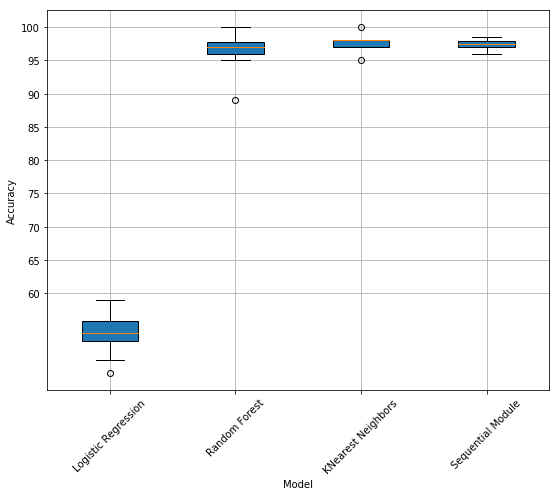

In [16]:
plt.figure(figsize=(9, 7))
ax = plt.axes()
plt.grid()
model_scores = [
   logreg_scores["test_score"]*100,
   randforest_scores["test_score"]*100,
   knn_scores["test_score"]*100,
   np.array(sequential_scores["test_score"])*100
]
model_names = [
   "Logistic Regression",
   "Random Forest",
   "KNearest Neighbors",
   "Sequential Module"
]
ax.boxplot(model_scores, patch_artist=True)
ax.set_ylabel("Accuracy")
ax.set_yticks(np.arange(60,101,5))
ax.set_xlabel("Model")
plt.ylim()
_ = ax.set_xticklabels(model_names, rotation=45)